## Physics Informed Neural Networks to Approximate Solution of PDEs

In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
from torch.utils.data import DataLoader
import sys 
sys.path.append('/Users/timostroschein/Desktop/Deep Learning/DLSC')
from Common import NeuralNet, MultiVariatePoly
import time
torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)

Consider the one-dimensional heat equation:

$$
u_t(t, x) = u_{xx}(t, x), \quad t\in[0,T], ~x\in [-1,1]
$$

with zero Dirichlet boundary conditions

$$
u_b(t, -1)=u_b(t,1)=0, 
$$

and initial condition

$$
u(x, 0) = u_0(x) = - \sin(\pi x)
$$

We want to obtain an approximate solution of the heat equation $u : [0,T]\times[-1,1] \mapsto \mathbb{R}$ with physics informed neural networks (PINNs).

To do so, we approximate the underlying solution with a feedforward dense neural network with tunable parameters $\theta$:

$$
u_\theta(t,x) \approx u(t,x)
$$
Define the following residuals:

   - Interior residual given by,

   $$r_{int,\theta}(t, x):=  u_{\theta, t}(x,t) - u_{\theta, xx}(x,t), \quad \forall ~t \in [0,T],~ x \in [-1,1].$$
   
        
      
        
   - Spatial boundary residual given by,
   
        $$r_{sb,\theta}(t,-1):= u_{\theta}(t,-1)- u_b(t,-1), \quad r_{sb,\theta}(t,1):= u_{\theta}(t,1)- u_b(t,1), \quad \forall t \in (0,T].$$
        
   - Temporal boundary residual given by,
   
        $$r_{tb,\theta}(x):= u_{\theta}(x,0) - u_0(x), \quad \forall x \in [-1,1].$$

and compute the corresponding loss functions:

$$
L_{int}(\theta) = \int_{[0,T]\times[-1,1]}r_{int,\theta}^2(t, x) dtdx, \quad
L_{sb}(\theta) = \int_{[0,T]}r_{sb,\theta}^2(t,-1) dt + \int_{[0,T]}r_{sb,\theta}^2(t,1)dt, \quad
L_{tb}(\theta) = \int_{[-1,1]}r_{tb,\theta}^2(x) dx
$$

The loss functions include integrals that can be approximated by suitable quadrature rule. We use quasi Monte-Carlo and accordingly define the following training sets

$$
S_{int} =\{y_n\}, \quad 1 \leq n \leq N_{int},\quad y_n = (x,t)_n \in D_T,
$$

$$
S_{sb, -1} =\{t_n, u_b(t_n,-1) \}, \quad1 \leq n \leq N_{sb}, t_n \in [0,T],
$$

$$
S_{sb, 1} =\{t_n, u_b(t_n,1) \}, \quad1 \leq n \leq N_{sb}, t_n \in [0,T],
$$

$$
S_{tb}=\{x_n, u_0(x_n)\}\quad  1 \leq n \leq N_{tb}, x_n \in [-1,1].
$$

with the training inputs points corresponding to low-discrepancy Sobol sequences.

$$
L_{int}(\theta) = \frac{1}{N_{int}}\sum_{i=1}^{N_{int}}r_{int,\theta}^2(y_n), \quad
L_{sb}(\theta) = \frac{1}{N_{sb}}\sum_{i=1}^{N_{sb}}r_{sb,\theta}^2(t_n,-1) + \frac{1}{N_{sb}}\sum_{i=1}^{N_{sb}}r_{sb,\theta}^2(t_n,1), \quad
L_{tb}(\theta) = \frac{1}{N_{tb}}\sum_{i=1}^{N_{tb}}r_{tb,\theta}^2(x_n)
$$

and solve the following minimization problem

$$
\theta^\ast = argmin_{\theta} \Big(L_{int}(\theta) + \lambda_u L_u(\theta)\Big)
$$

with

$$
L_u(\theta) = L_{tb}(\theta) + L_{sb}(\theta)
$$



In [8]:
# actual MC dimension independet O(1/sqrt(N)) . But qausi MC is dimension dependent propto O(log(N)^d/N)

In [9]:
alpha_f = 0.05; alpha_s= 0.08 ;h_f =5 ;h_s = 6 ; T_hot = 4; T0 = 1;  U_f =1

In [10]:
print(torch.full((4,2), T0))

tensor([[1, 1],
        [1, 1],
        [1, 1],
        [1, 1]])


In [228]:
class Pinns:
    def __init__(self, n_int_, n_sb_, n_tb_):
        self.n_int = n_int_
        self.n_sb = n_sb_
        self.n_tb = n_tb_

        # Extrema of the solution domain (t,x) in [0,0.1]x[-1,1]
        self.domain_extrema = torch.tensor([[0, 1],  # Time dimension
                                            [0, 1]])  # Space dimension

        # Number of space dimensions
        self.space_dimensions = 1

        # Parameter to balance role of data and PDE
        self.lambda_u = 1

        # F Dense NN to approximate the solution of the underlying heat equation
        self.approximate_solution = NeuralNet(input_dimension=self.domain_extrema.shape[0], output_dimension=2,
                                              n_hidden_layers=4,
                                              neurons=20,
                                              regularization_param=0.,
                                              regularization_exp=2.,
                                              retrain_seed=42)
        '''self.approximate_solution = MultiVariatePoly(self.domain_extrema.shape[0], 3)'''

        # Generator of Sobol sequences
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain_extrema.shape[0])

        # Training sets S_sb, S_tb, S_int as torch dataloader
        self.training_set_sb, self.training_set_tb, self.training_set_int = self.assemble_datasets()

    ################################################################################################
    # Function to linearly transform a tensor whose value are between 0 and 1
    # to a tensor whose values are between the domain extrema
    def convert(self, tens):
        assert (tens.shape[1] == self.domain_extrema.shape[0])
        return tens * (self.domain_extrema[:, 1] - self.domain_extrema[:, 0]) + self.domain_extrema[:, 0]

    # Initial condition to solve the heat equation u0(x)=-sin(pi x)
    def initial_condition(self, batch_size):
        return torch.full((batch_size,2), T0)

    # Exact solution for the heat equation ut = u_xx with the IC above
    def exact_solution(self, inputs):
        t = inputs[:, 0]
        x = inputs[:, 1]

        u = -torch.exp(-np.pi ** 2 * t) * torch.sin(np.pi * x)
        return u

    ################################################################################################
    # Function returning the input-output tensor required to assemble the training set S_tb corresponding to the temporal boundary
    def add_temporal_boundary_points(self):
        t0 = self.domain_extrema[0, 0]
        input_tb = self.convert(self.soboleng.draw(self.n_tb))
        input_tb[:, 0] = torch.full(input_tb[:, 0].shape, t0)
        output_tb = self.initial_condition(self.n_tb)

        return input_tb, output_tb
    
    def boundary_x0_for_Tf(self, t):
        return ((T_hot-T0)/(1+ torch.exp(-200* (t -0.25))) + T0).view(-1,1)  
    
    # Function returning the input-output tensor required to assemble the training set S_sb corresponding to the spatial boundary
    def add_spatial_boundary_points(self):
        x0 = self.domain_extrema[1, 0]
        xL = self.domain_extrema[1, 1]

        input_sb = self.convert(self.soboleng.draw(self.n_sb))

        input_sb_0 = torch.clone(input_sb)
        input_sb_0[:, 1] = torch.full(input_sb_0[:, 1].shape, x0)

        input_sb_L = torch.clone(input_sb)
        input_sb_L[:, 1] = torch.full(input_sb_L[:, 1].shape, xL)
        
        Tf_sb_0 = self.boundary_x0_for_Tf(input_sb_0[:,0])
        
        output_sb_0 = torch.cat([ Tf_sb_0,torch.zeros((input_sb.shape[0], 1))], 1)
        output_sb_L = torch.zeros((input_sb.shape[0], 2))

        return torch.cat([input_sb_0, input_sb_L], 0), torch.cat([output_sb_0, output_sb_L], 0)

    #  Function returning the input-output tensor required to assemble the training set S_int corresponding to the interior domain where the PDE is enforced
    def add_interior_points(self):
        input_int = self.convert(self.soboleng.draw(self.n_int))
        output_int = torch.zeros((input_int.shape[0], 2))
        return input_int, output_int

    # Function returning the training sets S_sb, S_tb, S_int as dataloader
    def assemble_datasets(self):
        input_sb, output_sb = self.add_spatial_boundary_points()   # S_sb
        input_tb, output_tb = self.add_temporal_boundary_points()  # S_tb
        input_int, output_int = self.add_interior_points()         # S_int

        training_set_sb = DataLoader(torch.utils.data.TensorDataset(input_sb, output_sb), batch_size=2*self.space_dimensions*self.n_sb, shuffle=False)
        training_set_tb = DataLoader(torch.utils.data.TensorDataset(input_tb, output_tb), batch_size=self.n_tb, shuffle=False)
        training_set_int = DataLoader(torch.utils.data.TensorDataset(input_int, output_int), batch_size=self.n_int, shuffle=False)

        return training_set_sb, training_set_tb, training_set_int

    ################################################################################################
    # Function to compute the terms required in the definition of the TEMPORAL boundary residual
    def apply_initial_condition(self, input_tb):
        u_pred_tb = self.approximate_solution(input_tb)
        return u_pred_tb

    # Function to compute the terms required in the definition of the SPATIAL boundary residual
    def apply_boundary_conditions(self, input_sb):
        l = int(input_sb.shape[0]/2) 
        
        input_sb.requires_grad = True
        u_pred_sb = self.approximate_solution(input_sb)  
        
        Tf=u_pred_sb[:,0].view(-1,1)
        Ts=u_pred_sb[:,1].view(-1,1)
        
        grad_Ts= torch.autograd.grad(Ts.sum(), input_sb, create_graph=True)[0]
        grad_Ts_x = grad_Ts[:, 1].view(-1,1)
        
#         print("Ts shape",Ts.shape )
#         print("grad shape",grad_Ts_x.shape )
        
        l = int(input_sb.shape[0]/2)
        grad_Tf= torch.autograd.grad(Tf.sum(), input_sb, create_graph=True)[0]
        grad_Tf_x = grad_Tf[l:, 1].view(-1,1)
        
        boundary_0 = torch.cat([Tf[:l].view(-1,1),grad_Tf_x[:l]],1)
        boundary_L = torch.cat([grad_Tf_x,grad_Ts_x[l:]],1 )
        
        boundary_points = torch.cat([boundary_0,boundary_L],0)
        
        return boundary_points

    # Function to compute the PDE residuals
    def compute_pde_residual(self, input_int):
        input_int.requires_grad = True
        u = self.approximate_solution(input_int)
        
        Tf=u[:,0].view(-1,1)
        Ts=u[:,1].view(-1,1)
        
        grad_Tf = torch.autograd.grad(Tf.sum(), input_int, create_graph=True)[0]
        grad_Tf_t = grad_Tf[:, 0].view(-1,1) #t in 0 coloumn 
        grad_Tf_x = grad_Tf[:, 1].view(-1,1)
    
        grad_Tf_xx = torch.autograd.grad(grad_Tf_x.sum(), input_int, create_graph=True)[0][:, 1].view(-1,1)
        
        grad_Ts = torch.autograd.grad(Ts.sum(), input_int, create_graph=True)[0]
        grad_Ts_t = grad_Ts[:, 0].view(-1,1)  #t in 0 coloumn 
        grad_Ts_x = grad_Ts[:, 1].view(-1,1)
        grad_Ts_xx = torch.autograd.grad(grad_Ts_x.sum(), input_int, create_graph=True)[0][:, 1].view(-1,1)
        
        residual_1 = grad_Tf_t + U_f * grad_Tf_x - alpha_f * grad_Tf_xx + h_f * ( Tf- Ts)
        residual_2 = grad_Ts_t - alpha_s * grad_Ts_xx - h_s * (Tf - Ts)
        residual = torch.cat( [residual_1 , residual_2],0)
        
        return residual.reshape(-1, )

    # Function to compute the total loss (weighted sum of spatial boundary loss, temporal boundary loss and interior loss)
    def compute_loss(self, inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, verbose=True):
        u_pred_sb = self.apply_boundary_conditions(inp_train_sb)
        u_pred_tb = self.apply_initial_condition(inp_train_tb)

        
        assert (u_pred_sb.shape[1] == u_train_sb.shape[1])
        assert (u_pred_tb.shape[1] == u_train_tb.shape[1])


        r_int = self.compute_pde_residual(inp_train_int)
        r_sb = u_train_sb - u_pred_sb
        r_tb = u_train_tb - u_pred_tb

        loss_sb = torch.mean(abs(r_sb) ** 2)
        loss_tb = torch.mean(abs(r_tb) ** 2)
        loss_int = torch.mean(abs(r_int) ** 2)

        loss_u = loss_sb + loss_tb
        
        loss = torch.log10(self.lambda_u * (loss_sb + loss_tb) + loss_int)
        if verbose: print("Total loss: ", round(loss.item(), 4), "| PDE Loss: ", round(torch.log10(loss_u).item(), 4), "| Function Loss: ", round(torch.log10(loss_int).item(), 4))

        return loss

    ################################################################################################
    def fit(self, num_epochs, optimizer, verbose=True):
        history = list()

        # Loop over epochs
        for epoch in range(num_epochs):
            if verbose: print("################################ ", epoch, " ################################")

            for j, ((inp_train_sb, u_train_sb), (inp_train_tb, u_train_tb), (inp_train_int, u_train_int)) in enumerate(zip(self.training_set_sb, self.training_set_tb, self.training_set_int)):
                def closure():
                    optimizer.zero_grad()
                    loss = self.compute_loss(inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, verbose=verbose)
                    loss.backward()

                    history.append(loss.item())
                    return loss

                optimizer.step(closure=closure)

        print('Final Loss: ', history[-1])

        return history

    ################################################################################################
    def plotting(self):
        inputs = self.soboleng.draw(100000)
        inputs = self.convert(inputs)

        outputs = self.approximate_solution(inputs)
        
        output = outputs[:,1].reshape(-1, )
        exact_output = outputs[:,0].reshape(-1, )
        print(output.shape)
        
        
        fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
        im1 = axs[0].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=exact_output.detach(), cmap="jet")
        axs[0].set_xlabel("x")
        axs[0].set_ylabel("t")
        plt.colorbar(im1, ax=axs[0])
        axs[0].grid(True, which="both", ls=":")
        im2 = axs[1].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=output.detach(), cmap="jet")
        axs[1].set_xlabel("x")
        axs[1].set_ylabel("t")
        plt.colorbar(im2, ax=axs[1])
        axs[1].grid(True, which="both", ls=":")
        axs[0].set_title("Approximate Tf solution")
        axs[1].set_title("Approximate Ts solution")

        plt.savefig('Task_1_Train_plots')
        plt.show()

        err = (torch.mean((output - exact_output) ** 2) / torch.mean(exact_output ** 2)) ** 0.5 * 100
        print("L2 Relative Error Norm: ", err.item(), "%")


In [229]:
# Solve the heat equation:
# u_t = u_xx, (t,x) in [0, 0.1]x[-1,1]
# with zero dirichlet BC and
# u(x,0)= -sin(pi x)

n_int = 256
n_sb = 64
n_tb = 64

pinn = Pinns(n_int, n_sb, n_tb)

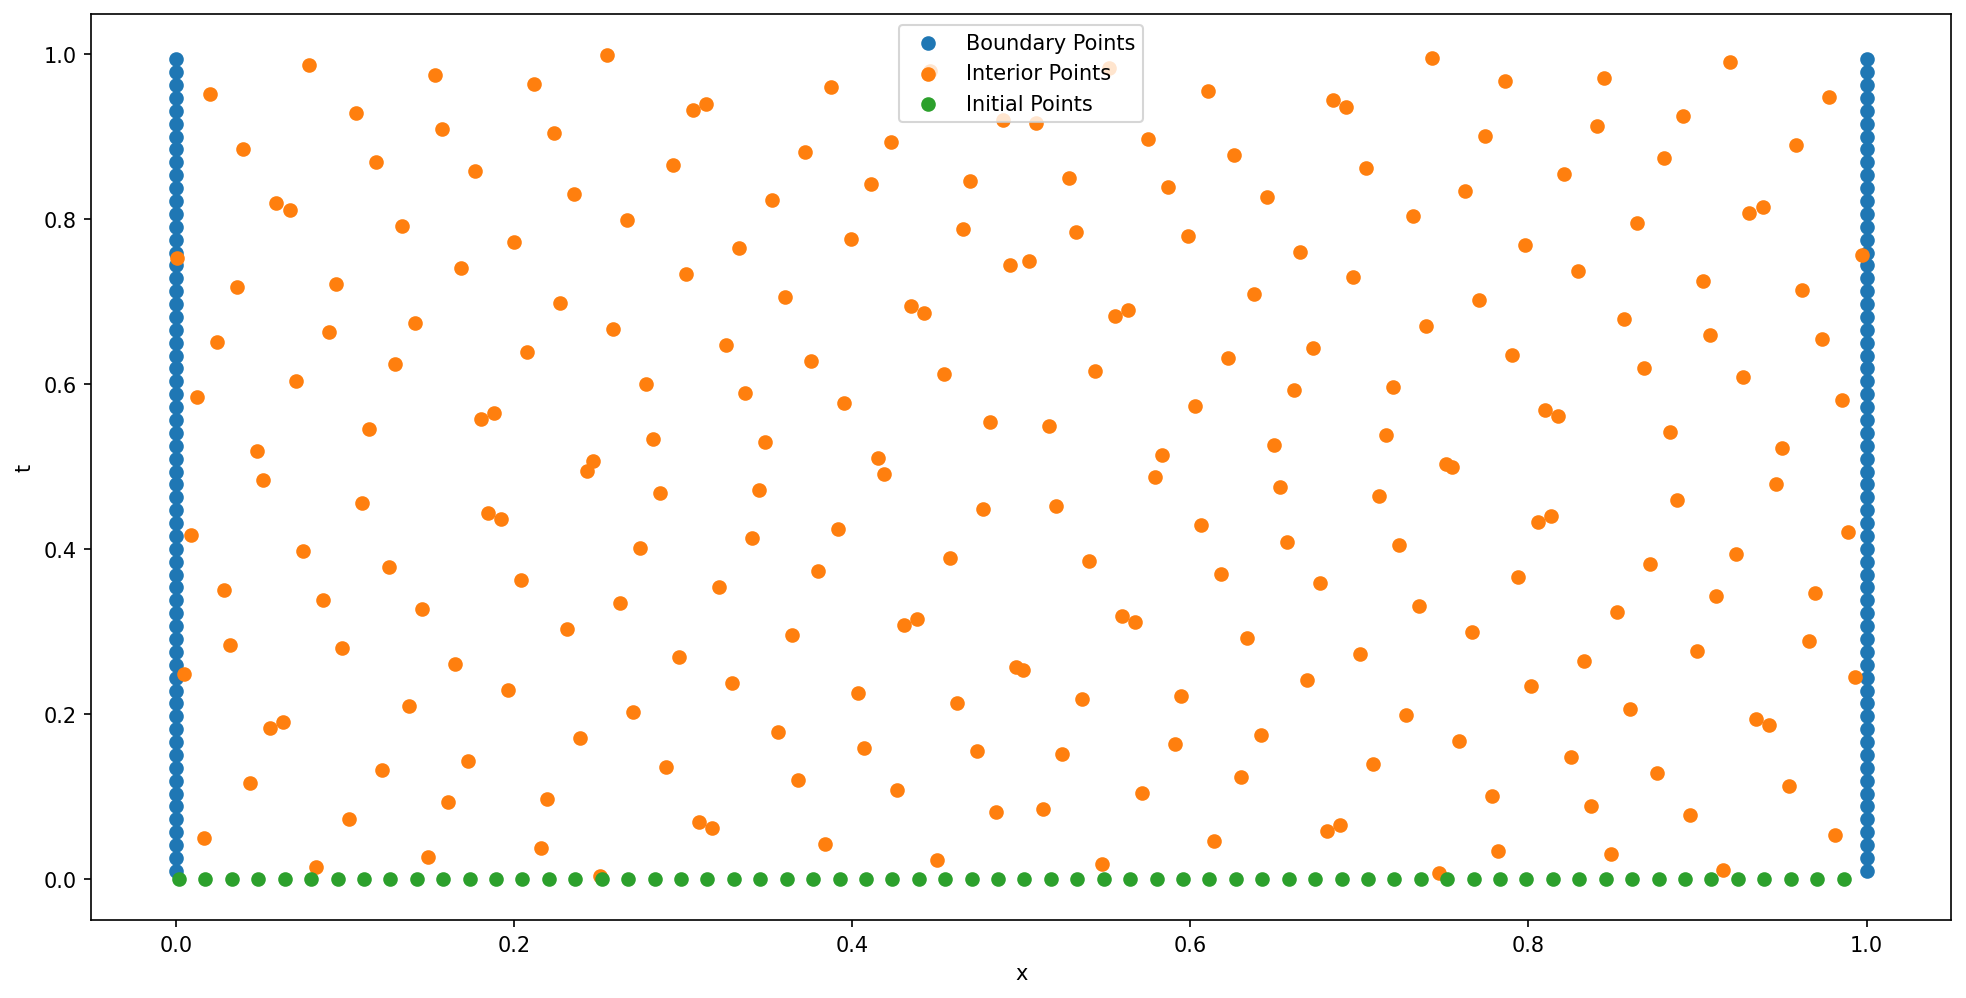

In [230]:
# Plot the input training points
input_sb_, output_sb_ = pinn.add_spatial_boundary_points()
input_tb_, output_tb_ = pinn.add_temporal_boundary_points()
input_int_, output_int_ = pinn.add_interior_points()

plt.figure(figsize=(16, 8), dpi=150)
plt.scatter(input_sb_[:, 1].detach().numpy(), input_sb_[:, 0].detach().numpy(), label="Boundary Points")
plt.scatter(input_int_[:, 1].detach().numpy(), input_int_[:, 0].detach().numpy(), label="Interior Points")
plt.scatter(input_tb_[:, 1].detach().numpy(), input_tb_[:, 0].detach().numpy(), label="Initial Points")
plt.xlabel("x")
plt.ylabel("t")
plt.legend()
plt.show()

#quasi random for d smaller 20       extra uniform/ no clusters 
#else pseudo random 

In [231]:
n_epochs = 10
optimizer_LBFGS = optim.LBFGS(pinn.approximate_solution.parameters(),
                              lr=float(0.5),
                              max_iter=50000,
                              max_eval=50000,
                              history_size=150,
                              line_search_fn="strong_wolfe",
                              tolerance_change=1.0 * np.finfo(float).eps)
optimizer_ADAM = optim.Adam(pinn.approximate_solution.parameters(),
                            lr=float(0.001))

################################  0  ################################
Total loss:  1.822 | PDE Loss:  0.6483 | Function Loss:  1.6447
################################  1  ################################
Total loss:  1.716 | PDE Loss:  0.6245 | Function Loss:  1.4906
################################  2  ################################
Total loss:  1.6202 | PDE Loss:  0.5975 | Function Loss:  1.3408
################################  3  ################################
Total loss:  1.5444 | PDE Loss:  0.5665 | Function Loss:  1.22
################################  4  ################################
Total loss:  1.4916 | PDE Loss:  0.5311 | Function Loss:  1.1473
################################  5  ################################
Total loss:  1.4528 | PDE Loss:  0.4924 | Function Loss:  1.1081
################################  6  ################################
Total loss:  1.4127 | PDE Loss:  0.453 | Function Loss:  1.0672
################################  7  #######################

Total loss:  0.4304 | PDE Loss:  -0.3703 | Function Loss:  -0.2498
################################  62  ################################
Total loss:  0.4209 | PDE Loss:  -0.3762 | Function Loss:  -0.2729
################################  63  ################################
Total loss:  0.412 | PDE Loss:  -0.3819 | Function Loss:  -0.2948
################################  64  ################################
Total loss:  0.4028 | PDE Loss:  -0.3883 | Function Loss:  -0.3159
################################  65  ################################
Total loss:  0.394 | PDE Loss:  -0.3951 | Function Loss:  -0.333
################################  66  ################################
Total loss:  0.3853 | PDE Loss:  -0.4018 | Function Loss:  -0.3504
################################  67  ################################
Total loss:  0.3765 | PDE Loss:  -0.4086 | Function Loss:  -0.3684
################################  68  ################################
Total loss:  0.3679 | PDE Loss:  -0.4

Total loss:  -0.073 | PDE Loss:  -0.8906 | Function Loss:  -0.6946
################################  122  ################################
Total loss:  -0.0778 | PDE Loss:  -0.895 | Function Loss:  -0.7005
################################  123  ################################
Total loss:  -0.0763 | PDE Loss:  -0.8972 | Function Loss:  -0.6876
################################  124  ################################
Total loss:  -0.0849 | PDE Loss:  -0.9034 | Function Loss:  -0.7035
################################  125  ################################
Total loss:  -0.0894 | PDE Loss:  -0.907 | Function Loss:  -0.7109
################################  126  ################################
Total loss:  -0.0888 | PDE Loss:  -0.9089 | Function Loss:  -0.7025
################################  127  ################################
Total loss:  -0.0956 | PDE Loss:  -0.9142 | Function Loss:  -0.7142
################################  128  ################################
Total loss:  -0.1003 | 

Total loss:  -0.2212 | PDE Loss:  -1.009 | Function Loss:  -0.9543
################################  182  ################################
Total loss:  -0.2218 | PDE Loss:  -1.01 | Function Loss:  -0.9532
################################  183  ################################
Total loss:  -0.2248 | PDE Loss:  -1.0113 | Function Loss:  -0.9635
################################  184  ################################
Total loss:  -0.2289 | PDE Loss:  -1.0124 | Function Loss:  -0.9813
################################  185  ################################
Total loss:  -0.232 | PDE Loss:  -1.0136 | Function Loss:  -0.9934
################################  186  ################################
Total loss:  -0.2333 | PDE Loss:  -1.0147 | Function Loss:  -0.9956
################################  187  ################################
Total loss:  -0.2336 | PDE Loss:  -1.0158 | Function Loss:  -0.9919
################################  188  ################################
Total loss:  -0.2341 | P

Total loss:  -0.3272 | PDE Loss:  -1.092 | Function Loss:  -1.1794
################################  242  ################################
Total loss:  -0.3273 | PDE Loss:  -1.0941 | Function Loss:  -1.1675
################################  243  ################################
Total loss:  -0.3283 | PDE Loss:  -1.0952 | Function Loss:  -1.1676
################################  244  ################################
Total loss:  -0.3308 | PDE Loss:  -1.0975 | Function Loss:  -1.1709
################################  245  ################################
Total loss:  -0.3339 | PDE Loss:  -1.0988 | Function Loss:  -1.1848
################################  246  ################################
Total loss:  -0.3363 | PDE Loss:  -1.1007 | Function Loss:  -1.1901
################################  247  ################################
Total loss:  -0.3376 | PDE Loss:  -1.1026 | Function Loss:  -1.1882
################################  248  ################################
Total loss:  -0.3384 

Total loss:  -0.413 | PDE Loss:  -1.2025 | Function Loss:  -1.1386
################################  302  ################################
Total loss:  -0.4146 | PDE Loss:  -1.2055 | Function Loss:  -1.1342
################################  303  ################################
Total loss:  -0.418 | PDE Loss:  -1.2061 | Function Loss:  -1.1497
################################  304  ################################
Total loss:  -0.4224 | PDE Loss:  -1.2088 | Function Loss:  -1.1611
################################  305  ################################
Total loss:  -0.4262 | PDE Loss:  -1.21 | Function Loss:  -1.1771
################################  306  ################################
Total loss:  -0.4287 | PDE Loss:  -1.212 | Function Loss:  -1.1818
################################  307  ################################
Total loss:  -0.4298 | PDE Loss:  -1.2137 | Function Loss:  -1.18
################################  308  ################################
Total loss:  -0.43 | PDE Lo

Total loss:  -0.5032 | PDE Loss:  -1.2966 | Function Loss:  -1.2123
################################  362  ################################
Total loss:  -0.5054 | PDE Loss:  -1.2978 | Function Loss:  -1.2188
################################  363  ################################
Total loss:  -0.5069 | PDE Loss:  -1.2992 | Function Loss:  -1.2203
################################  364  ################################
Total loss:  -0.5077 | PDE Loss:  -1.3008 | Function Loss:  -1.2182
################################  365  ################################
Total loss:  -0.5083 | PDE Loss:  -1.3018 | Function Loss:  -1.2167
################################  366  ################################
Total loss:  -0.5088 | PDE Loss:  -1.3036 | Function Loss:  -1.2121
################################  367  ################################
Total loss:  -0.5096 | PDE Loss:  -1.3044 | Function Loss:  -1.2127
################################  368  ################################
Total loss:  -0.5107

Total loss:  -0.5895 | PDE Loss:  -1.3766 | Function Loss:  -1.3256
################################  422  ################################
Total loss:  -0.5905 | PDE Loss:  -1.3779 | Function Loss:  -1.3254
################################  423  ################################
Total loss:  -0.5911 | PDE Loss:  -1.379 | Function Loss:  -1.3235
################################  424  ################################
Total loss:  -0.5916 | PDE Loss:  -1.3804 | Function Loss:  -1.3201
################################  425  ################################
Total loss:  -0.5924 | PDE Loss:  -1.3814 | Function Loss:  -1.3201
################################  426  ################################
Total loss:  -0.5937 | PDE Loss:  -1.3829 | Function Loss:  -1.3206
################################  427  ################################
Total loss:  -0.5954 | PDE Loss:  -1.3839 | Function Loss:  -1.325
################################  428  ################################
Total loss:  -0.5973 |

Total loss:  -0.6592 | PDE Loss:  -1.4481 | Function Loss:  -1.387
################################  482  ################################
Total loss:  -0.6576 | PDE Loss:  -1.4491 | Function Loss:  -1.3743
################################  483  ################################
Total loss:  -0.6548 | PDE Loss:  -1.4503 | Function Loss:  -1.3552
################################  484  ################################
Total loss:  -0.6513 | PDE Loss:  -1.4512 | Function Loss:  -1.3348
################################  485  ################################
Total loss:  -0.6494 | PDE Loss:  -1.4523 | Function Loss:  -1.3212
################################  486  ################################
Total loss:  -0.6514 | PDE Loss:  -1.4533 | Function Loss:  -1.3271
################################  487  ################################
Total loss:  -0.6574 | PDE Loss:  -1.4547 | Function Loss:  -1.3507
################################  488  ################################
Total loss:  -0.6643 

Total loss:  -0.714 | PDE Loss:  -1.5118 | Function Loss:  -1.4054
################################  542  ################################
Total loss:  -0.7185 | PDE Loss:  -1.5126 | Function Loss:  -1.4246
################################  543  ################################
Total loss:  -0.7221 | PDE Loss:  -1.5139 | Function Loss:  -1.4379
################################  544  ################################
Total loss:  -0.7246 | PDE Loss:  -1.5148 | Function Loss:  -1.4473
################################  545  ################################
Total loss:  -0.726 | PDE Loss:  -1.5159 | Function Loss:  -1.45
################################  546  ################################
Total loss:  -0.7266 | PDE Loss:  -1.5169 | Function Loss:  -1.4486
################################  547  ################################
Total loss:  -0.7266 | PDE Loss:  -1.5177 | Function Loss:  -1.4449
################################  548  ################################
Total loss:  -0.726 | PD

Total loss:  -0.77 | PDE Loss:  -1.5716 | Function Loss:  -1.4472
################################  602  ################################
Total loss:  -0.7733 | PDE Loss:  -1.572 | Function Loss:  -1.4612
################################  603  ################################
Total loss:  -0.7759 | PDE Loss:  -1.5735 | Function Loss:  -1.468
################################  604  ################################
Total loss:  -0.7778 | PDE Loss:  -1.5742 | Function Loss:  -1.4748
################################  605  ################################
Total loss:  -0.7793 | PDE Loss:  -1.5754 | Function Loss:  -1.4771
################################  606  ################################
Total loss:  -0.7803 | PDE Loss:  -1.5763 | Function Loss:  -1.479
################################  607  ################################
Total loss:  -0.7812 | PDE Loss:  -1.5773 | Function Loss:  -1.4795
################################  608  ################################
Total loss:  -0.7819 | PD

Total loss:  -0.8149 | PDE Loss:  -1.6308 | Function Loss:  -1.4421
################################  662  ################################
Total loss:  -0.8121 | PDE Loss:  -1.63 | Function Loss:  -1.4327
################################  663  ################################
Total loss:  -0.8114 | PDE Loss:  -1.6327 | Function Loss:  -1.4216
################################  664  ################################
Total loss:  -0.8142 | PDE Loss:  -1.632 | Function Loss:  -1.435
################################  665  ################################
Total loss:  -0.8193 | PDE Loss:  -1.6347 | Function Loss:  -1.4478
################################  666  ################################
Total loss:  -0.8248 | PDE Loss:  -1.6346 | Function Loss:  -1.4719
################################  667  ################################
Total loss:  -0.8291 | PDE Loss:  -1.6367 | Function Loss:  -1.4842
################################  668  ################################
Total loss:  -0.8321 | P

Total loss:  -0.8758 | PDE Loss:  -1.6898 | Function Loss:  -1.5092
################################  722  ################################
Total loss:  -0.8761 | PDE Loss:  -1.6904 | Function Loss:  -1.5085
################################  723  ################################
Total loss:  -0.8761 | PDE Loss:  -1.6919 | Function Loss:  -1.5034
################################  724  ################################
Total loss:  -0.8755 | PDE Loss:  -1.6919 | Function Loss:  -1.5009
################################  725  ################################
Total loss:  -0.8743 | PDE Loss:  -1.6939 | Function Loss:  -1.4895
################################  726  ################################
Total loss:  -0.8722 | PDE Loss:  -1.6933 | Function Loss:  -1.4828
################################  727  ################################
Total loss:  -0.8694 | PDE Loss:  -1.6959 | Function Loss:  -1.4635
################################  728  ################################
Total loss:  -0.8666

Total loss:  -0.9064 | PDE Loss:  -1.7436 | Function Loss:  -1.4708
################################  782  ################################
Total loss:  -0.9042 | PDE Loss:  -1.7474 | Function Loss:  -1.4531
################################  783  ################################
Total loss:  -0.9046 | PDE Loss:  -1.7451 | Function Loss:  -1.4603
################################  784  ################################
Total loss:  -0.9078 | PDE Loss:  -1.7492 | Function Loss:  -1.4611
################################  785  ################################
Total loss:  -0.9126 | PDE Loss:  -1.7475 | Function Loss:  -1.4832
################################  786  ################################
Total loss:  -0.9173 | PDE Loss:  -1.7509 | Function Loss:  -1.4915
################################  787  ################################
Total loss:  -0.921 | PDE Loss:  -1.7501 | Function Loss:  -1.5078
################################  788  ################################
Total loss:  -0.9235 

Total loss:  -0.9523 | PDE Loss:  -1.7981 | Function Loss:  -1.4946
################################  842  ################################
Total loss:  -0.9571 | PDE Loss:  -1.7962 | Function Loss:  -1.5165
################################  843  ################################
Total loss:  -0.9606 | PDE Loss:  -1.7992 | Function Loss:  -1.5214
################################  844  ################################
Total loss:  -0.963 | PDE Loss:  -1.7986 | Function Loss:  -1.5316
################################  845  ################################
Total loss:  -0.9646 | PDE Loss:  -1.8004 | Function Loss:  -1.5327
################################  846  ################################
Total loss:  -0.9657 | PDE Loss:  -1.8007 | Function Loss:  -1.5359
################################  847  ################################
Total loss:  -0.9665 | PDE Loss:  -1.8017 | Function Loss:  -1.5363
################################  848  ################################
Total loss:  -0.9671 

Total loss:  -1.0012 | PDE Loss:  -1.8437 | Function Loss:  -1.552
################################  902  ################################
Total loss:  -1.0034 | PDE Loss:  -1.847 | Function Loss:  -1.5514
################################  903  ################################
Total loss:  -1.0051 | PDE Loss:  -1.8459 | Function Loss:  -1.56
################################  904  ################################
Total loss:  -1.0064 | PDE Loss:  -1.8482 | Function Loss:  -1.559
################################  905  ################################
Total loss:  -1.0075 | PDE Loss:  -1.8484 | Function Loss:  -1.5623
################################  906  ################################
Total loss:  -1.0083 | PDE Loss:  -1.8493 | Function Loss:  -1.5626
################################  907  ################################
Total loss:  -1.0088 | PDE Loss:  -1.8505 | Function Loss:  -1.5614
################################  908  ################################
Total loss:  -1.0092 | PD

Total loss:  -1.0482 | PDE Loss:  -1.8955 | Function Loss:  -1.5866
################################  962  ################################
Total loss:  -1.0489 | PDE Loss:  -1.8961 | Function Loss:  -1.5879
################################  963  ################################
Total loss:  -1.0495 | PDE Loss:  -1.8968 | Function Loss:  -1.588
################################  964  ################################
Total loss:  -1.0499 | PDE Loss:  -1.8982 | Function Loss:  -1.5862
################################  965  ################################
Total loss:  -1.05 | PDE Loss:  -1.898 | Function Loss:  -1.587
################################  966  ################################
Total loss:  -1.0496 | PDE Loss:  -1.9004 | Function Loss:  -1.5797
################################  967  ################################
Total loss:  -1.0481 | PDE Loss:  -1.8988 | Function Loss:  -1.5787
################################  968  ################################
Total loss:  -1.0449 | PD

Total loss:  -1.092 | PDE Loss:  -1.9472 | Function Loss:  -1.6116
################################  1022  ################################
Total loss:  -1.0925 | PDE Loss:  -1.948 | Function Loss:  -1.6114
################################  1023  ################################
Total loss:  -1.0927 | PDE Loss:  -1.9495 | Function Loss:  -1.6088
################################  1024  ################################
Total loss:  -1.0924 | PDE Loss:  -1.949 | Function Loss:  -1.6089
################################  1025  ################################
Total loss:  -1.0909 | PDE Loss:  -1.9522 | Function Loss:  -1.597
################################  1026  ################################
Total loss:  -1.0874 | PDE Loss:  -1.9491 | Function Loss:  -1.5925
################################  1027  ################################
Total loss:  -1.0806 | PDE Loss:  -1.9555 | Function Loss:  -1.5579
################################  1028  ################################
Total loss:  -1.0

Total loss:  -1.1342 | PDE Loss:  -1.9977 | Function Loss:  -1.6355
################################  1082  ################################
Total loss:  -1.1343 | PDE Loss:  -2.002 | Function Loss:  -1.6265
################################  1083  ################################
Total loss:  -1.1335 | PDE Loss:  -1.9985 | Function Loss:  -1.6316
################################  1084  ################################
Total loss:  -1.131 | PDE Loss:  -2.005 | Function Loss:  -1.6101
################################  1085  ################################
Total loss:  -1.1249 | PDE Loss:  -1.9981 | Function Loss:  -1.6058
################################  1086  ################################
Total loss:  -1.1144 | PDE Loss:  -2.0085 | Function Loss:  -1.5558
################################  1087  ################################
Total loss:  -1.1031 | PDE Loss:  -1.9968 | Function Loss:  -1.5452
################################  1088  ################################
Total loss:  -1.

Total loss:  -1.1785 | PDE Loss:  -2.0506 | Function Loss:  -1.6617
################################  1142  ################################
Total loss:  -1.1794 | PDE Loss:  -2.0529 | Function Loss:  -1.6598
################################  1143  ################################
Total loss:  -1.1801 | PDE Loss:  -2.0528 | Function Loss:  -1.6619
################################  1144  ################################
Total loss:  -1.1806 | PDE Loss:  -2.054 | Function Loss:  -1.661
################################  1145  ################################
Total loss:  -1.181 | PDE Loss:  -2.0548 | Function Loss:  -1.6606
################################  1146  ################################
Total loss:  -1.1811 | PDE Loss:  -2.0549 | Function Loss:  -1.6608
################################  1147  ################################
Total loss:  -1.1806 | PDE Loss:  -2.0572 | Function Loss:  -1.6549
################################  1148  ################################
Total loss:  -1.

Total loss:  -1.1843 | PDE Loss:  -2.1056 | Function Loss:  -1.5816
################################  1202  ################################
Total loss:  -1.1938 | PDE Loss:  -2.0927 | Function Loss:  -1.6268
################################  1203  ################################
Total loss:  -1.2042 | PDE Loss:  -2.1056 | Function Loss:  -1.6332
################################  1204  ################################
Total loss:  -1.2116 | PDE Loss:  -2.0983 | Function Loss:  -1.6662
################################  1205  ################################
Total loss:  -1.2157 | PDE Loss:  -2.1049 | Function Loss:  -1.6657
################################  1206  ################################
Total loss:  -1.2178 | PDE Loss:  -2.1016 | Function Loss:  -1.678
################################  1207  ################################
Total loss:  -1.2187 | PDE Loss:  -2.1053 | Function Loss:  -1.6737
################################  1208  ################################
Total loss:  -

Total loss:  -1.2391 | PDE Loss:  -2.1487 | Function Loss:  -1.6544
################################  1262  ################################
Total loss:  -1.2359 | PDE Loss:  -2.1333 | Function Loss:  -1.6715
################################  1263  ################################
Total loss:  -1.236 | PDE Loss:  -2.1488 | Function Loss:  -1.6463
################################  1264  ################################
Total loss:  -1.2398 | PDE Loss:  -2.1359 | Function Loss:  -1.6777
################################  1265  ################################
Total loss:  -1.2453 | PDE Loss:  -2.1516 | Function Loss:  -1.6661
################################  1266  ################################
Total loss:  -1.2501 | PDE Loss:  -2.1425 | Function Loss:  -1.6945
################################  1267  ################################
Total loss:  -1.2531 | PDE Loss:  -2.1538 | Function Loss:  -1.6833
################################  1268  ################################
Total loss:  -

Total loss:  -1.2857 | PDE Loss:  -2.1922 | Function Loss:  -1.7061
################################  1322  ################################
Total loss:  -1.2838 | PDE Loss:  -2.1825 | Function Loss:  -1.7171
################################  1323  ################################
Total loss:  -1.2803 | PDE Loss:  -2.1945 | Function Loss:  -1.6884
################################  1324  ################################
Total loss:  -1.2759 | PDE Loss:  -2.1796 | Function Loss:  -1.7007
################################  1325  ################################
Total loss:  -1.2724 | PDE Loss:  -2.1958 | Function Loss:  -1.6666
################################  1326  ################################
Total loss:  -1.2721 | PDE Loss:  -2.1787 | Function Loss:  -1.6923
################################  1327  ################################
Total loss:  -1.2757 | PDE Loss:  -2.197 | Function Loss:  -1.6729
################################  1328  ################################
Total loss:  -

Total loss:  -1.3005 | PDE Loss:  -2.2233 | Function Loss:  -1.6955
################################  1382  ################################
Total loss:  -1.2931 | PDE Loss:  -2.2138 | Function Loss:  -1.6914
################################  1383  ################################
Total loss:  -1.2934 | PDE Loss:  -2.2298 | Function Loss:  -1.669
################################  1384  ################################
Total loss:  -1.2997 | PDE Loss:  -2.2186 | Function Loss:  -1.7005
################################  1385  ################################
Total loss:  -1.3033 | PDE Loss:  -2.2386 | Function Loss:  -1.6806
################################  1386  ################################
Total loss:  -1.3023 | PDE Loss:  -2.2169 | Function Loss:  -1.7097
################################  1387  ################################
Total loss:  -1.3007 | PDE Loss:  -2.2357 | Function Loss:  -1.6782
################################  1388  ################################
Total loss:  -

Total loss:  -1.3475 | PDE Loss:  -2.2729 | Function Loss:  -1.7387
################################  1442  ################################
Total loss:  -1.3492 | PDE Loss:  -2.26 | Function Loss:  -1.7627
################################  1443  ################################
Total loss:  -1.3499 | PDE Loss:  -2.2738 | Function Loss:  -1.7432
################################  1444  ################################
Total loss:  -1.3494 | PDE Loss:  -2.2613 | Function Loss:  -1.761
################################  1445  ################################
Total loss:  -1.3477 | PDE Loss:  -2.2748 | Function Loss:  -1.7364
################################  1446  ################################
Total loss:  -1.3453 | PDE Loss:  -2.2608 | Function Loss:  -1.7512
################################  1447  ################################
Total loss:  -1.3426 | PDE Loss:  -2.2753 | Function Loss:  -1.7233
################################  1448  ################################
Total loss:  -1.

Total loss:  -1.3615 | PDE Loss:  -2.2891 | Function Loss:  -1.7495
################################  1502  ################################
Total loss:  -1.3561 | PDE Loss:  -2.3093 | Function Loss:  -1.7096
################################  1503  ################################
Total loss:  -1.3604 | PDE Loss:  -2.2895 | Function Loss:  -1.7461
################################  1504  ################################
Total loss:  -1.3699 | PDE Loss:  -2.3096 | Function Loss:  -1.7411
################################  1505  ################################
Total loss:  -1.3789 | PDE Loss:  -2.2975 | Function Loss:  -1.7802
################################  1506  ################################
Total loss:  -1.3847 | PDE Loss:  -2.3099 | Function Loss:  -1.7761
################################  1507  ################################
Total loss:  -1.3879 | PDE Loss:  -2.3027 | Function Loss:  -1.7951
################################  1508  ################################
Total loss:  

Total loss:  -1.4079 | PDE Loss:  -2.3458 | Function Loss:  -1.7814
################################  1562  ################################
Total loss:  -1.3953 | PDE Loss:  -2.3247 | Function Loss:  -1.7806
################################  1563  ################################
Total loss:  -1.3773 | PDE Loss:  -2.3501 | Function Loss:  -1.7073
################################  1564  ################################
Total loss:  -1.369 | PDE Loss:  -2.3167 | Function Loss:  -1.7296
################################  1565  ################################
Total loss:  -1.3809 | PDE Loss:  -2.3512 | Function Loss:  -1.7139
################################  1566  ################################
Total loss:  -1.3986 | PDE Loss:  -2.3279 | Function Loss:  -1.7842
################################  1567  ################################
Total loss:  -1.4101 | PDE Loss:  -2.3496 | Function Loss:  -1.7815
################################  1568  ################################
Total loss:  -

Total loss:  -1.4234 | PDE Loss:  -2.3815 | Function Loss:  -1.7707
################################  1622  ################################
Total loss:  -1.4169 | PDE Loss:  -2.356 | Function Loss:  -1.7887
################################  1623  ################################
Total loss:  -1.4138 | PDE Loss:  -2.3844 | Function Loss:  -1.7465
################################  1624  ################################
Total loss:  -1.4171 | PDE Loss:  -2.3557 | Function Loss:  -1.7897
################################  1625  ################################
Total loss:  -1.4246 | PDE Loss:  -2.3837 | Function Loss:  -1.7708
################################  1626  ################################
Total loss:  -1.4318 | PDE Loss:  -2.3622 | Function Loss:  -1.8158
################################  1627  ################################
Total loss:  -1.437 | PDE Loss:  -2.3826 | Function Loss:  -1.8001
################################  1628  ################################
Total loss:  -1

Total loss:  -1.4544 | PDE Loss:  -2.4135 | Function Loss:  -1.8006
################################  1682  ################################
Total loss:  -1.4487 | PDE Loss:  -2.3911 | Function Loss:  -1.8161
################################  1683  ################################
Total loss:  -1.4441 | PDE Loss:  -2.4174 | Function Loss:  -1.7735
################################  1684  ################################
Total loss:  -1.4439 | PDE Loss:  -2.3895 | Function Loss:  -1.807
################################  1685  ################################
Total loss:  -1.4481 | PDE Loss:  -2.4187 | Function Loss:  -1.7807
################################  1686  ################################
Total loss:  -1.4541 | PDE Loss:  -2.394 | Function Loss:  -1.825
################################  1687  ################################
Total loss:  -1.4592 | PDE Loss:  -2.4179 | Function Loss:  -1.8059
################################  1688  ################################
Total loss:  -1.

Total loss:  -1.4819 | PDE Loss:  -2.4361 | Function Loss:  -1.834
################################  1742  ################################
Total loss:  -1.4826 | PDE Loss:  -2.4281 | Function Loss:  -1.8459
################################  1743  ################################
Total loss:  -1.4829 | PDE Loss:  -2.4391 | Function Loss:  -1.8326
################################  1744  ################################
Total loss:  -1.4828 | PDE Loss:  -2.4284 | Function Loss:  -1.8459
################################  1745  ################################
Total loss:  -1.4819 | PDE Loss:  -2.4437 | Function Loss:  -1.8248
################################  1746  ################################
Total loss:  -1.4803 | PDE Loss:  -2.4276 | Function Loss:  -1.8414
################################  1747  ################################
Total loss:  -1.478 | PDE Loss:  -2.4491 | Function Loss:  -1.81
################################  1748  ################################
Total loss:  -1.4

Total loss:  -1.4959 | PDE Loss:  -2.4704 | Function Loss:  -1.8241
################################  1802  ################################
Total loss:  -1.4985 | PDE Loss:  -2.455 | Function Loss:  -1.8478
################################  1803  ################################
Total loss:  -1.5012 | PDE Loss:  -2.4685 | Function Loss:  -1.8376
################################  1804  ################################
Total loss:  -1.504 | PDE Loss:  -2.4595 | Function Loss:  -1.8546
################################  1805  ################################
Total loss:  -1.5063 | PDE Loss:  -2.4694 | Function Loss:  -1.8476
################################  1806  ################################
Total loss:  -1.508 | PDE Loss:  -2.4629 | Function Loss:  -1.8594
################################  1807  ################################
Total loss:  -1.509 | PDE Loss:  -2.4717 | Function Loss:  -1.851
################################  1808  ################################
Total loss:  -1.50

Total loss:  -1.5209 | PDE Loss:  -2.5143 | Function Loss:  -1.8287
################################  1862  ################################
Total loss:  -1.5201 | PDE Loss:  -2.4864 | Function Loss:  -1.8576
################################  1863  ################################
Total loss:  -1.5193 | PDE Loss:  -2.5135 | Function Loss:  -1.8261
################################  1864  ################################
Total loss:  -1.5188 | PDE Loss:  -2.4862 | Function Loss:  -1.855
################################  1865  ################################
Total loss:  -1.5186 | PDE Loss:  -2.5095 | Function Loss:  -1.8288
################################  1866  ################################
Total loss:  -1.5192 | PDE Loss:  -2.4866 | Function Loss:  -1.8555
################################  1867  ################################
Total loss:  -1.5204 | PDE Loss:  -2.505 | Function Loss:  -1.8375
################################  1868  ################################
Total loss:  -1

Total loss:  -1.5454 | PDE Loss:  -2.5434 | Function Loss:  -1.8484
################################  1922  ################################
Total loss:  -1.546 | PDE Loss:  -2.5192 | Function Loss:  -1.8757
################################  1923  ################################
Total loss:  -1.5463 | PDE Loss:  -2.5448 | Function Loss:  -1.849
################################  1924  ################################
Total loss:  -1.5463 | PDE Loss:  -2.5201 | Function Loss:  -1.8752
################################  1925  ################################
Total loss:  -1.5459 | PDE Loss:  -2.5471 | Function Loss:  -1.8458
################################  1926  ################################
Total loss:  -1.5453 | PDE Loss:  -2.5204 | Function Loss:  -1.8726
################################  1927  ################################
Total loss:  -1.5444 | PDE Loss:  -2.5494 | Function Loss:  -1.8404
################################  1928  ################################
Total loss:  -1

Total loss:  -1.5569 | PDE Loss:  -2.5753 | Function Loss:  -1.8403
################################  1982  ################################
Total loss:  -1.5567 | PDE Loss:  -2.5453 | Function Loss:  -1.8695
################################  1983  ################################
Total loss:  -1.5574 | PDE Loss:  -2.5792 | Function Loss:  -1.8377
################################  1984  ################################
Total loss:  -1.5589 | PDE Loss:  -2.5471 | Function Loss:  -1.8722
################################  1985  ################################
Total loss:  -1.5607 | PDE Loss:  -2.5799 | Function Loss:  -1.8434
################################  1986  ################################
Total loss:  -1.5626 | PDE Loss:  -2.5494 | Function Loss:  -1.8772
################################  1987  ################################
Total loss:  -1.5643 | PDE Loss:  -2.5792 | Function Loss:  -1.8509
################################  1988  ################################
Total loss:  

Total loss:  -1.5827 | PDE Loss:  -2.5919 | Function Loss:  -1.8747
################################  2042  ################################
Total loss:  -1.5841 | PDE Loss:  -2.5819 | Function Loss:  -1.8872
################################  2043  ################################
Total loss:  -1.5849 | PDE Loss:  -2.5942 | Function Loss:  -1.8768
################################  2044  ################################
Total loss:  -1.5852 | PDE Loss:  -2.5829 | Function Loss:  -1.8885
################################  2045  ################################
Total loss:  -1.5848 | PDE Loss:  -2.5975 | Function Loss:  -1.8734
################################  2046  ################################
Total loss:  -1.5839 | PDE Loss:  -2.5817 | Function Loss:  -1.8871
################################  2047  ################################
Total loss:  -1.5824 | PDE Loss:  -2.6021 | Function Loss:  -1.8646
################################  2048  ################################
Total loss:  

Total loss:  -1.595 | PDE Loss:  -2.6398 | Function Loss:  -1.8554
################################  2102  ################################
Total loss:  -1.5945 | PDE Loss:  -2.6053 | Function Loss:  -1.885
################################  2103  ################################
Total loss:  -1.5941 | PDE Loss:  -2.638 | Function Loss:  -1.8553
################################  2104  ################################
Total loss:  -1.5941 | PDE Loss:  -2.6053 | Function Loss:  -1.8842
################################  2105  ################################
Total loss:  -1.5942 | PDE Loss:  -2.6333 | Function Loss:  -1.8593
################################  2106  ################################
Total loss:  -1.5948 | PDE Loss:  -2.6061 | Function Loss:  -1.8848
################################  2107  ################################
Total loss:  -1.5956 | PDE Loss:  -2.6284 | Function Loss:  -1.8663
################################  2108  ################################
Total loss:  -1.

Total loss:  -1.6123 | PDE Loss:  -2.669 | Function Loss:  -1.8632
################################  2162  ################################
Total loss:  -1.6141 | PDE Loss:  -2.6354 | Function Loss:  -1.8948
################################  2163  ################################
Total loss:  -1.6157 | PDE Loss:  -2.6683 | Function Loss:  -1.8698
################################  2164  ################################
Total loss:  -1.617 | PDE Loss:  -2.638 | Function Loss:  -1.8981
################################  2165  ################################
Total loss:  -1.6179 | PDE Loss:  -2.6687 | Function Loss:  -1.8735
################################  2166  ################################
Total loss:  -1.6183 | PDE Loss:  -2.6394 | Function Loss:  -1.8992
################################  2167  ################################
Total loss:  -1.6182 | PDE Loss:  -2.6705 | Function Loss:  -1.8725
################################  2168  ################################
Total loss:  -1.

Total loss:  -1.6333 | PDE Loss:  -2.6821 | Function Loss:  -1.8905
################################  2222  ################################
Total loss:  -1.633 | PDE Loss:  -2.6667 | Function Loss:  -1.9027
################################  2223  ################################
Total loss:  -1.6321 | PDE Loss:  -2.6856 | Function Loss:  -1.8855
################################  2224  ################################
Total loss:  -1.6312 | PDE Loss:  -2.665 | Function Loss:  -1.9009
################################  2225  ################################
Total loss:  -1.6301 | PDE Loss:  -2.691 | Function Loss:  -1.8777
################################  2226  ################################
Total loss:  -1.6293 | PDE Loss:  -2.6637 | Function Loss:  -1.8984
################################  2227  ################################
Total loss:  -1.6284 | PDE Loss:  -2.6977 | Function Loss:  -1.8697
################################  2228  ################################
Total loss:  -1.

Total loss:  -1.6432 | PDE Loss:  -2.7286 | Function Loss:  -1.8729
################################  2282  ################################
Total loss:  -1.6429 | PDE Loss:  -2.6892 | Function Loss:  -1.902
################################  2283  ################################
Total loss:  -1.6423 | PDE Loss:  -2.7258 | Function Loss:  -1.8733
################################  2284  ################################
Total loss:  -1.6419 | PDE Loss:  -2.6887 | Function Loss:  -1.9006
################################  2285  ################################
Total loss:  -1.6415 | PDE Loss:  -2.7202 | Function Loss:  -1.876
################################  2286  ################################
Total loss:  -1.6421 | PDE Loss:  -2.6893 | Function Loss:  -1.9006
################################  2287  ################################
Total loss:  -1.6432 | PDE Loss:  -2.715 | Function Loss:  -1.8827
################################  2288  ################################
Total loss:  -1.

Total loss:  -1.6559 | PDE Loss:  -2.7581 | Function Loss:  -1.8742
################################  2342  ################################
Total loss:  -1.6576 | PDE Loss:  -2.716 | Function Loss:  -1.9072
################################  2343  ################################
Total loss:  -1.6597 | PDE Loss:  -2.7572 | Function Loss:  -1.8812
################################  2344  ################################
Total loss:  -1.6616 | PDE Loss:  -2.7193 | Function Loss:  -1.9116
################################  2345  ################################
Total loss:  -1.663 | PDE Loss:  -2.7563 | Function Loss:  -1.8873
################################  2346  ################################
Total loss:  -1.6639 | PDE Loss:  -2.7216 | Function Loss:  -1.914
################################  2347  ################################
Total loss:  -1.6642 | PDE Loss:  -2.7569 | Function Loss:  -1.8889
################################  2348  ################################
Total loss:  -1.

Total loss:  -1.6763 | PDE Loss:  -2.7635 | Function Loss:  -1.9048
################################  2402  ################################
Total loss:  -1.6772 | PDE Loss:  -2.7483 | Function Loss:  -1.9172
################################  2403  ################################
Total loss:  -1.6777 | PDE Loss:  -2.7645 | Function Loss:  -1.9064
################################  2404  ################################
Total loss:  -1.6778 | PDE Loss:  -2.749 | Function Loss:  -1.9178
################################  2405  ################################
Total loss:  -1.6777 | PDE Loss:  -2.7671 | Function Loss:  -1.9047
################################  2406  ################################
Total loss:  -1.6776 | PDE Loss:  -2.7481 | Function Loss:  -1.9179
################################  2407  ################################
Total loss:  -1.6772 | PDE Loss:  -2.7716 | Function Loss:  -1.9007
################################  2408  ################################
Total loss:  -

Total loss:  -1.6899 | PDE Loss:  -2.8107 | Function Loss:  -1.8965
################################  2462  ################################
Total loss:  -1.6897 | PDE Loss:  -2.7709 | Function Loss:  -1.9224
################################  2463  ################################
Total loss:  -1.6896 | PDE Loss:  -2.8136 | Function Loss:  -1.8943
################################  2464  ################################
Total loss:  -1.6894 | PDE Loss:  -2.7712 | Function Loss:  -1.9216
################################  2465  ################################
Total loss:  -1.6891 | PDE Loss:  -2.8156 | Function Loss:  -1.8923
################################  2466  ################################
Total loss:  -1.6885 | PDE Loss:  -2.7708 | Function Loss:  -1.9204
################################  2467  ################################
Total loss:  -1.6877 | PDE Loss:  -2.8148 | Function Loss:  -1.8905
################################  2468  ################################
Total loss:  

Total loss:  -1.7021 | PDE Loss:  -2.8268 | Function Loss:  -1.9064
################################  2522  ################################
Total loss:  -1.7013 | PDE Loss:  -2.793 | Function Loss:  -1.9267
################################  2523  ################################
Total loss:  -1.7001 | PDE Loss:  -2.8347 | Function Loss:  -1.8986
################################  2524  ################################
Total loss:  -1.6992 | PDE Loss:  -2.7923 | Function Loss:  -1.9235
################################  2525  ################################
Total loss:  -1.6985 | PDE Loss:  -2.8412 | Function Loss:  -1.8922
################################  2526  ################################
Total loss:  -1.6986 | PDE Loss:  -2.7932 | Function Loss:  -1.922
################################  2527  ################################
Total loss:  -1.6995 | PDE Loss:  -2.8438 | Function Loss:  -1.8924
################################  2528  ################################
Total loss:  -1

Total loss:  -1.711 | PDE Loss:  -2.8563 | Function Loss:  -1.9034
################################  2582  ################################
Total loss:  -1.7113 | PDE Loss:  -2.8141 | Function Loss:  -1.9293
################################  2583  ################################
Total loss:  -1.712 | PDE Loss:  -2.8493 | Function Loss:  -1.9089
################################  2584  ################################
Total loss:  -1.7135 | PDE Loss:  -2.817 | Function Loss:  -1.931
################################  2585  ################################
Total loss:  -1.715 | PDE Loss:  -2.8448 | Function Loss:  -1.9162
################################  2586  ################################
Total loss:  -1.7165 | PDE Loss:  -2.8216 | Function Loss:  -1.933
################################  2587  ################################
Total loss:  -1.7177 | PDE Loss:  -2.8434 | Function Loss:  -1.9214
################################  2588  ################################
Total loss:  -1.718

Total loss:  -1.728 | PDE Loss:  -2.8902 | Function Loss:  -1.9111
################################  2642  ################################
Total loss:  -1.7292 | PDE Loss:  -2.8443 | Function Loss:  -1.9393
################################  2643  ################################
Total loss:  -1.73 | PDE Loss:  -2.8897 | Function Loss:  -1.9145
################################  2644  ################################
Total loss:  -1.7304 | PDE Loss:  -2.8457 | Function Loss:  -1.9404
################################  2645  ################################
Total loss:  -1.7305 | PDE Loss:  -2.8905 | Function Loss:  -1.9149
################################  2646  ################################
Total loss:  -1.7304 | PDE Loss:  -2.8461 | Function Loss:  -1.9402
################################  2647  ################################
Total loss:  -1.7302 | PDE Loss:  -2.8924 | Function Loss:  -1.9134
################################  2648  ################################
Total loss:  -1.

Total loss:  -1.7419 | PDE Loss:  -2.8882 | Function Loss:  -1.9337
################################  2702  ################################
Total loss:  -1.742 | PDE Loss:  -2.8682 | Function Loss:  -1.9455
################################  2703  ################################
Total loss:  -1.742 | PDE Loss:  -2.8913 | Function Loss:  -1.9321
################################  2704  ################################
Total loss:  -1.7419 | PDE Loss:  -2.8671 | Function Loss:  -1.9458
################################  2705  ################################
Total loss:  -1.7415 | PDE Loss:  -2.8965 | Function Loss:  -1.9286
################################  2706  ################################
Total loss:  -1.7411 | PDE Loss:  -2.8652 | Function Loss:  -1.9457
################################  2707  ################################
Total loss:  -1.7403 | PDE Loss:  -2.9036 | Function Loss:  -1.923
################################  2708  ################################
Total loss:  -1.

Total loss:  -1.7515 | PDE Loss:  -2.9381 | Function Loss:  -1.9224
################################  2762  ################################
Total loss:  -1.7512 | PDE Loss:  -2.8858 | Function Loss:  -1.9496
################################  2763  ################################
Total loss:  -1.7507 | PDE Loss:  -2.9379 | Function Loss:  -1.9213
################################  2764  ################################
Total loss:  -1.7501 | PDE Loss:  -2.8843 | Function Loss:  -1.9487
################################  2765  ################################
Total loss:  -1.7493 | PDE Loss:  -2.9343 | Function Loss:  -1.921
################################  2766  ################################
Total loss:  -1.7487 | PDE Loss:  -2.8823 | Function Loss:  -1.9477
################################  2767  ################################
Total loss:  -1.7483 | PDE Loss:  -2.9274 | Function Loss:  -1.923
################################  2768  ################################
Total loss:  -1

Total loss:  -1.7597 | PDE Loss:  -2.9513 | Function Loss:  -1.9282
################################  2822  ################################
Total loss:  -1.759 | PDE Loss:  -2.9016 | Function Loss:  -1.9528
################################  2823  ################################
Total loss:  -1.7586 | PDE Loss:  -2.9583 | Function Loss:  -1.9233
################################  2824  ################################
Total loss:  -1.7588 | PDE Loss:  -2.9029 | Function Loss:  -1.9519
################################  2825  ################################
Total loss:  -1.7597 | PDE Loss:  -2.9618 | Function Loss:  -1.9233
################################  2826  ################################
Total loss:  -1.7609 | PDE Loss:  -2.906 | Function Loss:  -1.9534
################################  2827  ################################
Total loss:  -1.7623 | PDE Loss:  -2.9621 | Function Loss:  -1.9271
################################  2828  ################################
Total loss:  -1

Total loss:  -1.769 | PDE Loss:  -2.9614 | Function Loss:  -1.9372
################################  2882  ################################
Total loss:  -1.77 | PDE Loss:  -2.9204 | Function Loss:  -1.9595
################################  2883  ################################
Total loss:  -1.7711 | PDE Loss:  -2.9554 | Function Loss:  -1.9432
################################  2884  ################################
Total loss:  -1.7725 | PDE Loss:  -2.9244 | Function Loss:  -1.9611
################################  2885  ################################
Total loss:  -1.7736 | PDE Loss:  -2.9525 | Function Loss:  -1.9482
################################  2886  ################################
Total loss:  -1.7745 | PDE Loss:  -2.9278 | Function Loss:  -1.9625
################################  2887  ################################
Total loss:  -1.7752 | PDE Loss:  -2.9522 | Function Loss:  -1.9508
################################  2888  ################################
Total loss:  -1.

Total loss:  -1.7829 | PDE Loss:  -3.0022 | Function Loss:  -1.9389
################################  2942  ################################
Total loss:  -1.7839 | PDE Loss:  -2.9432 | Function Loss:  -1.9687
################################  2943  ################################
Total loss:  -1.7846 | PDE Loss:  -3.0027 | Function Loss:  -1.9411
################################  2944  ################################
Total loss:  -1.7849 | PDE Loss:  -2.9436 | Function Loss:  -1.9699
################################  2945  ################################
Total loss:  -1.7849 | PDE Loss:  -3.0038 | Function Loss:  -1.9411
################################  2946  ################################
Total loss:  -1.7848 | PDE Loss:  -2.9427 | Function Loss:  -1.9703
################################  2947  ################################
Total loss:  -1.7845 | PDE Loss:  -3.0046 | Function Loss:  -1.9402
################################  2948  ################################
Total loss:  

Total loss:  -1.7944 | PDE Loss:  -2.9899 | Function Loss:  -1.961
################################  3002  ################################
Total loss:  -1.7931 | PDE Loss:  -2.9586 | Function Loss:  -1.9747
################################  3003  ################################
Total loss:  -1.7918 | PDE Loss:  -2.9928 | Function Loss:  -1.956
################################  3004  ################################
Total loss:  -1.7912 | PDE Loss:  -2.966 | Function Loss:  -1.968
################################  3005  ################################
Total loss:  -1.7916 | PDE Loss:  -2.9999 | Function Loss:  -1.9524
################################  3006  ################################
Total loss:  -1.793 | PDE Loss:  -2.9753 | Function Loss:  -1.966
################################  3007  ################################
Total loss:  -1.7946 | PDE Loss:  -3.0083 | Function Loss:  -1.953
################################  3008  ################################
Total loss:  -1.796 

Total loss:  -1.8035 | PDE Loss:  -3.0394 | Function Loss:  -1.9525
################################  3062  ################################
Total loss:  -1.8034 | PDE Loss:  -2.9826 | Function Loss:  -1.978
################################  3063  ################################
Total loss:  -1.8036 | PDE Loss:  -3.0403 | Function Loss:  -1.9523
################################  3064  ################################
Total loss:  -1.8041 | PDE Loss:  -2.9846 | Function Loss:  -1.9779
################################  3065  ################################
Total loss:  -1.8044 | PDE Loss:  -3.0426 | Function Loss:  -1.9525
################################  3066  ################################
Total loss:  -1.8044 | PDE Loss:  -2.9853 | Function Loss:  -1.9781
################################  3067  ################################
Total loss:  -1.8038 | PDE Loss:  -3.0443 | Function Loss:  -1.951
################################  3068  ################################
Total loss:  -1

Total loss:  -1.8128 | PDE Loss:  -3.0391 | Function Loss:  -1.9658
################################  3122  ################################
Total loss:  -1.8122 | PDE Loss:  -2.9901 | Function Loss:  -1.9874
################################  3123  ################################
Total loss:  -1.8113 | PDE Loss:  -3.0487 | Function Loss:  -1.9597
################################  3124  ################################
Total loss:  -1.8104 | PDE Loss:  -2.992 | Function Loss:  -1.9838
################################  3125  ################################
Total loss:  -1.8097 | PDE Loss:  -3.0581 | Function Loss:  -1.9536
################################  3126  ################################
Total loss:  -1.8095 | PDE Loss:  -2.9958 | Function Loss:  -1.9807
################################  3127  ################################
Total loss:  -1.8099 | PDE Loss:  -3.0641 | Function Loss:  -1.9517
################################  3128  ################################
Total loss:  -

Total loss:  -1.8191 | PDE Loss:  -3.0706 | Function Loss:  -1.9618
################################  3182  ################################
Total loss:  -1.819 | PDE Loss:  -3.0126 | Function Loss:  -1.9867
################################  3183  ################################
Total loss:  -1.8192 | PDE Loss:  -3.061 | Function Loss:  -1.9658
################################  3184  ################################
Total loss:  -1.8197 | PDE Loss:  -3.0084 | Function Loss:  -1.9896
################################  3185  ################################
Total loss:  -1.8203 | PDE Loss:  -3.052 | Function Loss:  -1.971
################################  3186  ################################
Total loss:  -1.821 | PDE Loss:  -3.0047 | Function Loss:  -1.9934
################################  3187  ################################
Total loss:  -1.8217 | PDE Loss:  -3.0465 | Function Loss:  -1.9753
################################  3188  ################################
Total loss:  -1.82

Total loss:  -1.8301 | PDE Loss:  -3.0991 | Function Loss:  -1.9663
################################  3242  ################################
Total loss:  -1.8287 | PDE Loss:  -3.0207 | Function Loss:  -1.9971
################################  3243  ################################
Total loss:  -1.8275 | PDE Loss:  -3.1034 | Function Loss:  -1.9611
################################  3244  ################################
Total loss:  -1.8273 | PDE Loss:  -3.0278 | Function Loss:  -1.9917
################################  3245  ################################
Total loss:  -1.8285 | PDE Loss:  -3.1024 | Function Loss:  -1.9629
################################  3246  ################################
Total loss:  -1.8307 | PDE Loss:  -3.0379 | Function Loss:  -1.9921
################################  3247  ################################
Total loss:  -1.833 | PDE Loss:  -3.099 | Function Loss:  -1.9703
################################  3248  ################################
Total loss:  -1

Total loss:  -1.8378 | PDE Loss:  -3.0846 | Function Loss:  -1.9825
################################  3302  ################################
Total loss:  -1.8392 | PDE Loss:  -3.0355 | Function Loss:  -2.0055
################################  3303  ################################
Total loss:  -1.8405 | PDE Loss:  -3.0814 | Function Loss:  -1.9874
################################  3304  ################################
Total loss:  -1.8414 | PDE Loss:  -3.0425 | Function Loss:  -2.0056
################################  3305  ################################
Total loss:  -1.8419 | PDE Loss:  -3.0815 | Function Loss:  -1.9894
################################  3306  ################################
Total loss:  -1.842 | PDE Loss:  -3.0473 | Function Loss:  -2.0042
################################  3307  ################################
Total loss:  -1.8418 | PDE Loss:  -3.0837 | Function Loss:  -1.9884
################################  3308  ################################
Total loss:  -

Total loss:  -1.8498 | PDE Loss:  -3.1345 | Function Loss:  -1.9803
################################  3362  ################################
Total loss:  -1.8501 | PDE Loss:  -3.0711 | Function Loss:  -2.0054
################################  3363  ################################
Total loss:  -1.8502 | PDE Loss:  -3.1359 | Function Loss:  -1.9804
################################  3364  ################################
Total loss:  -1.8503 | PDE Loss:  -3.0695 | Function Loss:  -2.0063
################################  3365  ################################
Total loss:  -1.8502 | PDE Loss:  -3.1385 | Function Loss:  -1.9795
################################  3366  ################################
Total loss:  -1.8502 | PDE Loss:  -3.0667 | Function Loss:  -2.0074
################################  3367  ################################
Total loss:  -1.85 | PDE Loss:  -3.1404 | Function Loss:  -1.9785
################################  3368  ################################
Total loss:  -1

Total loss:  -1.8569 | PDE Loss:  -3.1217 | Function Loss:  -1.9947
################################  3422  ################################
Total loss:  -1.8574 | PDE Loss:  -3.0599 | Function Loss:  -2.0208
################################  3423  ################################
Total loss:  -1.8576 | PDE Loss:  -3.1286 | Function Loss:  -1.9931
################################  3424  ################################
Total loss:  -1.8579 | PDE Loss:  -3.0596 | Function Loss:  -2.0217
################################  3425  ################################
Total loss:  -1.8578 | PDE Loss:  -3.1372 | Function Loss:  -1.9901
################################  3426  ################################
Total loss:  -1.8575 | PDE Loss:  -3.0619 | Function Loss:  -2.0201
################################  3427  ################################
Total loss:  -1.8568 | PDE Loss:  -3.1464 | Function Loss:  -1.9856
################################  3428  ################################
Total loss:  

Total loss:  -1.8639 | PDE Loss:  -3.1726 | Function Loss:  -1.9863
################################  3482  ################################
Total loss:  -1.8643 | PDE Loss:  -3.0983 | Function Loss:  -2.0141
################################  3483  ################################
Total loss:  -1.8647 | PDE Loss:  -3.1717 | Function Loss:  -1.9876
################################  3484  ################################
Total loss:  -1.8649 | PDE Loss:  -3.1026 | Function Loss:  -2.0131
################################  3485  ################################
Total loss:  -1.8647 | PDE Loss:  -3.1693 | Function Loss:  -1.9884
################################  3486  ################################
Total loss:  -1.8642 | PDE Loss:  -3.1015 | Function Loss:  -2.0127
################################  3487  ################################
Total loss:  -1.8636 | PDE Loss:  -3.1634 | Function Loss:  -1.9889
################################  3488  ################################
Total loss:  

Total loss:  -1.8736 | PDE Loss:  -3.1437 | Function Loss:  -2.0093
################################  3542  ################################
Total loss:  -1.8736 | PDE Loss:  -3.096 | Function Loss:  -2.0283
################################  3543  ################################
Total loss:  -1.8733 | PDE Loss:  -3.1517 | Function Loss:  -2.0061
################################  3544  ################################
Total loss:  -1.8729 | PDE Loss:  -3.0932 | Function Loss:  -2.0284
################################  3545  ################################
Total loss:  -1.872 | PDE Loss:  -3.1625 | Function Loss:  -2.0005
################################  3546  ################################
Total loss:  -1.8711 | PDE Loss:  -3.0936 | Function Loss:  -2.0257
################################  3547  ################################
Total loss:  -1.87 | PDE Loss:  -3.1754 | Function Loss:  -1.9935
################################  3548  ################################
Total loss:  -1.8

Total loss:  -1.8779 | PDE Loss:  -3.1929 | Function Loss:  -1.9983
################################  3602  ################################
Total loss:  -1.8776 | PDE Loss:  -3.1074 | Function Loss:  -2.0291
################################  3603  ################################
Total loss:  -1.8773 | PDE Loss:  -3.185 | Function Loss:  -2.0001
################################  3604  ################################
Total loss:  -1.8775 | PDE Loss:  -3.1126 | Function Loss:  -2.0268
################################  3605  ################################
Total loss:  -1.8778 | PDE Loss:  -3.1772 | Function Loss:  -2.0033
################################  3606  ################################
Total loss:  -1.8785 | PDE Loss:  -3.1204 | Function Loss:  -2.025
################################  3607  ################################
Total loss:  -1.8792 | PDE Loss:  -3.1711 | Function Loss:  -2.0072
################################  3608  ################################
Total loss:  -1

Total loss:  -1.8853 | PDE Loss:  -3.1791 | Function Loss:  -2.0127
################################  3662  ################################
Total loss:  -1.8857 | PDE Loss:  -3.1476 | Function Loss:  -2.0245
################################  3663  ################################
Total loss:  -1.886 | PDE Loss:  -3.1923 | Function Loss:  -2.0092
################################  3664  ################################
Total loss:  -1.8864 | PDE Loss:  -3.1558 | Function Loss:  -2.0225
################################  3665  ################################
Total loss:  -1.8866 | PDE Loss:  -3.2041 | Function Loss:  -2.0062
################################  3666  ################################
Total loss:  -1.8866 | PDE Loss:  -3.1544 | Function Loss:  -2.0232
################################  3667  ################################
Total loss:  -1.8861 | PDE Loss:  -3.2132 | Function Loss:  -2.0027
################################  3668  ################################
Total loss:  -

Total loss:  -1.8954 | PDE Loss:  -3.2349 | Function Loss:  -2.0082
################################  3722  ################################
Total loss:  -1.8954 | PDE Loss:  -3.1409 | Function Loss:  -2.0406
################################  3723  ################################
Total loss:  -1.8952 | PDE Loss:  -3.2351 | Function Loss:  -2.0079
################################  3724  ################################
Total loss:  -1.8948 | PDE Loss:  -3.1377 | Function Loss:  -2.041
################################  3725  ################################
Total loss:  -1.8941 | PDE Loss:  -3.2323 | Function Loss:  -2.0073
################################  3726  ################################
Total loss:  -1.8932 | PDE Loss:  -3.1341 | Function Loss:  -2.0402
################################  3727  ################################
Total loss:  -1.8921 | PDE Loss:  -3.2245 | Function Loss:  -2.0071
################################  3728  ################################
Total loss:  -

Total loss:  -1.8992 | PDE Loss:  -3.2185 | Function Loss:  -2.0182
################################  3782  ################################
Total loss:  -1.8988 | PDE Loss:  -3.1564 | Function Loss:  -2.0393
################################  3783  ################################
Total loss:  -1.8984 | PDE Loss:  -3.23 | Function Loss:  -2.0136
################################  3784  ################################
Total loss:  -1.8983 | PDE Loss:  -3.1638 | Function Loss:  -2.0357
################################  3785  ################################
Total loss:  -1.8983 | PDE Loss:  -3.2399 | Function Loss:  -2.0106
################################  3786  ################################
Total loss:  -1.8987 | PDE Loss:  -3.1696 | Function Loss:  -2.0342
################################  3787  ################################
Total loss:  -1.8993 | PDE Loss:  -3.2457 | Function Loss:  -2.0101
################################  3788  ################################
Total loss:  -1

Total loss:  -1.9074 | PDE Loss:  -3.1909 | Function Loss:  -2.0383
################################  3841  ################################
Total loss:  -1.9079 | PDE Loss:  -3.257 | Function Loss:  -2.0179
################################  3842  ################################
Total loss:  -1.9081 | PDE Loss:  -3.1952 | Function Loss:  -2.0378
################################  3843  ################################
Total loss:  -1.9081 | PDE Loss:  -3.257 | Function Loss:  -2.0182
################################  3844  ################################
Total loss:  -1.9078 | PDE Loss:  -3.1917 | Function Loss:  -2.0386
################################  3845  ################################
Total loss:  -1.9073 | PDE Loss:  -3.2564 | Function Loss:  -2.0173
################################  3846  ################################
Total loss:  -1.9066 | PDE Loss:  -3.1799 | Function Loss:  -2.0411
################################  3847  ################################
Total loss:  -1

Total loss:  -1.9139 | PDE Loss:  -3.1607 | Function Loss:  -2.0585
################################  3901  ################################
Total loss:  -1.9142 | PDE Loss:  -3.2271 | Function Loss:  -2.0352
################################  3902  ################################
Total loss:  -1.9141 | PDE Loss:  -3.1617 | Function Loss:  -2.0584
################################  3903  ################################
Total loss:  -1.9137 | PDE Loss:  -3.2312 | Function Loss:  -2.0333
################################  3904  ################################
Total loss:  -1.9131 | PDE Loss:  -3.1629 | Function Loss:  -2.0566
################################  3905  ################################
Total loss:  -1.9124 | PDE Loss:  -3.2387 | Function Loss:  -2.0292
################################  3906  ################################
Total loss:  -1.9118 | PDE Loss:  -3.1679 | Function Loss:  -2.0528
################################  3907  ################################
Total loss:  

Total loss:  -1.9196 | PDE Loss:  -3.1982 | Function Loss:  -2.0523
################################  3961  ################################
Total loss:  -1.9198 | PDE Loss:  -3.2853 | Function Loss:  -2.0252
################################  3962  ################################
Total loss:  -1.92 | PDE Loss:  -3.2038 | Function Loss:  -2.0508
################################  3963  ################################
Total loss:  -1.9201 | PDE Loss:  -3.2855 | Function Loss:  -2.0255
################################  3964  ################################
Total loss:  -1.9202 | PDE Loss:  -3.2084 | Function Loss:  -2.0494
################################  3965  ################################
Total loss:  -1.9201 | PDE Loss:  -3.2859 | Function Loss:  -2.0254
################################  3966  ################################
Total loss:  -1.92 | PDE Loss:  -3.2109 | Function Loss:  -2.0484
################################  3967  ################################
Total loss:  -1.9

Total loss:  -1.9245 | PDE Loss:  -3.2307 | Function Loss:  -2.0478
################################  4021  ################################
Total loss:  -1.9256 | PDE Loss:  -3.2609 | Function Loss:  -2.0396
################################  4022  ################################
Total loss:  -1.9264 | PDE Loss:  -3.2378 | Function Loss:  -2.0479
################################  4023  ################################
Total loss:  -1.9268 | PDE Loss:  -3.2602 | Function Loss:  -2.0415
################################  4024  ################################
Total loss:  -1.927 | PDE Loss:  -3.2341 | Function Loss:  -2.0499
################################  4025  ################################
Total loss:  -1.9267 | PDE Loss:  -3.2601 | Function Loss:  -2.0413
################################  4026  ################################
Total loss:  -1.9261 | PDE Loss:  -3.2201 | Function Loss:  -2.0534
################################  4027  ################################
Total loss:  -

Total loss:  -1.9265 | PDE Loss:  -3.1884 | Function Loss:  -2.0654
################################  4081  ################################
Total loss:  -1.927 | PDE Loss:  -3.2996 | Function Loss:  -2.0305
################################  4082  ################################
Total loss:  -1.9279 | PDE Loss:  -3.1907 | Function Loss:  -2.0663
################################  4083  ################################
Total loss:  -1.9288 | PDE Loss:  -3.3094 | Function Loss:  -2.0302
################################  4084  ################################
Total loss:  -1.9298 | PDE Loss:  -3.1981 | Function Loss:  -2.0662
################################  4085  ################################
Total loss:  -1.9306 | PDE Loss:  -3.3138 | Function Loss:  -2.0312
################################  4086  ################################
Total loss:  -1.9312 | PDE Loss:  -3.2056 | Function Loss:  -2.0654
################################  4087  ################################
Total loss:  -

Total loss:  -1.9341 | PDE Loss:  -3.1919 | Function Loss:  -2.0745
################################  4141  ################################
Total loss:  -1.9342 | PDE Loss:  -3.2804 | Function Loss:  -2.045
################################  4142  ################################
Total loss:  -1.9345 | PDE Loss:  -3.1982 | Function Loss:  -2.0726
################################  4143  ################################
Total loss:  -1.9347 | PDE Loss:  -3.2708 | Function Loss:  -2.0486
################################  4144  ################################
Total loss:  -1.9351 | PDE Loss:  -3.2111 | Function Loss:  -2.0687
################################  4145  ################################
Total loss:  -1.9353 | PDE Loss:  -3.2656 | Function Loss:  -2.051
################################  4146  ################################
Total loss:  -1.9356 | PDE Loss:  -3.2277 | Function Loss:  -2.0636
################################  4147  ################################
Total loss:  -1

Total loss:  -1.943 | PDE Loss:  -3.2349 | Function Loss:  -2.0711
################################  4201  ################################
Total loss:  -1.9431 | PDE Loss:  -3.2833 | Function Loss:  -2.0557
################################  4202  ################################
Total loss:  -1.9432 | PDE Loss:  -3.2452 | Function Loss:  -2.0678
################################  4203  ################################
Total loss:  -1.9432 | PDE Loss:  -3.2939 | Function Loss:  -2.0527
################################  4204  ################################
Total loss:  -1.9431 | PDE Loss:  -3.2515 | Function Loss:  -2.0656
################################  4205  ################################
Total loss:  -1.9428 | PDE Loss:  -3.307 | Function Loss:  -2.0485
################################  4206  ################################
Total loss:  -1.9421 | PDE Loss:  -3.2507 | Function Loss:  -2.0645
################################  4207  ################################
Total loss:  -1

Total loss:  -1.9469 | PDE Loss:  -3.2403 | Function Loss:  -2.0744
################################  4261  ################################
Total loss:  -1.9469 | PDE Loss:  -3.3447 | Function Loss:  -2.0438
################################  4262  ################################
Total loss:  -1.9468 | PDE Loss:  -3.2296 | Function Loss:  -2.078
################################  4263  ################################
Total loss:  -1.9466 | PDE Loss:  -3.3388 | Function Loss:  -2.0449
################################  4264  ################################
Total loss:  -1.9463 | PDE Loss:  -3.2201 | Function Loss:  -2.0808
################################  4265  ################################
Total loss:  -1.9461 | PDE Loss:  -3.3288 | Function Loss:  -2.0469
################################  4266  ################################
Total loss:  -1.9461 | PDE Loss:  -3.2145 | Function Loss:  -2.0825
################################  4267  ################################
Total loss:  -

Total loss:  -1.9528 | PDE Loss:  -3.2287 | Function Loss:  -2.0864
################################  4321  ################################
Total loss:  -1.9539 | PDE Loss:  -3.2922 | Function Loss:  -2.0671
################################  4322  ################################
Total loss:  -1.9547 | PDE Loss:  -3.2347 | Function Loss:  -2.0869
################################  4323  ################################
Total loss:  -1.9552 | PDE Loss:  -3.2941 | Function Loss:  -2.0682
################################  4324  ################################
Total loss:  -1.9555 | PDE Loss:  -3.2363 | Function Loss:  -2.0873
################################  4325  ################################
Total loss:  -1.9556 | PDE Loss:  -3.2943 | Function Loss:  -2.0686
################################  4326  ################################
Total loss:  -1.9555 | PDE Loss:  -3.2355 | Function Loss:  -2.0877
################################  4327  ################################
Total loss:  

Total loss:  -1.9566 | PDE Loss:  -3.2431 | Function Loss:  -2.0865
################################  4381  ################################
Total loss:  -1.9565 | PDE Loss:  -3.3678 | Function Loss:  -2.0502
################################  4382  ################################
Total loss:  -1.9567 | PDE Loss:  -3.2551 | Function Loss:  -2.0826
################################  4383  ################################
Total loss:  -1.9571 | PDE Loss:  -3.3694 | Function Loss:  -2.0505
################################  4384  ################################
Total loss:  -1.9576 | PDE Loss:  -3.2681 | Function Loss:  -2.0795
################################  4385  ################################
Total loss:  -1.9582 | PDE Loss:  -3.3681 | Function Loss:  -2.0522
################################  4386  ################################
Total loss:  -1.9588 | PDE Loss:  -3.279 | Function Loss:  -2.0775
################################  4387  ################################
Total loss:  -

Total loss:  -1.961 | PDE Loss:  -3.2575 | Function Loss:  -2.0874
################################  4441  ################################
Total loss:  -1.9607 | PDE Loss:  -3.3633 | Function Loss:  -2.0564
################################  4442  ################################
Total loss:  -1.9607 | PDE Loss:  -3.2622 | Function Loss:  -2.0855
################################  4443  ################################
Total loss:  -1.961 | PDE Loss:  -3.3519 | Function Loss:  -2.0597
################################  4444  ################################
Total loss:  -1.9616 | PDE Loss:  -3.2668 | Function Loss:  -2.0852
################################  4445  ################################
Total loss:  -1.9621 | PDE Loss:  -3.3407 | Function Loss:  -2.064
################################  4446  ################################
Total loss:  -1.9627 | PDE Loss:  -3.2682 | Function Loss:  -2.0862
################################  4447  ################################
Total loss:  -1.

Total loss:  -1.9681 | PDE Loss:  -3.293 | Function Loss:  -2.0854
################################  4501  ################################
Total loss:  -1.9684 | PDE Loss:  -3.3192 | Function Loss:  -2.0779
################################  4502  ################################
Total loss:  -1.9687 | PDE Loss:  -3.307 | Function Loss:  -2.0819
################################  4503  ################################
Total loss:  -1.9691 | PDE Loss:  -3.3287 | Function Loss:  -2.0761
################################  4504  ################################
Total loss:  -1.9695 | PDE Loss:  -3.3167 | Function Loss:  -2.0801
################################  4505  ################################
Total loss:  -1.9699 | PDE Loss:  -3.3402 | Function Loss:  -2.0741
################################  4506  ################################
Total loss:  -1.9703 | PDE Loss:  -3.3181 | Function Loss:  -2.0807
################################  4507  ################################
Total loss:  -1

Total loss:  -1.9716 | PDE Loss:  -3.3066 | Function Loss:  -2.0858
################################  4561  ################################
Total loss:  -1.9719 | PDE Loss:  -3.3925 | Function Loss:  -2.0633
################################  4562  ################################
Total loss:  -1.9724 | PDE Loss:  -3.3007 | Function Loss:  -2.0886
################################  4563  ################################
Total loss:  -1.9729 | PDE Loss:  -3.3897 | Function Loss:  -2.0652
################################  4564  ################################
Total loss:  -1.9736 | PDE Loss:  -3.2954 | Function Loss:  -2.0918
################################  4565  ################################
Total loss:  -1.9742 | PDE Loss:  -3.3892 | Function Loss:  -2.0669
################################  4566  ################################
Total loss:  -1.975 | PDE Loss:  -3.292 | Function Loss:  -2.0947
################################  4567  ################################
Total loss:  -1

Total loss:  -1.9759 | PDE Loss:  -3.2696 | Function Loss:  -2.1033
################################  4621  ################################
Total loss:  -1.9759 | PDE Loss:  -3.3577 | Function Loss:  -2.0769
################################  4622  ################################
Total loss:  -1.9764 | PDE Loss:  -3.257 | Function Loss:  -2.1083
################################  4623  ################################
Total loss:  -1.977 | PDE Loss:  -3.3574 | Function Loss:  -2.0785
################################  4624  ################################
Total loss:  -1.9779 | PDE Loss:  -3.2534 | Function Loss:  -2.1117
################################  4625  ################################
Total loss:  -1.9787 | PDE Loss:  -3.3614 | Function Loss:  -2.0795
################################  4626  ################################
Total loss:  -1.9794 | PDE Loss:  -3.2543 | Function Loss:  -2.1134
################################  4627  ################################
Total loss:  -1

Total loss:  -1.9834 | PDE Loss:  -3.3079 | Function Loss:  -2.1008
################################  4681  ################################
Total loss:  -1.9826 | PDE Loss:  -3.3453 | Function Loss:  -2.0888
################################  4682  ################################
Total loss:  -1.9821 | PDE Loss:  -3.2823 | Function Loss:  -2.1073
################################  4683  ################################
Total loss:  -1.9818 | PDE Loss:  -3.3538 | Function Loss:  -2.0854
################################  4684  ################################
Total loss:  -1.9818 | PDE Loss:  -3.265 | Function Loss:  -2.1129
################################  4685  ################################
Total loss:  -1.982 | PDE Loss:  -3.369 | Function Loss:  -2.0817
################################  4686  ################################
Total loss:  -1.9823 | PDE Loss:  -3.26 | Function Loss:  -2.1154
################################  4687  ################################
Total loss:  -1.98

Total loss:  -1.9891 | PDE Loss:  -3.3019 | Function Loss:  -2.1102
################################  4741  ################################
Total loss:  -1.9893 | PDE Loss:  -3.4293 | Function Loss:  -2.0764
################################  4742  ################################
Total loss:  -1.9896 | PDE Loss:  -3.3026 | Function Loss:  -2.1106
################################  4743  ################################
Total loss:  -1.9897 | PDE Loss:  -3.4297 | Function Loss:  -2.0767
################################  4744  ################################
Total loss:  -1.9898 | PDE Loss:  -3.3031 | Function Loss:  -2.1107
################################  4745  ################################
Total loss:  -1.9896 | PDE Loss:  -3.4298 | Function Loss:  -2.0765
################################  4746  ################################
Total loss:  -1.9893 | PDE Loss:  -3.3032 | Function Loss:  -2.1101
################################  4747  ################################
Total loss:  

Total loss:  -1.9914 | PDE Loss:  -3.2769 | Function Loss:  -2.1216
################################  4801  ################################
Total loss:  -1.9924 | PDE Loss:  -3.3811 | Function Loss:  -2.0917
################################  4802  ################################
Total loss:  -1.9934 | PDE Loss:  -3.2809 | Function Loss:  -2.1229
################################  4803  ################################
Total loss:  -1.994 | PDE Loss:  -3.3788 | Function Loss:  -2.0942
################################  4804  ################################
Total loss:  -1.9944 | PDE Loss:  -3.2851 | Function Loss:  -2.1228
################################  4805  ################################
Total loss:  -1.9944 | PDE Loss:  -3.3776 | Function Loss:  -2.0951
################################  4806  ################################
Total loss:  -1.9943 | PDE Loss:  -3.288 | Function Loss:  -2.1217
################################  4807  ################################
Total loss:  -1

Total loss:  -1.9995 | PDE Loss:  -3.3182 | Function Loss:  -2.1187
################################  4861  ################################
Total loss:  -1.9998 | PDE Loss:  -3.3687 | Function Loss:  -2.1043
################################  4862  ################################
Total loss:  -1.9999 | PDE Loss:  -3.3187 | Function Loss:  -2.1191
################################  4863  ################################
Total loss:  -1.9999 | PDE Loss:  -3.368 | Function Loss:  -2.1046
################################  4864  ################################
Total loss:  -2.0 | PDE Loss:  -3.3185 | Function Loss:  -2.1192
################################  4865  ################################
Total loss:  -2.0 | PDE Loss:  -3.3673 | Function Loss:  -2.1049
################################  4866  ################################
Total loss:  -2.0 | PDE Loss:  -3.3197 | Function Loss:  -2.1188
################################  4867  ################################
Total loss:  -1.9998 | 

Total loss:  -2.0018 | PDE Loss:  -3.3456 | Function Loss:  -2.1133
################################  4921  ################################
Total loss:  -2.002 | PDE Loss:  -3.4552 | Function Loss:  -2.0862
################################  4922  ################################
Total loss:  -2.0023 | PDE Loss:  -3.3557 | Function Loss:  -2.1111
################################  4923  ################################
Total loss:  -2.0026 | PDE Loss:  -3.4543 | Function Loss:  -2.087
################################  4924  ################################
Total loss:  -2.0028 | PDE Loss:  -3.3633 | Function Loss:  -2.1096
################################  4925  ################################
Total loss:  -2.003 | PDE Loss:  -3.453 | Function Loss:  -2.0878
################################  4926  ################################
Total loss:  -2.0032 | PDE Loss:  -3.3678 | Function Loss:  -2.1088
################################  4927  ################################
Total loss:  -2.0

Total loss:  -2.0059 | PDE Loss:  -3.3049 | Function Loss:  -2.1315
################################  4981  ################################
Total loss:  -2.0045 | PDE Loss:  -3.4477 | Function Loss:  -2.0908
################################  4982  ################################
Total loss:  -2.0033 | PDE Loss:  -3.3061 | Function Loss:  -2.1277
################################  4983  ################################
Total loss:  -2.0028 | PDE Loss:  -3.4393 | Function Loss:  -2.0906
################################  4984  ################################
Total loss:  -2.0031 | PDE Loss:  -3.3215 | Function Loss:  -2.1224
################################  4985  ################################
Total loss:  -2.0039 | PDE Loss:  -3.4334 | Function Loss:  -2.0933
################################  4986  ################################
Total loss:  -2.0051 | PDE Loss:  -3.344 | Function Loss:  -2.1181
################################  4987  ################################
Total loss:  -

Total loss:  -2.0089 | PDE Loss:  -3.3446 | Function Loss:  -2.1229
################################  5041  ################################
Total loss:  -2.0102 | PDE Loss:  -3.3782 | Function Loss:  -2.1149
################################  5042  ################################
Total loss:  -2.0111 | PDE Loss:  -3.3655 | Function Loss:  -2.1196
################################  5043  ################################
Total loss:  -2.0117 | PDE Loss:  -3.3781 | Function Loss:  -2.1169
################################  5044  ################################
Total loss:  -2.0121 | PDE Loss:  -3.3745 | Function Loss:  -2.1183
################################  5045  ################################
Total loss:  -2.0122 | PDE Loss:  -3.3798 | Function Loss:  -2.1171
################################  5046  ################################
Total loss:  -2.0122 | PDE Loss:  -3.3732 | Function Loss:  -2.1189
################################  5047  ################################
Total loss:  

Total loss:  -2.0162 | PDE Loss:  -3.3506 | Function Loss:  -2.1305
################################  5101  ################################
Total loss:  -2.0164 | PDE Loss:  -3.4828 | Function Loss:  -2.0978
################################  5102  ################################
Total loss:  -2.0167 | PDE Loss:  -3.3577 | Function Loss:  -2.1291
################################  5103  ################################
Total loss:  -2.0169 | PDE Loss:  -3.4824 | Function Loss:  -2.0984
################################  5104  ################################
Total loss:  -2.017 | PDE Loss:  -3.366 | Function Loss:  -2.1271
################################  5105  ################################
Total loss:  -2.017 | PDE Loss:  -3.4816 | Function Loss:  -2.0987
################################  5106  ################################
Total loss:  -2.017 | PDE Loss:  -3.3763 | Function Loss:  -2.1241
################################  5107  ################################
Total loss:  -2.0

Total loss:  -2.0189 | PDE Loss:  -3.4176 | Function Loss:  -2.1156
################################  5161  ################################
Total loss:  -2.0209 | PDE Loss:  -3.3236 | Function Loss:  -2.1452
################################  5162  ################################
Total loss:  -2.021 | PDE Loss:  -3.424 | Function Loss:  -2.1166
################################  5163  ################################
Total loss:  -2.0197 | PDE Loss:  -3.3194 | Function Loss:  -2.1451
################################  5164  ################################
Total loss:  -2.018 | PDE Loss:  -3.4213 | Function Loss:  -2.1135
################################  5165  ################################
Total loss:  -2.0169 | PDE Loss:  -3.3155 | Function Loss:  -2.1426
################################  5166  ################################
Total loss:  -2.0169 | PDE Loss:  -3.425 | Function Loss:  -2.1113
################################  5167  ################################
Total loss:  -2.0

Total loss:  -2.0206 | PDE Loss:  -3.3399 | Function Loss:  -2.1396
################################  5220  ################################
Total loss:  -2.0202 | PDE Loss:  -3.4743 | Function Loss:  -2.1041
################################  5221  ################################
Total loss:  -2.0203 | PDE Loss:  -3.3533 | Function Loss:  -2.1351
################################  5222  ################################
Total loss:  -2.0208 | PDE Loss:  -3.4918 | Function Loss:  -2.1012
################################  5223  ################################
Total loss:  -2.0216 | PDE Loss:  -3.3697 | Function Loss:  -2.1319
################################  5224  ################################
Total loss:  -2.0225 | PDE Loss:  -3.4989 | Function Loss:  -2.1018
################################  5225  ################################
Total loss:  -2.0235 | PDE Loss:  -3.382 | Function Loss:  -2.1308
################################  5226  ################################
Total loss:  -

Total loss:  -2.0263 | PDE Loss:  -3.3522 | Function Loss:  -2.1433
################################  5280  ################################
Total loss:  -2.0258 | PDE Loss:  -3.464 | Function Loss:  -2.1132
################################  5281  ################################
Total loss:  -2.0257 | PDE Loss:  -3.3445 | Function Loss:  -2.1449
################################  5282  ################################
Total loss:  -2.0257 | PDE Loss:  -3.4446 | Function Loss:  -2.1176
################################  5283  ################################
Total loss:  -2.0262 | PDE Loss:  -3.3447 | Function Loss:  -2.1455
################################  5284  ################################
Total loss:  -2.0268 | PDE Loss:  -3.4311 | Function Loss:  -2.1221
################################  5285  ################################
Total loss:  -2.0276 | PDE Loss:  -3.3517 | Function Loss:  -2.1451
################################  5286  ################################
Total loss:  -

Total loss:  -2.0352 | PDE Loss:  -3.4628 | Function Loss:  -2.125
################################  5339  ################################
Total loss:  -2.0352 | PDE Loss:  -3.3507 | Function Loss:  -2.1554
################################  5340  ################################
Total loss:  -2.0352 | PDE Loss:  -3.472 | Function Loss:  -2.123
################################  5341  ################################
Total loss:  -2.0351 | PDE Loss:  -3.3463 | Function Loss:  -2.1568
################################  5342  ################################
Total loss:  -2.0351 | PDE Loss:  -3.4826 | Function Loss:  -2.1205
################################  5343  ################################
Total loss:  -2.0349 | PDE Loss:  -3.3436 | Function Loss:  -2.1573
################################  5344  ################################
Total loss:  -2.0347 | PDE Loss:  -3.4939 | Function Loss:  -2.1175
################################  5345  ################################
Total loss:  -2.

Total loss:  -2.0359 | PDE Loss:  -3.4596 | Function Loss:  -2.1266
################################  5399  ################################
Total loss:  -2.0359 | PDE Loss:  -3.363 | Function Loss:  -2.1525
################################  5400  ################################
Total loss:  -2.0359 | PDE Loss:  -3.4551 | Function Loss:  -2.1276
################################  5401  ################################
Total loss:  -2.036 | PDE Loss:  -3.3753 | Function Loss:  -2.149
################################  5402  ################################
Total loss:  -2.0362 | PDE Loss:  -3.4544 | Function Loss:  -2.1282
################################  5403  ################################
Total loss:  -2.0365 | PDE Loss:  -3.3911 | Function Loss:  -2.1449
################################  5404  ################################
Total loss:  -2.0367 | PDE Loss:  -3.4564 | Function Loss:  -2.1283
################################  5405  ################################
Total loss:  -2.

Total loss:  -2.0409 | PDE Loss:  -3.4568 | Function Loss:  -2.1334
################################  5459  ################################
Total loss:  -2.0423 | PDE Loss:  -3.3688 | Function Loss:  -2.1591
################################  5460  ################################
Total loss:  -2.0426 | PDE Loss:  -3.4604 | Function Loss:  -2.1347
################################  5461  ################################
Total loss:  -2.042 | PDE Loss:  -3.367 | Function Loss:  -2.1593
################################  5462  ################################
Total loss:  -2.041 | PDE Loss:  -3.454 | Function Loss:  -2.1342
################################  5463  ################################
Total loss:  -2.0398 | PDE Loss:  -3.3545 | Function Loss:  -2.1602
################################  5464  ################################
Total loss:  -2.0387 | PDE Loss:  -3.4478 | Function Loss:  -2.1328
################################  5465  ################################
Total loss:  -2.0

Total loss:  -2.0444 | PDE Loss:  -3.5107 | Function Loss:  -2.1258
################################  5519  ################################
Total loss:  -2.0437 | PDE Loss:  -3.3617 | Function Loss:  -2.1631
################################  5520  ################################
Total loss:  -2.0428 | PDE Loss:  -3.5257 | Function Loss:  -2.1208
################################  5521  ################################
Total loss:  -2.0419 | PDE Loss:  -3.3748 | Function Loss:  -2.1567
################################  5522  ################################
Total loss:  -2.041 | PDE Loss:  -3.5363 | Function Loss:  -2.1167
################################  5523  ################################
Total loss:  -2.0407 | PDE Loss:  -3.3944 | Function Loss:  -2.1494
################################  5524  ################################
Total loss:  -2.0407 | PDE Loss:  -3.5336 | Function Loss:  -2.1168
################################  5525  ################################
Total loss:  -

Total loss:  -2.0475 | PDE Loss:  -3.435 | Function Loss:  -2.147
################################  5579  ################################
Total loss:  -2.0475 | PDE Loss:  -3.5218 | Function Loss:  -2.1273
################################  5580  ################################
Total loss:  -2.0476 | PDE Loss:  -3.442 | Function Loss:  -2.1454
################################  5581  ################################
Total loss:  -2.0478 | PDE Loss:  -3.5332 | Function Loss:  -2.1253
################################  5582  ################################
Total loss:  -2.0481 | PDE Loss:  -3.4425 | Function Loss:  -2.1459
################################  5583  ################################
Total loss:  -2.0484 | PDE Loss:  -3.5403 | Function Loss:  -2.1246
################################  5584  ################################
Total loss:  -2.0487 | PDE Loss:  -3.4374 | Function Loss:  -2.148
################################  5585  ################################
Total loss:  -2.0

Total loss:  -2.0538 | PDE Loss:  -3.426 | Function Loss:  -2.1574
################################  5639  ################################
Total loss:  -2.053 | PDE Loss:  -3.5532 | Function Loss:  -2.1277
################################  5640  ################################
Total loss:  -2.0521 | PDE Loss:  -3.403 | Function Loss:  -2.1616
################################  5641  ################################
Total loss:  -2.0509 | PDE Loss:  -3.5443 | Function Loss:  -2.1269
################################  5642  ################################
Total loss:  -2.0497 | PDE Loss:  -3.376 | Function Loss:  -2.1666
################################  5643  ################################
Total loss:  -2.0488 | PDE Loss:  -3.5203 | Function Loss:  -2.1291
################################  5644  ################################
Total loss:  -2.0484 | PDE Loss:  -3.3562 | Function Loss:  -2.1711
################################  5645  ################################
Total loss:  -2.0

Total loss:  -2.0553 | PDE Loss:  -3.4092 | Function Loss:  -2.1639
################################  5699  ################################
Total loss:  -2.0558 | PDE Loss:  -3.5594 | Function Loss:  -2.1299
################################  5700  ################################
Total loss:  -2.0567 | PDE Loss:  -3.433 | Function Loss:  -2.1592
################################  5701  ################################
Total loss:  -2.0574 | PDE Loss:  -3.5613 | Function Loss:  -2.1315
################################  5702  ################################
Total loss:  -2.0581 | PDE Loss:  -3.452 | Function Loss:  -2.1561
################################  5703  ################################
Total loss:  -2.0586 | PDE Loss:  -3.5604 | Function Loss:  -2.1331
################################  5704  ################################
Total loss:  -2.059 | PDE Loss:  -3.4627 | Function Loss:  -2.1545
################################  5705  ################################
Total loss:  -2.

Total loss:  -2.0583 | PDE Loss:  -3.4167 | Function Loss:  -2.1656
################################  5759  ################################
Total loss:  -2.0587 | PDE Loss:  -3.5434 | Function Loss:  -2.1364
################################  5760  ################################
Total loss:  -2.0595 | PDE Loss:  -3.4316 | Function Loss:  -2.1631
################################  5761  ################################
Total loss:  -2.0602 | PDE Loss:  -3.5341 | Function Loss:  -2.14
################################  5762  ################################
Total loss:  -2.0609 | PDE Loss:  -3.4394 | Function Loss:  -2.1628
################################  5763  ################################
Total loss:  -2.0612 | PDE Loss:  -3.5239 | Function Loss:  -2.1433
################################  5764  ################################
Total loss:  -2.0614 | PDE Loss:  -3.4349 | Function Loss:  -2.1646
################################  5765  ################################
Total loss:  -2

Total loss:  -2.0656 | PDE Loss:  -3.4823 | Function Loss:  -2.158
################################  5819  ################################
Total loss:  -2.0645 | PDE Loss:  -3.393 | Function Loss:  -2.1806
################################  5820  ################################
Total loss:  -2.0632 | PDE Loss:  -3.4913 | Function Loss:  -2.1528
################################  5821  ################################
Total loss:  -2.062 | PDE Loss:  -3.3718 | Function Loss:  -2.1841
################################  5822  ################################
Total loss:  -2.0611 | PDE Loss:  -3.5103 | Function Loss:  -2.1461
################################  5823  ################################
Total loss:  -2.0607 | PDE Loss:  -3.3718 | Function Loss:  -2.1823
################################  5824  ################################
Total loss:  -2.0607 | PDE Loss:  -3.5382 | Function Loss:  -2.1398
################################  5825  ################################
Total loss:  -2.

Total loss:  -2.0682 | PDE Loss:  -3.5344 | Function Loss:  -2.1496
################################  5879  ################################
Total loss:  -2.0687 | PDE Loss:  -3.3926 | Function Loss:  -2.1863
################################  5880  ################################
Total loss:  -2.0692 | PDE Loss:  -3.5351 | Function Loss:  -2.1506
################################  5881  ################################
Total loss:  -2.0696 | PDE Loss:  -3.3913 | Function Loss:  -2.1878
################################  5882  ################################
Total loss:  -2.0699 | PDE Loss:  -3.5346 | Function Loss:  -2.1516
################################  5883  ################################
Total loss:  -2.0701 | PDE Loss:  -3.3915 | Function Loss:  -2.1885
################################  5884  ################################
Total loss:  -2.0703 | PDE Loss:  -3.5324 | Function Loss:  -2.1526
################################  5885  ################################
Total loss:  

Total loss:  -2.0703 | PDE Loss:  -3.4429 | Function Loss:  -2.1737
################################  5939  ################################
Total loss:  -2.0704 | PDE Loss:  -3.5811 | Function Loss:  -2.1432
################################  5940  ################################
Total loss:  -2.0709 | PDE Loss:  -3.4746 | Function Loss:  -2.1663
################################  5941  ################################
Total loss:  -2.0715 | PDE Loss:  -3.5836 | Function Loss:  -2.144
################################  5942  ################################
Total loss:  -2.0722 | PDE Loss:  -3.5024 | Function Loss:  -2.1614
################################  5943  ################################
Total loss:  -2.0729 | PDE Loss:  -3.5805 | Function Loss:  -2.1462
################################  5944  ################################
Total loss:  -2.0736 | PDE Loss:  -3.5206 | Function Loss:  -2.1591
################################  5945  ################################
Total loss:  -

Total loss:  -2.0767 | PDE Loss:  -3.4946 | Function Loss:  -2.1687
################################  5999  ################################
Total loss:  -2.0767 | PDE Loss:  -3.5896 | Function Loss:  -2.149
################################  6000  ################################
Total loss:  -2.0766 | PDE Loss:  -3.5099 | Function Loss:  -2.1652
################################  6001  ################################
Total loss:  -2.0766 | PDE Loss:  -3.5877 | Function Loss:  -2.1493
################################  6002  ################################
Total loss:  -2.0766 | PDE Loss:  -3.5234 | Function Loss:  -2.1621
################################  6003  ################################
Total loss:  -2.0766 | PDE Loss:  -3.5854 | Function Loss:  -2.1498
################################  6004  ################################
Total loss:  -2.0768 | PDE Loss:  -3.5317 | Function Loss:  -2.1605
################################  6005  ################################
Total loss:  -

Total loss:  -2.0823 | PDE Loss:  -3.5914 | Function Loss:  -2.1554
################################  6058  ################################
Total loss:  -2.0817 | PDE Loss:  -3.4331 | Function Loss:  -2.1911
################################  6059  ################################
Total loss:  -2.0808 | PDE Loss:  -3.5772 | Function Loss:  -2.1563
################################  6060  ################################
Total loss:  -2.0797 | PDE Loss:  -3.4236 | Function Loss:  -2.1913
################################  6061  ################################
Total loss:  -2.0783 | PDE Loss:  -3.5526 | Function Loss:  -2.1581
################################  6062  ################################
Total loss:  -2.077 | PDE Loss:  -3.4165 | Function Loss:  -2.1898
################################  6063  ################################
Total loss:  -2.0759 | PDE Loss:  -3.5225 | Function Loss:  -2.1615
################################  6064  ################################
Total loss:  -

Total loss:  -2.0855 | PDE Loss:  -3.5523 | Function Loss:  -2.1668
################################  6118  ################################
Total loss:  -2.0854 | PDE Loss:  -3.4107 | Function Loss:  -2.2025
################################  6119  ################################
Total loss:  -2.0848 | PDE Loss:  -3.5393 | Function Loss:  -2.1687
################################  6120  ################################
Total loss:  -2.0841 | PDE Loss:  -3.4094 | Function Loss:  -2.2012
################################  6121  ################################
Total loss:  -2.0833 | PDE Loss:  -3.5231 | Function Loss:  -2.1703
################################  6122  ################################
Total loss:  -2.0829 | PDE Loss:  -3.4155 | Function Loss:  -2.1977
################################  6123  ################################
Total loss:  -2.0826 | PDE Loss:  -3.5127 | Function Loss:  -2.1719
################################  6124  ################################
Total loss:  

Total loss:  -2.0854 | PDE Loss:  -3.5338 | Function Loss:  -2.1705
################################  6178  ################################
Total loss:  -2.0866 | PDE Loss:  -3.4416 | Function Loss:  -2.1949
################################  6179  ################################
Total loss:  -2.0875 | PDE Loss:  -3.5235 | Function Loss:  -2.1754
################################  6180  ################################
Total loss:  -2.0884 | PDE Loss:  -3.4502 | Function Loss:  -2.1949
################################  6181  ################################
Total loss:  -2.0888 | PDE Loss:  -3.5203 | Function Loss:  -2.1778
################################  6182  ################################
Total loss:  -2.0892 | PDE Loss:  -3.455 | Function Loss:  -2.1945
################################  6183  ################################
Total loss:  -2.0892 | PDE Loss:  -3.5213 | Function Loss:  -2.1779
################################  6184  ################################
Total loss:  -

Total loss:  -2.0936 | PDE Loss:  -3.6211 | Function Loss:  -2.1634
################################  6238  ################################
Total loss:  -2.0944 | PDE Loss:  -3.4785 | Function Loss:  -2.1948
################################  6239  ################################
Total loss:  -2.0951 | PDE Loss:  -3.6249 | Function Loss:  -2.1645
################################  6240  ################################
Total loss:  -2.0958 | PDE Loss:  -3.4892 | Function Loss:  -2.1939
################################  6241  ################################
Total loss:  -2.0962 | PDE Loss:  -3.6183 | Function Loss:  -2.1669
################################  6242  ################################
Total loss:  -2.0964 | PDE Loss:  -3.4945 | Function Loss:  -2.1933
################################  6243  ################################
Total loss:  -2.0962 | PDE Loss:  -3.6025 | Function Loss:  -2.1698
################################  6244  ################################
Total loss:  

Total loss:  -2.0936 | PDE Loss:  -3.4721 | Function Loss:  -2.1955
################################  6297  ################################
Total loss:  -2.0937 | PDE Loss:  -3.5747 | Function Loss:  -2.1721
################################  6298  ################################
Total loss:  -2.0941 | PDE Loss:  -3.4727 | Function Loss:  -2.196
################################  6299  ################################
Total loss:  -2.0945 | PDE Loss:  -3.5602 | Function Loss:  -2.1759
################################  6300  ################################
Total loss:  -2.095 | PDE Loss:  -3.4711 | Function Loss:  -2.1975
################################  6301  ################################
Total loss:  -2.0952 | PDE Loss:  -3.5489 | Function Loss:  -2.1792
################################  6302  ################################
Total loss:  -2.0955 | PDE Loss:  -3.4661 | Function Loss:  -2.1995
################################  6303  ################################
Total loss:  -2

Total loss:  -2.0965 | PDE Loss:  -3.606 | Function Loss:  -2.1695
################################  6357  ################################
Total loss:  -2.098 | PDE Loss:  -3.4854 | Function Loss:  -2.1976
################################  6358  ################################
Total loss:  -2.0991 | PDE Loss:  -3.6248 | Function Loss:  -2.1692
################################  6359  ################################
Total loss:  -2.1 | PDE Loss:  -3.5094 | Function Loss:  -2.1941
################################  6360  ################################
Total loss:  -2.1003 | PDE Loss:  -3.629 | Function Loss:  -2.1698
################################  6361  ################################
Total loss:  -2.1002 | PDE Loss:  -3.5223 | Function Loss:  -2.1912
################################  6362  ################################
Total loss:  -2.0997 | PDE Loss:  -3.6245 | Function Loss:  -2.1699
################################  6363  ################################
Total loss:  -2.099

Total loss:  -2.1081 | PDE Loss:  -3.5594 | Function Loss:  -2.1926
################################  6417  ################################
Total loss:  -2.1084 | PDE Loss:  -3.6056 | Function Loss:  -2.1837
################################  6418  ################################
Total loss:  -2.1085 | PDE Loss:  -3.5701 | Function Loss:  -2.1908
################################  6419  ################################
Total loss:  -2.1081 | PDE Loss:  -3.5896 | Function Loss:  -2.1864
################################  6420  ################################
Total loss:  -2.1072 | PDE Loss:  -3.5826 | Function Loss:  -2.1868
################################  6421  ################################
Total loss:  -2.1057 | PDE Loss:  -3.5559 | Function Loss:  -2.1905
################################  6422  ################################
Total loss:  -2.1036 | PDE Loss:  -3.5908 | Function Loss:  -2.1808
################################  6423  ################################
Total loss:  

Total loss:  -2.1078 | PDE Loss:  -3.4692 | Function Loss:  -2.2144
################################  6477  ################################
Total loss:  -2.1077 | PDE Loss:  -3.5596 | Function Loss:  -2.1921
################################  6478  ################################
Total loss:  -2.1077 | PDE Loss:  -3.4763 | Function Loss:  -2.2122
################################  6479  ################################
Total loss:  -2.1074 | PDE Loss:  -3.5719 | Function Loss:  -2.1891
################################  6480  ################################
Total loss:  -2.1071 | PDE Loss:  -3.4839 | Function Loss:  -2.2095
################################  6481  ################################
Total loss:  -2.1067 | PDE Loss:  -3.5896 | Function Loss:  -2.1847
################################  6482  ################################
Total loss:  -2.1062 | PDE Loss:  -3.493 | Function Loss:  -2.206
################################  6483  ################################
Total loss:  -2

Total loss:  -2.1104 | PDE Loss:  -3.5234 | Function Loss:  -2.2036
################################  6537  ################################
Total loss:  -2.1108 | PDE Loss:  -3.6229 | Function Loss:  -2.1834
################################  6538  ################################
Total loss:  -2.1113 | PDE Loss:  -3.5373 | Function Loss:  -2.2014
################################  6539  ################################
Total loss:  -2.1115 | PDE Loss:  -3.6349 | Function Loss:  -2.182
################################  6540  ################################
Total loss:  -2.1116 | PDE Loss:  -3.5398 | Function Loss:  -2.2013
################################  6541  ################################
Total loss:  -2.1117 | PDE Loss:  -3.6418 | Function Loss:  -2.181
################################  6542  ################################
Total loss:  -2.1117 | PDE Loss:  -3.5331 | Function Loss:  -2.2029
################################  6543  ################################
Total loss:  -2

Total loss:  -2.119 | PDE Loss:  -3.4834 | Function Loss:  -2.2247
################################  6597  ################################
Total loss:  -2.1197 | PDE Loss:  -3.6267 | Function Loss:  -2.1932
################################  6598  ################################
Total loss:  -2.1197 | PDE Loss:  -3.4776 | Function Loss:  -2.2273
################################  6599  ################################
Total loss:  -2.1193 | PDE Loss:  -3.6209 | Function Loss:  -2.1937
################################  6600  ################################
Total loss:  -2.118 | PDE Loss:  -3.4636 | Function Loss:  -2.2291
################################  6601  ################################
Total loss:  -2.1163 | PDE Loss:  -3.6053 | Function Loss:  -2.1931
################################  6602  ################################
Total loss:  -2.1139 | PDE Loss:  -3.452 | Function Loss:  -2.2272
################################  6603  ################################
Total loss:  -2.

Total loss:  -2.1185 | PDE Loss:  -3.5981 | Function Loss:  -2.1972
################################  6657  ################################
Total loss:  -2.1188 | PDE Loss:  -3.6553 | Function Loss:  -2.1871
################################  6658  ################################
Total loss:  -2.1192 | PDE Loss:  -3.5965 | Function Loss:  -2.1983
################################  6659  ################################
Total loss:  -2.1195 | PDE Loss:  -3.651 | Function Loss:  -2.1886
################################  6660  ################################
Total loss:  -2.1199 | PDE Loss:  -3.5911 | Function Loss:  -2.2003
################################  6661  ################################
Total loss:  -2.1203 | PDE Loss:  -3.6485 | Function Loss:  -2.1899
################################  6662  ################################
Total loss:  -2.1207 | PDE Loss:  -3.5852 | Function Loss:  -2.2025
################################  6663  ################################
Total loss:  -

Total loss:  -2.1215 | PDE Loss:  -3.4826 | Function Loss:  -2.2281
################################  6717  ################################
Total loss:  -2.1217 | PDE Loss:  -3.5763 | Function Loss:  -2.2056
################################  6718  ################################
Total loss:  -2.1222 | PDE Loss:  -3.4728 | Function Loss:  -2.2318
################################  6719  ################################
Total loss:  -2.1226 | PDE Loss:  -3.5751 | Function Loss:  -2.2069
################################  6720  ################################
Total loss:  -2.1231 | PDE Loss:  -3.469 | Function Loss:  -2.2341
################################  6721  ################################
Total loss:  -2.1235 | PDE Loss:  -3.5768 | Function Loss:  -2.2076
################################  6722  ################################
Total loss:  -2.1239 | PDE Loss:  -3.4682 | Function Loss:  -2.2353
################################  6723  ################################
Total loss:  -

Total loss:  -2.1203 | PDE Loss:  -3.6178 | Function Loss:  -2.1955
################################  6777  ################################
Total loss:  -2.1227 | PDE Loss:  -3.4652 | Function Loss:  -2.2346
################################  6778  ################################
Total loss:  -2.1252 | PDE Loss:  -3.6289 | Function Loss:  -2.1993
################################  6779  ################################
Total loss:  -2.1271 | PDE Loss:  -3.4743 | Function Loss:  -2.2377
################################  6780  ################################
Total loss:  -2.1282 | PDE Loss:  -3.6337 | Function Loss:  -2.202
################################  6781  ################################
Total loss:  -2.1284 | PDE Loss:  -3.4776 | Function Loss:  -2.2384
################################  6782  ################################
Total loss:  -2.128 | PDE Loss:  -3.6231 | Function Loss:  -2.2037
################################  6783  ################################
Total loss:  -2

Total loss:  -2.1273 | PDE Loss:  -3.5077 | Function Loss:  -2.2287
################################  6837  ################################
Total loss:  -2.128 | PDE Loss:  -3.6138 | Function Loss:  -2.2054
################################  6838  ################################
Total loss:  -2.1288 | PDE Loss:  -3.5231 | Function Loss:  -2.2266
################################  6839  ################################
Total loss:  -2.1294 | PDE Loss:  -3.6381 | Function Loss:  -2.2025
################################  6840  ################################
Total loss:  -2.13 | PDE Loss:  -3.5309 | Function Loss:  -2.2261
################################  6841  ################################
Total loss:  -2.1304 | PDE Loss:  -3.6509 | Function Loss:  -2.2014
################################  6842  ################################
Total loss:  -2.1307 | PDE Loss:  -3.5302 | Function Loss:  -2.2272
################################  6843  ################################
Total loss:  -2.

Total loss:  -2.1365 | PDE Loss:  -3.5718 | Function Loss:  -2.2245
################################  6897  ################################
Total loss:  -2.1362 | PDE Loss:  -3.6868 | Function Loss:  -2.202
################################  6898  ################################
Total loss:  -2.1358 | PDE Loss:  -3.5775 | Function Loss:  -2.2224
################################  6899  ################################
Total loss:  -2.1351 | PDE Loss:  -3.6926 | Function Loss:  -2.1998
################################  6900  ################################
Total loss:  -2.1343 | PDE Loss:  -3.5837 | Function Loss:  -2.2193
################################  6901  ################################
Total loss:  -2.1336 | PDE Loss:  -3.6908 | Function Loss:  -2.1984
################################  6902  ################################
Total loss:  -2.1331 | PDE Loss:  -3.5875 | Function Loss:  -2.2169
################################  6903  ################################
Total loss:  -

Total loss:  -2.1387 | PDE Loss:  -3.5927 | Function Loss:  -2.2227
################################  6957  ################################
Total loss:  -2.1386 | PDE Loss:  -3.6893 | Function Loss:  -2.2045
################################  6958  ################################
Total loss:  -2.1386 | PDE Loss:  -3.6077 | Function Loss:  -2.2194
################################  6959  ################################
Total loss:  -2.1385 | PDE Loss:  -3.6916 | Function Loss:  -2.204
################################  6960  ################################
Total loss:  -2.1385 | PDE Loss:  -3.6222 | Function Loss:  -2.2164
################################  6961  ################################
Total loss:  -2.1385 | PDE Loss:  -3.6928 | Function Loss:  -2.2038
################################  6962  ################################
Total loss:  -2.1386 | PDE Loss:  -3.6303 | Function Loss:  -2.215
################################  6963  ################################
Total loss:  -2

Total loss:  -2.1455 | PDE Loss:  -3.6981 | Function Loss:  -2.2111
################################  7016  ################################
Total loss:  -2.1456 | PDE Loss:  -3.5975 | Function Loss:  -2.23
################################  7017  ################################
Total loss:  -2.1455 | PDE Loss:  -3.703 | Function Loss:  -2.2102
################################  7018  ################################
Total loss:  -2.1453 | PDE Loss:  -3.6038 | Function Loss:  -2.2282
################################  7019  ################################
Total loss:  -2.1448 | PDE Loss:  -3.7057 | Function Loss:  -2.209
################################  7020  ################################
Total loss:  -2.1441 | PDE Loss:  -3.6084 | Function Loss:  -2.2259
################################  7021  ################################
Total loss:  -2.1431 | PDE Loss:  -3.6997 | Function Loss:  -2.208
################################  7022  ################################
Total loss:  -2.14

Total loss:  -2.1476 | PDE Loss:  -3.6458 | Function Loss:  -2.2227
################################  7076  ################################
Total loss:  -2.1479 | PDE Loss:  -3.504 | Function Loss:  -2.256
################################  7077  ################################
Total loss:  -2.1482 | PDE Loss:  -3.6458 | Function Loss:  -2.2233
################################  7078  ################################
Total loss:  -2.1482 | PDE Loss:  -3.5049 | Function Loss:  -2.256
################################  7079  ################################
Total loss:  -2.1482 | PDE Loss:  -3.6419 | Function Loss:  -2.2241
################################  7080  ################################
Total loss:  -2.148 | PDE Loss:  -3.5063 | Function Loss:  -2.2554
################################  7081  ################################
Total loss:  -2.1479 | PDE Loss:  -3.6364 | Function Loss:  -2.2248
################################  7082  ################################
Total loss:  -2.1

Total loss:  -2.1517 | PDE Loss:  -3.5415 | Function Loss:  -2.2507
################################  7136  ################################
Total loss:  -2.1517 | PDE Loss:  -3.5979 | Function Loss:  -2.2373
################################  7137  ################################
Total loss:  -2.1519 | PDE Loss:  -3.5623 | Function Loss:  -2.2457
################################  7138  ################################
Total loss:  -2.1518 | PDE Loss:  -3.6046 | Function Loss:  -2.2361
################################  7139  ################################
Total loss:  -2.152 | PDE Loss:  -3.5865 | Function Loss:  -2.2403
################################  7140  ################################
Total loss:  -2.1521 | PDE Loss:  -3.6151 | Function Loss:  -2.2341
################################  7141  ################################
Total loss:  -2.1523 | PDE Loss:  -3.6117 | Function Loss:  -2.2351
################################  7142  ################################
Total loss:  -

Total loss:  -2.1546 | PDE Loss:  -3.5498 | Function Loss:  -2.2522
################################  7196  ################################
Total loss:  -2.1546 | PDE Loss:  -3.5849 | Function Loss:  -2.2438
################################  7197  ################################
Total loss:  -2.1548 | PDE Loss:  -3.5457 | Function Loss:  -2.2535
################################  7198  ################################
Total loss:  -2.1546 | PDE Loss:  -3.5882 | Function Loss:  -2.243
################################  7199  ################################
Total loss:  -2.1545 | PDE Loss:  -3.5357 | Function Loss:  -2.2557
################################  7200  ################################
Total loss:  -2.1541 | PDE Loss:  -3.5947 | Function Loss:  -2.241
################################  7201  ################################
Total loss:  -2.1539 | PDE Loss:  -3.5245 | Function Loss:  -2.258
################################  7202  ################################
Total loss:  -2.

Total loss:  -2.1577 | PDE Loss:  -3.5645 | Function Loss:  -2.2525
################################  7256  ################################
Total loss:  -2.1576 | PDE Loss:  -3.6015 | Function Loss:  -2.2438
################################  7257  ################################
Total loss:  -2.1577 | PDE Loss:  -3.5627 | Function Loss:  -2.2528
################################  7258  ################################
Total loss:  -2.1574 | PDE Loss:  -3.6161 | Function Loss:  -2.2404
################################  7259  ################################
Total loss:  -2.1573 | PDE Loss:  -3.5586 | Function Loss:  -2.2534
################################  7260  ################################
Total loss:  -2.157 | PDE Loss:  -3.6337 | Function Loss:  -2.2362
################################  7261  ################################
Total loss:  -2.1568 | PDE Loss:  -3.5534 | Function Loss:  -2.254
################################  7262  ################################
Total loss:  -2

Total loss:  -2.1658 | PDE Loss:  -3.6026 | Function Loss:  -2.2536
################################  7316  ################################
Total loss:  -2.1663 | PDE Loss:  -3.7202 | Function Loss:  -2.2316
################################  7317  ################################
Total loss:  -2.1664 | PDE Loss:  -3.6183 | Function Loss:  -2.2508
################################  7318  ################################
Total loss:  -2.1663 | PDE Loss:  -3.7167 | Function Loss:  -2.2322
################################  7319  ################################
Total loss:  -2.1658 | PDE Loss:  -3.6374 | Function Loss:  -2.2461
################################  7320  ################################
Total loss:  -2.1649 | PDE Loss:  -3.7045 | Function Loss:  -2.2326
################################  7321  ################################
Total loss:  -2.1636 | PDE Loss:  -3.6611 | Function Loss:  -2.2388
################################  7322  ################################
Total loss:  

Total loss:  -2.1666 | PDE Loss:  -3.7359 | Function Loss:  -2.2295
################################  7376  ################################
Total loss:  -2.1668 | PDE Loss:  -3.6156 | Function Loss:  -2.2519
################################  7377  ################################
Total loss:  -2.1669 | PDE Loss:  -3.7294 | Function Loss:  -2.2308
################################  7378  ################################
Total loss:  -2.1668 | PDE Loss:  -3.6008 | Function Loss:  -2.2552
################################  7379  ################################
Total loss:  -2.1666 | PDE Loss:  -3.7158 | Function Loss:  -2.2327
################################  7380  ################################
Total loss:  -2.1661 | PDE Loss:  -3.5842 | Function Loss:  -2.2582
################################  7381  ################################
Total loss:  -2.1655 | PDE Loss:  -3.692 | Function Loss:  -2.2354
################################  7382  ################################
Total loss:  -

Total loss:  -2.1693 | PDE Loss:  -3.7415 | Function Loss:  -2.2317
################################  7436  ################################
Total loss:  -2.1686 | PDE Loss:  -3.6463 | Function Loss:  -2.2477
################################  7437  ################################
Total loss:  -2.1681 | PDE Loss:  -3.7353 | Function Loss:  -2.2313
################################  7438  ################################
Total loss:  -2.1678 | PDE Loss:  -3.6036 | Function Loss:  -2.2558
################################  7439  ################################
Total loss:  -2.1678 | PDE Loss:  -3.7154 | Function Loss:  -2.2341
################################  7440  ################################
Total loss:  -2.168 | PDE Loss:  -3.5674 | Function Loss:  -2.2645
################################  7441  ################################
Total loss:  -2.1684 | PDE Loss:  -3.6911 | Function Loss:  -2.239
################################  7442  ################################
Total loss:  -2

Total loss:  -2.1749 | PDE Loss:  -3.7099 | Function Loss:  -2.2434
################################  7495  ################################
Total loss:  -2.1751 | PDE Loss:  -3.7131 | Function Loss:  -2.243
################################  7496  ################################
Total loss:  -2.175 | PDE Loss:  -3.7063 | Function Loss:  -2.2441
################################  7497  ################################
Total loss:  -2.1748 | PDE Loss:  -3.7248 | Function Loss:  -2.2408
################################  7498  ################################
Total loss:  -2.1746 | PDE Loss:  -3.6955 | Function Loss:  -2.2455
################################  7499  ################################
Total loss:  -2.1743 | PDE Loss:  -3.74 | Function Loss:  -2.2377
################################  7500  ################################
Total loss:  -2.1739 | PDE Loss:  -3.6761 | Function Loss:  -2.2483
################################  7501  ################################
Total loss:  -2.1

Total loss:  -2.1791 | PDE Loss:  -3.745 | Function Loss:  -2.2426
################################  7555  ################################
Total loss:  -2.1798 | PDE Loss:  -3.7032 | Function Loss:  -2.2504
################################  7556  ################################
Total loss:  -2.1806 | PDE Loss:  -3.7535 | Function Loss:  -2.243
################################  7557  ################################
Total loss:  -2.1814 | PDE Loss:  -3.6916 | Function Loss:  -2.2543
################################  7558  ################################
Total loss:  -2.1822 | PDE Loss:  -3.7582 | Function Loss:  -2.2441
################################  7559  ################################
Total loss:  -2.183 | PDE Loss:  -3.6833 | Function Loss:  -2.2577
################################  7560  ################################
Total loss:  -2.1837 | PDE Loss:  -3.7603 | Function Loss:  -2.2455
################################  7561  ################################
Total loss:  -2.

Total loss:  -2.1827 | PDE Loss:  -3.6119 | Function Loss:  -2.2721
################################  7615  ################################
Total loss:  -2.1831 | PDE Loss:  -3.6069 | Function Loss:  -2.2737
################################  7616  ################################
Total loss:  -2.1831 | PDE Loss:  -3.6112 | Function Loss:  -2.2728
################################  7617  ################################
Total loss:  -2.1835 | PDE Loss:  -3.6225 | Function Loss:  -2.2707
################################  7618  ################################
Total loss:  -2.1835 | PDE Loss:  -3.6117 | Function Loss:  -2.2732
################################  7619  ################################
Total loss:  -2.1837 | PDE Loss:  -3.6399 | Function Loss:  -2.2672
################################  7620  ################################
Total loss:  -2.1837 | PDE Loss:  -3.6131 | Function Loss:  -2.2731
################################  7621  ################################
Total loss:  

Total loss:  -2.1884 | PDE Loss:  -3.7382 | Function Loss:  -2.2543
################################  7674  ################################
Total loss:  -2.1873 | PDE Loss:  -3.6898 | Function Loss:  -2.2616
################################  7675  ################################
Total loss:  -2.1857 | PDE Loss:  -3.7256 | Function Loss:  -2.2534
################################  7676  ################################
Total loss:  -2.1837 | PDE Loss:  -3.6322 | Function Loss:  -2.2688
################################  7677  ################################
Total loss:  -2.1813 | PDE Loss:  -3.6918 | Function Loss:  -2.2542
################################  7678  ################################
Total loss:  -2.1794 | PDE Loss:  -3.5676 | Function Loss:  -2.2788
################################  7679  ################################
Total loss:  -2.1785 | PDE Loss:  -3.6548 | Function Loss:  -2.2578
################################  7680  ################################
Total loss:  

Total loss:  -2.1934 | PDE Loss:  -3.7309 | Function Loss:  -2.2615
################################  7734  ################################
Total loss:  -2.194 | PDE Loss:  -3.7587 | Function Loss:  -2.2576
################################  7735  ################################
Total loss:  -2.1944 | PDE Loss:  -3.7278 | Function Loss:  -2.2632
################################  7736  ################################
Total loss:  -2.1949 | PDE Loss:  -3.7593 | Function Loss:  -2.2585
################################  7737  ################################
Total loss:  -2.1952 | PDE Loss:  -3.7272 | Function Loss:  -2.2642
################################  7738  ################################
Total loss:  -2.1955 | PDE Loss:  -3.7562 | Function Loss:  -2.2598
################################  7739  ################################
Total loss:  -2.1957 | PDE Loss:  -3.7284 | Function Loss:  -2.2646
################################  7740  ################################
Total loss:  -

Total loss:  -2.1928 | PDE Loss:  -3.6103 | Function Loss:  -2.2849
################################  7794  ################################
Total loss:  -2.1929 | PDE Loss:  -3.7425 | Function Loss:  -2.2589
################################  7795  ################################
Total loss:  -2.193 | PDE Loss:  -3.632 | Function Loss:  -2.2803
################################  7796  ################################
Total loss:  -2.1932 | PDE Loss:  -3.7574 | Function Loss:  -2.2569
################################  7797  ################################
Total loss:  -2.1935 | PDE Loss:  -3.6539 | Function Loss:  -2.2761
################################  7798  ################################
Total loss:  -2.1938 | PDE Loss:  -3.7682 | Function Loss:  -2.2559
################################  7799  ################################
Total loss:  -2.1941 | PDE Loss:  -3.6739 | Function Loss:  -2.2727
################################  7800  ################################
Total loss:  -2

Total loss:  -2.1964 | PDE Loss:  -3.5871 | Function Loss:  -2.2951
################################  7854  ################################
Total loss:  -2.1965 | PDE Loss:  -3.699 | Function Loss:  -2.2707
################################  7855  ################################
Total loss:  -2.1965 | PDE Loss:  -3.5793 | Function Loss:  -2.2973
################################  7856  ################################
Total loss:  -2.1967 | PDE Loss:  -3.7068 | Function Loss:  -2.2695
################################  7857  ################################
Total loss:  -2.1968 | PDE Loss:  -3.5752 | Function Loss:  -2.2987
################################  7858  ################################
Total loss:  -2.197 | PDE Loss:  -3.7153 | Function Loss:  -2.2684
################################  7859  ################################
Total loss:  -2.1972 | PDE Loss:  -3.5756 | Function Loss:  -2.2991
################################  7860  ################################
Total loss:  -2

Total loss:  -2.2009 | PDE Loss:  -3.7757 | Function Loss:  -2.263
################################  7913  ################################
Total loss:  -2.2014 | PDE Loss:  -3.7491 | Function Loss:  -2.2678
################################  7914  ################################
Total loss:  -2.2016 | PDE Loss:  -3.7798 | Function Loss:  -2.2631
################################  7915  ################################
Total loss:  -2.2014 | PDE Loss:  -3.7418 | Function Loss:  -2.269
################################  7916  ################################
Total loss:  -2.2012 | PDE Loss:  -3.7863 | Function Loss:  -2.2617
################################  7917  ################################
Total loss:  -2.2011 | PDE Loss:  -3.7241 | Function Loss:  -2.2717
################################  7918  ################################
Total loss:  -2.2012 | PDE Loss:  -3.7913 | Function Loss:  -2.2609
################################  7919  ################################
Total loss:  -2

Total loss:  -2.2056 | PDE Loss:  -3.7357 | Function Loss:  -2.2749
################################  7972  ################################
Total loss:  -2.2059 | PDE Loss:  -3.7628 | Function Loss:  -2.2707
################################  7973  ################################
Total loss:  -2.2061 | PDE Loss:  -3.7268 | Function Loss:  -2.2771
################################  7974  ################################
Total loss:  -2.2062 | PDE Loss:  -3.7696 | Function Loss:  -2.2701
################################  7975  ################################
Total loss:  -2.2064 | PDE Loss:  -3.7191 | Function Loss:  -2.2788
################################  7976  ################################
Total loss:  -2.2065 | PDE Loss:  -3.7803 | Function Loss:  -2.2687
################################  7977  ################################
Total loss:  -2.2067 | PDE Loss:  -3.7119 | Function Loss:  -2.2804
################################  7978  ################################
Total loss:  

Total loss:  -2.2106 | PDE Loss:  -3.7515 | Function Loss:  -2.2781
################################  8031  ################################
Total loss:  -2.2111 | PDE Loss:  -3.804 | Function Loss:  -2.2704
################################  8032  ################################
Total loss:  -2.2117 | PDE Loss:  -3.7314 | Function Loss:  -2.2828
################################  8033  ################################
Total loss:  -2.2123 | PDE Loss:  -3.8095 | Function Loss:  -2.271
################################  8034  ################################
Total loss:  -2.2129 | PDE Loss:  -3.7108 | Function Loss:  -2.2881
################################  8035  ################################
Total loss:  -2.2135 | PDE Loss:  -3.8109 | Function Loss:  -2.2722
################################  8036  ################################
Total loss:  -2.214 | PDE Loss:  -3.6895 | Function Loss:  -2.2935
################################  8037  ################################
Total loss:  -2.

Total loss:  -2.2134 | PDE Loss:  -3.7989 | Function Loss:  -2.2738
################################  8090  ################################
Total loss:  -2.2138 | PDE Loss:  -3.6868 | Function Loss:  -2.2938
################################  8091  ################################
Total loss:  -2.2141 | PDE Loss:  -3.7901 | Function Loss:  -2.2759
################################  8092  ################################
Total loss:  -2.2143 | PDE Loss:  -3.6962 | Function Loss:  -2.2926
################################  8093  ################################
Total loss:  -2.2145 | PDE Loss:  -3.7792 | Function Loss:  -2.2782
################################  8094  ################################
Total loss:  -2.2148 | PDE Loss:  -3.7053 | Function Loss:  -2.2913
################################  8095  ################################
Total loss:  -2.215 | PDE Loss:  -3.7657 | Function Loss:  -2.2809
################################  8096  ################################
Total loss:  -

Total loss:  -2.2184 | PDE Loss:  -3.6627 | Function Loss:  -2.3044
################################  8150  ################################
Total loss:  -2.2181 | PDE Loss:  -3.6456 | Function Loss:  -2.308
################################  8151  ################################
Total loss:  -2.2181 | PDE Loss:  -3.6879 | Function Loss:  -2.2988
################################  8152  ################################
Total loss:  -2.218 | PDE Loss:  -3.6475 | Function Loss:  -2.3073
################################  8153  ################################
Total loss:  -2.2179 | PDE Loss:  -3.7187 | Function Loss:  -2.2925
################################  8154  ################################
Total loss:  -2.2179 | PDE Loss:  -3.6508 | Function Loss:  -2.3065
################################  8155  ################################
Total loss:  -2.2179 | PDE Loss:  -3.7518 | Function Loss:  -2.2865
################################  8156  ################################
Total loss:  -2

Total loss:  -2.2124 | PDE Loss:  -3.5986 | Function Loss:  -2.3123
################################  8209  ################################
Total loss:  -2.2129 | PDE Loss:  -3.6417 | Function Loss:  -2.3024
################################  8210  ################################
Total loss:  -2.2148 | PDE Loss:  -3.5997 | Function Loss:  -2.3151
################################  8211  ################################
Total loss:  -2.2168 | PDE Loss:  -3.674 | Function Loss:  -2.3
################################  8212  ################################
Total loss:  -2.2186 | PDE Loss:  -3.6214 | Function Loss:  -2.3143
################################  8213  ################################
Total loss:  -2.22 | PDE Loss:  -3.7039 | Function Loss:  -2.2978
################################  8214  ################################
Total loss:  -2.2209 | PDE Loss:  -3.6351 | Function Loss:  -2.3138
################################  8215  ################################
Total loss:  -2.221

Total loss:  -2.2216 | PDE Loss:  -3.6988 | Function Loss:  -2.3008
################################  8269  ################################
Total loss:  -2.2212 | PDE Loss:  -3.7096 | Function Loss:  -2.2982
################################  8270  ################################
Total loss:  -2.2212 | PDE Loss:  -3.7377 | Function Loss:  -2.2929
################################  8271  ################################
Total loss:  -2.2214 | PDE Loss:  -3.752 | Function Loss:  -2.2906
################################  8272  ################################
Total loss:  -2.2219 | PDE Loss:  -3.7728 | Function Loss:  -2.2877
################################  8273  ################################
Total loss:  -2.2227 | PDE Loss:  -3.7853 | Function Loss:  -2.2866
################################  8274  ################################
Total loss:  -2.2236 | PDE Loss:  -3.7924 | Function Loss:  -2.2866
################################  8275  ################################
Total loss:  -

Total loss:  -2.2246 | PDE Loss:  -3.6402 | Function Loss:  -2.3171
################################  8329  ################################
Total loss:  -2.227 | PDE Loss:  -3.6498 | Function Loss:  -2.3179
################################  8330  ################################
Total loss:  -2.2288 | PDE Loss:  -3.6658 | Function Loss:  -2.3165
################################  8331  ################################
Total loss:  -2.2288 | PDE Loss:  -3.6547 | Function Loss:  -2.319
################################  8332  ################################
Total loss:  -2.2278 | PDE Loss:  -3.6554 | Function Loss:  -2.3176
################################  8333  ################################
Total loss:  -2.2259 | PDE Loss:  -3.6515 | Function Loss:  -2.3162
################################  8334  ################################
Total loss:  -2.2248 | PDE Loss:  -3.6262 | Function Loss:  -2.3209
################################  8335  ################################
Total loss:  -2

Total loss:  -2.234 | PDE Loss:  -3.6914 | Function Loss:  -2.3172
################################  8388  ################################
Total loss:  -2.234 | PDE Loss:  -3.6963 | Function Loss:  -2.3163
################################  8389  ################################
Total loss:  -2.2343 | PDE Loss:  -3.7035 | Function Loss:  -2.3151
################################  8390  ################################
Total loss:  -2.2344 | PDE Loss:  -3.7027 | Function Loss:  -2.3154
################################  8391  ################################
Total loss:  -2.2346 | PDE Loss:  -3.7182 | Function Loss:  -2.3125
################################  8392  ################################
Total loss:  -2.2345 | PDE Loss:  -3.7134 | Function Loss:  -2.3134
################################  8393  ################################
Total loss:  -2.2346 | PDE Loss:  -3.7364 | Function Loss:  -2.309
################################  8394  ################################
Total loss:  -2.

Total loss:  -2.2395 | PDE Loss:  -3.8288 | Function Loss:  -2.2994
################################  8448  ################################
Total loss:  -2.2398 | PDE Loss:  -3.7475 | Function Loss:  -2.3131
################################  8449  ################################
Total loss:  -2.24 | PDE Loss:  -3.8293 | Function Loss:  -2.2999
################################  8450  ################################
Total loss:  -2.2404 | PDE Loss:  -3.7359 | Function Loss:  -2.3159
################################  8451  ################################
Total loss:  -2.2406 | PDE Loss:  -3.8284 | Function Loss:  -2.3007
################################  8452  ################################
Total loss:  -2.241 | PDE Loss:  -3.7249 | Function Loss:  -2.3188
################################  8453  ################################
Total loss:  -2.2412 | PDE Loss:  -3.826 | Function Loss:  -2.3017
################################  8454  ################################
Total loss:  -2.2

Total loss:  -2.2429 | PDE Loss:  -3.8438 | Function Loss:  -2.301
################################  8508  ################################
Total loss:  -2.2436 | PDE Loss:  -3.7812 | Function Loss:  -2.3116
################################  8509  ################################
Total loss:  -2.2442 | PDE Loss:  -3.8463 | Function Loss:  -2.3022
################################  8510  ################################
Total loss:  -2.2448 | PDE Loss:  -3.7789 | Function Loss:  -2.3135
################################  8511  ################################
Total loss:  -2.2453 | PDE Loss:  -3.8458 | Function Loss:  -2.3036
################################  8512  ################################
Total loss:  -2.2458 | PDE Loss:  -3.7807 | Function Loss:  -2.3143
################################  8513  ################################
Total loss:  -2.2462 | PDE Loss:  -3.8412 | Function Loss:  -2.3052
################################  8514  ################################
Total loss:  -

Total loss:  -2.2449 | PDE Loss:  -3.7827 | Function Loss:  -2.3129
################################  8568  ################################
Total loss:  -2.2453 | PDE Loss:  -3.8301 | Function Loss:  -2.3058
################################  8569  ################################
Total loss:  -2.2457 | PDE Loss:  -3.7766 | Function Loss:  -2.3148
################################  8570  ################################
Total loss:  -2.246 | PDE Loss:  -3.8167 | Function Loss:  -2.3086
################################  8571  ################################
Total loss:  -2.2462 | PDE Loss:  -3.7666 | Function Loss:  -2.3172
################################  8572  ################################
Total loss:  -2.2464 | PDE Loss:  -3.8049 | Function Loss:  -2.311
################################  8573  ################################
Total loss:  -2.2466 | PDE Loss:  -3.7544 | Function Loss:  -2.3199
################################  8574  ################################
Total loss:  -2

Total loss:  -2.2487 | PDE Loss:  -3.6459 | Function Loss:  -2.3458
################################  8627  ################################
Total loss:  -2.2484 | PDE Loss:  -3.7146 | Function Loss:  -2.3298
################################  8628  ################################
Total loss:  -2.2482 | PDE Loss:  -3.6459 | Function Loss:  -2.3452
################################  8629  ################################
Total loss:  -2.248 | PDE Loss:  -3.7417 | Function Loss:  -2.3239
################################  8630  ################################
Total loss:  -2.2477 | PDE Loss:  -3.654 | Function Loss:  -2.3426
################################  8631  ################################
Total loss:  -2.2478 | PDE Loss:  -3.777 | Function Loss:  -2.3173
################################  8632  ################################
Total loss:  -2.2478 | PDE Loss:  -3.6699 | Function Loss:  -2.3389
################################  8633  ################################
Total loss:  -2.

Total loss:  -2.2529 | PDE Loss:  -3.6874 | Function Loss:  -2.3411
################################  8686  ################################
Total loss:  -2.2523 | PDE Loss:  -3.7005 | Function Loss:  -2.3375
################################  8687  ################################
Total loss:  -2.2513 | PDE Loss:  -3.6798 | Function Loss:  -2.3409
################################  8688  ################################
Total loss:  -2.2508 | PDE Loss:  -3.6657 | Function Loss:  -2.3436
################################  8689  ################################
Total loss:  -2.25 | PDE Loss:  -3.6811 | Function Loss:  -2.339
################################  8690  ################################
Total loss:  -2.2499 | PDE Loss:  -3.644 | Function Loss:  -2.3477
################################  8691  ################################
Total loss:  -2.2496 | PDE Loss:  -3.6982 | Function Loss:  -2.3347
################################  8692  ################################
Total loss:  -2.2

Total loss:  -2.2591 | PDE Loss:  -3.7948 | Function Loss:  -2.3275
################################  8745  ################################
Total loss:  -2.2591 | PDE Loss:  -3.7341 | Function Loss:  -2.3387
################################  8746  ################################
Total loss:  -2.259 | PDE Loss:  -3.8148 | Function Loss:  -2.324
################################  8747  ################################
Total loss:  -2.2587 | PDE Loss:  -3.7528 | Function Loss:  -2.3346
################################  8748  ################################
Total loss:  -2.2582 | PDE Loss:  -3.8383 | Function Loss:  -2.3194
################################  8749  ################################
Total loss:  -2.2575 | PDE Loss:  -3.7782 | Function Loss:  -2.3284
################################  8750  ################################
Total loss:  -2.2565 | PDE Loss:  -3.8612 | Function Loss:  -2.3142
################################  8751  ################################
Total loss:  -2

Total loss:  -2.2622 | PDE Loss:  -3.8299 | Function Loss:  -2.3254
################################  8805  ################################
Total loss:  -2.2612 | PDE Loss:  -3.8517 | Function Loss:  -2.3208
################################  8806  ################################
Total loss:  -2.26 | PDE Loss:  -3.8412 | Function Loss:  -2.321
################################  8807  ################################
Total loss:  -2.2589 | PDE Loss:  -3.8067 | Function Loss:  -2.3252
################################  8808  ################################
Total loss:  -2.2583 | PDE Loss:  -3.8354 | Function Loss:  -2.32
################################  8809  ################################
Total loss:  -2.2585 | PDE Loss:  -3.7557 | Function Loss:  -2.3337
################################  8810  ################################
Total loss:  -2.2593 | PDE Loss:  -3.8168 | Function Loss:  -2.324
################################  8811  ################################
Total loss:  -2.260

Total loss:  -2.2626 | PDE Loss:  -3.8799 | Function Loss:  -2.3184
################################  8865  ################################
Total loss:  -2.263 | PDE Loss:  -3.7683 | Function Loss:  -2.3368
################################  8866  ################################
Total loss:  -2.2634 | PDE Loss:  -3.8591 | Function Loss:  -2.3223
################################  8867  ################################
Total loss:  -2.2637 | PDE Loss:  -3.7437 | Function Loss:  -2.3423
################################  8868  ################################
Total loss:  -2.264 | PDE Loss:  -3.8314 | Function Loss:  -2.3272
################################  8869  ################################
Total loss:  -2.2641 | PDE Loss:  -3.7243 | Function Loss:  -2.3468
################################  8870  ################################
Total loss:  -2.2642 | PDE Loss:  -3.8019 | Function Loss:  -2.3322
################################  8871  ################################
Total loss:  -2

Total loss:  -2.2653 | PDE Loss:  -3.8267 | Function Loss:  -2.3294
################################  8924  ################################
Total loss:  -2.2621 | PDE Loss:  -3.8275 | Function Loss:  -2.3255
################################  8925  ################################
Total loss:  -2.2591 | PDE Loss:  -3.8634 | Function Loss:  -2.3167
################################  8926  ################################
Total loss:  -2.2575 | PDE Loss:  -3.7828 | Function Loss:  -2.3277
################################  8927  ################################
Total loss:  -2.2583 | PDE Loss:  -3.8842 | Function Loss:  -2.313
################################  8928  ################################
Total loss:  -2.261 | PDE Loss:  -3.749 | Function Loss:  -2.338
################################  8929  ################################
Total loss:  -2.2641 | PDE Loss:  -3.8809 | Function Loss:  -2.32
################################  8930  ################################
Total loss:  -2.266

Total loss:  -2.2733 | PDE Loss:  -3.7673 | Function Loss:  -2.3492
################################  8983  ################################
Total loss:  -2.2734 | PDE Loss:  -3.7966 | Function Loss:  -2.344
################################  8984  ################################
Total loss:  -2.2735 | PDE Loss:  -3.7859 | Function Loss:  -2.346
################################  8985  ################################
Total loss:  -2.2735 | PDE Loss:  -3.8047 | Function Loss:  -2.3426
################################  8986  ################################
Total loss:  -2.2735 | PDE Loss:  -3.8086 | Function Loss:  -2.3419
################################  8987  ################################
Total loss:  -2.2734 | PDE Loss:  -3.8109 | Function Loss:  -2.3414
################################  8988  ################################
Total loss:  -2.2733 | PDE Loss:  -3.8353 | Function Loss:  -2.3373
################################  8989  ################################
Total loss:  -2

Total loss:  -2.2782 | PDE Loss:  -3.8918 | Function Loss:  -2.3346
################################  9042  ################################
Total loss:  -2.2787 | PDE Loss:  -3.8435 | Function Loss:  -2.3423
################################  9043  ################################
Total loss:  -2.2792 | PDE Loss:  -3.8963 | Function Loss:  -2.3351
################################  9044  ################################
Total loss:  -2.2797 | PDE Loss:  -3.8315 | Function Loss:  -2.3454
################################  9045  ################################
Total loss:  -2.2803 | PDE Loss:  -3.8978 | Function Loss:  -2.3361
################################  9046  ################################
Total loss:  -2.2808 | PDE Loss:  -3.8204 | Function Loss:  -2.3485
################################  9047  ################################
Total loss:  -2.2813 | PDE Loss:  -3.896 | Function Loss:  -2.3376
################################  9048  ################################
Total loss:  -

Total loss:  -2.2773 | PDE Loss:  -3.8971 | Function Loss:  -2.3328
################################  9102  ################################
Total loss:  -2.2771 | PDE Loss:  -3.7506 | Function Loss:  -2.357
################################  9103  ################################
Total loss:  -2.2766 | PDE Loss:  -3.883 | Function Loss:  -2.334
################################  9104  ################################
Total loss:  -2.2764 | PDE Loss:  -3.7412 | Function Loss:  -2.358
################################  9105  ################################
Total loss:  -2.2759 | PDE Loss:  -3.8405 | Function Loss:  -2.3395
################################  9106  ################################
Total loss:  -2.2757 | PDE Loss:  -3.7235 | Function Loss:  -2.361
################################  9107  ################################
Total loss:  -2.2757 | PDE Loss:  -3.7847 | Function Loss:  -2.3488
################################  9108  ################################
Total loss:  -2.27

Total loss:  -2.2843 | PDE Loss:  -3.8936 | Function Loss:  -2.3413
################################  9162  ################################
Total loss:  -2.2833 | PDE Loss:  -3.8638 | Function Loss:  -2.3445
################################  9163  ################################
Total loss:  -2.2826 | PDE Loss:  -3.9104 | Function Loss:  -2.3371
################################  9164  ################################
Total loss:  -2.2824 | PDE Loss:  -3.8212 | Function Loss:  -2.3502
################################  9165  ################################
Total loss:  -2.2828 | PDE Loss:  -3.912 | Function Loss:  -2.3371
################################  9166  ################################
Total loss:  -2.2839 | PDE Loss:  -3.7834 | Function Loss:  -2.3587
################################  9167  ################################
Total loss:  -2.2851 | PDE Loss:  -3.9061 | Function Loss:  -2.3405
################################  9168  ################################
Total loss:  -

Total loss:  -2.2882 | PDE Loss:  -3.8515 | Function Loss:  -2.352
################################  9222  ################################
Total loss:  -2.2882 | PDE Loss:  -3.7892 | Function Loss:  -2.3627
################################  9223  ################################
Total loss:  -2.2882 | PDE Loss:  -3.8742 | Function Loss:  -2.3486
################################  9224  ################################
Total loss:  -2.2882 | PDE Loss:  -3.8063 | Function Loss:  -2.3596
################################  9225  ################################
Total loss:  -2.2882 | PDE Loss:  -3.8962 | Function Loss:  -2.3454
################################  9226  ################################
Total loss:  -2.2881 | PDE Loss:  -3.8267 | Function Loss:  -2.3559
################################  9227  ################################
Total loss:  -2.2879 | PDE Loss:  -3.9135 | Function Loss:  -2.3426
################################  9228  ################################
Total loss:  -

Total loss:  -2.2939 | PDE Loss:  -3.8286 | Function Loss:  -2.3624
################################  9282  ################################
Total loss:  -2.2941 | PDE Loss:  -3.8928 | Function Loss:  -2.3526
################################  9283  ################################
Total loss:  -2.2943 | PDE Loss:  -3.8321 | Function Loss:  -2.3624
################################  9284  ################################
Total loss:  -2.2943 | PDE Loss:  -3.8858 | Function Loss:  -2.3538
################################  9285  ################################
Total loss:  -2.2941 | PDE Loss:  -3.8419 | Function Loss:  -2.3605
################################  9286  ################################
Total loss:  -2.2937 | PDE Loss:  -3.8727 | Function Loss:  -2.3551
################################  9287  ################################
Total loss:  -2.2931 | PDE Loss:  -3.8557 | Function Loss:  -2.357
################################  9288  ################################
Total loss:  -

Total loss:  -2.2963 | PDE Loss:  -3.8397 | Function Loss:  -2.3633
################################  9341  ################################
Total loss:  -2.2964 | PDE Loss:  -3.767 | Function Loss:  -2.3769
################################  9342  ################################
Total loss:  -2.2968 | PDE Loss:  -3.8315 | Function Loss:  -2.3653
################################  9343  ################################
Total loss:  -2.297 | PDE Loss:  -3.7473 | Function Loss:  -2.3817
################################  9344  ################################
Total loss:  -2.2972 | PDE Loss:  -3.8188 | Function Loss:  -2.368
################################  9345  ################################
Total loss:  -2.297 | PDE Loss:  -3.7326 | Function Loss:  -2.385
################################  9346  ################################
Total loss:  -2.2968 | PDE Loss:  -3.7983 | Function Loss:  -2.3712
################################  9347  ################################
Total loss:  -2.29

Total loss:  -2.2967 | PDE Loss:  -3.8529 | Function Loss:  -2.3616
################################  9401  ################################
Total loss:  -2.2957 | PDE Loss:  -3.909 | Function Loss:  -2.3521
################################  9402  ################################
Total loss:  -2.2949 | PDE Loss:  -3.9015 | Function Loss:  -2.3522
################################  9403  ################################
Total loss:  -2.2945 | PDE Loss:  -3.9045 | Function Loss:  -2.3514
################################  9404  ################################
Total loss:  -2.2947 | PDE Loss:  -3.932 | Function Loss:  -2.3479
################################  9405  ################################
Total loss:  -2.2956 | PDE Loss:  -3.8748 | Function Loss:  -2.3569
################################  9406  ################################
Total loss:  -2.2969 | PDE Loss:  -3.9329 | Function Loss:  -2.3502
################################  9407  ################################
Total loss:  -2

Total loss:  -2.3046 | PDE Loss:  -3.8801 | Function Loss:  -2.3665
################################  9461  ################################
Total loss:  -2.3047 | PDE Loss:  -3.8978 | Function Loss:  -2.3639
################################  9462  ################################
Total loss:  -2.3046 | PDE Loss:  -3.8786 | Function Loss:  -2.3668
################################  9463  ################################
Total loss:  -2.3044 | PDE Loss:  -3.8772 | Function Loss:  -2.3668
################################  9464  ################################
Total loss:  -2.3042 | PDE Loss:  -3.8769 | Function Loss:  -2.3666
################################  9465  ################################
Total loss:  -2.304 | PDE Loss:  -3.8493 | Function Loss:  -2.3707
################################  9466  ################################
Total loss:  -2.3038 | PDE Loss:  -3.8715 | Function Loss:  -2.3669
################################  9467  ################################
Total loss:  -

Total loss:  -2.3058 | PDE Loss:  -3.8233 | Function Loss:  -2.3774
################################  9520  ################################
Total loss:  -2.3057 | PDE Loss:  -3.8001 | Function Loss:  -2.3815
################################  9521  ################################
Total loss:  -2.3056 | PDE Loss:  -3.8676 | Function Loss:  -2.3697
################################  9522  ################################
Total loss:  -2.3057 | PDE Loss:  -3.8331 | Function Loss:  -2.3754
################################  9523  ################################
Total loss:  -2.3059 | PDE Loss:  -3.9109 | Function Loss:  -2.3635
################################  9524  ################################
Total loss:  -2.3061 | PDE Loss:  -3.866 | Function Loss:  -2.3705
################################  9525  ################################
Total loss:  -2.3064 | PDE Loss:  -3.94 | Function Loss:  -2.3601
################################  9526  ################################
Total loss:  -2.

Total loss:  -2.3107 | PDE Loss:  -3.8798 | Function Loss:  -2.3736
################################  9580  ################################
Total loss:  -2.3113 | PDE Loss:  -3.9309 | Function Loss:  -2.3669
################################  9581  ################################
Total loss:  -2.3117 | PDE Loss:  -3.8928 | Function Loss:  -2.3728
################################  9582  ################################
Total loss:  -2.312 | PDE Loss:  -3.9379 | Function Loss:  -2.3666
################################  9583  ################################
Total loss:  -2.312 | PDE Loss:  -3.9095 | Function Loss:  -2.3706
################################  9584  ################################
Total loss:  -2.3118 | PDE Loss:  -3.9341 | Function Loss:  -2.367
################################  9585  ################################
Total loss:  -2.3116 | PDE Loss:  -3.9286 | Function Loss:  -2.3674
################################  9586  ################################
Total loss:  -2.

Total loss:  -2.3145 | PDE Loss:  -3.7899 | Function Loss:  -2.3941
################################  9640  ################################
Total loss:  -2.3147 | PDE Loss:  -3.8519 | Function Loss:  -2.3828
################################  9641  ################################
Total loss:  -2.3148 | PDE Loss:  -3.7991 | Function Loss:  -2.3926
################################  9642  ################################
Total loss:  -2.3149 | PDE Loss:  -3.8519 | Function Loss:  -2.3831
################################  9643  ################################
Total loss:  -2.3149 | PDE Loss:  -3.809 | Function Loss:  -2.3908
################################  9644  ################################
Total loss:  -2.3151 | PDE Loss:  -3.8476 | Function Loss:  -2.3839
################################  9645  ################################
Total loss:  -2.3151 | PDE Loss:  -3.8195 | Function Loss:  -2.389
################################  9646  ################################
Total loss:  -2

Total loss:  -2.3176 | PDE Loss:  -3.8544 | Function Loss:  -2.3857
################################  9700  ################################
Total loss:  -2.3164 | PDE Loss:  -3.7831 | Function Loss:  -2.3976
################################  9701  ################################
Total loss:  -2.315 | PDE Loss:  -3.8021 | Function Loss:  -2.3922
################################  9702  ################################
Total loss:  -2.314 | PDE Loss:  -3.7734 | Function Loss:  -2.3968
################################  9703  ################################
Total loss:  -2.313 | PDE Loss:  -3.7591 | Function Loss:  -2.3987
################################  9704  ################################
Total loss:  -2.3133 | PDE Loss:  -3.7843 | Function Loss:  -2.3938
################################  9705  ################################
Total loss:  -2.3138 | PDE Loss:  -3.7432 | Function Loss:  -2.4032
################################  9706  ################################
Total loss:  -2.

Total loss:  -2.3215 | PDE Loss:  -3.9658 | Function Loss:  -2.3738
################################  9760  ################################
Total loss:  -2.3223 | PDE Loss:  -3.8477 | Function Loss:  -2.3924
################################  9761  ################################
Total loss:  -2.3227 | PDE Loss:  -3.9681 | Function Loss:  -2.3749
################################  9762  ################################
Total loss:  -2.3231 | PDE Loss:  -3.8538 | Function Loss:  -2.3923
################################  9763  ################################
Total loss:  -2.3232 | PDE Loss:  -3.9701 | Function Loss:  -2.3751
################################  9764  ################################
Total loss:  -2.3232 | PDE Loss:  -3.8676 | Function Loss:  -2.3901
################################  9765  ################################
Total loss:  -2.3231 | PDE Loss:  -3.972 | Function Loss:  -2.3748
################################  9766  ################################
Total loss:  -

Total loss:  -2.3215 | PDE Loss:  -3.9739 | Function Loss:  -2.3727
################################  9820  ################################
Total loss:  -2.3217 | PDE Loss:  -3.8844 | Function Loss:  -2.3856
################################  9821  ################################
Total loss:  -2.3224 | PDE Loss:  -3.9728 | Function Loss:  -2.3739
################################  9822  ################################
Total loss:  -2.3234 | PDE Loss:  -3.8481 | Function Loss:  -2.3937
################################  9823  ################################
Total loss:  -2.3245 | PDE Loss:  -3.9625 | Function Loss:  -2.3775
################################  9824  ################################
Total loss:  -2.3256 | PDE Loss:  -3.8241 | Function Loss:  -2.4007
################################  9825  ################################
Total loss:  -2.3264 | PDE Loss:  -3.9537 | Function Loss:  -2.381
################################  9826  ################################
Total loss:  -

Total loss:  -2.3292 | PDE Loss:  -3.7648 | Function Loss:  -2.4172
################################  9880  ################################
Total loss:  -2.329 | PDE Loss:  -3.7889 | Function Loss:  -2.4117
################################  9881  ################################
Total loss:  -2.329 | PDE Loss:  -3.7638 | Function Loss:  -2.4172
################################  9882  ################################
Total loss:  -2.3288 | PDE Loss:  -3.7708 | Function Loss:  -2.4154
################################  9883  ################################
Total loss:  -2.3291 | PDE Loss:  -3.769 | Function Loss:  -2.4161
################################  9884  ################################
Total loss:  -2.3289 | PDE Loss:  -3.7586 | Function Loss:  -2.4183
################################  9885  ################################
Total loss:  -2.3294 | PDE Loss:  -3.7803 | Function Loss:  -2.414
################################  9886  ################################
Total loss:  -2.3

Total loss:  -2.3314 | PDE Loss:  -3.7808 | Function Loss:  -2.4164
################################  9940  ################################
Total loss:  -2.3314 | PDE Loss:  -3.8498 | Function Loss:  -2.4028
################################  9941  ################################
Total loss:  -2.3312 | PDE Loss:  -3.791 | Function Loss:  -2.4139
################################  9942  ################################
Total loss:  -2.3313 | PDE Loss:  -3.894 | Function Loss:  -2.3952
################################  9943  ################################
Total loss:  -2.3316 | PDE Loss:  -3.8085 | Function Loss:  -2.4108
################################  9944  ################################
Total loss:  -2.3319 | PDE Loss:  -3.9361 | Function Loss:  -2.3895
################################  9945  ################################
Total loss:  -2.3324 | PDE Loss:  -3.828 | Function Loss:  -2.4079
################################  9946  ################################
Total loss:  -2.

Total loss:  -2.3379 | PDE Loss:  -3.8586 | Function Loss:  -2.4089
################################  9999  ################################
Total loss:  -2.338 | PDE Loss:  -3.9789 | Function Loss:  -2.3907
################################  10000  ################################
Total loss:  -2.3378 | PDE Loss:  -3.8657 | Function Loss:  -2.4075
################################  10001  ################################
Total loss:  -2.3375 | PDE Loss:  -3.9636 | Function Loss:  -2.3922
################################  10002  ################################
Total loss:  -2.3369 | PDE Loss:  -3.8735 | Function Loss:  -2.4051
################################  10003  ################################
Total loss:  -2.3362 | PDE Loss:  -3.9355 | Function Loss:  -2.3946
################################  10004  ################################
Total loss:  -2.3354 | PDE Loss:  -3.8778 | Function Loss:  -2.4026
################################  10005  ################################
Total lo

Total loss:  -2.3372 | PDE Loss:  -3.81 | Function Loss:  -2.4172
################################  10057  ################################
Total loss:  -2.3374 | PDE Loss:  -3.8313 | Function Loss:  -2.4133
################################  10058  ################################
Total loss:  -2.3375 | PDE Loss:  -3.7932 | Function Loss:  -2.4211
################################  10059  ################################
Total loss:  -2.3382 | PDE Loss:  -3.8511 | Function Loss:  -2.4106
################################  10060  ################################
Total loss:  -2.3388 | PDE Loss:  -3.7887 | Function Loss:  -2.4237
################################  10061  ################################
Total loss:  -2.3396 | PDE Loss:  -3.8721 | Function Loss:  -2.4085
################################  10062  ################################
Total loss:  -2.3403 | PDE Loss:  -3.7894 | Function Loss:  -2.4253
################################  10063  ################################
Total lo

Total loss:  -2.3443 | PDE Loss:  -3.7995 | Function Loss:  -2.428
################################  10116  ################################
Total loss:  -2.3447 | PDE Loss:  -3.9037 | Function Loss:  -2.4093
################################  10117  ################################
Total loss:  -2.3452 | PDE Loss:  -3.7986 | Function Loss:  -2.4293
################################  10118  ################################
Total loss:  -2.3457 | PDE Loss:  -3.9154 | Function Loss:  -2.4085
################################  10119  ################################
Total loss:  -2.3462 | PDE Loss:  -3.7983 | Function Loss:  -2.4305
################################  10120  ################################
Total loss:  -2.3465 | PDE Loss:  -3.9216 | Function Loss:  -2.4084
################################  10121  ################################
Total loss:  -2.3469 | PDE Loss:  -3.7971 | Function Loss:  -2.4317
################################  10122  ################################
Total l

Total loss:  -2.346 | PDE Loss:  -3.8191 | Function Loss:  -2.426
################################  10174  ################################
Total loss:  -2.3459 | PDE Loss:  -3.8081 | Function Loss:  -2.4281
################################  10175  ################################
Total loss:  -2.3456 | PDE Loss:  -3.8 | Function Loss:  -2.4294
################################  10176  ################################
Total loss:  -2.3459 | PDE Loss:  -3.8167 | Function Loss:  -2.4264
################################  10177  ################################
Total loss:  -2.3459 | PDE Loss:  -3.7845 | Function Loss:  -2.4332
################################  10178  ################################
Total loss:  -2.3467 | PDE Loss:  -3.8273 | Function Loss:  -2.4252
################################  10179  ################################
Total loss:  -2.347 | PDE Loss:  -3.7768 | Function Loss:  -2.4363
################################  10180  ################################
Total loss: 

Total loss:  -2.3521 | PDE Loss:  -4.0043 | Function Loss:  -2.4034
################################  10232  ################################
Total loss:  -2.3527 | PDE Loss:  -3.8747 | Function Loss:  -2.4235
################################  10233  ################################
Total loss:  -2.3533 | PDE Loss:  -4.003 | Function Loss:  -2.4049
################################  10234  ################################
Total loss:  -2.3541 | PDE Loss:  -3.859 | Function Loss:  -2.428
################################  10235  ################################
Total loss:  -2.3547 | PDE Loss:  -4.0001 | Function Loss:  -2.4068
################################  10236  ################################
Total loss:  -2.3555 | PDE Loss:  -3.85 | Function Loss:  -2.4312
################################  10237  ################################
Total loss:  -2.356 | PDE Loss:  -3.9975 | Function Loss:  -2.4086
################################  10238  ################################
Total loss: 

Total loss:  -2.3548 | PDE Loss:  -3.8855 | Function Loss:  -2.424
################################  10290  ################################
Total loss:  -2.355 | PDE Loss:  -3.898 | Function Loss:  -2.4221
################################  10291  ################################
Total loss:  -2.3552 | PDE Loss:  -3.9075 | Function Loss:  -2.4208
################################  10292  ################################
Total loss:  -2.3554 | PDE Loss:  -3.9132 | Function Loss:  -2.4201
################################  10293  ################################
Total loss:  -2.3555 | PDE Loss:  -3.9282 | Function Loss:  -2.4178
################################  10294  ################################
Total loss:  -2.3555 | PDE Loss:  -3.9328 | Function Loss:  -2.4171
################################  10295  ################################
Total loss:  -2.3555 | PDE Loss:  -3.9474 | Function Loss:  -2.415
################################  10296  ################################
Total loss

Total loss:  -2.3579 | PDE Loss:  -4.0068 | Function Loss:  -2.4096
################################  10348  ################################
Total loss:  -2.3583 | PDE Loss:  -3.9267 | Function Loss:  -2.4213
################################  10349  ################################
Total loss:  -2.3588 | PDE Loss:  -3.9958 | Function Loss:  -2.412
################################  10350  ################################
Total loss:  -2.3592 | PDE Loss:  -3.9067 | Function Loss:  -2.4255
################################  10351  ################################
Total loss:  -2.3597 | PDE Loss:  -3.9863 | Function Loss:  -2.4142
################################  10352  ################################
Total loss:  -2.36 | PDE Loss:  -3.8923 | Function Loss:  -2.4289
################################  10353  ################################
Total loss:  -2.3605 | PDE Loss:  -3.9787 | Function Loss:  -2.4162
################################  10354  ################################
Total los

Total loss:  -2.3604 | PDE Loss:  -3.9355 | Function Loss:  -2.4224
################################  10406  ################################
Total loss:  -2.3608 | PDE Loss:  -3.8992 | Function Loss:  -2.4287
################################  10407  ################################
Total loss:  -2.3612 | PDE Loss:  -3.8921 | Function Loss:  -2.4304
################################  10408  ################################
Total loss:  -2.3615 | PDE Loss:  -3.8744 | Function Loss:  -2.4339
################################  10409  ################################
Total loss:  -2.3618 | PDE Loss:  -3.8582 | Function Loss:  -2.4372
################################  10410  ################################
Total loss:  -2.3618 | PDE Loss:  -3.8484 | Function Loss:  -2.4391
################################  10411  ################################
Total loss:  -2.3619 | PDE Loss:  -3.8338 | Function Loss:  -2.4422
################################  10412  ################################
Total 

Total loss:  -2.3666 | PDE Loss:  -3.8313 | Function Loss:  -2.4483
################################  10464  ################################
Total loss:  -2.3665 | PDE Loss:  -3.8141 | Function Loss:  -2.4519
################################  10465  ################################
Total loss:  -2.3661 | PDE Loss:  -3.8129 | Function Loss:  -2.4516
################################  10466  ################################
Total loss:  -2.3661 | PDE Loss:  -3.8162 | Function Loss:  -2.4509
################################  10467  ################################
Total loss:  -2.3657 | PDE Loss:  -3.7964 | Function Loss:  -2.4548
################################  10468  ################################
Total loss:  -2.366 | PDE Loss:  -3.8251 | Function Loss:  -2.4488
################################  10469  ################################
Total loss:  -2.3656 | PDE Loss:  -3.7874 | Function Loss:  -2.4568
################################  10470  ################################
Total l

Total loss:  -2.3691 | PDE Loss:  -3.8691 | Function Loss:  -2.4439
################################  10522  ################################
Total loss:  -2.3692 | PDE Loss:  -3.8695 | Function Loss:  -2.4439
################################  10523  ################################
Total loss:  -2.3694 | PDE Loss:  -3.8879 | Function Loss:  -2.4408
################################  10524  ################################
Total loss:  -2.3696 | PDE Loss:  -3.8718 | Function Loss:  -2.4439
################################  10525  ################################
Total loss:  -2.3699 | PDE Loss:  -3.9102 | Function Loss:  -2.4374
################################  10526  ################################
Total loss:  -2.37 | PDE Loss:  -3.8802 | Function Loss:  -2.4429
################################  10527  ################################
Total loss:  -2.3703 | PDE Loss:  -3.9345 | Function Loss:  -2.4339
################################  10528  ################################
Total lo

Total loss:  -2.3735 | PDE Loss:  -3.9205 | Function Loss:  -2.44
################################  10580  ################################
Total loss:  -2.374 | PDE Loss:  -4.004 | Function Loss:  -2.4282
################################  10581  ################################
Total loss:  -2.3742 | PDE Loss:  -3.9148 | Function Loss:  -2.4418
################################  10582  ################################
Total loss:  -2.3745 | PDE Loss:  -3.9878 | Function Loss:  -2.4309
################################  10583  ################################
Total loss:  -2.3745 | PDE Loss:  -3.9133 | Function Loss:  -2.4423
################################  10584  ################################
Total loss:  -2.3745 | PDE Loss:  -3.9696 | Function Loss:  -2.4335
################################  10585  ################################
Total loss:  -2.3743 | PDE Loss:  -3.9146 | Function Loss:  -2.4419
################################  10586  ################################
Total loss

Total loss:  -2.3798 | PDE Loss:  -4.0355 | Function Loss:  -2.4307
################################  10638  ################################
Total loss:  -2.3803 | PDE Loss:  -3.9016 | Function Loss:  -2.4512
################################  10639  ################################
Total loss:  -2.3806 | PDE Loss:  -4.0297 | Function Loss:  -2.4323
################################  10640  ################################
Total loss:  -2.3808 | PDE Loss:  -3.9034 | Function Loss:  -2.4514
################################  10641  ################################
Total loss:  -2.3807 | PDE Loss:  -4.0202 | Function Loss:  -2.4336
################################  10642  ################################
Total loss:  -2.3801 | PDE Loss:  -3.9083 | Function Loss:  -2.4498
################################  10643  ################################
Total loss:  -2.3793 | PDE Loss:  -3.9972 | Function Loss:  -2.435
################################  10644  ################################
Total l

Total loss:  -2.3818 | PDE Loss:  -4.0458 | Function Loss:  -2.4316
################################  10696  ################################
Total loss:  -2.3822 | PDE Loss:  -3.9769 | Function Loss:  -2.4412
################################  10697  ################################
Total loss:  -2.3826 | PDE Loss:  -4.0511 | Function Loss:  -2.4319
################################  10698  ################################
Total loss:  -2.3829 | PDE Loss:  -3.9709 | Function Loss:  -2.4429
################################  10699  ################################
Total loss:  -2.3832 | PDE Loss:  -4.0546 | Function Loss:  -2.4321
################################  10700  ################################
Total loss:  -2.3834 | PDE Loss:  -3.9692 | Function Loss:  -2.4438
################################  10701  ################################
Total loss:  -2.3836 | PDE Loss:  -4.0559 | Function Loss:  -2.4324
################################  10702  ################################
Total 

Total loss:  -2.3849 | PDE Loss:  -3.9021 | Function Loss:  -2.4565
################################  10754  ################################
Total loss:  -2.3844 | PDE Loss:  -3.8738 | Function Loss:  -2.4612
################################  10755  ################################
Total loss:  -2.3843 | PDE Loss:  -3.9116 | Function Loss:  -2.4541
################################  10756  ################################
Total loss:  -2.3837 | PDE Loss:  -3.8578 | Function Loss:  -2.4635
################################  10757  ################################
Total loss:  -2.3836 | PDE Loss:  -3.9242 | Function Loss:  -2.4511
################################  10758  ################################
Total loss:  -2.3832 | PDE Loss:  -3.8443 | Function Loss:  -2.4656
################################  10759  ################################
Total loss:  -2.3832 | PDE Loss:  -3.9403 | Function Loss:  -2.448
################################  10760  ################################
Total l

Total loss:  -2.3871 | PDE Loss:  -3.8407 | Function Loss:  -2.4712
################################  10812  ################################
Total loss:  -2.387 | PDE Loss:  -3.8329 | Function Loss:  -2.4727
################################  10813  ################################
Total loss:  -2.3873 | PDE Loss:  -3.8453 | Function Loss:  -2.4705
################################  10814  ################################
Total loss:  -2.3872 | PDE Loss:  -3.8535 | Function Loss:  -2.4686
################################  10815  ################################
Total loss:  -2.3874 | PDE Loss:  -3.8594 | Function Loss:  -2.4676
################################  10816  ################################
Total loss:  -2.3872 | PDE Loss:  -3.8801 | Function Loss:  -2.4632
################################  10817  ################################
Total loss:  -2.387 | PDE Loss:  -3.8846 | Function Loss:  -2.4622
################################  10818  ################################
Total lo

Total loss:  -2.3916 | PDE Loss:  -3.9626 | Function Loss:  -2.4542
################################  10871  ################################
Total loss:  -2.3921 | PDE Loss:  -4.0237 | Function Loss:  -2.4461
################################  10872  ################################
Total loss:  -2.3925 | PDE Loss:  -3.9696 | Function Loss:  -2.4542
################################  10873  ################################
Total loss:  -2.3928 | PDE Loss:  -4.0261 | Function Loss:  -2.4465
################################  10874  ################################
Total loss:  -2.3929 | PDE Loss:  -3.9793 | Function Loss:  -2.4532
################################  10875  ################################
Total loss:  -2.3929 | PDE Loss:  -4.0196 | Function Loss:  -2.4475
################################  10876  ################################
Total loss:  -2.3927 | PDE Loss:  -3.9909 | Function Loss:  -2.4513
################################  10877  ################################
Total 

Total loss:  -2.3952 | PDE Loss:  -3.9 | Function Loss:  -2.469
################################  10929  ################################
Total loss:  -2.3948 | PDE Loss:  -3.8137 | Function Loss:  -2.4867
################################  10930  ################################
Total loss:  -2.3949 | PDE Loss:  -3.8861 | Function Loss:  -2.4714
################################  10931  ################################
Total loss:  -2.3944 | PDE Loss:  -3.8148 | Function Loss:  -2.4858
################################  10932  ################################
Total loss:  -2.3945 | PDE Loss:  -3.8774 | Function Loss:  -2.4725
################################  10933  ################################
Total loss:  -2.3938 | PDE Loss:  -3.8262 | Function Loss:  -2.4825
################################  10934  ################################
Total loss:  -2.3938 | PDE Loss:  -3.8791 | Function Loss:  -2.4713
################################  10935  ################################
Total loss

Total loss:  -2.3954 | PDE Loss:  -3.9238 | Function Loss:  -2.465
################################  10987  ################################
Total loss:  -2.395 | PDE Loss:  -3.9589 | Function Loss:  -2.4587
################################  10988  ################################
Total loss:  -2.3946 | PDE Loss:  -3.9436 | Function Loss:  -2.4607
################################  10989  ################################
Total loss:  -2.3948 | PDE Loss:  -3.941 | Function Loss:  -2.4614
################################  10990  ################################
Total loss:  -2.3953 | PDE Loss:  -3.9684 | Function Loss:  -2.4576
################################  10991  ################################
Total loss:  -2.396 | PDE Loss:  -3.9304 | Function Loss:  -2.4646
################################  10992  ################################
Total loss:  -2.397 | PDE Loss:  -3.9943 | Function Loss:  -2.4557
################################  10993  ################################
Total loss:

Total loss:  -2.4005 | PDE Loss:  -3.8926 | Function Loss:  -2.4767
################################  11046  ################################
Total loss:  -2.4004 | PDE Loss:  -3.9433 | Function Loss:  -2.4676
################################  11047  ################################
Total loss:  -2.4003 | PDE Loss:  -3.9162 | Function Loss:  -2.4721
################################  11048  ################################
Total loss:  -2.4003 | PDE Loss:  -3.9836 | Function Loss:  -2.461
################################  11049  ################################
Total loss:  -2.4002 | PDE Loss:  -3.9438 | Function Loss:  -2.4673
################################  11050  ################################
Total loss:  -2.4003 | PDE Loss:  -4.0251 | Function Loss:  -2.4552
################################  11051  ################################
Total loss:  -2.4006 | PDE Loss:  -3.9715 | Function Loss:  -2.4632
################################  11052  ################################
Total l

Total loss:  -2.4052 | PDE Loss:  -3.9162 | Function Loss:  -2.4779
################################  11104  ################################
Total loss:  -2.4047 | PDE Loss:  -3.8284 | Function Loss:  -2.4954
################################  11105  ################################
Total loss:  -2.4046 | PDE Loss:  -3.9438 | Function Loss:  -2.4723
################################  11106  ################################
Total loss:  -2.4044 | PDE Loss:  -3.8371 | Function Loss:  -2.493
################################  11107  ################################
Total loss:  -2.4043 | PDE Loss:  -3.9781 | Function Loss:  -2.4664
################################  11108  ################################
Total loss:  -2.4045 | PDE Loss:  -3.8522 | Function Loss:  -2.4898
################################  11109  ################################
Total loss:  -2.4046 | PDE Loss:  -4.012 | Function Loss:  -2.4618
################################  11110  ################################
Total lo

Total loss:  -2.4068 | PDE Loss:  -3.9345 | Function Loss:  -2.4766
################################  11163  ################################
Total loss:  -2.4068 | PDE Loss:  -3.9858 | Function Loss:  -2.4682
################################  11164  ################################
Total loss:  -2.407 | PDE Loss:  -3.9471 | Function Loss:  -2.4746
################################  11165  ################################
Total loss:  -2.4073 | PDE Loss:  -4.0193 | Function Loss:  -2.4639
################################  11166  ################################
Total loss:  -2.4078 | PDE Loss:  -3.9601 | Function Loss:  -2.4733
################################  11167  ################################
Total loss:  -2.4082 | PDE Loss:  -4.0471 | Function Loss:  -2.4611
################################  11168  ################################
Total loss:  -2.4087 | PDE Loss:  -3.9735 | Function Loss:  -2.4723
################################  11169  ################################
Total l

Total loss:  -2.4109 | PDE Loss:  -3.9749 | Function Loss:  -2.4746
################################  11221  ################################
Total loss:  -2.4109 | PDE Loss:  -3.9581 | Function Loss:  -2.4773
################################  11222  ################################
Total loss:  -2.4112 | PDE Loss:  -3.9854 | Function Loss:  -2.4733
################################  11223  ################################
Total loss:  -2.4114 | PDE Loss:  -3.9888 | Function Loss:  -2.473
################################  11224  ################################
Total loss:  -2.4117 | PDE Loss:  -3.9937 | Function Loss:  -2.4727
################################  11225  ################################
Total loss:  -2.4122 | PDE Loss:  -4.0161 | Function Loss:  -2.4699
################################  11226  ################################
Total loss:  -2.4126 | PDE Loss:  -4.0003 | Function Loss:  -2.4727
################################  11227  ################################
Total l

Total loss:  -2.4155 | PDE Loss:  -3.8696 | Function Loss:  -2.4995
################################  11279  ################################
Total loss:  -2.4158 | PDE Loss:  -3.8815 | Function Loss:  -2.4973
################################  11280  ################################
Total loss:  -2.4157 | PDE Loss:  -3.8625 | Function Loss:  -2.5012
################################  11281  ################################
Total loss:  -2.4159 | PDE Loss:  -3.8833 | Function Loss:  -2.497
################################  11282  ################################
Total loss:  -2.4156 | PDE Loss:  -3.8522 | Function Loss:  -2.5034
################################  11283  ################################
Total loss:  -2.4159 | PDE Loss:  -3.8885 | Function Loss:  -2.496
################################  11284  ################################
Total loss:  -2.4156 | PDE Loss:  -3.843 | Function Loss:  -2.5054
################################  11285  ################################
Total los

Total loss:  -2.4183 | PDE Loss:  -3.9445 | Function Loss:  -2.4883
################################  11337  ################################
Total loss:  -2.4185 | PDE Loss:  -3.959 | Function Loss:  -2.486
################################  11338  ################################
Total loss:  -2.4181 | PDE Loss:  -3.9277 | Function Loss:  -2.4911
################################  11339  ################################
Total loss:  -2.4176 | PDE Loss:  -3.9217 | Function Loss:  -2.4916
################################  11340  ################################
Total loss:  -2.4172 | PDE Loss:  -3.9193 | Function Loss:  -2.4916
################################  11341  ################################
Total loss:  -2.4167 | PDE Loss:  -3.8884 | Function Loss:  -2.497
################################  11342  ################################
Total loss:  -2.417 | PDE Loss:  -3.9223 | Function Loss:  -2.4908
################################  11343  ################################
Total loss

Total loss:  -2.424 | PDE Loss:  -3.842 | Function Loss:  -2.516
################################  11395  ################################
Total loss:  -2.4245 | PDE Loss:  -3.9241 | Function Loss:  -2.4993
################################  11396  ################################
Total loss:  -2.4244 | PDE Loss:  -3.8413 | Function Loss:  -2.5167
################################  11397  ################################
Total loss:  -2.4249 | PDE Loss:  -3.9193 | Function Loss:  -2.5007
################################  11398  ################################
Total loss:  -2.4247 | PDE Loss:  -3.8406 | Function Loss:  -2.5172
################################  11399  ################################
Total loss:  -2.4252 | PDE Loss:  -3.914 | Function Loss:  -2.5021
################################  11400  ################################
Total loss:  -2.425 | PDE Loss:  -3.841 | Function Loss:  -2.5175
################################  11401  ################################
Total loss: 

Total loss:  -2.428 | PDE Loss:  -3.8966 | Function Loss:  -2.5089
################################  11453  ################################
Total loss:  -2.4283 | PDE Loss:  -3.8904 | Function Loss:  -2.5105
################################  11454  ################################
Total loss:  -2.4285 | PDE Loss:  -3.8961 | Function Loss:  -2.5096
################################  11455  ################################
Total loss:  -2.4288 | PDE Loss:  -3.892 | Function Loss:  -2.5108
################################  11456  ################################
Total loss:  -2.4289 | PDE Loss:  -3.895 | Function Loss:  -2.5104
################################  11457  ################################
Total loss:  -2.4292 | PDE Loss:  -3.8946 | Function Loss:  -2.5107
################################  11458  ################################
Total loss:  -2.4293 | PDE Loss:  -3.8937 | Function Loss:  -2.5111
################################  11459  ################################
Total los

Total loss:  -2.4301 | PDE Loss:  -3.9169 | Function Loss:  -2.5074
################################  11511  ################################
Total loss:  -2.4294 | PDE Loss:  -3.8597 | Function Loss:  -2.5186
################################  11512  ################################
Total loss:  -2.4295 | PDE Loss:  -3.9203 | Function Loss:  -2.5061
################################  11513  ################################
Total loss:  -2.4289 | PDE Loss:  -3.85 | Function Loss:  -2.5202
################################  11514  ################################
Total loss:  -2.4291 | PDE Loss:  -3.9322 | Function Loss:  -2.5033
################################  11515  ################################
Total loss:  -2.4287 | PDE Loss:  -3.8467 | Function Loss:  -2.5208
################################  11516  ################################
Total loss:  -2.4292 | PDE Loss:  -3.9526 | Function Loss:  -2.4997
################################  11517  ################################
Total lo

Total loss:  -2.429 | PDE Loss:  -4.0371 | Function Loss:  -2.4861
################################  11569  ################################
Total loss:  -2.4294 | PDE Loss:  -4.094 | Function Loss:  -2.4792
################################  11570  ################################
Total loss:  -2.4302 | PDE Loss:  -4.0712 | Function Loss:  -2.483
################################  11571  ################################
Total loss:  -2.431 | PDE Loss:  -4.1158 | Function Loss:  -2.4784
################################  11572  ################################
Total loss:  -2.4318 | PDE Loss:  -4.0878 | Function Loss:  -2.4826
################################  11573  ################################
Total loss:  -2.4323 | PDE Loss:  -4.1178 | Function Loss:  -2.4796
################################  11574  ################################
Total loss:  -2.4328 | PDE Loss:  -4.0962 | Function Loss:  -2.4827
################################  11575  ################################
Total loss

Total loss:  -2.4369 | PDE Loss:  -3.9474 | Function Loss:  -2.5097
################################  11627  ################################
Total loss:  -2.4368 | PDE Loss:  -3.9764 | Function Loss:  -2.5045
################################  11628  ################################
Total loss:  -2.4367 | PDE Loss:  -3.989 | Function Loss:  -2.5023
################################  11629  ################################
Total loss:  -2.4363 | PDE Loss:  -4.0145 | Function Loss:  -2.4978
################################  11630  ################################
Total loss:  -2.436 | PDE Loss:  -4.0348 | Function Loss:  -2.4944
################################  11631  ################################
Total loss:  -2.4354 | PDE Loss:  -4.0605 | Function Loss:  -2.4902
################################  11632  ################################
Total loss:  -2.4349 | PDE Loss:  -4.077 | Function Loss:  -2.4875
################################  11633  ################################
Total los

Total loss:  -2.4402 | PDE Loss:  -3.9273 | Function Loss:  -2.5174
################################  11685  ################################
Total loss:  -2.4398 | PDE Loss:  -3.949 | Function Loss:  -2.5128
################################  11686  ################################
Total loss:  -2.4389 | PDE Loss:  -3.9598 | Function Loss:  -2.5099
################################  11687  ################################
Total loss:  -2.4381 | PDE Loss:  -3.9977 | Function Loss:  -2.5025
################################  11688  ################################
Total loss:  -2.4368 | PDE Loss:  -4.0131 | Function Loss:  -2.4986
################################  11689  ################################
Total loss:  -2.4358 | PDE Loss:  -4.0578 | Function Loss:  -2.4911
################################  11690  ################################
Total loss:  -2.435 | PDE Loss:  -4.0775 | Function Loss:  -2.4875
################################  11691  ################################
Total lo

Total loss:  -2.4418 | PDE Loss:  -3.9044 | Function Loss:  -2.524
################################  11743  ################################
Total loss:  -2.4413 | PDE Loss:  -3.8705 | Function Loss:  -2.5308
################################  11744  ################################
Total loss:  -2.4415 | PDE Loss:  -3.9189 | Function Loss:  -2.5206
################################  11745  ################################
Total loss:  -2.4411 | PDE Loss:  -3.8748 | Function Loss:  -2.5295
################################  11746  ################################
Total loss:  -2.4414 | PDE Loss:  -3.9457 | Function Loss:  -2.5153
################################  11747  ################################
Total loss:  -2.4412 | PDE Loss:  -3.8876 | Function Loss:  -2.5268
################################  11748  ################################
Total loss:  -2.4416 | PDE Loss:  -3.9813 | Function Loss:  -2.5093
################################  11749  ################################
Total l

Total loss:  -2.4492 | PDE Loss:  -4.113 | Function Loss:  -2.499
################################  11801  ################################
Total loss:  -2.4489 | PDE Loss:  -4.074 | Function Loss:  -2.5037
################################  11802  ################################
Total loss:  -2.4486 | PDE Loss:  -4.1153 | Function Loss:  -2.4981
################################  11803  ################################
Total loss:  -2.4481 | PDE Loss:  -4.1031 | Function Loss:  -2.499
################################  11804  ################################
Total loss:  -2.4476 | PDE Loss:  -4.1113 | Function Loss:  -2.4974
################################  11805  ################################
Total loss:  -2.4469 | PDE Loss:  -4.132 | Function Loss:  -2.4943
################################  11806  ################################
Total loss:  -2.4465 | PDE Loss:  -4.0933 | Function Loss:  -2.4984
################################  11807  ################################
Total loss:

Total loss:  -2.4524 | PDE Loss:  -3.8902 | Function Loss:  -2.5399
################################  11859  ################################
Total loss:  -2.4529 | PDE Loss:  -3.939 | Function Loss:  -2.5303
################################  11860  ################################
Total loss:  -2.4526 | PDE Loss:  -3.8959 | Function Loss:  -2.5389
################################  11861  ################################
Total loss:  -2.453 | PDE Loss:  -3.95 | Function Loss:  -2.5283
################################  11862  ################################
Total loss:  -2.4525 | PDE Loss:  -3.9032 | Function Loss:  -2.5372
################################  11863  ################################
Total loss:  -2.4527 | PDE Loss:  -3.9684 | Function Loss:  -2.5245
################################  11864  ################################
Total loss:  -2.452 | PDE Loss:  -3.9165 | Function Loss:  -2.5337
################################  11865  ################################
Total loss:

Total loss:  -2.4505 | PDE Loss:  -3.9261 | Function Loss:  -2.53
################################  11917  ################################
Total loss:  -2.4501 | PDE Loss:  -3.9648 | Function Loss:  -2.5221
################################  11918  ################################
Total loss:  -2.4494 | PDE Loss:  -3.8932 | Function Loss:  -2.5356
################################  11919  ################################
Total loss:  -2.4503 | PDE Loss:  -3.9223 | Function Loss:  -2.5305
################################  11920  ################################
Total loss:  -2.451 | PDE Loss:  -3.8888 | Function Loss:  -2.5385
################################  11921  ################################
Total loss:  -2.4523 | PDE Loss:  -3.9129 | Function Loss:  -2.5349
################################  11922  ################################
Total loss:  -2.4532 | PDE Loss:  -3.9019 | Function Loss:  -2.5383
################################  11923  ################################
Total los

Total loss:  -2.4515 | PDE Loss:  -3.9263 | Function Loss:  -2.5311
################################  11975  ################################
Total loss:  -2.453 | PDE Loss:  -3.902 | Function Loss:  -2.5381
################################  11976  ################################
Total loss:  -2.4549 | PDE Loss:  -3.917 | Function Loss:  -2.5372
################################  11977  ################################
Total loss:  -2.4562 | PDE Loss:  -3.9137 | Function Loss:  -2.5394
################################  11978  ################################
Total loss:  -2.4571 | PDE Loss:  -3.9228 | Function Loss:  -2.5386
################################  11979  ################################
Total loss:  -2.4574 | PDE Loss:  -3.9152 | Function Loss:  -2.5405
################################  11980  ################################
Total loss:  -2.4574 | PDE Loss:  -3.9266 | Function Loss:  -2.5382
################################  11981  ################################
Total los

Total loss:  -2.4586 | PDE Loss:  -3.8944 | Function Loss:  -2.5465
################################  12033  ################################
Total loss:  -2.4594 | PDE Loss:  -4.0037 | Function Loss:  -2.5264
################################  12034  ################################
Total loss:  -2.4598 | PDE Loss:  -3.9135 | Function Loss:  -2.5438
################################  12035  ################################
Total loss:  -2.4605 | PDE Loss:  -4.0375 | Function Loss:  -2.5223
################################  12036  ################################
Total loss:  -2.4611 | PDE Loss:  -3.9288 | Function Loss:  -2.5422
################################  12037  ################################
Total loss:  -2.4617 | PDE Loss:  -4.0592 | Function Loss:  -2.5204
################################  12038  ################################
Total loss:  -2.4622 | PDE Loss:  -3.9368 | Function Loss:  -2.5419
################################  12039  ################################
Total 

Total loss:  -2.4626 | PDE Loss:  -4.0772 | Function Loss:  -2.5189
################################  12091  ################################
Total loss:  -2.4637 | PDE Loss:  -3.9319 | Function Loss:  -2.5447
################################  12092  ################################
Total loss:  -2.4644 | PDE Loss:  -4.0802 | Function Loss:  -2.5205
################################  12093  ################################
Total loss:  -2.4655 | PDE Loss:  -3.9246 | Function Loss:  -2.5484
################################  12094  ################################
Total loss:  -2.4658 | PDE Loss:  -4.0776 | Function Loss:  -2.5224
################################  12095  ################################
Total loss:  -2.4663 | PDE Loss:  -3.9177 | Function Loss:  -2.5508
################################  12096  ################################
Total loss:  -2.4659 | PDE Loss:  -4.0645 | Function Loss:  -2.5244
################################  12097  ################################
Total 

Total loss:  -2.464 | PDE Loss:  -3.9432 | Function Loss:  -2.5427
################################  12149  ################################
Total loss:  -2.4625 | PDE Loss:  -3.8945 | Function Loss:  -2.5513
################################  12150  ################################
Total loss:  -2.4626 | PDE Loss:  -3.9898 | Function Loss:  -2.5324
################################  12151  ################################
Total loss:  -2.4624 | PDE Loss:  -3.924 | Function Loss:  -2.5447
################################  12152  ################################
Total loss:  -2.4634 | PDE Loss:  -4.0538 | Function Loss:  -2.5231
################################  12153  ################################
Total loss:  -2.4646 | PDE Loss:  -3.9585 | Function Loss:  -2.5405
################################  12154  ################################
Total loss:  -2.466 | PDE Loss:  -4.1022 | Function Loss:  -2.5194
################################  12155  ################################
Total los

Total loss:  -2.4668 | PDE Loss:  -4.0443 | Function Loss:  -2.5284
################################  12207  ################################
Total loss:  -2.4673 | PDE Loss:  -4.0979 | Function Loss:  -2.5214
################################  12208  ################################
Total loss:  -2.468 | PDE Loss:  -4.0356 | Function Loss:  -2.5312
################################  12209  ################################
Total loss:  -2.4693 | PDE Loss:  -4.1417 | Function Loss:  -2.5181
################################  12210  ################################
Total loss:  -2.4702 | PDE Loss:  -4.0244 | Function Loss:  -2.5355
################################  12211  ################################
Total loss:  -2.4706 | PDE Loss:  -4.1577 | Function Loss:  -2.5177
################################  12212  ################################
Total loss:  -2.4709 | PDE Loss:  -4.0071 | Function Loss:  -2.5392
################################  12213  ################################
Total l

Total loss:  -2.4738 | PDE Loss:  -3.9505 | Function Loss:  -2.5531
################################  12265  ################################
Total loss:  -2.4738 | PDE Loss:  -3.8879 | Function Loss:  -2.5668
################################  12266  ################################
Total loss:  -2.4749 | PDE Loss:  -3.9409 | Function Loss:  -2.5564
################################  12267  ################################
Total loss:  -2.4751 | PDE Loss:  -3.8991 | Function Loss:  -2.5657
################################  12268  ################################
Total loss:  -2.476 | PDE Loss:  -3.9403 | Function Loss:  -2.5578
################################  12269  ################################
Total loss:  -2.4762 | PDE Loss:  -3.9108 | Function Loss:  -2.5645
################################  12270  ################################
Total loss:  -2.4769 | PDE Loss:  -3.9431 | Function Loss:  -2.5583
################################  12271  ################################
Total l

Total loss:  -2.4798 | PDE Loss:  -4.0805 | Function Loss:  -2.538
################################  12323  ################################
Total loss:  -2.4806 | PDE Loss:  -4.0548 | Function Loss:  -2.5427
################################  12324  ################################
Total loss:  -2.4813 | PDE Loss:  -4.0737 | Function Loss:  -2.5408
################################  12325  ################################
Total loss:  -2.4817 | PDE Loss:  -4.0413 | Function Loss:  -2.5461
################################  12326  ################################
Total loss:  -2.4819 | PDE Loss:  -4.0552 | Function Loss:  -2.5441
################################  12327  ################################
Total loss:  -2.4817 | PDE Loss:  -4.0298 | Function Loss:  -2.5479
################################  12328  ################################
Total loss:  -2.4813 | PDE Loss:  -4.0218 | Function Loss:  -2.5488
################################  12329  ################################
Total l

Total loss:  -2.4814 | PDE Loss:  -3.9918 | Function Loss:  -2.5542
################################  12381  ################################
Total loss:  -2.482 | PDE Loss:  -4.0647 | Function Loss:  -2.5429
################################  12382  ################################
Total loss:  -2.4823 | PDE Loss:  -4.0252 | Function Loss:  -2.5494
################################  12383  ################################
Total loss:  -2.4828 | PDE Loss:  -4.0852 | Function Loss:  -2.5407
################################  12384  ################################
Total loss:  -2.483 | PDE Loss:  -4.049 | Function Loss:  -2.5464
################################  12385  ################################
Total loss:  -2.4834 | PDE Loss:  -4.1 | Function Loss:  -2.5393
################################  12386  ################################
Total loss:  -2.4836 | PDE Loss:  -4.0627 | Function Loss:  -2.5449
################################  12387  ################################
Total loss: 

Total loss:  -2.4849 | PDE Loss:  -3.9029 | Function Loss:  -2.577
################################  12439  ################################
Total loss:  -2.4856 | PDE Loss:  -4.0017 | Function Loss:  -2.5573
################################  12440  ################################
Total loss:  -2.4852 | PDE Loss:  -3.9306 | Function Loss:  -2.5711
################################  12441  ################################
Total loss:  -2.4858 | PDE Loss:  -4.0361 | Function Loss:  -2.5517
################################  12442  ################################
Total loss:  -2.4858 | PDE Loss:  -3.9657 | Function Loss:  -2.5644
################################  12443  ################################
Total loss:  -2.4863 | PDE Loss:  -4.0746 | Function Loss:  -2.5463
################################  12444  ################################
Total loss:  -2.4864 | PDE Loss:  -4.0013 | Function Loss:  -2.5584
################################  12445  ################################
Total l

Total loss:  -2.485 | PDE Loss:  -4.0159 | Function Loss:  -2.5541
################################  12497  ################################
Total loss:  -2.4859 | PDE Loss:  -4.0945 | Function Loss:  -2.5429
################################  12498  ################################
Total loss:  -2.4863 | PDE Loss:  -4.0177 | Function Loss:  -2.5554
################################  12499  ################################
Total loss:  -2.4873 | PDE Loss:  -4.0503 | Function Loss:  -2.5511
################################  12500  ################################
Total loss:  -2.4878 | PDE Loss:  -4.0169 | Function Loss:  -2.5572
################################  12501  ################################
Total loss:  -2.4885 | PDE Loss:  -4.0139 | Function Loss:  -2.5586
################################  12502  ################################
Total loss:  -2.489 | PDE Loss:  -4.0146 | Function Loss:  -2.5591
################################  12503  ################################
Total lo

Total loss:  -2.4966 | PDE Loss:  -3.9707 | Function Loss:  -2.5764
################################  12555  ################################
Total loss:  -2.4964 | PDE Loss:  -4.1272 | Function Loss:  -2.5504
################################  12556  ################################
Total loss:  -2.4966 | PDE Loss:  -3.961 | Function Loss:  -2.5784
################################  12557  ################################
Total loss:  -2.4958 | PDE Loss:  -4.1073 | Function Loss:  -2.5525
################################  12558  ################################
Total loss:  -2.4953 | PDE Loss:  -3.9399 | Function Loss:  -2.5813
################################  12559  ################################
Total loss:  -2.4938 | PDE Loss:  -4.0673 | Function Loss:  -2.5561
################################  12560  ################################
Total loss:  -2.4923 | PDE Loss:  -3.9096 | Function Loss:  -2.5845
################################  12561  ################################
Total l

Total loss:  -2.4976 | PDE Loss:  -4.0799 | Function Loss:  -2.5585
################################  12613  ################################
Total loss:  -2.4981 | PDE Loss:  -4.1936 | Function Loss:  -2.5442
################################  12614  ################################
Total loss:  -2.4985 | PDE Loss:  -4.0976 | Function Loss:  -2.557
################################  12615  ################################
Total loss:  -2.499 | PDE Loss:  -4.1999 | Function Loss:  -2.5445
################################  12616  ################################
Total loss:  -2.4993 | PDE Loss:  -4.1147 | Function Loss:  -2.5555
################################  12617  ################################
Total loss:  -2.4996 | PDE Loss:  -4.202 | Function Loss:  -2.545
################################  12618  ################################
Total loss:  -2.4997 | PDE Loss:  -4.1339 | Function Loss:  -2.5533
################################  12619  ################################
Total loss

Total loss:  -2.5029 | PDE Loss:  -4.1618 | Function Loss:  -2.5534
################################  12671  ################################
Total loss:  -2.5034 | PDE Loss:  -4.0188 | Function Loss:  -2.5753
################################  12672  ################################
Total loss:  -2.5031 | PDE Loss:  -4.1652 | Function Loss:  -2.5532
################################  12673  ################################
Total loss:  -2.5031 | PDE Loss:  -4.0268 | Function Loss:  -2.5736
################################  12674  ################################
Total loss:  -2.5026 | PDE Loss:  -4.1621 | Function Loss:  -2.553
################################  12675  ################################
Total loss:  -2.5022 | PDE Loss:  -4.0348 | Function Loss:  -2.5711
################################  12676  ################################
Total loss:  -2.5014 | PDE Loss:  -4.1504 | Function Loss:  -2.5531
################################  12677  ################################
Total l

Total loss:  -2.5046 | PDE Loss:  -3.9133 | Function Loss:  -2.5989
################################  12729  ################################
Total loss:  -2.505 | PDE Loss:  -3.9991 | Function Loss:  -2.5809
################################  12730  ################################
Total loss:  -2.5041 | PDE Loss:  -3.9305 | Function Loss:  -2.5942
################################  12731  ################################
Total loss:  -2.5042 | PDE Loss:  -4.014 | Function Loss:  -2.5771
################################  12732  ################################
Total loss:  -2.503 | PDE Loss:  -3.9665 | Function Loss:  -2.585
################################  12733  ################################
Total loss:  -2.5026 | PDE Loss:  -4.0512 | Function Loss:  -2.5687
################################  12734  ################################
Total loss:  -2.5013 | PDE Loss:  -4.0297 | Function Loss:  -2.5709
################################  12735  ################################
Total loss

Total loss:  -2.5068 | PDE Loss:  -3.9234 | Function Loss:  -2.5991
################################  12787  ################################
Total loss:  -2.5067 | PDE Loss:  -4.0382 | Function Loss:  -2.5758
################################  12788  ################################
Total loss:  -2.5062 | PDE Loss:  -3.9179 | Function Loss:  -2.5997
################################  12789  ################################
Total loss:  -2.5063 | PDE Loss:  -4.0364 | Function Loss:  -2.5757
################################  12790  ################################
Total loss:  -2.506 | PDE Loss:  -3.924 | Function Loss:  -2.598
################################  12791  ################################
Total loss:  -2.5063 | PDE Loss:  -4.0451 | Function Loss:  -2.5742
################################  12792  ################################
Total loss:  -2.5062 | PDE Loss:  -3.9428 | Function Loss:  -2.594
################################  12793  ################################
Total loss

Total loss:  -2.5146 | PDE Loss:  -4.0945 | Function Loss:  -2.5759
################################  12845  ################################
Total loss:  -2.5145 | PDE Loss:  -4.2077 | Function Loss:  -2.5609
################################  12846  ################################
Total loss:  -2.5142 | PDE Loss:  -4.0654 | Function Loss:  -2.58
################################  12847  ################################
Total loss:  -2.5133 | PDE Loss:  -4.1941 | Function Loss:  -2.5611
################################  12848  ################################
Total loss:  -2.5123 | PDE Loss:  -4.0271 | Function Loss:  -2.5843
################################  12849  ################################
Total loss:  -2.51 | PDE Loss:  -4.1667 | Function Loss:  -2.5607
################################  12850  ################################
Total loss:  -2.5082 | PDE Loss:  -3.9861 | Function Loss:  -2.5873
################################  12851  ################################
Total loss

Total loss:  -2.5132 | PDE Loss:  -4.1128 | Function Loss:  -2.5715
################################  12903  ################################
Total loss:  -2.5134 | PDE Loss:  -3.9747 | Function Loss:  -2.5958
################################  12904  ################################
Total loss:  -2.5139 | PDE Loss:  -4.066 | Function Loss:  -2.5796
################################  12905  ################################
Total loss:  -2.5139 | PDE Loss:  -3.9414 | Function Loss:  -2.6037
################################  12906  ################################
Total loss:  -2.5147 | PDE Loss:  -4.036 | Function Loss:  -2.5856
################################  12907  ################################
Total loss:  -2.5145 | PDE Loss:  -3.9233 | Function Loss:  -2.6088
################################  12908  ################################
Total loss:  -2.5153 | PDE Loss:  -4.0223 | Function Loss:  -2.5887
################################  12909  ################################
Total lo

Total loss:  -2.518 | PDE Loss:  -3.9745 | Function Loss:  -2.6014
################################  12961  ################################
Total loss:  -2.5176 | PDE Loss:  -4.0016 | Function Loss:  -2.5955
################################  12962  ################################
Total loss:  -2.5171 | PDE Loss:  -3.9635 | Function Loss:  -2.6027
################################  12963  ################################
Total loss:  -2.5172 | PDE Loss:  -4.0119 | Function Loss:  -2.5929
################################  12964  ################################
Total loss:  -2.5168 | PDE Loss:  -3.9524 | Function Loss:  -2.6048
################################  12965  ################################
Total loss:  -2.5173 | PDE Loss:  -4.0268 | Function Loss:  -2.5902
################################  12966  ################################
Total loss:  -2.5172 | PDE Loss:  -3.9469 | Function Loss:  -2.6065
################################  12967  ################################
Total l

Total loss:  -2.5217 | PDE Loss:  -4.0355 | Function Loss:  -2.5939
################################  13019  ################################
Total loss:  -2.5209 | PDE Loss:  -3.9256 | Function Loss:  -2.6162
################################  13020  ################################
Total loss:  -2.5211 | PDE Loss:  -4.0349 | Function Loss:  -2.5933
################################  13021  ################################
Total loss:  -2.5204 | PDE Loss:  -3.9312 | Function Loss:  -2.6141
################################  13022  ################################
Total loss:  -2.5205 | PDE Loss:  -4.0514 | Function Loss:  -2.5897
################################  13023  ################################
Total loss:  -2.5199 | PDE Loss:  -3.9571 | Function Loss:  -2.6076
################################  13024  ################################
Total loss:  -2.5202 | PDE Loss:  -4.0853 | Function Loss:  -2.5838
################################  13025  ################################
Total 

Total loss:  -2.5261 | PDE Loss:  -4.1361 | Function Loss:  -2.583
################################  13077  ################################
Total loss:  -2.5263 | PDE Loss:  -4.0723 | Function Loss:  -2.593
################################  13078  ################################
Total loss:  -2.5268 | PDE Loss:  -4.1535 | Function Loss:  -2.5814
################################  13079  ################################
Total loss:  -2.5269 | PDE Loss:  -4.0953 | Function Loss:  -2.59
################################  13080  ################################
Total loss:  -2.5272 | PDE Loss:  -4.1701 | Function Loss:  -2.5797
################################  13081  ################################
Total loss:  -2.5273 | PDE Loss:  -4.1117 | Function Loss:  -2.5879
################################  13082  ################################
Total loss:  -2.5276 | PDE Loss:  -4.1858 | Function Loss:  -2.5781
################################  13083  ################################
Total loss

Total loss:  -2.5284 | PDE Loss:  -3.9782 | Function Loss:  -2.6132
################################  13135  ################################
Total loss:  -2.5288 | PDE Loss:  -4.112 | Function Loss:  -2.5895
################################  13136  ################################
Total loss:  -2.5292 | PDE Loss:  -3.9827 | Function Loss:  -2.6133
################################  13137  ################################
Total loss:  -2.5295 | PDE Loss:  -4.1243 | Function Loss:  -2.5885
################################  13138  ################################
Total loss:  -2.5299 | PDE Loss:  -3.99 | Function Loss:  -2.6126
################################  13139  ################################
Total loss:  -2.53 | PDE Loss:  -4.1356 | Function Loss:  -2.5875
################################  13140  ################################
Total loss:  -2.5304 | PDE Loss:  -3.9985 | Function Loss:  -2.6114
################################  13141  ################################
Total loss:

Total loss:  -2.532 | PDE Loss:  -3.9369 | Function Loss:  -2.6272
################################  13193  ################################
Total loss:  -2.5331 | PDE Loss:  -3.9984 | Function Loss:  -2.6147
################################  13194  ################################
Total loss:  -2.5331 | PDE Loss:  -3.9476 | Function Loss:  -2.626
################################  13195  ################################
Total loss:  -2.5341 | PDE Loss:  -4.0018 | Function Loss:  -2.6152
################################  13196  ################################
Total loss:  -2.5341 | PDE Loss:  -3.958 | Function Loss:  -2.6248
################################  13197  ################################
Total loss:  -2.5348 | PDE Loss:  -4.0061 | Function Loss:  -2.6152
################################  13198  ################################
Total loss:  -2.5348 | PDE Loss:  -3.9647 | Function Loss:  -2.6241
################################  13199  ################################
Total los

Total loss:  -2.5343 | PDE Loss:  -4.1155 | Function Loss:  -2.5954
################################  13251  ################################
Total loss:  -2.5343 | PDE Loss:  -4.0255 | Function Loss:  -2.6108
################################  13252  ################################
Total loss:  -2.5355 | PDE Loss:  -4.0673 | Function Loss:  -2.6045
################################  13253  ################################
Total loss:  -2.5359 | PDE Loss:  -4.0049 | Function Loss:  -2.6168
################################  13254  ################################
Total loss:  -2.5371 | PDE Loss:  -4.0376 | Function Loss:  -2.6118
################################  13255  ################################
Total loss:  -2.5375 | PDE Loss:  -3.9903 | Function Loss:  -2.6217
################################  13256  ################################
Total loss:  -2.5382 | PDE Loss:  -4.0205 | Function Loss:  -2.6163
################################  13257  ################################
Total 

Total loss:  -2.5378 | PDE Loss:  -4.0772 | Function Loss:  -2.6055
################################  13309  ################################
Total loss:  -2.5384 | PDE Loss:  -4.0207 | Function Loss:  -2.6165
################################  13310  ################################
Total loss:  -2.5394 | PDE Loss:  -4.0909 | Function Loss:  -2.6051
################################  13311  ################################
Total loss:  -2.5394 | PDE Loss:  -4.0329 | Function Loss:  -2.6154
################################  13312  ################################
Total loss:  -2.5398 | PDE Loss:  -4.0902 | Function Loss:  -2.6057
################################  13313  ################################
Total loss:  -2.5392 | PDE Loss:  -4.0209 | Function Loss:  -2.6175
################################  13314  ################################
Total loss:  -2.5393 | PDE Loss:  -4.0783 | Function Loss:  -2.6071
################################  13315  ################################
Total 

Total loss:  -2.5436 | PDE Loss:  -4.1443 | Function Loss:  -2.6018
################################  13367  ################################
Total loss:  -2.5439 | PDE Loss:  -4.2463 | Function Loss:  -2.5893
################################  13368  ################################
Total loss:  -2.5445 | PDE Loss:  -4.128 | Function Loss:  -2.6052
################################  13369  ################################
Total loss:  -2.5448 | PDE Loss:  -4.2443 | Function Loss:  -2.5905
################################  13370  ################################
Total loss:  -2.5454 | PDE Loss:  -4.1184 | Function Loss:  -2.6078
################################  13371  ################################
Total loss:  -2.5457 | PDE Loss:  -4.2432 | Function Loss:  -2.5917
################################  13372  ################################
Total loss:  -2.5464 | PDE Loss:  -4.113 | Function Loss:  -2.6097
################################  13373  ################################
Total lo

Total loss:  -2.5464 | PDE Loss:  -4.0747 | Function Loss:  -2.616
################################  13425  ################################
Total loss:  -2.5458 | PDE Loss:  -4.0885 | Function Loss:  -2.613
################################  13426  ################################
Total loss:  -2.5445 | PDE Loss:  -4.0071 | Function Loss:  -2.6266
################################  13427  ################################
Total loss:  -2.5439 | PDE Loss:  -4.0336 | Function Loss:  -2.6207
################################  13428  ################################
Total loss:  -2.5425 | PDE Loss:  -3.953 | Function Loss:  -2.6363
################################  13429  ################################
Total loss:  -2.5429 | PDE Loss:  -4.0079 | Function Loss:  -2.6245
################################  13430  ################################
Total loss:  -2.5422 | PDE Loss:  -3.9367 | Function Loss:  -2.6399
################################  13431  ################################
Total los

Total loss:  -2.5482 | PDE Loss:  -4.2057 | Function Loss:  -2.5988
################################  13483  ################################
Total loss:  -2.5483 | PDE Loss:  -4.0553 | Function Loss:  -2.6217
################################  13484  ################################
Total loss:  -2.5484 | PDE Loss:  -4.1776 | Function Loss:  -2.6026
################################  13485  ################################
Total loss:  -2.5492 | PDE Loss:  -4.0218 | Function Loss:  -2.6293
################################  13486  ################################
Total loss:  -2.5495 | PDE Loss:  -4.1569 | Function Loss:  -2.6067
################################  13487  ################################
Total loss:  -2.5503 | PDE Loss:  -4.0037 | Function Loss:  -2.6344
################################  13488  ################################
Total loss:  -2.5503 | PDE Loss:  -4.1399 | Function Loss:  -2.6101
################################  13489  ################################
Total 

Total loss:  -2.552 | PDE Loss:  -4.207 | Function Loss:  -2.603
################################  13541  ################################
Total loss:  -2.5535 | PDE Loss:  -4.1824 | Function Loss:  -2.6078
################################  13542  ################################
Total loss:  -2.5543 | PDE Loss:  -4.2098 | Function Loss:  -2.6052
################################  13543  ################################
Total loss:  -2.5552 | PDE Loss:  -4.2114 | Function Loss:  -2.606
################################  13544  ################################
Total loss:  -2.5555 | PDE Loss:  -4.2178 | Function Loss:  -2.6055
################################  13545  ################################
Total loss:  -2.5557 | PDE Loss:  -4.2289 | Function Loss:  -2.6045
################################  13546  ################################
Total loss:  -2.5554 | PDE Loss:  -4.2345 | Function Loss:  -2.6035
################################  13547  ################################
Total loss

Total loss:  -2.5586 | PDE Loss:  -4.075 | Function Loss:  -2.6303
################################  13599  ################################
Total loss:  -2.5583 | PDE Loss:  -4.0204 | Function Loss:  -2.6405
################################  13600  ################################
Total loss:  -2.5585 | PDE Loss:  -4.1044 | Function Loss:  -2.6251
################################  13601  ################################
Total loss:  -2.5582 | PDE Loss:  -4.0515 | Function Loss:  -2.6342
################################  13602  ################################
Total loss:  -2.5581 | PDE Loss:  -4.144 | Function Loss:  -2.6184
################################  13603  ################################
Total loss:  -2.5579 | PDE Loss:  -4.0913 | Function Loss:  -2.6266
################################  13604  ################################
Total loss:  -2.5578 | PDE Loss:  -4.1926 | Function Loss:  -2.6113
################################  13605  ################################
Total lo

Total loss:  -2.5645 | PDE Loss:  -4.068 | Function Loss:  -2.6385
################################  13657  ################################
Total loss:  -2.5645 | PDE Loss:  -4.1254 | Function Loss:  -2.6287
################################  13658  ################################
Total loss:  -2.5644 | PDE Loss:  -4.1003 | Function Loss:  -2.6327
################################  13659  ################################
Total loss:  -2.5639 | PDE Loss:  -4.1561 | Function Loss:  -2.6234
################################  13660  ################################
Total loss:  -2.5636 | PDE Loss:  -4.1481 | Function Loss:  -2.6242
################################  13661  ################################
Total loss:  -2.5629 | PDE Loss:  -4.1973 | Function Loss:  -2.6164
################################  13662  ################################
Total loss:  -2.5622 | PDE Loss:  -4.2113 | Function Loss:  -2.6139
################################  13663  ################################
Total l

Total loss:  -2.5643 | PDE Loss:  -4.2704 | Function Loss:  -2.6093
################################  13715  ################################
Total loss:  -2.5642 | PDE Loss:  -4.2065 | Function Loss:  -2.6167
################################  13716  ################################
Total loss:  -2.5645 | PDE Loss:  -4.2377 | Function Loss:  -2.6132
################################  13717  ################################
Total loss:  -2.5648 | PDE Loss:  -4.1711 | Function Loss:  -2.6222
################################  13718  ################################
Total loss:  -2.5656 | PDE Loss:  -4.2007 | Function Loss:  -2.619
################################  13719  ################################
Total loss:  -2.5659 | PDE Loss:  -4.1394 | Function Loss:  -2.6281
################################  13720  ################################
Total loss:  -2.5668 | PDE Loss:  -4.1636 | Function Loss:  -2.6255
################################  13721  ################################
Total l

Total loss:  -2.5694 | PDE Loss:  -4.2019 | Function Loss:  -2.6232
################################  13773  ################################
Total loss:  -2.5688 | PDE Loss:  -4.2866 | Function Loss:  -2.6125
################################  13774  ################################
Total loss:  -2.5681 | PDE Loss:  -4.2449 | Function Loss:  -2.6164
################################  13775  ################################
Total loss:  -2.5673 | PDE Loss:  -4.2833 | Function Loss:  -2.6112
################################  13776  ################################
Total loss:  -2.5665 | PDE Loss:  -4.2843 | Function Loss:  -2.6102
################################  13777  ################################
Total loss:  -2.5661 | PDE Loss:  -4.2554 | Function Loss:  -2.6129
################################  13778  ################################
Total loss:  -2.5661 | PDE Loss:  -4.3019 | Function Loss:  -2.6079
################################  13779  ################################
Total 

Total loss:  -2.5674 | PDE Loss:  -4.1524 | Function Loss:  -2.6279
################################  13832  ################################
Total loss:  -2.5674 | PDE Loss:  -4.2208 | Function Loss:  -2.6185
################################  13833  ################################
Total loss:  -2.5682 | PDE Loss:  -4.2336 | Function Loss:  -2.6179
################################  13834  ################################
Total loss:  -2.5687 | PDE Loss:  -4.2377 | Function Loss:  -2.618
################################  13835  ################################
Total loss:  -2.5696 | PDE Loss:  -4.2839 | Function Loss:  -2.6137
################################  13836  ################################
Total loss:  -2.5701 | PDE Loss:  -4.2286 | Function Loss:  -2.6206
################################  13837  ################################
Total loss:  -2.5705 | PDE Loss:  -4.2891 | Function Loss:  -2.6141
################################  13838  ################################
Total l

Total loss:  -2.5752 | PDE Loss:  -4.2713 | Function Loss:  -2.6212
################################  13890  ################################
Total loss:  -2.575 | PDE Loss:  -4.1394 | Function Loss:  -2.6387
################################  13891  ################################
Total loss:  -2.5746 | PDE Loss:  -4.2296 | Function Loss:  -2.6256
################################  13892  ################################
Total loss:  -2.5742 | PDE Loss:  -4.0866 | Function Loss:  -2.6467
################################  13893  ################################
Total loss:  -2.5737 | PDE Loss:  -4.1709 | Function Loss:  -2.6324
################################  13894  ################################
Total loss:  -2.5731 | PDE Loss:  -4.0321 | Function Loss:  -2.656
################################  13895  ################################
Total loss:  -2.5733 | PDE Loss:  -4.1108 | Function Loss:  -2.6413
################################  13896  ################################
Total lo

Total loss:  -2.5813 | PDE Loss:  -4.1636 | Function Loss:  -2.6422
################################  13948  ################################
Total loss:  -2.5805 | PDE Loss:  -4.2797 | Function Loss:  -2.6263
################################  13949  ################################
Total loss:  -2.5801 | PDE Loss:  -4.1751 | Function Loss:  -2.6391
################################  13950  ################################
Total loss:  -2.5795 | PDE Loss:  -4.2713 | Function Loss:  -2.626
################################  13951  ################################
Total loss:  -2.579 | PDE Loss:  -4.1778 | Function Loss:  -2.6374
################################  13952  ################################
Total loss:  -2.5788 | PDE Loss:  -4.2404 | Function Loss:  -2.6289
################################  13953  ################################
Total loss:  -2.5786 | PDE Loss:  -4.1629 | Function Loss:  -2.6392
################################  13954  ################################
Total lo

Total loss:  -2.5821 | PDE Loss:  -4.238 | Function Loss:  -2.6329
################################  14006  ################################
Total loss:  -2.5819 | PDE Loss:  -4.2988 | Function Loss:  -2.6258
################################  14007  ################################
Total loss:  -2.5818 | PDE Loss:  -4.2771 | Function Loss:  -2.628
################################  14008  ################################
Total loss:  -2.5819 | PDE Loss:  -4.2903 | Function Loss:  -2.6266
################################  14009  ################################
Total loss:  -2.582 | PDE Loss:  -4.3045 | Function Loss:  -2.6253
################################  14010  ################################
Total loss:  -2.5824 | PDE Loss:  -4.2682 | Function Loss:  -2.6296
################################  14011  ################################
Total loss:  -2.5829 | PDE Loss:  -4.3166 | Function Loss:  -2.6249
################################  14012  ################################
Total los

Total loss:  -2.5859 | PDE Loss:  -4.0905 | Function Loss:  -2.6598
################################  14064  ################################
Total loss:  -2.5854 | PDE Loss:  -4.0599 | Function Loss:  -2.6651
################################  14065  ################################
Total loss:  -2.5852 | PDE Loss:  -4.1396 | Function Loss:  -2.6504
################################  14066  ################################
Total loss:  -2.5847 | PDE Loss:  -4.1149 | Function Loss:  -2.654
################################  14067  ################################
Total loss:  -2.5842 | PDE Loss:  -4.2059 | Function Loss:  -2.6395
################################  14068  ################################
Total loss:  -2.5839 | PDE Loss:  -4.177 | Function Loss:  -2.6432
################################  14069  ################################
Total loss:  -2.5837 | PDE Loss:  -4.2741 | Function Loss:  -2.6304
################################  14070  ################################
Total lo

Total loss:  -2.5897 | PDE Loss:  -4.0604 | Function Loss:  -2.6701
################################  14122  ################################
Total loss:  -2.5895 | PDE Loss:  -3.9943 | Function Loss:  -2.6847
################################  14123  ################################
Total loss:  -2.5907 | PDE Loss:  -4.0647 | Function Loss:  -2.6705
################################  14124  ################################
Total loss:  -2.5903 | PDE Loss:  -4.0032 | Function Loss:  -2.6836
################################  14125  ################################
Total loss:  -2.5911 | PDE Loss:  -4.0724 | Function Loss:  -2.6695
################################  14126  ################################
Total loss:  -2.5906 | PDE Loss:  -4.0082 | Function Loss:  -2.6827
################################  14127  ################################
Total loss:  -2.5912 | PDE Loss:  -4.0839 | Function Loss:  -2.6673
################################  14128  ################################
Total 

Total loss:  -2.592 | PDE Loss:  -3.9982 | Function Loss:  -2.6869
################################  14180  ################################
Total loss:  -2.5929 | PDE Loss:  -4.0664 | Function Loss:  -2.6728
################################  14181  ################################
Total loss:  -2.5917 | PDE Loss:  -3.9896 | Function Loss:  -2.6886
################################  14182  ################################
Total loss:  -2.5923 | PDE Loss:  -4.0778 | Function Loss:  -2.6698
################################  14183  ################################
Total loss:  -2.5913 | PDE Loss:  -3.9948 | Function Loss:  -2.6868
################################  14184  ################################
Total loss:  -2.5918 | PDE Loss:  -4.1057 | Function Loss:  -2.664
################################  14185  ################################
Total loss:  -2.5913 | PDE Loss:  -4.0153 | Function Loss:  -2.682
################################  14186  ################################
Total los

Total loss:  -2.596 | PDE Loss:  -4.1089 | Function Loss:  -2.6684
################################  14238  ################################
Total loss:  -2.5958 | PDE Loss:  -4.1906 | Function Loss:  -2.6549
################################  14239  ################################
Total loss:  -2.5952 | PDE Loss:  -4.095 | Function Loss:  -2.6699
################################  14240  ################################
Total loss:  -2.5945 | PDE Loss:  -4.1804 | Function Loss:  -2.6549
################################  14241  ################################
Total loss:  -2.5936 | PDE Loss:  -4.0622 | Function Loss:  -2.6745
################################  14242  ################################
Total loss:  -2.5937 | PDE Loss:  -4.1589 | Function Loss:  -2.6572
################################  14243  ################################
Total loss:  -2.5933 | PDE Loss:  -4.0325 | Function Loss:  -2.6805
################################  14244  ################################
Total lo

Total loss:  -2.6033 | PDE Loss:  -4.2952 | Function Loss:  -2.6499
################################  14296  ################################
Total loss:  -2.6037 | PDE Loss:  -4.1794 | Function Loss:  -2.6656
################################  14297  ################################
Total loss:  -2.6034 | PDE Loss:  -4.2899 | Function Loss:  -2.6506
################################  14298  ################################
Total loss:  -2.6033 | PDE Loss:  -4.1533 | Function Loss:  -2.6692
################################  14299  ################################
Total loss:  -2.6018 | PDE Loss:  -4.2642 | Function Loss:  -2.6518
################################  14300  ################################
Total loss:  -2.6004 | PDE Loss:  -4.1062 | Function Loss:  -2.6741
################################  14301  ################################
Total loss:  -2.5977 | PDE Loss:  -4.1969 | Function Loss:  -2.6561
################################  14302  ################################
Total 

Total loss:  -2.6027 | PDE Loss:  -4.2127 | Function Loss:  -2.6596
################################  14354  ################################
Total loss:  -2.6027 | PDE Loss:  -4.2614 | Function Loss:  -2.6532
################################  14355  ################################
Total loss:  -2.6027 | PDE Loss:  -4.1457 | Function Loss:  -2.6698
################################  14356  ################################
Total loss:  -2.6027 | PDE Loss:  -4.2073 | Function Loss:  -2.6604
################################  14357  ################################
Total loss:  -2.6025 | PDE Loss:  -4.0876 | Function Loss:  -2.6801
################################  14358  ################################
Total loss:  -2.6029 | PDE Loss:  -4.163 | Function Loss:  -2.6672
################################  14359  ################################
Total loss:  -2.6025 | PDE Loss:  -4.0459 | Function Loss:  -2.6888
################################  14360  ################################
Total l

Total loss:  -2.608 | PDE Loss:  -4.1289 | Function Loss:  -2.6789
################################  14412  ################################
Total loss:  -2.6077 | PDE Loss:  -4.0559 | Function Loss:  -2.6929
################################  14413  ################################
Total loss:  -2.6083 | PDE Loss:  -4.1331 | Function Loss:  -2.6785
################################  14414  ################################
Total loss:  -2.6078 | PDE Loss:  -4.0719 | Function Loss:  -2.6896
################################  14415  ################################
Total loss:  -2.6079 | PDE Loss:  -4.1544 | Function Loss:  -2.6744
################################  14416  ################################
Total loss:  -2.6073 | PDE Loss:  -4.1023 | Function Loss:  -2.683
################################  14417  ################################
Total loss:  -2.6072 | PDE Loss:  -4.1942 | Function Loss:  -2.6674
################################  14418  ################################
Total lo

Total loss:  -2.6099 | PDE Loss:  -4.0096 | Function Loss:  -2.7064
################################  14470  ################################
Total loss:  -2.6108 | PDE Loss:  -4.1012 | Function Loss:  -2.6874
################################  14471  ################################
Total loss:  -2.6099 | PDE Loss:  -4.0179 | Function Loss:  -2.7044
################################  14472  ################################
Total loss:  -2.6105 | PDE Loss:  -4.1271 | Function Loss:  -2.6822
################################  14473  ################################
Total loss:  -2.61 | PDE Loss:  -4.0325 | Function Loss:  -2.701
################################  14474  ################################
Total loss:  -2.6103 | PDE Loss:  -4.1584 | Function Loss:  -2.6765
################################  14475  ################################
Total loss:  -2.6103 | PDE Loss:  -4.0521 | Function Loss:  -2.6969
################################  14476  ################################
Total los

Total loss:  -2.6127 | PDE Loss:  -4.2126 | Function Loss:  -2.671
################################  14528  ################################
Total loss:  -2.6124 | PDE Loss:  -4.284 | Function Loss:  -2.6613
################################  14529  ################################
Total loss:  -2.6121 | PDE Loss:  -4.2286 | Function Loss:  -2.668
################################  14530  ################################
Total loss:  -2.6122 | PDE Loss:  -4.2653 | Function Loss:  -2.6634
################################  14531  ################################
Total loss:  -2.6125 | PDE Loss:  -4.2375 | Function Loss:  -2.6673
################################  14532  ################################
Total loss:  -2.6132 | PDE Loss:  -4.2431 | Function Loss:  -2.6673
################################  14533  ################################
Total loss:  -2.6141 | PDE Loss:  -4.2433 | Function Loss:  -2.6683
################################  14534  ################################
Total los

Total loss:  -2.6176 | PDE Loss:  -4.046 | Function Loss:  -2.7072
################################  14586  ################################
Total loss:  -2.6181 | PDE Loss:  -4.1466 | Function Loss:  -2.6877
################################  14587  ################################
Total loss:  -2.6178 | PDE Loss:  -4.0409 | Function Loss:  -2.7086
################################  14588  ################################
Total loss:  -2.6186 | PDE Loss:  -4.1343 | Function Loss:  -2.6904
################################  14589  ################################
Total loss:  -2.6181 | PDE Loss:  -4.037 | Function Loss:  -2.71
################################  14590  ################################
Total loss:  -2.6191 | PDE Loss:  -4.1242 | Function Loss:  -2.6929
################################  14591  ################################
Total loss:  -2.6186 | PDE Loss:  -4.0351 | Function Loss:  -2.711
################################  14592  ################################
Total loss:

Total loss:  -2.6215 | PDE Loss:  -4.2622 | Function Loss:  -2.6742
################################  14644  ################################
Total loss:  -2.622 | PDE Loss:  -4.2285 | Function Loss:  -2.6793
################################  14645  ################################
Total loss:  -2.6221 | PDE Loss:  -4.2731 | Function Loss:  -2.6735
################################  14646  ################################
Total loss:  -2.6225 | PDE Loss:  -4.241 | Function Loss:  -2.6782
################################  14647  ################################
Total loss:  -2.6226 | PDE Loss:  -4.2837 | Function Loss:  -2.6727
################################  14648  ################################
Total loss:  -2.6228 | PDE Loss:  -4.2462 | Function Loss:  -2.6779
################################  14649  ################################
Total loss:  -2.6228 | PDE Loss:  -4.2937 | Function Loss:  -2.6718
################################  14650  ################################
Total lo

Total loss:  -2.6263 | PDE Loss:  -4.2291 | Function Loss:  -2.6842
################################  14702  ################################
Total loss:  -2.6268 | PDE Loss:  -4.095 | Function Loss:  -2.7078
################################  14703  ################################
Total loss:  -2.6266 | PDE Loss:  -4.223 | Function Loss:  -2.6854
################################  14704  ################################
Total loss:  -2.6269 | PDE Loss:  -4.0862 | Function Loss:  -2.7098
################################  14705  ################################
Total loss:  -2.6266 | PDE Loss:  -4.2066 | Function Loss:  -2.6878
################################  14706  ################################
Total loss:  -2.6266 | PDE Loss:  -4.0702 | Function Loss:  -2.7128
################################  14707  ################################
Total loss:  -2.6264 | PDE Loss:  -4.1806 | Function Loss:  -2.6916
################################  14708  ################################
Total lo

Total loss:  -2.6324 | PDE Loss:  -4.1799 | Function Loss:  -2.6987
################################  14760  ################################
Total loss:  -2.6316 | PDE Loss:  -4.2941 | Function Loss:  -2.6816
################################  14761  ################################
Total loss:  -2.6312 | PDE Loss:  -4.1452 | Function Loss:  -2.7034
################################  14762  ################################
Total loss:  -2.6293 | PDE Loss:  -4.2539 | Function Loss:  -2.6842
################################  14763  ################################
Total loss:  -2.6275 | PDE Loss:  -4.0929 | Function Loss:  -2.7091
################################  14764  ################################
Total loss:  -2.6244 | PDE Loss:  -4.1885 | Function Loss:  -2.6881
################################  14765  ################################
Total loss:  -2.6216 | PDE Loss:  -4.0398 | Function Loss:  -2.7136
################################  14766  ################################
Total 

Total loss:  -2.6335 | PDE Loss:  -4.2624 | Function Loss:  -2.6878
################################  14818  ################################
Total loss:  -2.6336 | PDE Loss:  -4.3718 | Function Loss:  -2.6752
################################  14819  ################################
Total loss:  -2.6336 | PDE Loss:  -4.2863 | Function Loss:  -2.6848
################################  14820  ################################
Total loss:  -2.6334 | PDE Loss:  -4.3681 | Function Loss:  -2.6754
################################  14821  ################################
Total loss:  -2.6329 | PDE Loss:  -4.3088 | Function Loss:  -2.6813
################################  14822  ################################
Total loss:  -2.6322 | PDE Loss:  -4.3445 | Function Loss:  -2.6765
################################  14823  ################################
Total loss:  -2.631 | PDE Loss:  -4.32 | Function Loss:  -2.6779
################################  14824  ################################
Total los

Total loss:  -2.634 | PDE Loss:  -4.239 | Function Loss:  -2.6915
################################  14876  ################################
Total loss:  -2.6341 | PDE Loss:  -4.3412 | Function Loss:  -2.679
################################  14877  ################################
Total loss:  -2.6347 | PDE Loss:  -4.204 | Function Loss:  -2.6976
################################  14878  ################################
Total loss:  -2.635 | PDE Loss:  -4.3191 | Function Loss:  -2.6825
################################  14879  ################################
Total loss:  -2.6357 | PDE Loss:  -4.1717 | Function Loss:  -2.704
################################  14880  ################################
Total loss:  -2.6356 | PDE Loss:  -4.2921 | Function Loss:  -2.6863
################################  14881  ################################
Total loss:  -2.636 | PDE Loss:  -4.1392 | Function Loss:  -2.7101
################################  14882  ################################
Total loss:  

Total loss:  -2.6368 | PDE Loss:  -4.3283 | Function Loss:  -2.6834
################################  14934  ################################
Total loss:  -2.6369 | PDE Loss:  -4.3635 | Function Loss:  -2.6796
################################  14935  ################################
Total loss:  -2.6372 | PDE Loss:  -4.3606 | Function Loss:  -2.6804
################################  14936  ################################
Total loss:  -2.6374 | PDE Loss:  -4.3719 | Function Loss:  -2.6794
################################  14937  ################################
Total loss:  -2.6378 | PDE Loss:  -4.3632 | Function Loss:  -2.6807
################################  14938  ################################
Total loss:  -2.6381 | PDE Loss:  -4.3605 | Function Loss:  -2.6814
################################  14939  ################################
Total loss:  -2.6386 | PDE Loss:  -4.3474 | Function Loss:  -2.6832
################################  14940  ################################
Total 

Total loss:  -2.6403 | PDE Loss:  -4.1994 | Function Loss:  -2.7048
################################  14992  ################################
Total loss:  -2.6404 | PDE Loss:  -4.0947 | Function Loss:  -2.7243
################################  14993  ################################
Total loss:  -2.6403 | PDE Loss:  -4.2375 | Function Loss:  -2.699
################################  14994  ################################
Total loss:  -2.6411 | PDE Loss:  -4.1259 | Function Loss:  -2.7188
################################  14995  ################################
Total loss:  -2.641 | PDE Loss:  -4.2718 | Function Loss:  -2.695
################################  14996  ################################
Total loss:  -2.6421 | PDE Loss:  -4.1557 | Function Loss:  -2.7143
################################  14997  ################################
Total loss:  -2.6419 | PDE Loss:  -4.2971 | Function Loss:  -2.6928
################################  14998  ################################
Total los

Total loss:  -2.6456 | PDE Loss:  -4.2039 | Function Loss:  -2.7103
################################  15050  ################################
Total loss:  -2.6457 | PDE Loss:  -4.1614 | Function Loss:  -2.7176
################################  15051  ################################
Total loss:  -2.6456 | PDE Loss:  -4.2107 | Function Loss:  -2.7091
################################  15052  ################################
Total loss:  -2.6453 | PDE Loss:  -4.1607 | Function Loss:  -2.7172
################################  15053  ################################
Total loss:  -2.6453 | PDE Loss:  -4.2238 | Function Loss:  -2.7067
################################  15054  ################################
Total loss:  -2.6449 | PDE Loss:  -4.1602 | Function Loss:  -2.7169
################################  15055  ################################
Total loss:  -2.645 | PDE Loss:  -4.2398 | Function Loss:  -2.7041
################################  15056  ################################
Total l

Total loss:  -2.6442 | PDE Loss:  -4.0964 | Function Loss:  -2.7285
################################  15108  ################################
Total loss:  -2.6418 | PDE Loss:  -4.0293 | Function Loss:  -2.7414
################################  15109  ################################
Total loss:  -2.6427 | PDE Loss:  -4.1225 | Function Loss:  -2.7213
################################  15110  ################################
Total loss:  -2.6418 | PDE Loss:  -4.0683 | Function Loss:  -2.7319
################################  15111  ################################
Total loss:  -2.6434 | PDE Loss:  -4.1997 | Function Loss:  -2.7084
################################  15112  ################################
Total loss:  -2.6444 | PDE Loss:  -4.1357 | Function Loss:  -2.7209
################################  15113  ################################
Total loss:  -2.6459 | PDE Loss:  -4.2767 | Function Loss:  -2.6999
################################  15114  ################################
Total 

Total loss:  -2.6556 | PDE Loss:  -4.1147 | Function Loss:  -2.7384
################################  15166  ################################
Total loss:  -2.655 | PDE Loss:  -4.0544 | Function Loss:  -2.7515
################################  15167  ################################
Total loss:  -2.656 | PDE Loss:  -4.1167 | Function Loss:  -2.7386
################################  15168  ################################
Total loss:  -2.6554 | PDE Loss:  -4.0573 | Function Loss:  -2.7513
################################  15169  ################################
Total loss:  -2.6564 | PDE Loss:  -4.1223 | Function Loss:  -2.7379
################################  15170  ################################
Total loss:  -2.6556 | PDE Loss:  -4.0628 | Function Loss:  -2.7502
################################  15171  ################################
Total loss:  -2.6564 | PDE Loss:  -4.1339 | Function Loss:  -2.7355
################################  15172  ################################
Total lo

Total loss:  -2.6567 | PDE Loss:  -4.4032 | Function Loss:  -2.6975
################################  15224  ################################
Total loss:  -2.6565 | PDE Loss:  -4.3727 | Function Loss:  -2.7004
################################  15225  ################################
Total loss:  -2.6562 | PDE Loss:  -4.3712 | Function Loss:  -2.7002
################################  15226  ################################
Total loss:  -2.6564 | PDE Loss:  -4.3443 | Function Loss:  -2.7035
################################  15227  ################################
Total loss:  -2.6564 | PDE Loss:  -4.321 | Function Loss:  -2.7062
################################  15228  ################################
Total loss:  -2.6571 | PDE Loss:  -4.2958 | Function Loss:  -2.7101
################################  15229  ################################
Total loss:  -2.6569 | PDE Loss:  -4.2664 | Function Loss:  -2.7138
################################  15230  ################################
Total l

Total loss:  -2.6593 | PDE Loss:  -4.1528 | Function Loss:  -2.7353
################################  15282  ################################
Total loss:  -2.6586 | PDE Loss:  -4.0612 | Function Loss:  -2.7543
################################  15283  ################################
Total loss:  -2.6596 | PDE Loss:  -4.1468 | Function Loss:  -2.7368
################################  15284  ################################
Total loss:  -2.6589 | PDE Loss:  -4.0694 | Function Loss:  -2.7527
################################  15285  ################################
Total loss:  -2.6598 | PDE Loss:  -4.1544 | Function Loss:  -2.7355
################################  15286  ################################
Total loss:  -2.6588 | PDE Loss:  -4.0902 | Function Loss:  -2.7477
################################  15287  ################################
Total loss:  -2.6593 | PDE Loss:  -4.1785 | Function Loss:  -2.7305
################################  15288  ################################
Total 

Total loss:  -2.6633 | PDE Loss:  -4.4019 | Function Loss:  -2.7048
################################  15340  ################################
Total loss:  -2.6637 | PDE Loss:  -4.3962 | Function Loss:  -2.7059
################################  15341  ################################
Total loss:  -2.6639 | PDE Loss:  -4.4068 | Function Loss:  -2.7051
################################  15342  ################################
Total loss:  -2.6643 | PDE Loss:  -4.3926 | Function Loss:  -2.707
################################  15343  ################################
Total loss:  -2.6645 | PDE Loss:  -4.4094 | Function Loss:  -2.7055
################################  15344  ################################
Total loss:  -2.665 | PDE Loss:  -4.3892 | Function Loss:  -2.708
################################  15345  ################################
Total loss:  -2.6651 | PDE Loss:  -4.4112 | Function Loss:  -2.7059
################################  15346  ################################
Total los

Total loss:  -2.6649 | PDE Loss:  -4.3157 | Function Loss:  -2.7163
################################  15398  ################################
Total loss:  -2.666 | PDE Loss:  -4.1986 | Function Loss:  -2.7349
################################  15399  ################################
Total loss:  -2.6658 | PDE Loss:  -4.3298 | Function Loss:  -2.7156
################################  15400  ################################
Total loss:  -2.6669 | PDE Loss:  -4.2123 | Function Loss:  -2.7336
################################  15401  ################################
Total loss:  -2.6668 | PDE Loss:  -4.3382 | Function Loss:  -2.7157
################################  15402  ################################
Total loss:  -2.6677 | PDE Loss:  -4.2196 | Function Loss:  -2.7333
################################  15403  ################################
Total loss:  -2.6676 | PDE Loss:  -4.3407 | Function Loss:  -2.7163
################################  15404  ################################
Total l

Total loss:  -2.6625 | PDE Loss:  -4.402 | Function Loss:  -2.704
################################  15456  ################################
Total loss:  -2.6635 | PDE Loss:  -4.3384 | Function Loss:  -2.712
################################  15457  ################################
Total loss:  -2.6647 | PDE Loss:  -4.422 | Function Loss:  -2.7044
################################  15458  ################################
Total loss:  -2.6663 | PDE Loss:  -4.3892 | Function Loss:  -2.7095
################################  15459  ################################
Total loss:  -2.6674 | PDE Loss:  -4.4123 | Function Loss:  -2.7084
################################  15460  ################################
Total loss:  -2.6685 | PDE Loss:  -4.4089 | Function Loss:  -2.7098
################################  15461  ################################
Total loss:  -2.669 | PDE Loss:  -4.3973 | Function Loss:  -2.7116
################################  15462  ################################
Total loss:

Total loss:  -2.6715 | PDE Loss:  -4.1595 | Function Loss:  -2.7485
################################  15514  ################################
Total loss:  -2.6709 | PDE Loss:  -4.0986 | Function Loss:  -2.7607
################################  15515  ################################
Total loss:  -2.6717 | PDE Loss:  -4.1659 | Function Loss:  -2.7476
################################  15516  ################################
Total loss:  -2.6708 | PDE Loss:  -4.0983 | Function Loss:  -2.7607
################################  15517  ################################
Total loss:  -2.6717 | PDE Loss:  -4.1735 | Function Loss:  -2.7461
################################  15518  ################################
Total loss:  -2.6707 | PDE Loss:  -4.0971 | Function Loss:  -2.7608
################################  15519  ################################
Total loss:  -2.6715 | PDE Loss:  -4.1839 | Function Loss:  -2.744
################################  15520  ################################
Total l

Total loss:  -2.6748 | PDE Loss:  -4.0747 | Function Loss:  -2.7712
################################  15572  ################################
Total loss:  -2.676 | PDE Loss:  -4.1641 | Function Loss:  -2.7531
################################  15573  ################################
Total loss:  -2.6754 | PDE Loss:  -4.0836 | Function Loss:  -2.7698
################################  15574  ################################
Total loss:  -2.6765 | PDE Loss:  -4.1749 | Function Loss:  -2.7515
################################  15575  ################################
Total loss:  -2.6758 | PDE Loss:  -4.0928 | Function Loss:  -2.7681
################################  15576  ################################
Total loss:  -2.6767 | PDE Loss:  -4.1872 | Function Loss:  -2.7495
################################  15577  ################################
Total loss:  -2.6762 | PDE Loss:  -4.102 | Function Loss:  -2.7665
################################  15578  ################################
Total lo

Total loss:  -2.6769 | PDE Loss:  -4.085 | Function Loss:  -2.7714
################################  15630  ################################
Total loss:  -2.6777 | PDE Loss:  -4.1688 | Function Loss:  -2.7541
################################  15631  ################################
Total loss:  -2.6766 | PDE Loss:  -4.0857 | Function Loss:  -2.7707
################################  15632  ################################
Total loss:  -2.6775 | PDE Loss:  -4.1595 | Function Loss:  -2.7558
################################  15633  ################################
Total loss:  -2.6765 | PDE Loss:  -4.0941 | Function Loss:  -2.7687
################################  15634  ################################
Total loss:  -2.6776 | PDE Loss:  -4.1574 | Function Loss:  -2.7563
################################  15635  ################################
Total loss:  -2.6771 | PDE Loss:  -4.1131 | Function Loss:  -2.765
################################  15636  ################################
Total lo

Total loss:  -2.6822 | PDE Loss:  -4.1562 | Function Loss:  -2.762
################################  15688  ################################
Total loss:  -2.6814 | PDE Loss:  -4.0776 | Function Loss:  -2.7787
################################  15689  ################################
Total loss:  -2.6827 | PDE Loss:  -4.1592 | Function Loss:  -2.7621
################################  15690  ################################
Total loss:  -2.6818 | PDE Loss:  -4.0904 | Function Loss:  -2.7761
################################  15691  ################################
Total loss:  -2.6829 | PDE Loss:  -4.1757 | Function Loss:  -2.759
################################  15692  ################################
Total loss:  -2.6818 | PDE Loss:  -4.1139 | Function Loss:  -2.7706
################################  15693  ################################
Total loss:  -2.6824 | PDE Loss:  -4.208 | Function Loss:  -2.7525
################################  15694  ################################
Total los

Total loss:  -2.6862 | PDE Loss:  -4.2436 | Function Loss:  -2.7509
################################  15746  ################################
Total loss:  -2.6863 | PDE Loss:  -4.3179 | Function Loss:  -2.7403
################################  15747  ################################
Total loss:  -2.6862 | PDE Loss:  -4.2554 | Function Loss:  -2.7492
################################  15748  ################################
Total loss:  -2.6864 | PDE Loss:  -4.3397 | Function Loss:  -2.7375
################################  15749  ################################
Total loss:  -2.6863 | PDE Loss:  -4.2658 | Function Loss:  -2.7476
################################  15750  ################################
Total loss:  -2.6864 | PDE Loss:  -4.361 | Function Loss:  -2.7349
################################  15751  ################################
Total loss:  -2.6863 | PDE Loss:  -4.2738 | Function Loss:  -2.7465
################################  15752  ################################
Total l

Total loss:  -2.6883 | PDE Loss:  -4.1397 | Function Loss:  -2.7728
################################  15804  ################################
Total loss:  -2.6891 | PDE Loss:  -4.2202 | Function Loss:  -2.7583
################################  15805  ################################
Total loss:  -2.6888 | PDE Loss:  -4.1564 | Function Loss:  -2.7699
################################  15806  ################################
Total loss:  -2.6895 | PDE Loss:  -4.2341 | Function Loss:  -2.7564
################################  15807  ################################
Total loss:  -2.6892 | PDE Loss:  -4.1777 | Function Loss:  -2.7661
################################  15808  ################################
Total loss:  -2.6897 | PDE Loss:  -4.2548 | Function Loss:  -2.7533
################################  15809  ################################
Total loss:  -2.6894 | PDE Loss:  -4.2047 | Function Loss:  -2.7614
################################  15810  ################################
Total 

Total loss:  -2.6898 | PDE Loss:  -4.3407 | Function Loss:  -2.7412
################################  15862  ################################
Total loss:  -2.6908 | PDE Loss:  -4.3246 | Function Loss:  -2.7444
################################  15863  ################################
Total loss:  -2.6909 | PDE Loss:  -4.3108 | Function Loss:  -2.7464
################################  15864  ################################
Total loss:  -2.6922 | PDE Loss:  -4.3175 | Function Loss:  -2.7469
################################  15865  ################################
Total loss:  -2.6922 | PDE Loss:  -4.2885 | Function Loss:  -2.751
################################  15866  ################################
Total loss:  -2.6935 | PDE Loss:  -4.3085 | Function Loss:  -2.7497
################################  15867  ################################
Total loss:  -2.6933 | PDE Loss:  -4.2725 | Function Loss:  -2.7546
################################  15868  ################################
Total l

Total loss:  -2.6939 | PDE Loss:  -4.3448 | Function Loss:  -2.7454
################################  15920  ################################
Total loss:  -2.6931 | PDE Loss:  -4.3709 | Function Loss:  -2.7413
################################  15921  ################################
Total loss:  -2.6924 | PDE Loss:  -4.2631 | Function Loss:  -2.755
################################  15922  ################################
Total loss:  -2.6916 | PDE Loss:  -4.3094 | Function Loss:  -2.7474
################################  15923  ################################
Total loss:  -2.6905 | PDE Loss:  -4.1867 | Function Loss:  -2.766
################################  15924  ################################
Total loss:  -2.6908 | PDE Loss:  -4.258 | Function Loss:  -2.754
################################  15925  ################################
Total loss:  -2.69 | PDE Loss:  -4.1387 | Function Loss:  -2.7751
################################  15926  ################################
Total loss: 

Total loss:  -2.6948 | PDE Loss:  -4.2962 | Function Loss:  -2.7528
################################  15978  ################################
Total loss:  -2.6935 | PDE Loss:  -4.1474 | Function Loss:  -2.7774
################################  15979  ################################
Total loss:  -2.6922 | PDE Loss:  -4.2182 | Function Loss:  -2.7623
################################  15980  ################################
Total loss:  -2.691 | PDE Loss:  -4.0947 | Function Loss:  -2.7865
################################  15981  ################################
Total loss:  -2.6926 | PDE Loss:  -4.1772 | Function Loss:  -2.7703
################################  15982  ################################
Total loss:  -2.6921 | PDE Loss:  -4.0915 | Function Loss:  -2.7886
################################  15983  ################################
Total loss:  -2.6952 | PDE Loss:  -4.1792 | Function Loss:  -2.773
################################  15984  ################################
Total lo

Total loss:  -2.6988 | PDE Loss:  -4.4506 | Function Loss:  -2.7391
################################  16036  ################################
Total loss:  -2.6988 | PDE Loss:  -4.3802 | Function Loss:  -2.7466
################################  16037  ################################
Total loss:  -2.6993 | PDE Loss:  -4.3798 | Function Loss:  -2.7471
################################  16038  ################################
Total loss:  -2.6992 | PDE Loss:  -4.3307 | Function Loss:  -2.7532
################################  16039  ################################
Total loss:  -2.6997 | PDE Loss:  -4.2948 | Function Loss:  -2.7587
################################  16040  ################################
Total loss:  -2.6996 | PDE Loss:  -4.2752 | Function Loss:  -2.7615
################################  16041  ################################
Total loss:  -2.6998 | PDE Loss:  -4.2189 | Function Loss:  -2.7711
################################  16042  ################################
Total 

Total loss:  -2.7003 | PDE Loss:  -4.3074 | Function Loss:  -2.7575
################################  16094  ################################
Total loss:  -2.7014 | PDE Loss:  -4.2257 | Function Loss:  -2.7718
################################  16095  ################################
Total loss:  -2.7026 | PDE Loss:  -4.2414 | Function Loss:  -2.7704
################################  16096  ################################
Total loss:  -2.7038 | PDE Loss:  -4.1819 | Function Loss:  -2.7827
################################  16097  ################################
Total loss:  -2.7042 | PDE Loss:  -4.2039 | Function Loss:  -2.779
################################  16098  ################################
Total loss:  -2.7046 | PDE Loss:  -4.1519 | Function Loss:  -2.79
################################  16099  ################################
Total loss:  -2.7048 | PDE Loss:  -4.1827 | Function Loss:  -2.7839
################################  16100  ################################
Total los

Total loss:  -2.7065 | PDE Loss:  -4.2009 | Function Loss:  -2.7823
################################  16152  ################################
Total loss:  -2.7064 | PDE Loss:  -4.321 | Function Loss:  -2.7626
################################  16153  ################################
Total loss:  -2.7069 | PDE Loss:  -4.2189 | Function Loss:  -2.7795
################################  16154  ################################
Total loss:  -2.7066 | PDE Loss:  -4.343 | Function Loss:  -2.7599
################################  16155  ################################
Total loss:  -2.7074 | PDE Loss:  -4.2408 | Function Loss:  -2.7762
################################  16156  ################################
Total loss:  -2.7069 | PDE Loss:  -4.364 | Function Loss:  -2.7576
################################  16157  ################################
Total loss:  -2.7076 | PDE Loss:  -4.2649 | Function Loss:  -2.7723
################################  16158  ################################
Total los

Total loss:  -2.7109 | PDE Loss:  -4.3132 | Function Loss:  -2.7689
################################  16210  ################################
Total loss:  -2.7109 | PDE Loss:  -4.1814 | Function Loss:  -2.7915
################################  16211  ################################
Total loss:  -2.7104 | PDE Loss:  -4.271 | Function Loss:  -2.7746
################################  16212  ################################
Total loss:  -2.7099 | PDE Loss:  -4.1453 | Function Loss:  -2.7979
################################  16213  ################################
Total loss:  -2.7099 | PDE Loss:  -4.224 | Function Loss:  -2.7821
################################  16214  ################################
Total loss:  -2.7091 | PDE Loss:  -4.1136 | Function Loss:  -2.8043
################################  16215  ################################
Total loss:  -2.7102 | PDE Loss:  -4.1866 | Function Loss:  -2.7895
################################  16216  ################################
Total lo

Total loss:  -2.7134 | PDE Loss:  -4.1738 | Function Loss:  -2.796
################################  16268  ################################
Total loss:  -2.7138 | PDE Loss:  -4.2101 | Function Loss:  -2.7892
################################  16269  ################################
Total loss:  -2.7123 | PDE Loss:  -4.1522 | Function Loss:  -2.7993
################################  16270  ################################
Total loss:  -2.7125 | PDE Loss:  -4.1913 | Function Loss:  -2.7914
################################  16271  ################################
Total loss:  -2.7111 | PDE Loss:  -4.1229 | Function Loss:  -2.8047
################################  16272  ################################
Total loss:  -2.7112 | PDE Loss:  -4.1793 | Function Loss:  -2.7922
################################  16273  ################################
Total loss:  -2.7096 | PDE Loss:  -4.1058 | Function Loss:  -2.807
################################  16274  ################################
Total lo

Total loss:  -2.7147 | PDE Loss:  -4.4513 | Function Loss:  -2.7565
################################  16326  ################################
Total loss:  -2.7126 | PDE Loss:  -4.3937 | Function Loss:  -2.7604
################################  16327  ################################
Total loss:  -2.7108 | PDE Loss:  -4.4129 | Function Loss:  -2.7562
################################  16328  ################################
Total loss:  -2.7098 | PDE Loss:  -4.2859 | Function Loss:  -2.7717
################################  16329  ################################
Total loss:  -2.7098 | PDE Loss:  -4.3441 | Function Loss:  -2.7633
################################  16330  ################################
Total loss:  -2.7112 | PDE Loss:  -4.2042 | Function Loss:  -2.7872
################################  16331  ################################
Total loss:  -2.7121 | PDE Loss:  -4.2945 | Function Loss:  -2.7729
################################  16332  ################################
Total 

Total loss:  -2.7188 | PDE Loss:  -4.1699 | Function Loss:  -2.8033
################################  16384  ################################
Total loss:  -2.7173 | PDE Loss:  -4.1251 | Function Loss:  -2.8117
################################  16385  ################################
Total loss:  -2.718 | PDE Loss:  -4.2035 | Function Loss:  -2.7956
################################  16386  ################################
Total loss:  -2.7164 | PDE Loss:  -4.1548 | Function Loss:  -2.8038
################################  16387  ################################
Total loss:  -2.7173 | PDE Loss:  -4.2615 | Function Loss:  -2.7843
################################  16388  ################################
Total loss:  -2.7165 | PDE Loss:  -4.2023 | Function Loss:  -2.794
################################  16389  ################################
Total loss:  -2.7174 | PDE Loss:  -4.3315 | Function Loss:  -2.7737
################################  16390  ################################
Total lo

Total loss:  -2.7239 | PDE Loss:  -4.3754 | Function Loss:  -2.7753
################################  16442  ################################
Total loss:  -2.7242 | PDE Loss:  -4.4727 | Function Loss:  -2.7648
################################  16443  ################################
Total loss:  -2.7243 | PDE Loss:  -4.3357 | Function Loss:  -2.781
################################  16444  ################################
Total loss:  -2.7237 | PDE Loss:  -4.4356 | Function Loss:  -2.768
################################  16445  ################################
Total loss:  -2.7232 | PDE Loss:  -4.2805 | Function Loss:  -2.7879
################################  16446  ################################
Total loss:  -2.7217 | PDE Loss:  -4.367 | Function Loss:  -2.7739
################################  16447  ################################
Total loss:  -2.7202 | PDE Loss:  -4.2049 | Function Loss:  -2.7979
################################  16448  ################################
Total los

Total loss:  -2.7265 | PDE Loss:  -4.465 | Function Loss:  -2.768
################################  16500  ################################
Total loss:  -2.7267 | PDE Loss:  -4.4311 | Function Loss:  -2.7718
################################  16501  ################################
Total loss:  -2.7268 | PDE Loss:  -4.4434 | Function Loss:  -2.7707
################################  16502  ################################
Total loss:  -2.7269 | PDE Loss:  -4.3884 | Function Loss:  -2.777
################################  16503  ################################
Total loss:  -2.7269 | PDE Loss:  -4.4147 | Function Loss:  -2.7739
################################  16504  ################################
Total loss:  -2.7268 | PDE Loss:  -4.3395 | Function Loss:  -2.7833
################################  16505  ################################
Total loss:  -2.7267 | PDE Loss:  -4.3784 | Function Loss:  -2.778
################################  16506  ################################
Total loss

Total loss:  -2.7304 | PDE Loss:  -4.4571 | Function Loss:  -2.7732
################################  16558  ################################
Total loss:  -2.7307 | PDE Loss:  -4.4049 | Function Loss:  -2.7793
################################  16559  ################################
Total loss:  -2.7315 | PDE Loss:  -4.4497 | Function Loss:  -2.7752
################################  16560  ################################
Total loss:  -2.7316 | PDE Loss:  -4.4069 | Function Loss:  -2.78
################################  16561  ################################
Total loss:  -2.7323 | PDE Loss:  -4.4474 | Function Loss:  -2.7763
################################  16562  ################################
Total loss:  -2.7323 | PDE Loss:  -4.4117 | Function Loss:  -2.7803
################################  16563  ################################
Total loss:  -2.733 | PDE Loss:  -4.4501 | Function Loss:  -2.7768
################################  16564  ################################
Total los

Total loss:  -2.7298 | PDE Loss:  -4.2208 | Function Loss:  -2.8062
################################  16616  ################################
Total loss:  -2.7292 | PDE Loss:  -4.1536 | Function Loss:  -2.8197
################################  16617  ################################
Total loss:  -2.7275 | PDE Loss:  -4.1911 | Function Loss:  -2.8094
################################  16618  ################################
Total loss:  -2.7236 | PDE Loss:  -4.1148 | Function Loss:  -2.8222
################################  16619  ################################
Total loss:  -2.7252 | PDE Loss:  -4.1856 | Function Loss:  -2.8079
################################  16620  ################################
Total loss:  -2.7226 | PDE Loss:  -4.1154 | Function Loss:  -2.8208
################################  16621  ################################
Total loss:  -2.7258 | PDE Loss:  -4.2227 | Function Loss:  -2.8012
################################  16622  ################################
Total 

Total loss:  -2.7326 | PDE Loss:  -4.466 | Function Loss:  -2.7747
################################  16674  ################################
Total loss:  -2.7326 | PDE Loss:  -4.46 | Function Loss:  -2.7753
################################  16675  ################################
Total loss:  -2.7327 | PDE Loss:  -4.4854 | Function Loss:  -2.7728
################################  16676  ################################
Total loss:  -2.7326 | PDE Loss:  -4.5088 | Function Loss:  -2.7705
################################  16677  ################################
Total loss:  -2.7331 | PDE Loss:  -4.474 | Function Loss:  -2.7744
################################  16678  ################################
Total loss:  -2.7331 | PDE Loss:  -4.5216 | Function Loss:  -2.77
################################  16679  ################################
Total loss:  -2.7334 | PDE Loss:  -4.4334 | Function Loss:  -2.779
################################  16680  ################################
Total loss:  

Total loss:  -2.7373 | PDE Loss:  -4.2302 | Function Loss:  -2.8134
################################  16732  ################################
Total loss:  -2.7362 | PDE Loss:  -4.1355 | Function Loss:  -2.8327
################################  16733  ################################
Total loss:  -2.7381 | PDE Loss:  -4.2044 | Function Loss:  -2.8195
################################  16734  ################################
Total loss:  -2.7371 | PDE Loss:  -4.125 | Function Loss:  -2.8366
################################  16735  ################################
Total loss:  -2.7389 | PDE Loss:  -4.1951 | Function Loss:  -2.8224
################################  16736  ################################
Total loss:  -2.7378 | PDE Loss:  -4.1245 | Function Loss:  -2.8375
################################  16737  ################################
Total loss:  -2.7395 | PDE Loss:  -4.1973 | Function Loss:  -2.8226
################################  16738  ################################
Total l

Total loss:  -2.7418 | PDE Loss:  -4.1337 | Function Loss:  -2.8403
################################  16790  ################################
Total loss:  -2.743 | PDE Loss:  -4.2027 | Function Loss:  -2.8258
################################  16791  ################################
Total loss:  -2.7411 | PDE Loss:  -4.1419 | Function Loss:  -2.8373
################################  16792  ################################
Total loss:  -2.7423 | PDE Loss:  -4.2319 | Function Loss:  -2.819
################################  16793  ################################
Total loss:  -2.7404 | PDE Loss:  -4.1664 | Function Loss:  -2.8306
################################  16794  ################################
Total loss:  -2.7411 | PDE Loss:  -4.2822 | Function Loss:  -2.8085
################################  16795  ################################
Total loss:  -2.74 | PDE Loss:  -4.211 | Function Loss:  -2.8204
################################  16796  ################################
Total loss:

Total loss:  -2.7444 | PDE Loss:  -4.5261 | Function Loss:  -2.7818
################################  16848  ################################
Total loss:  -2.7442 | PDE Loss:  -4.4453 | Function Loss:  -2.7898
################################  16849  ################################
Total loss:  -2.7439 | PDE Loss:  -4.5368 | Function Loss:  -2.7804
################################  16850  ################################
Total loss:  -2.7438 | PDE Loss:  -4.4763 | Function Loss:  -2.786
################################  16851  ################################
Total loss:  -2.7432 | PDE Loss:  -4.5342 | Function Loss:  -2.7798
################################  16852  ################################
Total loss:  -2.743 | PDE Loss:  -4.4992 | Function Loss:  -2.7829
################################  16853  ################################
Total loss:  -2.7428 | PDE Loss:  -4.5125 | Function Loss:  -2.7814
################################  16854  ################################
Total lo

Total loss:  -2.7449 | PDE Loss:  -4.2162 | Function Loss:  -2.8253
################################  16906  ################################
Total loss:  -2.7451 | PDE Loss:  -4.3089 | Function Loss:  -2.8088
################################  16907  ################################
Total loss:  -2.7445 | PDE Loss:  -4.288 | Function Loss:  -2.8115
################################  16908  ################################
Total loss:  -2.7444 | PDE Loss:  -4.3881 | Function Loss:  -2.7967
################################  16909  ################################
Total loss:  -2.7444 | PDE Loss:  -4.3692 | Function Loss:  -2.7992
################################  16910  ################################
Total loss:  -2.7444 | PDE Loss:  -4.4638 | Function Loss:  -2.788
################################  16911  ################################
Total loss:  -2.745 | PDE Loss:  -4.4345 | Function Loss:  -2.7919
################################  16912  ################################
Total los

Total loss:  -2.7477 | PDE Loss:  -4.3052 | Function Loss:  -2.8125
################################  16964  ################################
Total loss:  -2.749 | PDE Loss:  -4.2076 | Function Loss:  -2.832
################################  16965  ################################
Total loss:  -2.7492 | PDE Loss:  -4.3177 | Function Loss:  -2.8122
################################  16966  ################################
Total loss:  -2.748 | PDE Loss:  -4.2007 | Function Loss:  -2.8322
################################  16967  ################################
Total loss:  -2.7478 | PDE Loss:  -4.2943 | Function Loss:  -2.8144
################################  16968  ################################
Total loss:  -2.7468 | PDE Loss:  -4.1775 | Function Loss:  -2.8358
################################  16969  ################################
Total loss:  -2.7463 | PDE Loss:  -4.2602 | Function Loss:  -2.8185
################################  16970  ################################
Total los

Total loss:  -2.7479 | PDE Loss:  -4.5217 | Function Loss:  -2.786
################################  17022  ################################
Total loss:  -2.7491 | PDE Loss:  -4.5161 | Function Loss:  -2.7879
################################  17023  ################################
Total loss:  -2.7496 | PDE Loss:  -4.4893 | Function Loss:  -2.791
################################  17024  ################################
Total loss:  -2.7507 | PDE Loss:  -4.5163 | Function Loss:  -2.7896
################################  17025  ################################
Total loss:  -2.7516 | PDE Loss:  -4.4514 | Function Loss:  -2.7973
################################  17026  ################################
Total loss:  -2.7522 | PDE Loss:  -4.5065 | Function Loss:  -2.7922
################################  17027  ################################
Total loss:  -2.7531 | PDE Loss:  -4.4288 | Function Loss:  -2.8015
################################  17028  ################################
Total lo

Total loss:  -2.7548 | PDE Loss:  -4.5273 | Function Loss:  -2.7931
################################  17080  ################################
Total loss:  -2.7554 | PDE Loss:  -4.4397 | Function Loss:  -2.8029
################################  17081  ################################
Total loss:  -2.757 | PDE Loss:  -4.4978 | Function Loss:  -2.7983
################################  17082  ################################
Total loss:  -2.7569 | PDE Loss:  -4.438 | Function Loss:  -2.8046
################################  17083  ################################
Total loss:  -2.7576 | PDE Loss:  -4.477 | Function Loss:  -2.8011
################################  17084  ################################
Total loss:  -2.7574 | PDE Loss:  -4.4475 | Function Loss:  -2.8041
################################  17085  ################################
Total loss:  -2.7572 | PDE Loss:  -4.4746 | Function Loss:  -2.801
################################  17086  ################################
Total loss

Total loss:  -2.7564 | PDE Loss:  -4.1741 | Function Loss:  -2.8485
################################  17138  ################################
Total loss:  -2.7582 | PDE Loss:  -4.2433 | Function Loss:  -2.8358
################################  17139  ################################
Total loss:  -2.7564 | PDE Loss:  -4.147 | Function Loss:  -2.8552
################################  17140  ################################
Total loss:  -2.7586 | PDE Loss:  -4.2163 | Function Loss:  -2.8418
################################  17141  ################################
Total loss:  -2.7573 | PDE Loss:  -4.1445 | Function Loss:  -2.857
################################  17142  ################################
Total loss:  -2.7589 | PDE Loss:  -4.2161 | Function Loss:  -2.8421
################################  17143  ################################
Total loss:  -2.7577 | PDE Loss:  -4.1626 | Function Loss:  -2.8529
################################  17144  ################################
Total lo

Total loss:  -2.7576 | PDE Loss:  -4.2837 | Function Loss:  -2.8276
################################  17196  ################################
Total loss:  -2.7571 | PDE Loss:  -4.1964 | Function Loss:  -2.8443
################################  17197  ################################
Total loss:  -2.7573 | PDE Loss:  -4.3023 | Function Loss:  -2.8241
################################  17198  ################################
Total loss:  -2.7591 | PDE Loss:  -4.2095 | Function Loss:  -2.8439
################################  17199  ################################
Total loss:  -2.7594 | PDE Loss:  -4.3251 | Function Loss:  -2.8228
################################  17200  ################################
Total loss:  -2.7601 | PDE Loss:  -4.2206 | Function Loss:  -2.8427
################################  17201  ################################
Total loss:  -2.761 | PDE Loss:  -4.3317 | Function Loss:  -2.8237
################################  17202  ################################
Total l

Total loss:  -2.7608 | PDE Loss:  -4.1736 | Function Loss:  -2.8541
################################  17254  ################################
Total loss:  -2.7632 | PDE Loss:  -4.2316 | Function Loss:  -2.8441
################################  17255  ################################
Total loss:  -2.7616 | PDE Loss:  -4.1481 | Function Loss:  -2.8614
################################  17256  ################################
Total loss:  -2.7642 | PDE Loss:  -4.2118 | Function Loss:  -2.8495
################################  17257  ################################
Total loss:  -2.7631 | PDE Loss:  -4.1466 | Function Loss:  -2.8637
################################  17258  ################################
Total loss:  -2.7651 | PDE Loss:  -4.213 | Function Loss:  -2.8503
################################  17259  ################################
Total loss:  -2.7641 | PDE Loss:  -4.1562 | Function Loss:  -2.8625
################################  17260  ################################
Total l

Total loss:  -2.7679 | PDE Loss:  -4.4352 | Function Loss:  -2.8173
################################  17312  ################################
Total loss:  -2.7688 | PDE Loss:  -4.522 | Function Loss:  -2.809
################################  17313  ################################
Total loss:  -2.7686 | PDE Loss:  -4.4402 | Function Loss:  -2.8176
################################  17314  ################################
Total loss:  -2.7686 | PDE Loss:  -4.5409 | Function Loss:  -2.8069
################################  17315  ################################
Total loss:  -2.7681 | PDE Loss:  -4.4498 | Function Loss:  -2.8158
################################  17316  ################################
Total loss:  -2.7676 | PDE Loss:  -4.5547 | Function Loss:  -2.8045
################################  17317  ################################
Total loss:  -2.7666 | PDE Loss:  -4.4436 | Function Loss:  -2.8149
################################  17318  ################################
Total lo

Total loss:  -2.7665 | PDE Loss:  -4.43 | Function Loss:  -2.8164
################################  17370  ################################
Total loss:  -2.7648 | PDE Loss:  -4.5328 | Function Loss:  -2.8035
################################  17371  ################################
Total loss:  -2.7643 | PDE Loss:  -4.5185 | Function Loss:  -2.8044
################################  17372  ################################
Total loss:  -2.7644 | PDE Loss:  -4.5189 | Function Loss:  -2.8044
################################  17373  ################################
Total loss:  -2.764 | PDE Loss:  -4.513 | Function Loss:  -2.8045
################################  17374  ################################
Total loss:  -2.7657 | PDE Loss:  -4.4262 | Function Loss:  -2.8159
################################  17375  ################################
Total loss:  -2.7658 | PDE Loss:  -4.4584 | Function Loss:  -2.8123
################################  17376  ################################
Total loss

Total loss:  -2.7699 | PDE Loss:  -4.2967 | Function Loss:  -2.8398
################################  17428  ################################
Total loss:  -2.7707 | PDE Loss:  -4.4236 | Function Loss:  -2.8219
################################  17429  ################################
Total loss:  -2.7712 | PDE Loss:  -4.3295 | Function Loss:  -2.8359
################################  17430  ################################
Total loss:  -2.7716 | PDE Loss:  -4.4613 | Function Loss:  -2.8184
################################  17431  ################################
Total loss:  -2.7727 | PDE Loss:  -4.3463 | Function Loss:  -2.8349
################################  17432  ################################
Total loss:  -2.7732 | PDE Loss:  -4.4759 | Function Loss:  -2.8185
################################  17433  ################################
Total loss:  -2.7739 | PDE Loss:  -4.3485 | Function Loss:  -2.836
################################  17434  ################################
Total l

Total loss:  -2.7744 | PDE Loss:  -4.4062 | Function Loss:  -2.8283
################################  17486  ################################
Total loss:  -2.7742 | PDE Loss:  -4.2557 | Function Loss:  -2.8525
################################  17487  ################################
Total loss:  -2.7734 | PDE Loss:  -4.3354 | Function Loss:  -2.8375
################################  17488  ################################
Total loss:  -2.7726 | PDE Loss:  -4.2009 | Function Loss:  -2.8623
################################  17489  ################################
Total loss:  -2.7734 | PDE Loss:  -4.271 | Function Loss:  -2.8486
################################  17490  ################################
Total loss:  -2.7721 | PDE Loss:  -4.1649 | Function Loss:  -2.8703
################################  17491  ################################
Total loss:  -2.775 | PDE Loss:  -4.2317 | Function Loss:  -2.8584
################################  17492  ################################
Total lo

Total loss:  -2.7781 | PDE Loss:  -4.1934 | Function Loss:  -2.8707
################################  17544  ################################
Total loss:  -2.7792 | PDE Loss:  -4.2315 | Function Loss:  -2.8635
################################  17545  ################################
Total loss:  -2.7781 | PDE Loss:  -4.1694 | Function Loss:  -2.8767
################################  17546  ################################
Total loss:  -2.7794 | PDE Loss:  -4.2199 | Function Loss:  -2.8663
################################  17547  ################################
Total loss:  -2.7775 | PDE Loss:  -4.1594 | Function Loss:  -2.8785
################################  17548  ################################
Total loss:  -2.7792 | PDE Loss:  -4.2292 | Function Loss:  -2.8641
################################  17549  ################################
Total loss:  -2.7767 | PDE Loss:  -4.1688 | Function Loss:  -2.8751
################################  17550  ################################
Total 

Total loss:  -2.7795 | PDE Loss:  -4.3916 | Function Loss:  -2.8361
################################  17602  ################################
Total loss:  -2.7799 | PDE Loss:  -4.2889 | Function Loss:  -2.853
################################  17603  ################################
Total loss:  -2.7802 | PDE Loss:  -4.4087 | Function Loss:  -2.8346
################################  17604  ################################
Total loss:  -2.7802 | PDE Loss:  -4.2878 | Function Loss:  -2.8535
################################  17605  ################################
Total loss:  -2.7802 | PDE Loss:  -4.4005 | Function Loss:  -2.8356
################################  17606  ################################
Total loss:  -2.7803 | PDE Loss:  -4.2728 | Function Loss:  -2.8565
################################  17607  ################################
Total loss:  -2.7794 | PDE Loss:  -4.3742 | Function Loss:  -2.8384
################################  17608  ################################
Total l

Total loss:  -2.7856 | PDE Loss:  -4.5462 | Function Loss:  -2.8251
################################  17660  ################################
Total loss:  -2.786 | PDE Loss:  -4.561 | Function Loss:  -2.8241
################################  17661  ################################
Total loss:  -2.7856 | PDE Loss:  -4.5514 | Function Loss:  -2.8246
################################  17662  ################################
Total loss:  -2.7856 | PDE Loss:  -4.5668 | Function Loss:  -2.8232
################################  17663  ################################
Total loss:  -2.7852 | PDE Loss:  -4.5262 | Function Loss:  -2.8266
################################  17664  ################################
Total loss:  -2.7848 | PDE Loss:  -4.5346 | Function Loss:  -2.8253
################################  17665  ################################
Total loss:  -2.7843 | PDE Loss:  -4.4591 | Function Loss:  -2.8329
################################  17666  ################################
Total lo

Total loss:  -2.7882 | PDE Loss:  -4.5425 | Function Loss:  -2.8282
################################  17718  ################################
Total loss:  -2.7886 | PDE Loss:  -4.571 | Function Loss:  -2.826
################################  17719  ################################
Total loss:  -2.7887 | PDE Loss:  -4.545 | Function Loss:  -2.8285
################################  17720  ################################
Total loss:  -2.7893 | PDE Loss:  -4.5564 | Function Loss:  -2.8281
################################  17721  ################################
Total loss:  -2.7892 | PDE Loss:  -4.5356 | Function Loss:  -2.83
################################  17722  ################################
Total loss:  -2.7899 | PDE Loss:  -4.5282 | Function Loss:  -2.8315
################################  17723  ################################
Total loss:  -2.7894 | PDE Loss:  -4.5169 | Function Loss:  -2.8321
################################  17724  ################################
Total loss:

Total loss:  -2.7942 | PDE Loss:  -4.4285 | Function Loss:  -2.8477
################################  17777  ################################
Total loss:  -2.7947 | PDE Loss:  -4.5492 | Function Loss:  -2.8347
################################  17778  ################################
Total loss:  -2.7951 | PDE Loss:  -4.4239 | Function Loss:  -2.8494
################################  17779  ################################
Total loss:  -2.7956 | PDE Loss:  -4.5454 | Function Loss:  -2.836
################################  17780  ################################
Total loss:  -2.7959 | PDE Loss:  -4.4161 | Function Loss:  -2.8513
################################  17781  ################################
Total loss:  -2.7961 | PDE Loss:  -4.5388 | Function Loss:  -2.8373
################################  17782  ################################
Total loss:  -2.7963 | PDE Loss:  -4.4012 | Function Loss:  -2.8539
################################  17783  ################################
Total l

Total loss:  -2.7904 | PDE Loss:  -4.2038 | Function Loss:  -2.8835
################################  17835  ################################
Total loss:  -2.7918 | PDE Loss:  -4.2924 | Function Loss:  -2.8664
################################  17836  ################################
Total loss:  -2.7898 | PDE Loss:  -4.2308 | Function Loss:  -2.8765
################################  17837  ################################
Total loss:  -2.7912 | PDE Loss:  -4.3215 | Function Loss:  -2.8605
################################  17838  ################################
Total loss:  -2.7893 | PDE Loss:  -4.2791 | Function Loss:  -2.8659
################################  17839  ################################
Total loss:  -2.7906 | PDE Loss:  -4.3674 | Function Loss:  -2.8523
################################  17840  ################################
Total loss:  -2.7898 | PDE Loss:  -4.3471 | Function Loss:  -2.8546
################################  17841  ################################
Total 

Total loss:  -2.7932 | PDE Loss:  -4.2512 | Function Loss:  -2.8764
################################  17893  ################################
Total loss:  -2.7944 | PDE Loss:  -4.3752 | Function Loss:  -2.8556
################################  17894  ################################
Total loss:  -2.7936 | PDE Loss:  -4.3031 | Function Loss:  -2.8666
################################  17895  ################################
Total loss:  -2.7944 | PDE Loss:  -4.442 | Function Loss:  -2.8462
################################  17896  ################################
Total loss:  -2.7947 | PDE Loss:  -4.3503 | Function Loss:  -2.8597
################################  17897  ################################
Total loss:  -2.795 | PDE Loss:  -4.4921 | Function Loss:  -2.8409
################################  17898  ################################
Total loss:  -2.796 | PDE Loss:  -4.381 | Function Loss:  -2.8565
################################  17899  ################################
Total loss

Total loss:  -2.7971 | PDE Loss:  -4.3964 | Function Loss:  -2.8555
################################  17951  ################################
Total loss:  -2.7979 | PDE Loss:  -4.2842 | Function Loss:  -2.8753
################################  17952  ################################
Total loss:  -2.7976 | PDE Loss:  -4.3954 | Function Loss:  -2.8562
################################  17953  ################################
Total loss:  -2.799 | PDE Loss:  -4.2792 | Function Loss:  -2.8775
################################  17954  ################################
Total loss:  -2.7984 | PDE Loss:  -4.3843 | Function Loss:  -2.8588
################################  17955  ################################
Total loss:  -2.7986 | PDE Loss:  -4.2645 | Function Loss:  -2.8801
################################  17956  ################################
Total loss:  -2.7988 | PDE Loss:  -4.3607 | Function Loss:  -2.8629
################################  17957  ################################
Total l

Total loss:  -2.7997 | PDE Loss:  -4.2435 | Function Loss:  -2.8859
################################  18009  ################################
Total loss:  -2.8003 | PDE Loss:  -4.3281 | Function Loss:  -2.87
################################  18010  ################################
Total loss:  -2.7988 | PDE Loss:  -4.2237 | Function Loss:  -2.8892
################################  18011  ################################
Total loss:  -2.8009 | PDE Loss:  -4.3044 | Function Loss:  -2.875
################################  18012  ################################
Total loss:  -2.7987 | PDE Loss:  -4.2217 | Function Loss:  -2.8896
################################  18013  ################################
Total loss:  -2.8016 | PDE Loss:  -4.299 | Function Loss:  -2.8769
################################  18014  ################################
Total loss:  -2.7996 | PDE Loss:  -4.2372 | Function Loss:  -2.8872
################################  18015  ################################
Total loss

Total loss:  -2.8049 | PDE Loss:  -4.2689 | Function Loss:  -2.8868
################################  18067  ################################
Total loss:  -2.8037 | PDE Loss:  -4.2103 | Function Loss:  -2.8985
################################  18068  ################################
Total loss:  -2.805 | PDE Loss:  -4.2766 | Function Loss:  -2.8853
################################  18069  ################################
Total loss:  -2.8047 | PDE Loss:  -4.2245 | Function Loss:  -2.8963
################################  18070  ################################
Total loss:  -2.8052 | PDE Loss:  -4.2942 | Function Loss:  -2.8821
################################  18071  ################################
Total loss:  -2.8043 | PDE Loss:  -4.241 | Function Loss:  -2.892
################################  18072  ################################
Total loss:  -2.8052 | PDE Loss:  -4.323 | Function Loss:  -2.8767
################################  18073  ################################
Total loss

Total loss:  -2.8079 | PDE Loss:  -4.1991 | Function Loss:  -2.9065
################################  18125  ################################
Total loss:  -2.8096 | PDE Loss:  -4.2819 | Function Loss:  -2.8897
################################  18126  ################################
Total loss:  -2.8073 | PDE Loss:  -4.2156 | Function Loss:  -2.9016
################################  18127  ################################
Total loss:  -2.8084 | PDE Loss:  -4.3202 | Function Loss:  -2.881
################################  18128  ################################
Total loss:  -2.8065 | PDE Loss:  -4.2489 | Function Loss:  -2.8929
################################  18129  ################################
Total loss:  -2.8067 | PDE Loss:  -4.38 | Function Loss:  -2.869
################################  18130  ################################
Total loss:  -2.8061 | PDE Loss:  -4.3015 | Function Loss:  -2.8817
################################  18131  ################################
Total loss

Total loss:  -2.8048 | PDE Loss:  -4.3649 | Function Loss:  -2.8691
################################  18183  ################################
Total loss:  -2.8045 | PDE Loss:  -4.282 | Function Loss:  -2.8837
################################  18184  ################################
Total loss:  -2.8059 | PDE Loss:  -4.415 | Function Loss:  -2.8628
################################  18185  ################################
Total loss:  -2.8057 | PDE Loss:  -4.3333 | Function Loss:  -2.8754
################################  18186  ################################
Total loss:  -2.8071 | PDE Loss:  -4.4522 | Function Loss:  -2.8593
################################  18187  ################################
Total loss:  -2.8066 | PDE Loss:  -4.3682 | Function Loss:  -2.8707
################################  18188  ################################
Total loss:  -2.8079 | PDE Loss:  -4.4586 | Function Loss:  -2.8594
################################  18189  ################################
Total lo

Total loss:  -2.8103 | PDE Loss:  -4.4972 | Function Loss:  -2.8574
################################  18241  ################################
Total loss:  -2.8093 | PDE Loss:  -4.4218 | Function Loss:  -2.8658
################################  18242  ################################
Total loss:  -2.8089 | PDE Loss:  -4.5727 | Function Loss:  -2.848
################################  18243  ################################
Total loss:  -2.8083 | PDE Loss:  -4.5072 | Function Loss:  -2.8541
################################  18244  ################################
Total loss:  -2.8079 | PDE Loss:  -4.6248 | Function Loss:  -2.8424
################################  18245  ################################
Total loss:  -2.8082 | PDE Loss:  -4.5767 | Function Loss:  -2.8469
################################  18246  ################################
Total loss:  -2.8079 | PDE Loss:  -4.6237 | Function Loss:  -2.8424
################################  18247  ################################
Total l

Total loss:  -2.8147 | PDE Loss:  -4.3361 | Function Loss:  -2.8856
################################  18299  ################################
Total loss:  -2.8117 | PDE Loss:  -4.2726 | Function Loss:  -2.8941
################################  18300  ################################
Total loss:  -2.8139 | PDE Loss:  -4.4139 | Function Loss:  -2.8722
################################  18301  ################################
Total loss:  -2.8135 | PDE Loss:  -4.3371 | Function Loss:  -2.884
################################  18302  ################################
Total loss:  -2.8135 | PDE Loss:  -4.4893 | Function Loss:  -2.8619
################################  18303  ################################
Total loss:  -2.8158 | PDE Loss:  -4.3929 | Function Loss:  -2.8775
################################  18304  ################################
Total loss:  -2.8148 | PDE Loss:  -4.541 | Function Loss:  -2.8577
################################  18305  ################################
Total lo

Total loss:  -2.8183 | PDE Loss:  -4.3264 | Function Loss:  -2.8915
################################  18357  ################################
Total loss:  -2.8184 | PDE Loss:  -4.4234 | Function Loss:  -2.876
################################  18358  ################################
Total loss:  -2.818 | PDE Loss:  -4.2942 | Function Loss:  -2.8973
################################  18359  ################################
Total loss:  -2.8181 | PDE Loss:  -4.3789 | Function Loss:  -2.8823
################################  18360  ################################
Total loss:  -2.8174 | PDE Loss:  -4.2592 | Function Loss:  -2.9039
################################  18361  ################################
Total loss:  -2.8184 | PDE Loss:  -4.3362 | Function Loss:  -2.8898
################################  18362  ################################
Total loss:  -2.8167 | PDE Loss:  -4.2315 | Function Loss:  -2.9095
################################  18363  ################################
Total lo

Total loss:  -2.8191 | PDE Loss:  -4.4747 | Function Loss:  -2.8699
################################  18415  ################################
Total loss:  -2.82 | PDE Loss:  -4.4356 | Function Loss:  -2.8761
################################  18416  ################################
Total loss:  -2.8198 | PDE Loss:  -4.5013 | Function Loss:  -2.8676
################################  18417  ################################
Total loss:  -2.8196 | PDE Loss:  -4.4404 | Function Loss:  -2.8749
################################  18418  ################################
Total loss:  -2.8198 | PDE Loss:  -4.508 | Function Loss:  -2.8667
################################  18419  ################################
Total loss:  -2.8197 | PDE Loss:  -4.4249 | Function Loss:  -2.8772
################################  18420  ################################
Total loss:  -2.819 | PDE Loss:  -4.4975 | Function Loss:  -2.8671
################################  18421  ################################
Total loss

Total loss:  -2.8226 | PDE Loss:  -4.3672 | Function Loss:  -2.8894
################################  18473  ################################
Total loss:  -2.8212 | PDE Loss:  -4.3988 | Function Loss:  -2.8828
################################  18474  ################################
Total loss:  -2.8192 | PDE Loss:  -4.3412 | Function Loss:  -2.8899
################################  18475  ################################
Total loss:  -2.8183 | PDE Loss:  -4.4219 | Function Loss:  -2.876
################################  18476  ################################
Total loss:  -2.8167 | PDE Loss:  -4.3513 | Function Loss:  -2.8852
################################  18477  ################################
Total loss:  -2.8162 | PDE Loss:  -4.4777 | Function Loss:  -2.8663
################################  18478  ################################
Total loss:  -2.8179 | PDE Loss:  -4.3877 | Function Loss:  -2.8808
################################  18479  ################################
Total l

Total loss:  -2.8263 | PDE Loss:  -4.4186 | Function Loss:  -2.8857
################################  18531  ################################
Total loss:  -2.8258 | PDE Loss:  -4.4492 | Function Loss:  -2.8808
################################  18532  ################################
Total loss:  -2.8274 | PDE Loss:  -4.4402 | Function Loss:  -2.8839
################################  18533  ################################
Total loss:  -2.826 | PDE Loss:  -4.4624 | Function Loss:  -2.8793
################################  18534  ################################
Total loss:  -2.828 | PDE Loss:  -4.4716 | Function Loss:  -2.8803
################################  18535  ################################
Total loss:  -2.8265 | PDE Loss:  -4.4875 | Function Loss:  -2.8767
################################  18536  ################################
Total loss:  -2.828 | PDE Loss:  -4.5117 | Function Loss:  -2.8755
################################  18537  ################################
Total los

Total loss:  -2.8283 | PDE Loss:  -4.4701 | Function Loss:  -2.8809
################################  18589  ################################
Total loss:  -2.8282 | PDE Loss:  -4.4378 | Function Loss:  -2.8851
################################  18590  ################################
Total loss:  -2.8282 | PDE Loss:  -4.5221 | Function Loss:  -2.8745
################################  18591  ################################
Total loss:  -2.8286 | PDE Loss:  -4.482 | Function Loss:  -2.8798
################################  18592  ################################
Total loss:  -2.8283 | PDE Loss:  -4.568 | Function Loss:  -2.8697
################################  18593  ################################
Total loss:  -2.8293 | PDE Loss:  -4.5178 | Function Loss:  -2.8763
################################  18594  ################################
Total loss:  -2.8288 | PDE Loss:  -4.5998 | Function Loss:  -2.8673
################################  18595  ################################
Total lo

Total loss:  -2.8318 | PDE Loss:  -4.4575 | Function Loss:  -2.8865
################################  18647  ################################
Total loss:  -2.833 | PDE Loss:  -4.5855 | Function Loss:  -2.8731
################################  18648  ################################
Total loss:  -2.8325 | PDE Loss:  -4.4557 | Function Loss:  -2.8876
################################  18649  ################################
Total loss:  -2.8336 | PDE Loss:  -4.5823 | Function Loss:  -2.8741
################################  18650  ################################
Total loss:  -2.8335 | PDE Loss:  -4.4476 | Function Loss:  -2.8898
################################  18651  ################################
Total loss:  -2.8331 | PDE Loss:  -4.5718 | Function Loss:  -2.8746
################################  18652  ################################
Total loss:  -2.8338 | PDE Loss:  -4.4263 | Function Loss:  -2.8931
################################  18653  ################################
Total l

Total loss:  -2.8334 | PDE Loss:  -4.3019 | Function Loss:  -2.9143
################################  18705  ################################
Total loss:  -2.8305 | PDE Loss:  -4.2292 | Function Loss:  -2.9273
################################  18706  ################################
Total loss:  -2.8345 | PDE Loss:  -4.3018 | Function Loss:  -2.9156
################################  18707  ################################
Total loss:  -2.8324 | PDE Loss:  -4.245 | Function Loss:  -2.9257
################################  18708  ################################
Total loss:  -2.8342 | PDE Loss:  -4.3144 | Function Loss:  -2.9128
################################  18709  ################################
Total loss:  -2.834 | PDE Loss:  -4.2666 | Function Loss:  -2.9227
################################  18710  ################################
Total loss:  -2.8339 | PDE Loss:  -4.3367 | Function Loss:  -2.9081
################################  18711  ################################
Total lo

Total loss:  -2.8349 | PDE Loss:  -4.233 | Function Loss:  -2.9318
################################  18763  ################################
Total loss:  -2.8381 | PDE Loss:  -4.2735 | Function Loss:  -2.9262
################################  18764  ################################
Total loss:  -2.8365 | PDE Loss:  -4.2306 | Function Loss:  -2.9343
################################  18765  ################################
Total loss:  -2.8341 | PDE Loss:  -4.2732 | Function Loss:  -2.9213
################################  18766  ################################
Total loss:  -2.8338 | PDE Loss:  -4.2326 | Function Loss:  -2.9305
################################  18767  ################################
Total loss:  -2.832 | PDE Loss:  -4.3128 | Function Loss:  -2.9105
################################  18768  ################################
Total loss:  -2.8294 | PDE Loss:  -4.2691 | Function Loss:  -2.9165
################################  18769  ################################
Total lo

Total loss:  -2.8361 | PDE Loss:  -4.5727 | Function Loss:  -2.8779
################################  18821  ################################
Total loss:  -2.8381 | PDE Loss:  -4.6239 | Function Loss:  -2.8752
################################  18822  ################################
Total loss:  -2.8359 | PDE Loss:  -4.5971 | Function Loss:  -2.8753
################################  18823  ################################
Total loss:  -2.8397 | PDE Loss:  -4.6209 | Function Loss:  -2.8772
################################  18824  ################################
Total loss:  -2.8372 | PDE Loss:  -4.6195 | Function Loss:  -2.8746
################################  18825  ################################
Total loss:  -2.8392 | PDE Loss:  -4.6255 | Function Loss:  -2.8763
################################  18826  ################################
Total loss:  -2.8392 | PDE Loss:  -4.6411 | Function Loss:  -2.8749
################################  18827  ################################
Total 

Total loss:  -2.843 | PDE Loss:  -4.4024 | Function Loss:  -2.9074
################################  18879  ################################
Total loss:  -2.8416 | PDE Loss:  -4.4919 | Function Loss:  -2.8932
################################  18880  ################################
Total loss:  -2.843 | PDE Loss:  -4.3992 | Function Loss:  -2.908
################################  18881  ################################
Total loss:  -2.8422 | PDE Loss:  -4.4837 | Function Loss:  -2.8949
################################  18882  ################################
Total loss:  -2.8433 | PDE Loss:  -4.3884 | Function Loss:  -2.9101
################################  18883  ################################
Total loss:  -2.8424 | PDE Loss:  -4.467 | Function Loss:  -2.8973
################################  18884  ################################
Total loss:  -2.8437 | PDE Loss:  -4.3705 | Function Loss:  -2.9136
################################  18885  ################################
Total loss

Total loss:  -2.846 | PDE Loss:  -4.2387 | Function Loss:  -2.9442
################################  18937  ################################
Total loss:  -2.845 | PDE Loss:  -4.268 | Function Loss:  -2.9359
################################  18938  ################################
Total loss:  -2.8446 | PDE Loss:  -4.2276 | Function Loss:  -2.9453
################################  18939  ################################
Total loss:  -2.8454 | PDE Loss:  -4.2774 | Function Loss:  -2.9341
################################  18940  ################################
Total loss:  -2.8414 | PDE Loss:  -4.2256 | Function Loss:  -2.9419
################################  18941  ################################
Total loss:  -2.8448 | PDE Loss:  -4.3098 | Function Loss:  -2.9264
################################  18942  ################################
Total loss:  -2.8387 | PDE Loss:  -4.2512 | Function Loss:  -2.9321
################################  18943  ################################
Total los

Total loss:  -2.8439 | PDE Loss:  -4.3782 | Function Loss:  -2.9125
################################  18995  ################################
Total loss:  -2.8467 | PDE Loss:  -4.4269 | Function Loss:  -2.9079
################################  18996  ################################
Total loss:  -2.8432 | PDE Loss:  -4.3272 | Function Loss:  -2.921
################################  18997  ################################
Total loss:  -2.8463 | PDE Loss:  -4.3847 | Function Loss:  -2.9142
################################  18998  ################################
Total loss:  -2.8433 | PDE Loss:  -4.29 | Function Loss:  -2.9288
################################  18999  ################################
Total loss:  -2.8461 | PDE Loss:  -4.3603 | Function Loss:  -2.9182
################################  19000  ################################
Total loss:  -2.8435 | PDE Loss:  -4.2719 | Function Loss:  -2.9331
################################  19001  ################################
Total los

Total loss:  -2.8494 | PDE Loss:  -4.4647 | Function Loss:  -2.9055
################################  19053  ################################
Total loss:  -2.8496 | PDE Loss:  -4.4084 | Function Loss:  -2.9141
################################  19054  ################################
Total loss:  -2.8496 | PDE Loss:  -4.4215 | Function Loss:  -2.9121
################################  19055  ################################
Total loss:  -2.8504 | PDE Loss:  -4.3726 | Function Loss:  -2.9211
################################  19056  ################################
Total loss:  -2.85 | PDE Loss:  -4.3868 | Function Loss:  -2.9181
################################  19057  ################################
Total loss:  -2.8512 | PDE Loss:  -4.3438 | Function Loss:  -2.9273
################################  19058  ################################
Total loss:  -2.8506 | PDE Loss:  -4.3603 | Function Loss:  -2.9235
################################  19059  ################################
Total lo

Total loss:  -2.851 | PDE Loss:  -4.4459 | Function Loss:  -2.91
################################  19111  ################################
Total loss:  -2.852 | PDE Loss:  -4.4902 | Function Loss:  -2.905
################################  19112  ################################
Total loss:  -2.8509 | PDE Loss:  -4.3842 | Function Loss:  -2.9196
################################  19113  ################################
Total loss:  -2.8503 | PDE Loss:  -4.4405 | Function Loss:  -2.91
################################  19114  ################################
Total loss:  -2.8511 | PDE Loss:  -4.3364 | Function Loss:  -2.9286
################################  19115  ################################
Total loss:  -2.8486 | PDE Loss:  -4.4076 | Function Loss:  -2.9131
################################  19116  ################################
Total loss:  -2.8506 | PDE Loss:  -4.3089 | Function Loss:  -2.9337
################################  19117  ################################
Total loss:  

Total loss:  -2.8555 | PDE Loss:  -4.6465 | Function Loss:  -2.8921
################################  19169  ################################
Total loss:  -2.8547 | PDE Loss:  -4.6517 | Function Loss:  -2.8908
################################  19170  ################################
Total loss:  -2.8557 | PDE Loss:  -4.635 | Function Loss:  -2.8933
################################  19171  ################################
Total loss:  -2.8557 | PDE Loss:  -4.6315 | Function Loss:  -2.8937
################################  19172  ################################
Total loss:  -2.8554 | PDE Loss:  -4.6104 | Function Loss:  -2.8954
################################  19173  ################################
Total loss:  -2.8564 | PDE Loss:  -4.6034 | Function Loss:  -2.8972
################################  19174  ################################
Total loss:  -2.8556 | PDE Loss:  -4.5734 | Function Loss:  -2.8994
################################  19175  ################################
Total l

Total loss:  -2.8575 | PDE Loss:  -4.507 | Function Loss:  -2.9091
################################  19227  ################################
Total loss:  -2.858 | PDE Loss:  -4.587 | Function Loss:  -2.9005
################################  19228  ################################
Total loss:  -2.8566 | PDE Loss:  -4.5029 | Function Loss:  -2.9087
################################  19229  ################################
Total loss:  -2.8602 | PDE Loss:  -4.5644 | Function Loss:  -2.9054
################################  19230  ################################
Total loss:  -2.8562 | PDE Loss:  -4.4971 | Function Loss:  -2.9089
################################  19231  ################################
Total loss:  -2.861 | PDE Loss:  -4.5408 | Function Loss:  -2.9089
################################  19232  ################################
Total loss:  -2.8566 | PDE Loss:  -4.4937 | Function Loss:  -2.9098
################################  19233  ################################
Total loss

Total loss:  -2.8588 | PDE Loss:  -4.6665 | Function Loss:  -2.894
################################  19285  ################################
Total loss:  -2.8571 | PDE Loss:  -4.5957 | Function Loss:  -2.8986
################################  19286  ################################
Total loss:  -2.8582 | PDE Loss:  -4.6704 | Function Loss:  -2.893
################################  19287  ################################
Total loss:  -2.8545 | PDE Loss:  -4.6385 | Function Loss:  -2.8918
################################  19288  ################################
Total loss:  -2.8556 | PDE Loss:  -4.6681 | Function Loss:  -2.8904
################################  19289  ################################
Total loss:  -2.8536 | PDE Loss:  -4.6716 | Function Loss:  -2.888
################################  19290  ################################
Total loss:  -2.8538 | PDE Loss:  -4.634 | Function Loss:  -2.8915
################################  19291  ################################
Total loss

Total loss:  -2.8616 | PDE Loss:  -4.5298 | Function Loss:  -2.9109
################################  19343  ################################
Total loss:  -2.8598 | PDE Loss:  -4.559 | Function Loss:  -2.9055
################################  19344  ################################
Total loss:  -2.8634 | PDE Loss:  -4.5192 | Function Loss:  -2.9142
################################  19345  ################################
Total loss:  -2.8598 | PDE Loss:  -4.5444 | Function Loss:  -2.9072
################################  19346  ################################
Total loss:  -2.8628 | PDE Loss:  -4.4985 | Function Loss:  -2.9162
################################  19347  ################################
Total loss:  -2.8605 | PDE Loss:  -4.5326 | Function Loss:  -2.9094
################################  19348  ################################
Total loss:  -2.8608 | PDE Loss:  -4.4696 | Function Loss:  -2.9179
################################  19349  ################################
Total l

Total loss:  -2.8631 | PDE Loss:  -4.656 | Function Loss:  -2.8996
################################  19401  ################################
Total loss:  -2.8634 | PDE Loss:  -4.5577 | Function Loss:  -2.9097
################################  19402  ################################
Total loss:  -2.8636 | PDE Loss:  -4.6385 | Function Loss:  -2.9017
################################  19403  ################################
Total loss:  -2.8658 | PDE Loss:  -4.5333 | Function Loss:  -2.9152
################################  19404  ################################
Total loss:  -2.8638 | PDE Loss:  -4.6274 | Function Loss:  -2.9029
################################  19405  ################################
Total loss:  -2.8671 | PDE Loss:  -4.5202 | Function Loss:  -2.9183
################################  19406  ################################
Total loss:  -2.8643 | PDE Loss:  -4.6199 | Function Loss:  -2.9042
################################  19407  ################################
Total l

Total loss:  -2.8686 | PDE Loss:  -4.3724 | Function Loss:  -2.9427
################################  19459  ################################
Total loss:  -2.8669 | PDE Loss:  -4.3252 | Function Loss:  -2.95
################################  19460  ################################
Total loss:  -2.8687 | PDE Loss:  -4.3705 | Function Loss:  -2.9432
################################  19461  ################################
Total loss:  -2.8657 | PDE Loss:  -4.3171 | Function Loss:  -2.9503
################################  19462  ################################
Total loss:  -2.8683 | PDE Loss:  -4.3836 | Function Loss:  -2.9403
################################  19463  ################################
Total loss:  -2.8643 | PDE Loss:  -4.3209 | Function Loss:  -2.9477
################################  19464  ################################
Total loss:  -2.8679 | PDE Loss:  -4.413 | Function Loss:  -2.9347
################################  19465  ################################
Total los

Total loss:  -2.8671 | PDE Loss:  -4.6109 | Function Loss:  -2.9082
################################  19517  ################################
Total loss:  -2.8708 | PDE Loss:  -4.5155 | Function Loss:  -2.9231
################################  19518  ################################
Total loss:  -2.8678 | PDE Loss:  -4.5993 | Function Loss:  -2.9101
################################  19519  ################################
Total loss:  -2.8693 | PDE Loss:  -4.4875 | Function Loss:  -2.925
################################  19520  ################################
Total loss:  -2.8695 | PDE Loss:  -4.5693 | Function Loss:  -2.9151
################################  19521  ################################
Total loss:  -2.867 | PDE Loss:  -4.4437 | Function Loss:  -2.9287
################################  19522  ################################
Total loss:  -2.8706 | PDE Loss:  -4.5244 | Function Loss:  -2.9217
################################  19523  ################################
Total lo

Total loss:  -2.8703 | PDE Loss:  -4.6216 | Function Loss:  -2.9107
################################  19575  ################################
Total loss:  -2.8743 | PDE Loss:  -4.6014 | Function Loss:  -2.917
################################  19576  ################################
Total loss:  -2.8709 | PDE Loss:  -4.5919 | Function Loss:  -2.9143
################################  19577  ################################
Total loss:  -2.8737 | PDE Loss:  -4.5601 | Function Loss:  -2.9208
################################  19578  ################################
Total loss:  -2.8714 | PDE Loss:  -4.5522 | Function Loss:  -2.9192
################################  19579  ################################
Total loss:  -2.8724 | PDE Loss:  -4.4989 | Function Loss:  -2.927
################################  19580  ################################
Total loss:  -2.871 | PDE Loss:  -4.4969 | Function Loss:  -2.9257
################################  19581  ################################
Total los

Total loss:  -2.8733 | PDE Loss:  -4.3681 | Function Loss:  -2.949
################################  19633  ################################
Total loss:  -2.8744 | PDE Loss:  -4.4886 | Function Loss:  -2.9307
################################  19634  ################################
Total loss:  -2.8726 | PDE Loss:  -4.4295 | Function Loss:  -2.9375
################################  19635  ################################
Total loss:  -2.8745 | PDE Loss:  -4.5713 | Function Loss:  -2.9205
################################  19636  ################################
Total loss:  -2.8722 | PDE Loss:  -4.5023 | Function Loss:  -2.9263
################################  19637  ################################
Total loss:  -2.8747 | PDE Loss:  -4.6548 | Function Loss:  -2.9123
################################  19638  ################################
Total loss:  -2.873 | PDE Loss:  -4.5708 | Function Loss:  -2.9189
################################  19639  ################################
Total lo

Total loss:  -2.8757 | PDE Loss:  -4.7008 | Function Loss:  -2.9095
################################  19691  ################################
Total loss:  -2.8743 | PDE Loss:  -4.6396 | Function Loss:  -2.9133
################################  19692  ################################
Total loss:  -2.874 | PDE Loss:  -4.7509 | Function Loss:  -2.9039
################################  19693  ################################
Total loss:  -2.8783 | PDE Loss:  -4.6716 | Function Loss:  -2.9148
################################  19694  ################################
Total loss:  -2.8733 | PDE Loss:  -4.7268 | Function Loss:  -2.9049
################################  19695  ################################
Total loss:  -2.8798 | PDE Loss:  -4.6689 | Function Loss:  -2.9166
################################  19696  ################################
Total loss:  -2.874 | PDE Loss:  -4.6834 | Function Loss:  -2.909
################################  19697  ################################
Total los

Total loss:  -2.8754 | PDE Loss:  -4.6535 | Function Loss:  -2.9132
################################  19749  ################################
Total loss:  -2.8773 | PDE Loss:  -4.5532 | Function Loss:  -2.9257
################################  19750  ################################
Total loss:  -2.8742 | PDE Loss:  -4.6152 | Function Loss:  -2.9155
################################  19751  ################################
Total loss:  -2.8785 | PDE Loss:  -4.4947 | Function Loss:  -2.9345
################################  19752  ################################
Total loss:  -2.8739 | PDE Loss:  -4.5795 | Function Loss:  -2.9189
################################  19753  ################################
Total loss:  -2.88 | PDE Loss:  -4.4532 | Function Loss:  -2.9423
################################  19754  ################################
Total loss:  -2.8741 | PDE Loss:  -4.5511 | Function Loss:  -2.9224
################################  19755  ################################
Total lo

Total loss:  -2.8788 | PDE Loss:  -4.6345 | Function Loss:  -2.9187
################################  19807  ################################
Total loss:  -2.8834 | PDE Loss:  -4.7107 | Function Loss:  -2.917
################################  19808  ################################
Total loss:  -2.8806 | PDE Loss:  -4.6172 | Function Loss:  -2.9223
################################  19809  ################################
Total loss:  -2.8838 | PDE Loss:  -4.7057 | Function Loss:  -2.9179
################################  19810  ################################
Total loss:  -2.8823 | PDE Loss:  -4.6242 | Function Loss:  -2.9235
################################  19811  ################################
Total loss:  -2.8826 | PDE Loss:  -4.7197 | Function Loss:  -2.9154
################################  19812  ################################
Total loss:  -2.8831 | PDE Loss:  -4.6503 | Function Loss:  -2.9219
################################  19813  ################################
Total l

Total loss:  -2.8865 | PDE Loss:  -4.3464 | Function Loss:  -2.9692
################################  19865  ################################
Total loss:  -2.8796 | PDE Loss:  -4.2808 | Function Loss:  -2.9757
################################  19866  ################################
Total loss:  -2.8862 | PDE Loss:  -4.3448 | Function Loss:  -2.9692
################################  19867  ################################
Total loss:  -2.8821 | PDE Loss:  -4.2929 | Function Loss:  -2.9759
################################  19868  ################################
Total loss:  -2.8848 | PDE Loss:  -4.3529 | Function Loss:  -2.9658
################################  19869  ################################
Total loss:  -2.8843 | PDE Loss:  -4.31 | Function Loss:  -2.9746
################################  19870  ################################
Total loss:  -2.8835 | PDE Loss:  -4.3712 | Function Loss:  -2.9606
################################  19871  ################################
Total lo

Total loss:  -2.8826 | PDE Loss:  -4.3888 | Function Loss:  -2.9562
################################  19923  ################################
Total loss:  -2.8856 | PDE Loss:  -4.5174 | Function Loss:  -2.9395
################################  19924  ################################
Total loss:  -2.8806 | PDE Loss:  -4.4608 | Function Loss:  -2.9418
################################  19925  ################################
Total loss:  -2.8866 | PDE Loss:  -4.6197 | Function Loss:  -2.9287
################################  19926  ################################
Total loss:  -2.8806 | PDE Loss:  -4.532 | Function Loss:  -2.932
################################  19927  ################################
Total loss:  -2.8873 | PDE Loss:  -4.6958 | Function Loss:  -2.9224
################################  19928  ################################
Total loss:  -2.8832 | PDE Loss:  -4.5786 | Function Loss:  -2.9293
################################  19929  ################################
Total lo

Total loss:  -2.893 | PDE Loss:  -4.5544 | Function Loss:  -2.9431
################################  19981  ################################
Total loss:  -2.8802 | PDE Loss:  -4.4246 | Function Loss:  -2.9471
################################  19982  ################################
Total loss:  -2.8902 | PDE Loss:  -4.5555 | Function Loss:  -2.9398
################################  19983  ################################
Total loss:  -2.8853 | PDE Loss:  -4.4209 | Function Loss:  -2.9537
################################  19984  ################################
Total loss:  -2.8847 | PDE Loss:  -4.525 | Function Loss:  -2.9375
################################  19985  ################################
Total loss:  -2.8898 | PDE Loss:  -4.3991 | Function Loss:  -2.9628
################################  19986  ################################
Total loss:  -2.8796 | PDE Loss:  -4.4722 | Function Loss:  -2.9389
################################  19987  ################################
Total lo

Total loss:  -2.8902 | PDE Loss:  -4.5804 | Function Loss:  -2.937
################################  20039  ################################
Total loss:  -2.8883 | PDE Loss:  -4.5735 | Function Loss:  -2.9356
################################  20040  ################################
Total loss:  -2.8907 | PDE Loss:  -4.4811 | Function Loss:  -2.9504
################################  20041  ################################
Total loss:  -2.8864 | PDE Loss:  -4.4818 | Function Loss:  -2.9453
################################  20042  ################################
Total loss:  -2.8907 | PDE Loss:  -4.3894 | Function Loss:  -2.9657
################################  20043  ################################
Total loss:  -2.8855 | PDE Loss:  -4.4058 | Function Loss:  -2.9565
################################  20044  ################################
Total loss:  -2.8902 | PDE Loss:  -4.3246 | Function Loss:  -2.9785
################################  20045  ################################
Total l

Total loss:  -2.892 | PDE Loss:  -4.6011 | Function Loss:  -2.9366
################################  20097  ################################
Total loss:  -2.8965 | PDE Loss:  -4.5791 | Function Loss:  -2.9442
################################  20098  ################################
Total loss:  -2.8937 | PDE Loss:  -4.5865 | Function Loss:  -2.9402
################################  20099  ################################
Total loss:  -2.8959 | PDE Loss:  -4.5607 | Function Loss:  -2.9456
################################  20100  ################################
Total loss:  -2.8949 | PDE Loss:  -4.5733 | Function Loss:  -2.943
################################  20101  ################################
Total loss:  -2.8959 | PDE Loss:  -4.5417 | Function Loss:  -2.9479
################################  20102  ################################
Total loss:  -2.8952 | PDE Loss:  -4.5584 | Function Loss:  -2.9452
################################  20103  ################################
Total lo

Total loss:  -2.888 | PDE Loss:  -4.6458 | Function Loss:  -2.9277
################################  20155  ################################
Total loss:  -2.891 | PDE Loss:  -4.7639 | Function Loss:  -2.9211
################################  20156  ################################
Total loss:  -2.8878 | PDE Loss:  -4.6775 | Function Loss:  -2.9246
################################  20157  ################################
Total loss:  -2.8917 | PDE Loss:  -4.74 | Function Loss:  -2.9236
################################  20158  ################################
Total loss:  -2.8907 | PDE Loss:  -4.5698 | Function Loss:  -2.9387
################################  20159  ################################
Total loss:  -2.893 | PDE Loss:  -4.6218 | Function Loss:  -2.9356
################################  20160  ################################
Total loss:  -2.8932 | PDE Loss:  -4.4726 | Function Loss:  -2.9546
################################  20161  ################################
Total loss:

Total loss:  -2.9008 | PDE Loss:  -4.4952 | Function Loss:  -2.9599
################################  20213  ################################
Total loss:  -2.8918 | PDE Loss:  -4.3887 | Function Loss:  -2.9671
################################  20214  ################################
Total loss:  -2.9024 | PDE Loss:  -4.511 | Function Loss:  -2.9595
################################  20215  ################################
Total loss:  -2.892 | PDE Loss:  -4.3992 | Function Loss:  -2.9654
################################  20216  ################################
Total loss:  -2.9021 | PDE Loss:  -4.528 | Function Loss:  -2.9568
################################  20217  ################################
Total loss:  -2.8941 | PDE Loss:  -4.4132 | Function Loss:  -2.9654
################################  20218  ################################
Total loss:  -2.9001 | PDE Loss:  -4.541 | Function Loss:  -2.9528
################################  20219  ################################
Total loss

Total loss:  -2.8993 | PDE Loss:  -4.6329 | Function Loss:  -2.9414
################################  20271  ################################
Total loss:  -2.8991 | PDE Loss:  -4.7154 | Function Loss:  -2.9336
################################  20272  ################################
Total loss:  -2.9008 | PDE Loss:  -4.6912 | Function Loss:  -2.9375
################################  20273  ################################
Total loss:  -2.8984 | PDE Loss:  -4.7409 | Function Loss:  -2.9307
################################  20274  ################################
Total loss:  -2.9015 | PDE Loss:  -4.7279 | Function Loss:  -2.9352
################################  20275  ################################
Total loss:  -2.8987 | PDE Loss:  -4.7344 | Function Loss:  -2.9316
################################  20276  ################################
Total loss:  -2.9009 | PDE Loss:  -4.74 | Function Loss:  -2.9335
################################  20277  ################################
Total lo

Total loss:  -2.8954 | PDE Loss:  -4.6684 | Function Loss:  -2.9337
################################  20329  ################################
Total loss:  -2.9027 | PDE Loss:  -4.7283 | Function Loss:  -2.9365
################################  20330  ################################
Total loss:  -2.8971 | PDE Loss:  -4.7429 | Function Loss:  -2.9292
################################  20331  ################################
Total loss:  -2.8994 | PDE Loss:  -4.7398 | Function Loss:  -2.932
################################  20332  ################################
Total loss:  -2.8992 | PDE Loss:  -4.7454 | Function Loss:  -2.9313
################################  20333  ################################
Total loss:  -2.8984 | PDE Loss:  -4.6865 | Function Loss:  -2.9352
################################  20334  ################################
Total loss:  -2.9017 | PDE Loss:  -4.713 | Function Loss:  -2.9366
################################  20335  ################################
Total lo

Total loss:  -2.9049 | PDE Loss:  -4.6257 | Function Loss:  -2.9483
################################  20387  ################################
Total loss:  -2.8993 | PDE Loss:  -4.6926 | Function Loss:  -2.9358
################################  20388  ################################
Total loss:  -2.904 | PDE Loss:  -4.5304 | Function Loss:  -2.9587
################################  20389  ################################
Total loss:  -2.8996 | PDE Loss:  -4.5761 | Function Loss:  -2.948
################################  20390  ################################
Total loss:  -2.9026 | PDE Loss:  -4.433 | Function Loss:  -2.9719
################################  20391  ################################
Total loss:  -2.9017 | PDE Loss:  -4.4739 | Function Loss:  -2.9642
################################  20392  ################################
Total loss:  -2.9007 | PDE Loss:  -4.3583 | Function Loss:  -2.9838
################################  20393  ################################
Total los

Total loss:  -2.8999 | PDE Loss:  -4.6214 | Function Loss:  -2.9432
################################  20445  ################################
Total loss:  -2.9077 | PDE Loss:  -4.5546 | Function Loss:  -2.9597
################################  20446  ################################
Total loss:  -2.9029 | PDE Loss:  -4.5732 | Function Loss:  -2.9519
################################  20447  ################################
Total loss:  -2.9075 | PDE Loss:  -4.529 | Function Loss:  -2.9628
################################  20448  ################################
Total loss:  -2.9043 | PDE Loss:  -4.577 | Function Loss:  -2.9531
################################  20449  ################################
Total loss:  -2.9063 | PDE Loss:  -4.5532 | Function Loss:  -2.9583
################################  20450  ################################
Total loss:  -2.9045 | PDE Loss:  -4.6226 | Function Loss:  -2.9482
################################  20451  ################################
Total lo

Total loss:  -2.9078 | PDE Loss:  -4.6927 | Function Loss:  -2.945
################################  20503  ################################
Total loss:  -2.906 | PDE Loss:  -4.7407 | Function Loss:  -2.939
################################  20504  ################################
Total loss:  -2.911 | PDE Loss:  -4.6789 | Function Loss:  -2.9498
################################  20505  ################################
Total loss:  -2.9045 | PDE Loss:  -4.7241 | Function Loss:  -2.9387
################################  20506  ################################
Total loss:  -2.9128 | PDE Loss:  -4.651 | Function Loss:  -2.9544
################################  20507  ################################
Total loss:  -2.9044 | PDE Loss:  -4.7042 | Function Loss:  -2.9403
################################  20508  ################################
Total loss:  -2.913 | PDE Loss:  -4.6205 | Function Loss:  -2.9579
################################  20509  ################################
Total loss: 

Total loss:  -2.9021 | PDE Loss:  -4.7057 | Function Loss:  -2.9376
################################  20561  ################################
Total loss:  -2.9193 | PDE Loss:  -4.6679 | Function Loss:  -2.9599
################################  20562  ################################
Total loss:  -2.8999 | PDE Loss:  -4.7442 | Function Loss:  -2.9322
################################  20563  ################################
Total loss:  -2.9178 | PDE Loss:  -4.6572 | Function Loss:  -2.9593
################################  20564  ################################
Total loss:  -2.8991 | PDE Loss:  -4.7555 | Function Loss:  -2.9304
################################  20565  ################################
Total loss:  -2.9169 | PDE Loss:  -4.6232 | Function Loss:  -2.9619
################################  20566  ################################
Total loss:  -2.8999 | PDE Loss:  -4.7291 | Function Loss:  -2.9333
################################  20567  ################################
Total 

Total loss:  -2.9108 | PDE Loss:  -4.6856 | Function Loss:  -2.9489
################################  20619  ################################
Total loss:  -2.9161 | PDE Loss:  -4.7331 | Function Loss:  -2.9505
################################  20620  ################################
Total loss:  -2.9099 | PDE Loss:  -4.705 | Function Loss:  -2.9462
################################  20621  ################################
Total loss:  -2.9171 | PDE Loss:  -4.7554 | Function Loss:  -2.9498
################################  20622  ################################
Total loss:  -2.9091 | PDE Loss:  -4.7101 | Function Loss:  -2.9449
################################  20623  ################################
Total loss:  -2.9174 | PDE Loss:  -4.7493 | Function Loss:  -2.9506
################################  20624  ################################
Total loss:  -2.9091 | PDE Loss:  -4.6887 | Function Loss:  -2.9467
################################  20625  ################################
Total l

Total loss:  -2.9041 | PDE Loss:  -4.34 | Function Loss:  -2.992
################################  20677  ################################
Total loss:  -2.9254 | PDE Loss:  -4.4695 | Function Loss:  -2.9924
################################  20678  ################################
Total loss:  -2.9 | PDE Loss:  -4.3702 | Function Loss:  -2.9806
################################  20679  ################################
Total loss:  -2.9264 | PDE Loss:  -4.5329 | Function Loss:  -2.9837
################################  20680  ################################
Total loss:  -2.8972 | PDE Loss:  -4.4215 | Function Loss:  -2.9675
################################  20681  ################################
Total loss:  -2.9272 | PDE Loss:  -4.6036 | Function Loss:  -2.9755
################################  20682  ################################
Total loss:  -2.8969 | PDE Loss:  -4.4827 | Function Loss:  -2.9572
################################  20683  ################################
Total loss: 

Total loss:  -2.912 | PDE Loss:  -4.4049 | Function Loss:  -2.9881
################################  20735  ################################
Total loss:  -2.926 | PDE Loss:  -4.4591 | Function Loss:  -2.9948
################################  20736  ################################
Total loss:  -2.9091 | PDE Loss:  -4.3765 | Function Loss:  -2.9902
################################  20737  ################################
Total loss:  -2.9297 | PDE Loss:  -4.4392 | Function Loss:  -3.0027
################################  20738  ################################
Total loss:  -2.9072 | PDE Loss:  -4.3556 | Function Loss:  -2.9923
################################  20739  ################################
Total loss:  -2.9319 | PDE Loss:  -4.4266 | Function Loss:  -3.0076
################################  20740  ################################
Total loss:  -2.9065 | PDE Loss:  -4.3414 | Function Loss:  -2.9947
################################  20741  ################################
Total lo

Total loss:  -2.9326 | PDE Loss:  -4.4912 | Function Loss:  -2.9972
################################  20793  ################################
Total loss:  -2.9021 | PDE Loss:  -4.6009 | Function Loss:  -2.9478
################################  20794  ################################
Total loss:  -2.9372 | PDE Loss:  -4.5194 | Function Loss:  -2.9981
################################  20795  ################################
Total loss:  -2.8998 | PDE Loss:  -4.6194 | Function Loss:  -2.9434
################################  20796  ################################
Total loss:  -2.94 | PDE Loss:  -4.5346 | Function Loss:  -2.999
################################  20797  ################################
Total loss:  -2.8991 | PDE Loss:  -4.6183 | Function Loss:  -2.9426
################################  20798  ################################
Total loss:  -2.94 | PDE Loss:  -4.5308 | Function Loss:  -2.9996
################################  20799  ################################
Total loss:

Total loss:  -2.9425 | PDE Loss:  -4.7031 | Function Loss:  -2.9819
################################  20851  ################################
Total loss:  -2.9026 | PDE Loss:  -4.7031 | Function Loss:  -2.9384
################################  20852  ################################
Total loss:  -2.9353 | PDE Loss:  -4.6553 | Function Loss:  -2.9788
################################  20853  ################################
Total loss:  -2.9075 | PDE Loss:  -4.6837 | Function Loss:  -2.9455
################################  20854  ################################
Total loss:  -2.9309 | PDE Loss:  -4.6024 | Function Loss:  -2.9798
################################  20855  ################################
Total loss:  -2.9109 | PDE Loss:  -4.6553 | Function Loss:  -2.9518
################################  20856  ################################
Total loss:  -2.9292 | PDE Loss:  -4.5541 | Function Loss:  -2.984
################################  20857  ################################
Total l

Total loss:  -2.8999 | PDE Loss:  -4.5974 | Function Loss:  -2.9458
################################  20909  ################################
Total loss:  -2.9509 | PDE Loss:  -4.5254 | Function Loss:  -3.013
################################  20910  ################################
Total loss:  -2.895 | PDE Loss:  -4.601 | Function Loss:  -2.94
################################  20911  ################################
Total loss:  -2.9574 | PDE Loss:  -4.5352 | Function Loss:  -3.019
################################  20912  ################################
Total loss:  -2.892 | PDE Loss:  -4.5977 | Function Loss:  -2.937
################################  20913  ################################
Total loss:  -2.9603 | PDE Loss:  -4.5341 | Function Loss:  -3.0225
################################  20914  ################################
Total loss:  -2.892 | PDE Loss:  -4.5844 | Function Loss:  -2.9385
################################  20915  ################################
Total loss:  -2

Total loss:  -2.9721 | PDE Loss:  -4.7058 | Function Loss:  -3.0142
################################  20967  ################################
Total loss:  -2.8908 | PDE Loss:  -4.7767 | Function Loss:  -2.92
################################  20968  ################################
Total loss:  -2.961 | PDE Loss:  -4.6929 | Function Loss:  -3.0033
################################  20969  ################################
Total loss:  -2.9021 | PDE Loss:  -4.7864 | Function Loss:  -2.9314
################################  20970  ################################
Total loss:  -2.9481 | PDE Loss:  -4.6755 | Function Loss:  -2.9908
################################  20971  ################################
Total loss:  -2.913 | PDE Loss:  -4.7819 | Function Loss:  -2.9434
################################  20972  ################################
Total loss:  -2.9367 | PDE Loss:  -4.6407 | Function Loss:  -2.9819
################################  20973  ################################
Total loss

Total loss:  -2.9467 | PDE Loss:  -4.541 | Function Loss:  -3.0058
################################  21025  ################################
Total loss:  -2.9017 | PDE Loss:  -4.5955 | Function Loss:  -2.948
################################  21026  ################################
Total loss:  -2.9581 | PDE Loss:  -4.5257 | Function Loss:  -3.0213
################################  21027  ################################
Total loss:  -2.8906 | PDE Loss:  -4.5614 | Function Loss:  -2.9395
################################  21028  ################################
Total loss:  -2.972 | PDE Loss:  -4.5229 | Function Loss:  -3.0378
################################  21029  ################################
Total loss:  -2.8792 | PDE Loss:  -4.53 | Function Loss:  -2.9306
################################  21030  ################################
Total loss:  -2.9851 | PDE Loss:  -4.5268 | Function Loss:  -3.0525
################################  21031  ################################
Total loss:

Total loss:  -2.8944 | PDE Loss:  -4.7065 | Function Loss:  -2.9292
################################  21083  ################################
Total loss:  -2.9611 | PDE Loss:  -4.7056 | Function Loss:  -3.0021
################################  21084  ################################
Total loss:  -2.9058 | PDE Loss:  -4.6467 | Function Loss:  -2.9472
################################  21085  ################################
Total loss:  -2.9497 | PDE Loss:  -4.6521 | Function Loss:  -2.995
################################  21086  ################################
Total loss:  -2.9134 | PDE Loss:  -4.5752 | Function Loss:  -2.9635
################################  21087  ################################
Total loss:  -2.9421 | PDE Loss:  -4.5931 | Function Loss:  -2.9935
################################  21088  ################################
Total loss:  -2.9177 | PDE Loss:  -4.5022 | Function Loss:  -2.9782
################################  21089  ################################
Total l

Total loss:  -2.9334 | PDE Loss:  -4.3224 | Function Loss:  -3.0326
################################  21141  ################################
Total loss:  -2.9425 | PDE Loss:  -4.3579 | Function Loss:  -3.0351
################################  21142  ################################
Total loss:  -2.9363 | PDE Loss:  -4.3395 | Function Loss:  -3.0319
################################  21143  ################################
Total loss:  -2.9381 | PDE Loss:  -4.3606 | Function Loss:  -3.0291
################################  21144  ################################
Total loss:  -2.9384 | PDE Loss:  -4.3774 | Function Loss:  -3.0256
################################  21145  ################################
Total loss:  -2.9303 | PDE Loss:  -4.3843 | Function Loss:  -3.0143
################################  21146  ################################
Total loss:  -2.9394 | PDE Loss:  -4.4635 | Function Loss:  -3.0098
################################  21147  ################################
Total 

Total loss:  -2.9765 | PDE Loss:  -4.7652 | Function Loss:  -3.0133
################################  21199  ################################
Total loss:  -2.9 | PDE Loss:  -4.6322 | Function Loss:  -2.9422
################################  21200  ################################
Total loss:  -2.9733 | PDE Loss:  -4.7488 | Function Loss:  -3.0113
################################  21201  ################################
Total loss:  -2.9022 | PDE Loss:  -4.629 | Function Loss:  -2.945
################################  21202  ################################
Total loss:  -2.9706 | PDE Loss:  -4.7276 | Function Loss:  -3.0104
################################  21203  ################################
Total loss:  -2.9029 | PDE Loss:  -4.6267 | Function Loss:  -2.946
################################  21204  ################################
Total loss:  -2.9696 | PDE Loss:  -4.7058 | Function Loss:  -3.0114
################################  21205  ################################
Total loss: 

Total loss:  -3.0073 | PDE Loss:  -4.4296 | Function Loss:  -3.0983
################################  21257  ################################
Total loss:  -2.8734 | PDE Loss:  -4.2667 | Function Loss:  -2.9715
################################  21258  ################################
Total loss:  -3.0097 | PDE Loss:  -4.4296 | Function Loss:  -3.1013
################################  21259  ################################
Total loss:  -2.8787 | PDE Loss:  -4.2728 | Function Loss:  -2.9766
################################  21260  ################################
Total loss:  -2.9976 | PDE Loss:  -4.4144 | Function Loss:  -3.0899
################################  21261  ################################
Total loss:  -2.8899 | PDE Loss:  -4.3023 | Function Loss:  -2.9833
################################  21262  ################################
Total loss:  -2.9823 | PDE Loss:  -4.4042 | Function Loss:  -3.0734
################################  21263  ################################
Total 

Total loss:  -2.8449 | PDE Loss:  -4.3614 | Function Loss:  -2.9166
################################  21315  ################################
Total loss:  -3.0462 | PDE Loss:  -4.6895 | Function Loss:  -3.0986
################################  21316  ################################
Total loss:  -2.8377 | PDE Loss:  -4.3068 | Function Loss:  -2.9185
################################  21317  ################################
Total loss:  -3.0458 | PDE Loss:  -4.6467 | Function Loss:  -3.104
################################  21318  ################################
Total loss:  -2.8519 | PDE Loss:  -4.2989 | Function Loss:  -2.9374
################################  21319  ################################
Total loss:  -3.0181 | PDE Loss:  -4.5696 | Function Loss:  -3.0838
################################  21320  ################################
Total loss:  -2.8744 | PDE Loss:  -4.3034 | Function Loss:  -2.9639
################################  21321  ################################
Total l

Total loss:  -2.8899 | PDE Loss:  -4.5038 | Function Loss:  -2.9463
################################  21373  ################################
Total loss:  -2.9949 | PDE Loss:  -4.7597 | Function Loss:  -3.0339
################################  21374  ################################
Total loss:  -2.8962 | PDE Loss:  -4.5192 | Function Loss:  -2.9513
################################  21375  ################################
Total loss:  -2.9895 | PDE Loss:  -4.7361 | Function Loss:  -3.0302
################################  21376  ################################
Total loss:  -2.9009 | PDE Loss:  -4.5143 | Function Loss:  -2.9573
################################  21377  ################################
Total loss:  -2.9851 | PDE Loss:  -4.7412 | Function Loss:  -3.025
################################  21378  ################################
Total loss:  -2.9036 | PDE Loss:  -4.5098 | Function Loss:  -2.961
################################  21379  ################################
Total lo

Total loss:  -3.0984 | PDE Loss:  -4.7814 | Function Loss:  -3.1459
################################  21431  ################################
Total loss:  -2.8631 | PDE Loss:  -4.4877 | Function Loss:  -2.918
################################  21432  ################################
Total loss:  -2.9672 | PDE Loss:  -4.7096 | Function Loss:  -3.0084
################################  21433  ################################
Total loss:  -2.9565 | PDE Loss:  -4.652 | Function Loss:  -3.0027
################################  21434  ################################
Total loss:  -2.8842 | PDE Loss:  -4.6111 | Function Loss:  -2.927
################################  21435  ################################
Total loss:  -3.0478 | PDE Loss:  -4.7449 | Function Loss:  -3.0937
################################  21436  ################################
Total loss:  -2.8373 | PDE Loss:  -4.6285 | Function Loss:  -2.8739
################################  21437  ################################
Total los

Total loss:  -2.8851 | PDE Loss:  -4.3695 | Function Loss:  -2.9629
################################  21489  ################################
Total loss:  -3.001 | PDE Loss:  -4.4622 | Function Loss:  -3.0834
################################  21490  ################################
Total loss:  -2.8915 | PDE Loss:  -4.4157 | Function Loss:  -2.9619
################################  21491  ################################
Total loss:  -2.9986 | PDE Loss:  -4.5005 | Function Loss:  -3.073
################################  21492  ################################
Total loss:  -2.8882 | PDE Loss:  -4.4782 | Function Loss:  -2.948
################################  21493  ################################
Total loss:  -3.008 | PDE Loss:  -4.538 | Function Loss:  -3.0774
################################  21494  ################################
Total loss:  -2.8777 | PDE Loss:  -4.5188 | Function Loss:  -2.9304
################################  21495  ################################
Total loss:

Total loss:  -2.912 | PDE Loss:  -4.8188 | Function Loss:  -2.9397
################################  21547  ################################
Total loss:  -2.9717 | PDE Loss:  -4.777 | Function Loss:  -3.0072
################################  21548  ################################
Total loss:  -2.9206 | PDE Loss:  -4.8282 | Function Loss:  -2.9484
################################  21549  ################################
Total loss:  -2.9625 | PDE Loss:  -4.7833 | Function Loss:  -2.9966
################################  21550  ################################
Total loss:  -2.9344 | PDE Loss:  -4.7598 | Function Loss:  -2.9682
################################  21551  ################################
Total loss:  -2.9412 | PDE Loss:  -4.6938 | Function Loss:  -2.9814
################################  21552  ################################
Total loss:  -2.9691 | PDE Loss:  -4.7653 | Function Loss:  -3.0053
################################  21553  ################################
Total lo

Total loss:  -2.9897 | PDE Loss:  -4.5124 | Function Loss:  -3.0603
################################  21605  ################################
Total loss:  -2.0422 | PDE Loss:  -3.6709 | Function Loss:  -2.0966
################################  21606  ################################
Total loss:  -1.6339 | PDE Loss:  -3.2226 | Function Loss:  -1.6938
################################  21607  ################################
Total loss:  -1.4925 | PDE Loss:  -3.0414 | Function Loss:  -1.5586
################################  21608  ################################
Total loss:  -1.4741 | PDE Loss:  -2.9738 | Function Loss:  -1.5488
################################  21609  ################################
Total loss:  -1.5487 | PDE Loss:  -2.9801 | Function Loss:  -1.6376
################################  21610  ################################
Total loss:  -1.7235 | PDE Loss:  -3.0517 | Function Loss:  -1.8397
################################  21611  ################################
Total 

Total loss:  -1.811 | PDE Loss:  -3.1005 | Function Loss:  -1.9398
################################  21663  ################################
Total loss:  -1.8718 | PDE Loss:  -3.0671 | Function Loss:  -2.0386
################################  21664  ################################
Total loss:  -1.9997 | PDE Loss:  -3.1467 | Function Loss:  -2.1911
################################  21665  ################################
Total loss:  -2.1318 | PDE Loss:  -3.3767 | Function Loss:  -2.2771
################################  21666  ################################
Total loss:  -2.3354 | PDE Loss:  -3.8916 | Function Loss:  -2.4003
################################  21667  ################################
Total loss:  -2.9466 | PDE Loss:  -4.4627 | Function Loss:  -3.0184
################################  21668  ################################
Total loss:  -2.0729 | PDE Loss:  -3.7715 | Function Loss:  -2.1187
################################  21669  ################################
Total l

Total loss:  -2.2968 | PDE Loss:  -3.7693 | Function Loss:  -2.3769
################################  21721  ################################
Total loss:  -2.3967 | PDE Loss:  -3.8581 | Function Loss:  -2.4791
################################  21722  ################################
Total loss:  -2.8116 | PDE Loss:  -4.6786 | Function Loss:  -2.8421
################################  21723  ################################
Total loss:  -2.2792 | PDE Loss:  -3.6844 | Function Loss:  -2.3743
################################  21724  ################################
Total loss:  -1.9691 | PDE Loss:  -3.4403 | Function Loss:  -2.0495
################################  21725  ################################
Total loss:  -2.0253 | PDE Loss:  -3.5251 | Function Loss:  -2.1001
################################  21726  ################################
Total loss:  -2.4903 | PDE Loss:  -3.9987 | Function Loss:  -2.5635
################################  21727  ################################
Total 

Total loss:  -2.7112 | PDE Loss:  -4.608 | Function Loss:  -2.7396
################################  21780  ################################
Total loss:  -2.8376 | PDE Loss:  -4.0689 | Function Loss:  -2.9885
################################  21781  ################################
Total loss:  -2.7543 | PDE Loss:  -4.4987 | Function Loss:  -2.7953
################################  21782  ################################
Total loss:  -2.8587 | PDE Loss:  -4.2686 | Function Loss:  -2.9527
################################  21783  ################################
Total loss:  -3.1085 | PDE Loss:  -4.5033 | Function Loss:  -3.2062
################################  21784  ################################
Total loss:  -2.5799 | PDE Loss:  -3.9754 | Function Loss:  -2.6774
################################  21785  ################################
Total loss:  -2.5885 | PDE Loss:  -3.7449 | Function Loss:  -2.7748
################################  21786  ################################
Total l

Total loss:  -2.6434 | PDE Loss:  -4.1819 | Function Loss:  -2.7112
################################  21838  ################################
Total loss:  -2.5912 | PDE Loss:  -4.185 | Function Loss:  -2.6504
################################  21839  ################################
Total loss:  -2.817 | PDE Loss:  -4.5299 | Function Loss:  -2.8612
################################  21840  ################################
Total loss:  -2.6392 | PDE Loss:  -4.3629 | Function Loss:  -2.6823
################################  21841  ################################
Total loss:  -3.0153 | PDE Loss:  -4.5388 | Function Loss:  -3.0858
################################  21842  ################################
Total loss:  -2.5903 | PDE Loss:  -4.3849 | Function Loss:  -2.6267
################################  21843  ################################
Total loss:  -3.0093 | PDE Loss:  -4.5511 | Function Loss:  -3.0766
################################  21844  ################################
Total lo

Total loss:  -2.6931 | PDE Loss:  -4.0706 | Function Loss:  -2.7953
################################  21896  ################################
Total loss:  -2.7838 | PDE Loss:  -4.0888 | Function Loss:  -2.9074
################################  21897  ################################
Total loss:  -3.0292 | PDE Loss:  -4.586 | Function Loss:  -3.094
################################  21898  ################################
Total loss:  -2.24 | PDE Loss:  -3.3971 | Function Loss:  -2.4259
################################  21899  ################################
Total loss:  -1.9797 | PDE Loss:  -3.1337 | Function Loss:  -2.1673
################################  21900  ################################
Total loss:  -2.0932 | PDE Loss:  -3.2578 | Function Loss:  -2.2751
################################  21901  ################################
Total loss:  -2.6241 | PDE Loss:  -3.95 | Function Loss:  -2.7411
################################  21902  ################################
Total loss: 

Total loss:  -2.8261 | PDE Loss:  -4.0613 | Function Loss:  -2.9753
################################  21954  ################################
Total loss:  -2.376 | PDE Loss:  -4.1678 | Function Loss:  -2.4125
################################  21955  ################################
Total loss:  -2.2763 | PDE Loss:  -3.879 | Function Loss:  -2.3342
################################  21956  ################################
Total loss:  -2.7706 | PDE Loss:  -4.0169 | Function Loss:  -2.9155
################################  21957  ################################
Total loss:  -2.2698 | PDE Loss:  -4.0231 | Function Loss:  -2.3099
################################  21958  ################################
Total loss:  -2.0057 | PDE Loss:  -3.5424 | Function Loss:  -2.0738
################################  21959  ################################
Total loss:  -2.0783 | PDE Loss:  -3.4363 | Function Loss:  -2.1859
################################  21960  ################################
Total lo

Total loss:  -2.8226 | PDE Loss:  -4.5754 | Function Loss:  -2.8627
################################  22012  ################################
Total loss:  -2.3814 | PDE Loss:  -4.2845 | Function Loss:  -2.4094
################################  22013  ################################
Total loss:  -2.2219 | PDE Loss:  -4.1503 | Function Loss:  -2.2483
################################  22014  ################################
Total loss:  -2.6757 | PDE Loss:  -4.3698 | Function Loss:  -2.722
################################  22015  ################################
Total loss:  -2.2688 | PDE Loss:  -4.1227 | Function Loss:  -2.3004
################################  22016  ################################
Total loss:  -1.9539 | PDE Loss:  -3.8759 | Function Loss:  -1.9807
################################  22017  ################################
Total loss:  -2.013 | PDE Loss:  -3.8706 | Function Loss:  -2.0442
################################  22018  ################################
Total lo

Total loss:  -2.9114 | PDE Loss:  -4.581 | Function Loss:  -2.9606
################################  22070  ################################
Total loss:  -2.4139 | PDE Loss:  -3.9778 | Function Loss:  -2.4776
################################  22071  ################################
Total loss:  -2.3255 | PDE Loss:  -3.8382 | Function Loss:  -2.3979
################################  22072  ################################
Total loss:  -2.8618 | PDE Loss:  -4.151 | Function Loss:  -2.9908
################################  22073  ################################
Total loss:  -2.3604 | PDE Loss:  -4.1194 | Function Loss:  -2.4
################################  22074  ################################
Total loss:  -2.1931 | PDE Loss:  -3.5743 | Function Loss:  -2.2943
################################  22075  ################################
Total loss:  -2.3073 | PDE Loss:  -3.4268 | Function Loss:  -2.5146
################################  22076  ################################
Total loss:

Total loss:  -2.627 | PDE Loss:  -3.8477 | Function Loss:  -2.7824
################################  22128  ################################
Total loss:  -2.4001 | PDE Loss:  -3.6222 | Function Loss:  -2.5549
################################  22129  ################################
Total loss:  -2.6698 | PDE Loss:  -3.9254 | Function Loss:  -2.811
################################  22130  ################################
Total loss:  -2.8841 | PDE Loss:  -4.2687 | Function Loss:  -2.9845
################################  22131  ################################
Total loss:  -2.8874 | PDE Loss:  -4.1906 | Function Loss:  -3.0117
################################  22132  ################################
Total loss:  -2.698 | PDE Loss:  -4.1753 | Function Loss:  -2.7771
################################  22133  ################################
Total loss:  -2.9356 | PDE Loss:  -4.5029 | Function Loss:  -2.9987
################################  22134  ################################
Total los

Total loss:  -2.587 | PDE Loss:  -3.9425 | Function Loss:  -2.6953
################################  22186  ################################
Total loss:  -2.842 | PDE Loss:  -4.2822 | Function Loss:  -2.929
################################  22187  ################################
Total loss:  -2.4548 | PDE Loss:  -4.0105 | Function Loss:  -2.5199
################################  22188  ################################
Total loss:  -2.4875 | PDE Loss:  -3.9185 | Function Loss:  -2.5765
################################  22189  ################################
Total loss:  -2.6908 | PDE Loss:  -4.4209 | Function Loss:  -2.7332
################################  22190  ################################
Total loss:  -2.7685 | PDE Loss:  -4.2366 | Function Loss:  -2.8495
################################  22191  ################################
Total loss:  -2.5199 | PDE Loss:  -4.3411 | Function Loss:  -2.554
################################  22192  ################################
Total loss

Total loss:  -2.623 | PDE Loss:  -4.1789 | Function Loss:  -2.688
################################  22244  ################################
Total loss:  -2.4512 | PDE Loss:  -4.102 | Function Loss:  -2.5027
################################  22245  ################################
Total loss:  -2.3302 | PDE Loss:  -3.7708 | Function Loss:  -2.4171
################################  22246  ################################
Total loss:  -2.6278 | PDE Loss:  -3.8834 | Function Loss:  -2.7689
################################  22247  ################################
Total loss:  -2.4731 | PDE Loss:  -4.2456 | Function Loss:  -2.5114
################################  22248  ################################
Total loss:  -2.6673 | PDE Loss:  -4.1897 | Function Loss:  -2.738
################################  22249  ################################
Total loss:  -2.3645 | PDE Loss:  -3.9548 | Function Loss:  -2.4242
################################  22250  ################################
Total loss

Total loss:  -2.5056 | PDE Loss:  -4.3754 | Function Loss:  -2.536
################################  22302  ################################
Total loss:  -2.5466 | PDE Loss:  -3.9609 | Function Loss:  -2.6395
################################  22303  ################################
Total loss:  -2.4206 | PDE Loss:  -3.7633 | Function Loss:  -2.5325
################################  22304  ################################
Total loss:  -2.5747 | PDE Loss:  -4.1675 | Function Loss:  -2.6341
################################  22305  ################################
Total loss:  -2.6994 | PDE Loss:  -4.2748 | Function Loss:  -2.7613
################################  22306  ################################
Total loss:  -2.7471 | PDE Loss:  -4.2777 | Function Loss:  -2.8164
################################  22307  ################################
Total loss:  -2.53 | PDE Loss:  -4.1574 | Function Loss:  -2.5844
################################  22308  ################################
Total los

Total loss:  -2.4054 | PDE Loss:  -3.8792 | Function Loss:  -2.4852
################################  22360  ################################
Total loss:  -2.5083 | PDE Loss:  -4.3062 | Function Loss:  -2.5444
################################  22361  ################################
Total loss:  -2.9212 | PDE Loss:  -4.3421 | Function Loss:  -3.0126
################################  22362  ################################
Total loss:  -3.0533 | PDE Loss:  -4.3968 | Function Loss:  -3.1649
################################  22363  ################################
Total loss:  -2.6029 | PDE Loss:  -4.1791 | Function Loss:  -2.6647
################################  22364  ################################
Total loss:  -2.6401 | PDE Loss:  -3.8405 | Function Loss:  -2.8045
################################  22365  ################################
Total loss:  -2.7601 | PDE Loss:  -4.4532 | Function Loss:  -2.8065
################################  22366  ################################
Total 

Total loss:  -2.8344 | PDE Loss:  -4.4016 | Function Loss:  -2.8976
################################  22418  ################################
Total loss:  -2.5539 | PDE Loss:  -3.9675 | Function Loss:  -2.647
################################  22419  ################################
Total loss:  -2.5871 | PDE Loss:  -3.885 | Function Loss:  -2.713
################################  22420  ################################
Total loss:  -2.637 | PDE Loss:  -4.3452 | Function Loss:  -2.6817
################################  22421  ################################
Total loss:  -2.8633 | PDE Loss:  -4.2689 | Function Loss:  -2.9584
################################  22422  ################################
Total loss:  -2.3263 | PDE Loss:  -4.1127 | Function Loss:  -2.3633
################################  22423  ################################
Total loss:  -2.087 | PDE Loss:  -3.8772 | Function Loss:  -2.1237
################################  22424  ################################
Total loss:

Total loss:  -2.4326 | PDE Loss:  -3.753 | Function Loss:  -2.5513
################################  22476  ################################
Total loss:  -2.291 | PDE Loss:  -3.5435 | Function Loss:  -2.4334
################################  22477  ################################
Total loss:  -2.7869 | PDE Loss:  -3.9475 | Function Loss:  -2.9709
################################  22478  ################################
Total loss:  -2.326 | PDE Loss:  -3.7815 | Function Loss:  -2.4096
################################  22479  ################################
Total loss:  -2.0474 | PDE Loss:  -3.3217 | Function Loss:  -2.1816
################################  22480  ################################
Total loss:  -2.0734 | PDE Loss:  -3.2795 | Function Loss:  -2.2352
################################  22481  ################################
Total loss:  -2.2692 | PDE Loss:  -3.5195 | Function Loss:  -2.4125
################################  22482  ################################
Total los

Total loss:  -2.5946 | PDE Loss:  -3.7959 | Function Loss:  -2.7586
################################  22534  ################################
Total loss:  -2.4622 | PDE Loss:  -3.9561 | Function Loss:  -2.5382
################################  22535  ################################
Total loss:  -2.4866 | PDE Loss:  -3.9366 | Function Loss:  -2.5714
################################  22536  ################################
Total loss:  -2.6465 | PDE Loss:  -4.0756 | Function Loss:  -2.7359
################################  22537  ################################
Total loss:  -2.8357 | PDE Loss:  -4.3424 | Function Loss:  -2.9092
################################  22538  ################################
Total loss:  -2.1525 | PDE Loss:  -3.5451 | Function Loss:  -2.2507
################################  22539  ################################
Total loss:  -1.8372 | PDE Loss:  -3.2431 | Function Loss:  -1.9321
################################  22540  ################################
Total 

Total loss:  -2.8944 | PDE Loss:  -4.3042 | Function Loss:  -2.9884
################################  22592  ################################
Total loss:  -2.4798 | PDE Loss:  -4.2034 | Function Loss:  -2.5229
################################  22593  ################################
Total loss:  -2.6163 | PDE Loss:  -4.1748 | Function Loss:  -2.6808
################################  22594  ################################
Total loss:  -2.4877 | PDE Loss:  -3.9088 | Function Loss:  -2.579
################################  22595  ################################
Total loss:  -2.5638 | PDE Loss:  -4.1473 | Function Loss:  -2.6245
################################  22596  ################################
Total loss:  -2.491 | PDE Loss:  -3.8442 | Function Loss:  -2.5999
################################  22597  ################################
Total loss:  -2.7547 | PDE Loss:  -4.3876 | Function Loss:  -2.8084
################################  22598  ################################
Total lo

Total loss:  -0.6697 | PDE Loss:  -2.725 | Function Loss:  -0.6892
################################  22650  ################################
Total loss:  -0.6172 | PDE Loss:  -2.6685 | Function Loss:  -0.637
################################  22651  ################################
Total loss:  -0.5906 | PDE Loss:  -2.6378 | Function Loss:  -0.6105
################################  22652  ################################
Total loss:  -0.5846 | PDE Loss:  -2.6274 | Function Loss:  -0.6047
################################  22653  ################################
Total loss:  -0.5967 | PDE Loss:  -2.6346 | Function Loss:  -0.6171
################################  22654  ################################
Total loss:  -0.626 | PDE Loss:  -2.658 | Function Loss:  -0.6466
################################  22655  ################################
Total loss:  -0.673 | PDE Loss:  -2.6978 | Function Loss:  -0.694
################################  22656  ################################
Total loss: 

Total loss:  -2.2312 | PDE Loss:  -3.742 | Function Loss:  -2.3039
################################  22708  ################################
Total loss:  -2.6731 | PDE Loss:  -4.0527 | Function Loss:  -2.7747
################################  22709  ################################
Total loss:  -2.2712 | PDE Loss:  -4.1587 | Function Loss:  -2.3003
################################  22710  ################################
Total loss:  -2.1284 | PDE Loss:  -3.7513 | Function Loss:  -2.1834
################################  22711  ################################
Total loss:  -2.4878 | PDE Loss:  -3.8076 | Function Loss:  -2.6067
################################  22712  ################################
Total loss:  -2.3176 | PDE Loss:  -4.4037 | Function Loss:  -2.3358
################################  22713  ################################
Total loss:  -2.0674 | PDE Loss:  -4.1213 | Function Loss:  -2.0871
################################  22714  ################################
Total l

Total loss:  -2.4718 | PDE Loss:  -3.9015 | Function Loss:  -2.5611
################################  22766  ################################
Total loss:  -2.6923 | PDE Loss:  -4.1471 | Function Loss:  -2.7761
################################  22767  ################################
Total loss:  -2.3473 | PDE Loss:  -3.8423 | Function Loss:  -2.423
################################  22768  ################################
Total loss:  -2.2428 | PDE Loss:  -3.7149 | Function Loss:  -2.3229
################################  22769  ################################
Total loss:  -2.7666 | PDE Loss:  -4.0982 | Function Loss:  -2.8818
################################  22770  ################################
Total loss:  -2.1467 | PDE Loss:  -3.9946 | Function Loss:  -2.1787
################################  22771  ################################
Total loss:  -1.8527 | PDE Loss:  -3.4694 | Function Loss:  -1.9086
################################  22772  ################################
Total l

Total loss:  -2.4812 | PDE Loss:  -4.1181 | Function Loss:  -2.5344
################################  22824  ################################
Total loss:  -2.2531 | PDE Loss:  -3.7887 | Function Loss:  -2.3215
################################  22825  ################################
Total loss:  -2.4943 | PDE Loss:  -3.7293 | Function Loss:  -2.6436
################################  22826  ################################
Total loss:  -2.5292 | PDE Loss:  -4.2053 | Function Loss:  -2.5775
################################  22827  ################################
Total loss:  -2.5719 | PDE Loss:  -4.0724 | Function Loss:  -2.6466
################################  22828  ################################
Total loss:  -2.4891 | PDE Loss:  -4.1183 | Function Loss:  -2.5433
################################  22829  ################################
Total loss:  -2.6139 | PDE Loss:  -4.3068 | Function Loss:  -2.6603
################################  22830  ################################
Total 

Total loss:  -2.4857 | PDE Loss:  -4.0652 | Function Loss:  -2.547
################################  22882  ################################
Total loss:  -3.0148 | PDE Loss:  -4.4982 | Function Loss:  -3.0928
################################  22883  ################################
Total loss:  -2.9347 | PDE Loss:  -4.3121 | Function Loss:  -3.0369
################################  22884  ################################
Total loss:  -2.9583 | PDE Loss:  -4.4615 | Function Loss:  -3.0325
################################  22885  ################################
Total loss:  -2.8336 | PDE Loss:  -4.4897 | Function Loss:  -2.8844
################################  22886  ################################
Total loss:  -2.5879 | PDE Loss:  -3.954 | Function Loss:  -2.6931
################################  22887  ################################
Total loss:  -2.8261 | PDE Loss:  -4.2474 | Function Loss:  -2.9173
################################  22888  ################################
Total lo

Total loss:  -2.5819 | PDE Loss:  -4.233 | Function Loss:  -2.6334
################################  22940  ################################
Total loss:  -2.5524 | PDE Loss:  -3.8959 | Function Loss:  -2.6641
################################  22941  ################################
Total loss:  -2.5324 | PDE Loss:  -3.8901 | Function Loss:  -2.6399
################################  22942  ################################
Total loss:  -2.6545 | PDE Loss:  -4.1577 | Function Loss:  -2.7286
################################  22943  ################################
Total loss:  -2.6715 | PDE Loss:  -4.3369 | Function Loss:  -2.7212
################################  22944  ################################
Total loss:  -2.6648 | PDE Loss:  -3.9929 | Function Loss:  -2.7811
################################  22945  ################################
Total loss:  -2.6674 | PDE Loss:  -4.2027 | Function Loss:  -2.7359
################################  22946  ################################
Total l

Total loss:  -2.173 | PDE Loss:  -3.6016 | Function Loss:  -2.2626
################################  22998  ################################
Total loss:  -2.0747 | PDE Loss:  -3.5949 | Function Loss:  -2.1457
################################  22999  ################################
Total loss:  -2.4122 | PDE Loss:  -3.9531 | Function Loss:  -2.4797
################################  23000  ################################
Total loss:  -2.6447 | PDE Loss:  -4.3361 | Function Loss:  -2.6913
################################  23001  ################################
Total loss:  -2.5951 | PDE Loss:  -4.0834 | Function Loss:  -2.672
################################  23002  ################################
Total loss:  -2.5798 | PDE Loss:  -4.3199 | Function Loss:  -2.6212
################################  23003  ################################
Total loss:  -2.7754 | PDE Loss:  -4.5289 | Function Loss:  -2.8155
################################  23004  ################################
Total lo

Total loss:  -2.3645 | PDE Loss:  -3.6741 | Function Loss:  -2.4866
################################  23056  ################################
Total loss:  -2.3676 | PDE Loss:  -3.9174 | Function Loss:  -2.4336
################################  23057  ################################
Total loss:  -2.1663 | PDE Loss:  -3.6366 | Function Loss:  -2.2468
################################  23058  ################################
Total loss:  -2.4501 | PDE Loss:  -4.1243 | Function Loss:  -2.4987
################################  23059  ################################
Total loss:  -2.5016 | PDE Loss:  -3.8217 | Function Loss:  -2.6203
################################  23060  ################################
Total loss:  -2.4761 | PDE Loss:  -4.1316 | Function Loss:  -2.5269
################################  23061  ################################
Total loss:  -2.4983 | PDE Loss:  -3.8014 | Function Loss:  -2.6226
################################  23062  ################################
Total 

Total loss:  -2.1377 | PDE Loss:  -3.795 | Function Loss:  -2.1883
################################  23114  ################################
Total loss:  -1.7392 | PDE Loss:  -3.2913 | Function Loss:  -1.8048
################################  23115  ################################
Total loss:  -1.6241 | PDE Loss:  -3.0692 | Function Loss:  -1.7099
################################  23116  ################################
Total loss:  -1.6516 | PDE Loss:  -2.9947 | Function Loss:  -1.7634
################################  23117  ################################
Total loss:  -1.7944 | PDE Loss:  -3.0301 | Function Loss:  -1.9434
################################  23118  ################################
Total loss:  -2.0413 | PDE Loss:  -3.2013 | Function Loss:  -2.2257
################################  23119  ################################
Total loss:  -2.2599 | PDE Loss:  -3.6231 | Function Loss:  -2.366
################################  23120  ################################
Total lo

Total loss:  -1.9271 | PDE Loss:  -3.3823 | Function Loss:  -2.0107
################################  23172  ################################
Total loss:  -2.0646 | PDE Loss:  -3.4767 | Function Loss:  -2.1581
################################  23173  ################################
Total loss:  -2.3549 | PDE Loss:  -3.4945 | Function Loss:  -2.5505
################################  23174  ################################
Total loss:  -2.3797 | PDE Loss:  -3.7047 | Function Loss:  -2.4969
################################  23175  ################################
Total loss:  -2.6107 | PDE Loss:  -4.0242 | Function Loss:  -2.7038
################################  23176  ################################
Total loss:  -2.3212 | PDE Loss:  -3.4715 | Function Loss:  -2.5107
################################  23177  ################################
Total loss:  -2.4754 | PDE Loss:  -3.8907 | Function Loss:  -2.5681
################################  23178  ################################
Total 

Total loss:  -2.8358 | PDE Loss:  -4.4031 | Function Loss:  -2.8991
################################  23230  ################################
Total loss:  -2.2864 | PDE Loss:  -3.7538 | Function Loss:  -2.3675
################################  23231  ################################
Total loss:  -1.9982 | PDE Loss:  -3.4103 | Function Loss:  -2.0916
################################  23232  ################################
Total loss:  -2.1019 | PDE Loss:  -3.4376 | Function Loss:  -2.2159
################################  23233  ################################
Total loss:  -2.5498 | PDE Loss:  -3.8387 | Function Loss:  -2.6789
################################  23234  ################################
Total loss:  -2.4755 | PDE Loss:  -4.2135 | Function Loss:  -2.5171
################################  23235  ################################
Total loss:  -2.3302 | PDE Loss:  -3.7316 | Function Loss:  -2.4263
################################  23236  ################################
Total 

Total loss:  -1.8674 | PDE Loss:  -3.0079 | Function Loss:  -2.0625
################################  23288  ################################
Total loss:  -2.2429 | PDE Loss:  -3.4706 | Function Loss:  -2.3953
################################  23289  ################################
Total loss:  -2.3349 | PDE Loss:  -4.125 | Function Loss:  -2.3716
################################  23290  ################################
Total loss:  -2.1723 | PDE Loss:  -3.593 | Function Loss:  -2.2637
################################  23291  ################################
Total loss:  -2.0271 | PDE Loss:  -3.3711 | Function Loss:  -2.1386
################################  23292  ################################
Total loss:  -2.0499 | PDE Loss:  -3.3911 | Function Loss:  -2.1623
################################  23293  ################################
Total loss:  -2.2972 | PDE Loss:  -3.6735 | Function Loss:  -2.3997
################################  23294  ################################
Total lo

Total loss:  -2.3133 | PDE Loss:  -3.9565 | Function Loss:  -2.3657
################################  23346  ################################
Total loss:  -2.082 | PDE Loss:  -3.7596 | Function Loss:  -2.1302
################################  23347  ################################
Total loss:  -2.3037 | PDE Loss:  -3.9311 | Function Loss:  -2.3582
################################  23348  ################################
Total loss:  -2.6433 | PDE Loss:  -4.1698 | Function Loss:  -2.7133
################################  23349  ################################
Total loss:  -2.4732 | PDE Loss:  -4.4042 | Function Loss:  -2.4994
################################  23350  ################################
Total loss:  -2.6021 | PDE Loss:  -4.0729 | Function Loss:  -2.6825
################################  23351  ################################
Total loss:  -2.5207 | PDE Loss:  -4.3591 | Function Loss:  -2.5534
################################  23352  ################################
Total l

Total loss:  -2.8903 | PDE Loss:  -4.6337 | Function Loss:  -2.9314
################################  23404  ################################
Total loss:  -2.2389 | PDE Loss:  -3.7855 | Function Loss:  -2.3054
################################  23405  ################################
Total loss:  -2.0799 | PDE Loss:  -3.606 | Function Loss:  -2.1499
################################  23406  ################################
Total loss:  -2.5008 | PDE Loss:  -3.8824 | Function Loss:  -2.6019
################################  23407  ################################
Total loss:  -2.2339 | PDE Loss:  -3.9613 | Function Loss:  -2.2766
################################  23408  ################################
Total loss:  -2.0037 | PDE Loss:  -3.7237 | Function Loss:  -2.0471
################################  23409  ################################
Total loss:  -2.213 | PDE Loss:  -3.8079 | Function Loss:  -2.2721
################################  23410  ################################
Total lo

Total loss:  -2.6113 | PDE Loss:  -4.4109 | Function Loss:  -2.6471
################################  23462  ################################
Total loss:  -2.3943 | PDE Loss:  -3.8583 | Function Loss:  -2.4761
################################  23463  ################################
Total loss:  -2.3778 | PDE Loss:  -3.9184 | Function Loss:  -2.4454
################################  23464  ################################
Total loss:  -3.0319 | PDE Loss:  -4.5958 | Function Loss:  -3.0957
################################  23465  ################################
Total loss:  -2.4973 | PDE Loss:  -3.7862 | Function Loss:  -2.6264
################################  23466  ################################
Total loss:  -2.5765 | PDE Loss:  -3.8711 | Function Loss:  -2.7036
################################  23467  ################################
Total loss:  -2.7697 | PDE Loss:  -4.5637 | Function Loss:  -2.806
################################  23468  ################################
Total l

Total loss:  -2.7259 | PDE Loss:  -4.1365 | Function Loss:  -2.8197
################################  23520  ################################
Total loss:  -2.5066 | PDE Loss:  -3.7494 | Function Loss:  -2.6528
################################  23521  ################################
Total loss:  -2.7057 | PDE Loss:  -3.9467 | Function Loss:  -2.8527
################################  23522  ################################
Total loss:  -2.4681 | PDE Loss:  -3.7789 | Function Loss:  -2.5898
################################  23523  ################################
Total loss:  -2.6982 | PDE Loss:  -4.0374 | Function Loss:  -2.8112
################################  23524  ################################
Total loss:  -2.4147 | PDE Loss:  -3.7156 | Function Loss:  -2.5397
################################  23525  ################################
Total loss:  -2.7155 | PDE Loss:  -3.9938 | Function Loss:  -2.8483
################################  23526  ################################
Total 

Total loss:  -1.7366 | PDE Loss:  -3.7775 | Function Loss:  -1.7568
################################  23578  ################################
Total loss:  -1.979 | PDE Loss:  -3.9251 | Function Loss:  -2.0043
################################  23579  ################################
Total loss:  -2.6881 | PDE Loss:  -4.3988 | Function Loss:  -2.7326
################################  23580  ################################
Total loss:  -2.0446 | PDE Loss:  -3.9346 | Function Loss:  -2.0736
################################  23581  ################################
Total loss:  -1.6605 | PDE Loss:  -3.5101 | Function Loss:  -1.6924
################################  23582  ################################
Total loss:  -1.5531 | PDE Loss:  -3.378 | Function Loss:  -1.5869
################################  23583  ################################
Total loss:  -1.5866 | PDE Loss:  -3.3854 | Function Loss:  -1.6226
################################  23584  ################################
Total lo

Total loss:  -2.9875 | PDE Loss:  -4.442 | Function Loss:  -3.0714
################################  23636  ################################
Total loss:  -2.3551 | PDE Loss:  -4.0694 | Function Loss:  -2.3992
################################  23637  ################################
Total loss:  -2.3535 | PDE Loss:  -3.8639 | Function Loss:  -2.4263
################################  23638  ################################
Total loss:  -2.4521 | PDE Loss:  -3.6772 | Function Loss:  -2.6057
################################  23639  ################################
Total loss:  -2.4753 | PDE Loss:  -3.8489 | Function Loss:  -2.5785
################################  23640  ################################
Total loss:  -2.9619 | PDE Loss:  -4.5553 | Function Loss:  -3.0211
################################  23641  ################################
Total loss:  -2.415 | PDE Loss:  -3.9927 | Function Loss:  -2.4766
################################  23642  ################################
Total lo

Total loss:  -2.3225 | PDE Loss:  -3.8451 | Function Loss:  -2.3931
################################  23694  ################################
Total loss:  -2.4718 | PDE Loss:  -4.2652 | Function Loss:  -2.5082
################################  23695  ################################
Total loss:  -2.3517 | PDE Loss:  -3.8333 | Function Loss:  -2.43
################################  23696  ################################
Total loss:  -2.412 | PDE Loss:  -3.8612 | Function Loss:  -2.497
################################  23697  ################################
Total loss:  -2.5057 | PDE Loss:  -4.0976 | Function Loss:  -2.5651
################################  23698  ################################
Total loss:  -2.6395 | PDE Loss:  -4.336 | Function Loss:  -2.6855
################################  23699  ################################
Total loss:  -2.4497 | PDE Loss:  -4.0899 | Function Loss:  -2.5025
################################  23700  ################################
Total loss:

Total loss:  -2.7085 | PDE Loss:  -4.2073 | Function Loss:  -2.7835
################################  23752  ################################
Total loss:  -2.3038 | PDE Loss:  -3.8357 | Function Loss:  -2.3727
################################  23753  ################################
Total loss:  -2.1721 | PDE Loss:  -3.7368 | Function Loss:  -2.2357
################################  23754  ################################
Total loss:  -2.6585 | PDE Loss:  -4.116 | Function Loss:  -2.7417
################################  23755  ################################
Total loss:  -2.1702 | PDE Loss:  -3.8178 | Function Loss:  -2.222
################################  23756  ################################
Total loss:  -1.7953 | PDE Loss:  -3.3382 | Function Loss:  -1.8624
################################  23757  ################################
Total loss:  -1.7493 | PDE Loss:  -3.2118 | Function Loss:  -1.8314
################################  23758  ################################
Total lo

Total loss:  -2.7857 | PDE Loss:  -4.3865 | Function Loss:  -2.8438
################################  23810  ################################
Total loss:  -2.0377 | PDE Loss:  -3.4984 | Function Loss:  -2.1202
################################  23811  ################################
Total loss:  -1.7006 | PDE Loss:  -3.2224 | Function Loss:  -1.7713
################################  23812  ################################
Total loss:  -1.6582 | PDE Loss:  -3.2308 | Function Loss:  -1.7206
################################  23813  ################################
Total loss:  -1.8164 | PDE Loss:  -3.4522 | Function Loss:  -1.8697
################################  23814  ################################
Total loss:  -2.2861 | PDE Loss:  -3.9579 | Function Loss:  -2.3349
################################  23815  ################################
Total loss:  -2.3748 | PDE Loss:  -3.7746 | Function Loss:  -2.4713
################################  23816  ################################
Total 

Total loss:  -2.6984 | PDE Loss:  -3.9905 | Function Loss:  -2.8264
################################  23868  ################################
Total loss:  -2.5922 | PDE Loss:  -4.0925 | Function Loss:  -2.6669
################################  23869  ################################
Total loss:  -2.6797 | PDE Loss:  -4.369 | Function Loss:  -2.7265
################################  23870  ################################
Total loss:  -2.8867 | PDE Loss:  -4.4026 | Function Loss:  -2.9585
################################  23871  ################################
Total loss:  -2.6436 | PDE Loss:  -4.1731 | Function Loss:  -2.7131
################################  23872  ################################
Total loss:  -2.8509 | PDE Loss:  -4.18 | Function Loss:  -2.9668
################################  23873  ################################
Total loss:  -2.4597 | PDE Loss:  -3.8791 | Function Loss:  -2.5514
################################  23874  ################################
Total los

Total loss:  -2.3117 | PDE Loss:  -3.8618 | Function Loss:  -2.3777
################################  23926  ################################
Total loss:  -2.1421 | PDE Loss:  -3.4028 | Function Loss:  -2.2814
################################  23927  ################################
Total loss:  -2.2537 | PDE Loss:  -3.3439 | Function Loss:  -2.4801
################################  23928  ################################
Total loss:  -2.2537 | PDE Loss:  -3.4788 | Function Loss:  -2.4072
################################  23929  ################################
Total loss:  -2.5604 | PDE Loss:  -4.1002 | Function Loss:  -2.6281
################################  23930  ################################
Total loss:  -2.2799 | PDE Loss:  -3.5978 | Function Loss:  -2.3994
################################  23931  ################################
Total loss:  -2.0165 | PDE Loss:  -3.2989 | Function Loss:  -2.1478
################################  23932  ################################
Total 

Total loss:  -1.8125 | PDE Loss:  -3.5733 | Function Loss:  -1.8519
################################  23984  ################################
Total loss:  -1.9033 | PDE Loss:  -3.726 | Function Loss:  -1.9372
################################  23985  ################################
Total loss:  -2.435 | PDE Loss:  -4.4171 | Function Loss:  -2.4582
################################  23986  ################################
Total loss:  -2.1783 | PDE Loss:  -3.8445 | Function Loss:  -2.2279
################################  23987  ################################
Total loss:  -1.8272 | PDE Loss:  -3.5068 | Function Loss:  -1.8751
################################  23988  ################################
Total loss:  -1.8281 | PDE Loss:  -3.5056 | Function Loss:  -1.8763
################################  23989  ################################
Total loss:  -2.0827 | PDE Loss:  -3.752 | Function Loss:  -2.1319
################################  23990  ################################
Total los

Total loss:  -2.7605 | PDE Loss:  -4.3127 | Function Loss:  -2.8261
################################  24042  ################################
Total loss:  -2.0368 | PDE Loss:  -3.7189 | Function Loss:  -2.0845
################################  24043  ################################
Total loss:  -1.6092 | PDE Loss:  -3.2209 | Function Loss:  -1.6658
################################  24044  ################################
Total loss:  -1.4709 | PDE Loss:  -3.0412 | Function Loss:  -1.5336
################################  24045  ################################
Total loss:  -1.4688 | PDE Loss:  -2.9981 | Function Loss:  -1.5382
################################  24046  ################################
Total loss:  -1.5815 | PDE Loss:  -3.0578 | Function Loss:  -1.6608
################################  24047  ################################
Total loss:  -1.852 | PDE Loss:  -3.2414 | Function Loss:  -1.9511
################################  24048  ################################
Total l

Total loss:  -2.4429 | PDE Loss:  -3.742 | Function Loss:  -2.5685
################################  24100  ################################
Total loss:  -2.6253 | PDE Loss:  -4.3463 | Function Loss:  -2.6687
################################  24101  ################################
Total loss:  -2.4509 | PDE Loss:  -4.2542 | Function Loss:  -2.4865
################################  24102  ################################
Total loss:  -2.6081 | PDE Loss:  -4.279 | Function Loss:  -2.6571
################################  24103  ################################
Total loss:  -2.5182 | PDE Loss:  -4.3414 | Function Loss:  -2.5522
################################  24104  ################################
Total loss:  -2.4183 | PDE Loss:  -4.2721 | Function Loss:  -2.4499
################################  24105  ################################
Total loss:  -2.7054 | PDE Loss:  -4.3085 | Function Loss:  -2.7632
################################  24106  ################################
Total lo

Total loss:  -2.7241 | PDE Loss:  -4.306 | Function Loss:  -2.7851
################################  24158  ################################
Total loss:  -2.0172 | PDE Loss:  -4.1103 | Function Loss:  -2.0351
################################  24159  ################################
Total loss:  -1.6417 | PDE Loss:  -3.8137 | Function Loss:  -1.6566
################################  24160  ################################
Total loss:  -1.5373 | PDE Loss:  -3.6397 | Function Loss:  -1.5548
################################  24161  ################################
Total loss:  -1.5706 | PDE Loss:  -3.5199 | Function Loss:  -1.5958
################################  24162  ################################
Total loss:  -1.7211 | PDE Loss:  -3.4279 | Function Loss:  -1.766
################################  24163  ################################
Total loss:  -1.99 | PDE Loss:  -3.3848 | Function Loss:  -2.0877
################################  24164  ################################
Total loss

Total loss:  -2.2394 | PDE Loss:  -3.856 | Function Loss:  -2.2954
################################  24216  ################################
Total loss:  -2.0932 | PDE Loss:  -3.6199 | Function Loss:  -2.1631
################################  24217  ################################
Total loss:  -2.501 | PDE Loss:  -3.9985 | Function Loss:  -2.5762
################################  24218  ################################
Total loss:  -2.2318 | PDE Loss:  -3.9474 | Function Loss:  -2.2757
################################  24219  ################################
Total loss:  -2.1086 | PDE Loss:  -3.5994 | Function Loss:  -2.1851
################################  24220  ################################
Total loss:  -2.4236 | PDE Loss:  -3.8119 | Function Loss:  -2.523
################################  24221  ################################
Total loss:  -2.2689 | PDE Loss:  -4.4111 | Function Loss:  -2.2849
################################  24222  ################################
Total los

Total loss:  -2.574 | PDE Loss:  -4.1647 | Function Loss:  -2.6337
################################  24274  ################################
Total loss:  -2.5152 | PDE Loss:  -4.0175 | Function Loss:  -2.5896
################################  24275  ################################
Total loss:  -2.7397 | PDE Loss:  -4.1478 | Function Loss:  -2.8341
################################  24276  ################################
Total loss:  -2.4089 | PDE Loss:  -4.2103 | Function Loss:  -2.4446
################################  24277  ################################
Total loss:  -2.7028 | PDE Loss:  -4.1582 | Function Loss:  -2.7865
################################  24278  ################################
Total loss:  -2.0583 | PDE Loss:  -3.8699 | Function Loss:  -2.0932
################################  24279  ################################
Total loss:  -1.7257 | PDE Loss:  -3.5998 | Function Loss:  -1.7557
################################  24280  ################################
Total l

Total loss:  -2.3726 | PDE Loss:  -3.5405 | Function Loss:  -2.5529
################################  24332  ################################
Total loss:  -2.4572 | PDE Loss:  -3.9141 | Function Loss:  -2.5405
################################  24333  ################################
Total loss:  -2.897 | PDE Loss:  -4.47 | Function Loss:  -2.9593
################################  24334  ################################
Total loss:  -2.0366 | PDE Loss:  -3.6881 | Function Loss:  -2.088
################################  24335  ################################
Total loss:  -1.7475 | PDE Loss:  -3.3948 | Function Loss:  -1.7994
################################  24336  ################################
Total loss:  -1.7932 | PDE Loss:  -3.3762 | Function Loss:  -1.854
################################  24337  ################################
Total loss:  -2.1708 | PDE Loss:  -3.5988 | Function Loss:  -2.2604
################################  24338  ################################
Total loss:

Total loss:  -2.5167 | PDE Loss:  -4.455 | Function Loss:  -2.5425
################################  24390  ################################
Total loss:  -2.6643 | PDE Loss:  -4.4059 | Function Loss:  -2.7056
################################  24391  ################################
Total loss:  -2.4739 | PDE Loss:  -4.3153 | Function Loss:  -2.5064
################################  24392  ################################
Total loss:  -2.3665 | PDE Loss:  -4.0914 | Function Loss:  -2.4095
################################  24393  ################################
Total loss:  -2.7858 | PDE Loss:  -4.3667 | Function Loss:  -2.8469
################################  24394  ################################
Total loss:  -2.3518 | PDE Loss:  -3.6475 | Function Loss:  -2.4786
################################  24395  ################################
Total loss:  -2.449 | PDE Loss:  -3.89 | Function Loss:  -2.5358
################################  24396  ################################
Total loss

Total loss:  -2.4919 | PDE Loss:  -3.8493 | Function Loss:  -2.5995
################################  24448  ################################
Total loss:  -2.0484 | PDE Loss:  -3.2686 | Function Loss:  -2.2041
################################  24449  ################################
Total loss:  -1.7421 | PDE Loss:  -2.9722 | Function Loss:  -1.8935
################################  24450  ################################
Total loss:  -1.8017 | PDE Loss:  -3.0392 | Function Loss:  -1.95
################################  24451  ################################
Total loss:  -2.2548 | PDE Loss:  -3.5399 | Function Loss:  -2.3852
################################  24452  ################################
Total loss:  -2.1871 | PDE Loss:  -3.5359 | Function Loss:  -2.2972
################################  24453  ################################
Total loss:  -1.8839 | PDE Loss:  -3.1592 | Function Loss:  -2.0177
################################  24454  ################################
Total lo

Total loss:  -2.1196 | PDE Loss:  -3.6576 | Function Loss:  -2.1875
################################  24506  ################################
Total loss:  -1.7265 | PDE Loss:  -3.2611 | Function Loss:  -1.7951
################################  24507  ################################
Total loss:  -1.6563 | PDE Loss:  -3.2025 | Function Loss:  -1.7229
################################  24508  ################################
Total loss:  -1.7869 | PDE Loss:  -3.3622 | Function Loss:  -1.8489
################################  24509  ################################
Total loss:  -2.2234 | PDE Loss:  -3.8671 | Function Loss:  -2.2758
################################  24510  ################################
Total loss:  -2.4993 | PDE Loss:  -3.9075 | Function Loss:  -2.5936
################################  24511  ################################
Total loss:  -2.2766 | PDE Loss:  -3.9767 | Function Loss:  -2.3223
################################  24512  ################################
Total 

Total loss:  -2.5975 | PDE Loss:  -3.898 | Function Loss:  -2.7226
################################  24564  ################################
Total loss:  -2.5524 | PDE Loss:  -3.8824 | Function Loss:  -2.6681
################################  24565  ################################
Total loss:  -2.6876 | PDE Loss:  -4.2328 | Function Loss:  -2.7543
################################  24566  ################################
Total loss:  -2.4285 | PDE Loss:  -3.7021 | Function Loss:  -2.5629
################################  24567  ################################
Total loss:  -2.3887 | PDE Loss:  -3.8197 | Function Loss:  -2.4777
################################  24568  ################################
Total loss:  -2.7681 | PDE Loss:  -4.5241 | Function Loss:  -2.808
################################  24569  ################################
Total loss:  -2.2427 | PDE Loss:  -4.081 | Function Loss:  -2.2754
################################  24570  ################################
Total los

Total loss:  -1.9062 | PDE Loss:  -3.2947 | Function Loss:  -2.0055
################################  24622  ################################
Total loss:  -2.0646 | PDE Loss:  -3.4263 | Function Loss:  -2.1711
################################  24623  ################################
Total loss:  -2.1149 | PDE Loss:  -3.7385 | Function Loss:  -2.1699
################################  24624  ################################
Total loss:  -2.1982 | PDE Loss:  -3.974 | Function Loss:  -2.2362
################################  24625  ################################
Total loss:  -2.6015 | PDE Loss:  -4.1061 | Function Loss:  -2.6754
################################  24626  ################################
Total loss:  -2.3029 | PDE Loss:  -4.1753 | Function Loss:  -2.3331
################################  24627  ################################
Total loss:  -2.0404 | PDE Loss:  -3.7526 | Function Loss:  -2.0847
################################  24628  ################################
Total l

Total loss:  -2.4712 | PDE Loss:  -4.2744 | Function Loss:  -2.5068
################################  24680  ################################
Total loss:  -2.5796 | PDE Loss:  -3.8343 | Function Loss:  -2.7212
################################  24681  ################################
Total loss:  -2.6878 | PDE Loss:  -4.1938 | Function Loss:  -2.7614
################################  24682  ################################
Total loss:  -2.5594 | PDE Loss:  -3.9599 | Function Loss:  -2.6557
################################  24683  ################################
Total loss:  -2.4589 | PDE Loss:  -3.8218 | Function Loss:  -2.565
################################  24684  ################################
Total loss:  -2.9725 | PDE Loss:  -4.6945 | Function Loss:  -3.0157
################################  24685  ################################
Total loss:  -2.7713 | PDE Loss:  -4.1941 | Function Loss:  -2.8622
################################  24686  ################################
Total l

Total loss:  -2.3159 | PDE Loss:  -3.7462 | Function Loss:  -2.4052
################################  24738  ################################
Total loss:  -2.1848 | PDE Loss:  -3.5829 | Function Loss:  -2.2816
################################  24739  ################################
Total loss:  -2.63 | PDE Loss:  -4.2104 | Function Loss:  -2.6912
################################  24740  ################################
Total loss:  -2.3157 | PDE Loss:  -3.8199 | Function Loss:  -2.3897
################################  24741  ################################
Total loss:  -2.1938 | PDE Loss:  -3.722 | Function Loss:  -2.2635
################################  24742  ################################
Total loss:  -2.3274 | PDE Loss:  -4.1011 | Function Loss:  -2.3656
################################  24743  ################################
Total loss:  -2.5774 | PDE Loss:  -4.3039 | Function Loss:  -2.6202
################################  24744  ################################
Total los

Total loss:  -2.3574 | PDE Loss:  -4.3839 | Function Loss:  -2.3783
################################  24796  ################################
Total loss:  -2.5811 | PDE Loss:  -4.2475 | Function Loss:  -2.6306
################################  24797  ################################
Total loss:  -2.5121 | PDE Loss:  -3.9718 | Function Loss:  -2.5948
################################  24798  ################################
Total loss:  -2.7383 | PDE Loss:  -4.6101 | Function Loss:  -2.7685
################################  24799  ################################
Total loss:  -2.5121 | PDE Loss:  -3.944 | Function Loss:  -2.6009
################################  24800  ################################
Total loss:  -2.5301 | PDE Loss:  -3.9635 | Function Loss:  -2.6185
################################  24801  ################################
Total loss:  -2.7196 | PDE Loss:  -4.6269 | Function Loss:  -2.7473
################################  24802  ################################
Total l

Total loss:  -2.5048 | PDE Loss:  -4.4553 | Function Loss:  -2.5299
################################  24854  ################################
Total loss:  -2.6606 | PDE Loss:  -4.507 | Function Loss:  -2.6927
################################  24855  ################################
Total loss:  -2.2385 | PDE Loss:  -4.1456 | Function Loss:  -2.2663
################################  24856  ################################
Total loss:  -2.1166 | PDE Loss:  -4.1048 | Function Loss:  -2.1395
################################  24857  ################################
Total loss:  -2.7338 | PDE Loss:  -4.4085 | Function Loss:  -2.7823
################################  24858  ################################
Total loss:  -1.8675 | PDE Loss:  -3.8556 | Function Loss:  -1.8904
################################  24859  ################################
Total loss:  -1.4182 | PDE Loss:  -3.4041 | Function Loss:  -1.4412
################################  24860  ################################
Total l

Total loss:  -1.5219 | PDE Loss:  -3.5257 | Function Loss:  -1.544
################################  24912  ################################
Total loss:  -1.4211 | PDE Loss:  -3.3053 | Function Loss:  -1.4504
################################  24913  ################################
Total loss:  -1.4598 | PDE Loss:  -3.1988 | Function Loss:  -1.5013
################################  24914  ################################
Total loss:  -1.6307 | PDE Loss:  -3.1714 | Function Loss:  -1.6982
################################  24915  ################################
Total loss:  -1.974 | PDE Loss:  -3.2322 | Function Loss:  -2.1142
################################  24916  ################################
Total loss:  -2.1927 | PDE Loss:  -3.4887 | Function Loss:  -2.3193
################################  24917  ################################
Total loss:  -2.0958 | PDE Loss:  -4.1524 | Function Loss:  -2.1153
################################  24918  ################################
Total lo

Total loss:  -1.1751 | PDE Loss:  -3.1902 | Function Loss:  -1.1966
################################  24970  ################################
Total loss:  -1.2969 | PDE Loss:  -3.2627 | Function Loss:  -1.3211
################################  24971  ################################
Total loss:  -1.5027 | PDE Loss:  -3.3123 | Function Loss:  -1.5377
################################  24972  ################################
Total loss:  -1.8286 | PDE Loss:  -3.3219 | Function Loss:  -1.9046
################################  24973  ################################
Total loss:  -2.1649 | PDE Loss:  -3.3888 | Function Loss:  -2.3189
################################  24974  ################################
Total loss:  -2.1195 | PDE Loss:  -3.7607 | Function Loss:  -2.1721
################################  24975  ################################
Total loss:  -2.002 | PDE Loss:  -3.5608 | Function Loss:  -2.0665
################################  24976  ################################
Total l

Total loss:  -2.4165 | PDE Loss:  -4.1315 | Function Loss:  -2.4605
################################  25028  ################################
Total loss:  -2.8443 | PDE Loss:  -4.1899 | Function Loss:  -2.9554
################################  25029  ################################
Total loss:  -2.1269 | PDE Loss:  -3.6421 | Function Loss:  -2.1989
################################  25030  ################################
Total loss:  -1.907 | PDE Loss:  -3.3925 | Function Loss:  -1.9845
################################  25031  ################################
Total loss:  -2.1245 | PDE Loss:  -3.6788 | Function Loss:  -2.1898
################################  25032  ################################
Total loss:  -2.6011 | PDE Loss:  -4.0097 | Function Loss:  -2.6954
################################  25033  ################################
Total loss:  -2.4109 | PDE Loss:  -3.9427 | Function Loss:  -2.4799
################################  25034  ################################
Total l

Total loss:  -2.8416 | PDE Loss:  -4.1442 | Function Loss:  -2.966
################################  25086  ################################
Total loss:  -2.718 | PDE Loss:  -4.5305 | Function Loss:  -2.7528
################################  25087  ################################
Total loss:  -2.5203 | PDE Loss:  -3.9151 | Function Loss:  -2.618
################################  25088  ################################
Total loss:  -2.717 | PDE Loss:  -4.2985 | Function Loss:  -2.778
################################  25089  ################################
Total loss:  -2.4269 | PDE Loss:  -4.2084 | Function Loss:  -2.4644
################################  25090  ################################
Total loss:  -2.4223 | PDE Loss:  -3.9592 | Function Loss:  -2.4904
################################  25091  ################################
Total loss:  -2.5227 | PDE Loss:  -3.8277 | Function Loss:  -2.6463
################################  25092  ################################
Total loss:

Total loss:  -2.0386 | PDE Loss:  -4.0105 | Function Loss:  -2.0625
################################  25144  ################################
Total loss:  -2.3124 | PDE Loss:  -3.8919 | Function Loss:  -2.3737
################################  25145  ################################
Total loss:  -2.1795 | PDE Loss:  -3.6183 | Function Loss:  -2.2667
################################  25146  ################################
Total loss:  -2.0758 | PDE Loss:  -3.7543 | Function Loss:  -2.1239
################################  25147  ################################
Total loss:  -2.4787 | PDE Loss:  -4.053 | Function Loss:  -2.5408
################################  25148  ################################
Total loss:  -2.1837 | PDE Loss:  -4.0054 | Function Loss:  -2.2177
################################  25149  ################################
Total loss:  -1.9032 | PDE Loss:  -3.7634 | Function Loss:  -1.9342
################################  25150  ################################
Total l

Total loss:  -1.6517 | PDE Loss:  -2.8998 | Function Loss:  -1.7958
################################  25202  ################################
Total loss:  -1.9415 | PDE Loss:  -3.1611 | Function Loss:  -2.0974
################################  25203  ################################
Total loss:  -2.1294 | PDE Loss:  -3.7632 | Function Loss:  -2.183
################################  25204  ################################
Total loss:  -2.2104 | PDE Loss:  -3.8352 | Function Loss:  -2.2652
################################  25205  ################################
Total loss:  -2.0782 | PDE Loss:  -3.377 | Function Loss:  -2.2039
################################  25206  ################################
Total loss:  -1.9459 | PDE Loss:  -3.2948 | Function Loss:  -2.056
################################  25207  ################################
Total loss:  -2.0122 | PDE Loss:  -3.3934 | Function Loss:  -2.1134
################################  25208  ################################
Total los

Total loss:  -2.6382 | PDE Loss:  -4.596 | Function Loss:  -2.6629
################################  25260  ################################
Total loss:  -2.6335 | PDE Loss:  -4.1338 | Function Loss:  -2.7081
################################  25261  ################################
Total loss:  -2.7888 | PDE Loss:  -4.3052 | Function Loss:  -2.8606
################################  25262  ################################
Total loss:  -2.5534 | PDE Loss:  -4.1293 | Function Loss:  -2.6152
################################  25263  ################################
Total loss:  -2.5794 | PDE Loss:  -3.9886 | Function Loss:  -2.6735
################################  25264  ################################
Total loss:  -2.6696 | PDE Loss:  -4.3104 | Function Loss:  -2.7223
################################  25265  ################################
Total loss:  -2.5438 | PDE Loss:  -4.1138 | Function Loss:  -2.6066
################################  25266  ################################
Total l

Total loss:  -2.7327 | PDE Loss:  -4.4691 | Function Loss:  -2.7745
################################  25318  ################################
Total loss:  -2.0659 | PDE Loss:  -4.1564 | Function Loss:  -2.0839
################################  25319  ################################
Total loss:  -1.7327 | PDE Loss:  -3.7812 | Function Loss:  -1.7526
################################  25320  ################################
Total loss:  -1.7477 | PDE Loss:  -3.6753 | Function Loss:  -1.7741
################################  25321  ################################
Total loss:  -2.0552 | PDE Loss:  -3.7217 | Function Loss:  -2.1047
################################  25322  ################################
Total loss:  -2.4765 | PDE Loss:  -3.8897 | Function Loss:  -2.5697
################################  25323  ################################
Total loss:  -2.2871 | PDE Loss:  -4.2121 | Function Loss:  -2.3137
################################  25324  ################################
Total 

Total loss:  -2.4792 | PDE Loss:  -3.8626 | Function Loss:  -2.5798
################################  25376  ################################
Total loss:  -2.2338 | PDE Loss:  -3.8549 | Function Loss:  -2.2891
################################  25377  ################################
Total loss:  -1.9752 | PDE Loss:  -3.7317 | Function Loss:  -2.015
################################  25378  ################################
Total loss:  -2.1349 | PDE Loss:  -3.9198 | Function Loss:  -2.1721
################################  25379  ################################
Total loss:  -3.1053 | PDE Loss:  -4.6925 | Function Loss:  -3.1654
################################  25380  ################################
Total loss:  -1.8448 | PDE Loss:  -3.6927 | Function Loss:  -1.8768
################################  25381  ################################
Total loss:  -1.4435 | PDE Loss:  -3.2799 | Function Loss:  -1.4763
################################  25382  ################################
Total l

Total loss:  -2.2464 | PDE Loss:  -3.6531 | Function Loss:  -2.3411
################################  25434  ################################
Total loss:  -2.3408 | PDE Loss:  -3.6245 | Function Loss:  -2.4716
################################  25435  ################################
Total loss:  -2.5385 | PDE Loss:  -3.9877 | Function Loss:  -2.6235
################################  25436  ################################
Total loss:  -2.4752 | PDE Loss:  -3.9531 | Function Loss:  -2.5543
################################  25437  ################################
Total loss:  -2.4441 | PDE Loss:  -4.1958 | Function Loss:  -2.4843
################################  25438  ################################
Total loss:  -2.8899 | PDE Loss:  -4.2882 | Function Loss:  -2.9867
################################  25439  ################################
Total loss:  -2.0917 | PDE Loss:  -4.0752 | Function Loss:  -2.1149
################################  25440  ################################
Total 

Total loss:  -1.9209 | PDE Loss:  -3.1193 | Function Loss:  -2.0863
################################  25492  ################################
Total loss:  -1.8207 | PDE Loss:  -3.0031 | Function Loss:  -1.9936
################################  25493  ################################
Total loss:  -1.8708 | PDE Loss:  -3.079 | Function Loss:  -2.0316
################################  25494  ################################
Total loss:  -2.0728 | PDE Loss:  -3.3265 | Function Loss:  -2.2147
################################  25495  ################################
Total loss:  -2.4064 | PDE Loss:  -3.8454 | Function Loss:  -2.4937
################################  25496  ################################
Total loss:  -2.3181 | PDE Loss:  -4.3069 | Function Loss:  -2.341
################################  25497  ################################
Total loss:  -2.3345 | PDE Loss:  -3.7684 | Function Loss:  -2.4228
################################  25498  ################################
Total lo

Total loss:  -1.2146 | PDE Loss:  -2.4487 | Function Loss:  -1.3643
################################  25550  ################################
Total loss:  -1.1755 | PDE Loss:  -2.4048 | Function Loss:  -1.3273
################################  25551  ################################
Total loss:  -1.2318 | PDE Loss:  -2.4594 | Function Loss:  -1.3842
################################  25552  ################################
Total loss:  -1.393 | PDE Loss:  -2.6265 | Function Loss:  -1.5431
################################  25553  ################################
Total loss:  -1.7201 | PDE Loss:  -2.9999 | Function Loss:  -1.8523
################################  25554  ################################
Total loss:  -2.2159 | PDE Loss:  -4.0289 | Function Loss:  -2.2507
################################  25555  ################################
Total loss:  -2.012 | PDE Loss:  -3.3332 | Function Loss:  -2.1304
################################  25556  ################################
Total lo

Total loss:  -2.139 | PDE Loss:  -4.3778 | Function Loss:  -2.1517
################################  25608  ################################
Total loss:  -1.9402 | PDE Loss:  -3.9552 | Function Loss:  -1.9617
################################  25609  ################################
Total loss:  -2.1934 | PDE Loss:  -3.8679 | Function Loss:  -2.242
################################  25610  ################################
Total loss:  -2.4996 | PDE Loss:  -3.9972 | Function Loss:  -2.5748
################################  25611  ################################
Total loss:  -2.4887 | PDE Loss:  -4.5226 | Function Loss:  -2.5093
################################  25612  ################################
Total loss:  -2.5306 | PDE Loss:  -4.0402 | Function Loss:  -2.6036
################################  25613  ################################
Total loss:  -2.4959 | PDE Loss:  -4.0163 | Function Loss:  -2.567
################################  25614  ################################
Total los

Total loss:  -2.2298 | PDE Loss:  -3.476 | Function Loss:  -2.3747
################################  25666  ################################
Total loss:  -2.2177 | PDE Loss:  -3.8535 | Function Loss:  -2.2711
################################  25667  ################################
Total loss:  -2.2671 | PDE Loss:  -3.6794 | Function Loss:  -2.3605
################################  25668  ################################
Total loss:  -2.6961 | PDE Loss:  -4.26 | Function Loss:  -2.7598
################################  25669  ################################
Total loss:  -2.5986 | PDE Loss:  -4.3227 | Function Loss:  -2.6416
################################  25670  ################################
Total loss:  -2.4374 | PDE Loss:  -3.9291 | Function Loss:  -2.5137
################################  25671  ################################
Total loss:  -2.659 | PDE Loss:  -4.306 | Function Loss:  -2.7109
################################  25672  ################################
Total loss:

Total loss:  -2.3141 | PDE Loss:  -3.7726 | Function Loss:  -2.3971
################################  25724  ################################
Total loss:  -2.3964 | PDE Loss:  -3.5689 | Function Loss:  -2.5743
################################  25725  ################################
Total loss:  -2.5288 | PDE Loss:  -4.0091 | Function Loss:  -2.6074
################################  25726  ################################
Total loss:  -2.6693 | PDE Loss:  -3.8994 | Function Loss:  -2.8207
################################  25727  ################################
Total loss:  -2.3537 | PDE Loss:  -3.6638 | Function Loss:  -2.4756
################################  25728  ################################
Total loss:  -2.5849 | PDE Loss:  -3.8416 | Function Loss:  -2.7257
################################  25729  ################################
Total loss:  -2.2247 | PDE Loss:  -3.6478 | Function Loss:  -2.3155
################################  25730  ################################
Total 

Total loss:  -2.2794 | PDE Loss:  -3.735 | Function Loss:  -2.363
################################  25783  ################################
Total loss:  -2.4658 | PDE Loss:  -4.2909 | Function Loss:  -2.4996
################################  25784  ################################
Total loss:  -2.3714 | PDE Loss:  -3.7382 | Function Loss:  -2.4765
################################  25785  ################################
Total loss:  -2.4043 | PDE Loss:  -3.7706 | Function Loss:  -2.5095
################################  25786  ################################
Total loss:  -2.4728 | PDE Loss:  -3.6125 | Function Loss:  -2.6683
################################  25787  ################################
Total loss:  -2.5575 | PDE Loss:  -4.0834 | Function Loss:  -2.6275
################################  25788  ################################
Total loss:  -2.4745 | PDE Loss:  -3.6514 | Function Loss:  -2.6502
################################  25789  ################################
Total lo

Total loss:  -2.3445 | PDE Loss:  -3.8374 | Function Loss:  -2.4205
################################  25841  ################################
Total loss:  -2.3914 | PDE Loss:  -3.9805 | Function Loss:  -2.4513
################################  25842  ################################
Total loss:  -2.5863 | PDE Loss:  -3.8926 | Function Loss:  -2.7096
################################  25843  ################################
Total loss:  -2.6629 | PDE Loss:  -4.3572 | Function Loss:  -2.7092
################################  25844  ################################
Total loss:  -2.5545 | PDE Loss:  -4.1294 | Function Loss:  -2.6165
################################  25845  ################################
Total loss:  -2.5516 | PDE Loss:  -4.1056 | Function Loss:  -2.6169
################################  25846  ################################
Total loss:  -2.7809 | PDE Loss:  -4.436 | Function Loss:  -2.8318
################################  25847  ################################
Total l

Total loss:  -1.8954 | PDE Loss:  -3.4928 | Function Loss:  -1.9541
################################  25899  ################################
Total loss:  -1.8835 | PDE Loss:  -3.7689 | Function Loss:  -1.9128
################################  25900  ################################
Total loss:  -2.2038 | PDE Loss:  -4.0583 | Function Loss:  -2.2353
################################  25901  ################################
Total loss:  -2.4425 | PDE Loss:  -3.8521 | Function Loss:  -2.5365
################################  25902  ################################
Total loss:  -2.3618 | PDE Loss:  -4.0777 | Function Loss:  -2.4058
################################  25903  ################################
Total loss:  -2.5087 | PDE Loss:  -4.0271 | Function Loss:  -2.5801
################################  25904  ################################
Total loss:  -2.4226 | PDE Loss:  -4.4204 | Function Loss:  -2.445
################################  25905  ################################
Total l

Total loss:  -2.0466 | PDE Loss:  -3.665 | Function Loss:  -2.1023
################################  25957  ################################
Total loss:  -2.0832 | PDE Loss:  -3.6302 | Function Loss:  -2.1497
################################  25958  ################################
Total loss:  -2.3679 | PDE Loss:  -4.041 | Function Loss:  -2.4166
################################  25959  ################################
Total loss:  -2.4753 | PDE Loss:  -3.9982 | Function Loss:  -2.5458
################################  25960  ################################
Total loss:  -2.3886 | PDE Loss:  -4.0197 | Function Loss:  -2.4426
################################  25961  ################################
Total loss:  -2.4863 | PDE Loss:  -4.0422 | Function Loss:  -2.5513
################################  25962  ################################
Total loss:  -2.5612 | PDE Loss:  -4.1388 | Function Loss:  -2.6228
################################  25963  ################################
Total lo

Total loss:  -2.1214 | PDE Loss:  -3.5503 | Function Loss:  -2.2109
################################  26015  ################################
Total loss:  -2.6174 | PDE Loss:  -3.8974 | Function Loss:  -2.7496
################################  26016  ################################
Total loss:  -2.0199 | PDE Loss:  -3.4747 | Function Loss:  -2.1037
################################  26017  ################################
Total loss:  -1.7818 | PDE Loss:  -3.3961 | Function Loss:  -1.8381
################################  26018  ################################
Total loss:  -1.9116 | PDE Loss:  -3.6714 | Function Loss:  -1.9511
################################  26019  ################################
Total loss:  -2.558 | PDE Loss:  -4.3372 | Function Loss:  -2.5957
################################  26020  ################################
Total loss:  -1.9078 | PDE Loss:  -3.6218 | Function Loss:  -1.9519
################################  26021  ################################
Total l

Total loss:  -2.1085 | PDE Loss:  -3.6659 | Function Loss:  -2.1733
################################  26073  ################################
Total loss:  -1.8385 | PDE Loss:  -3.4337 | Function Loss:  -1.8974
################################  26074  ################################
Total loss:  -1.8889 | PDE Loss:  -3.5305 | Function Loss:  -1.9416
################################  26075  ################################
Total loss:  -2.1854 | PDE Loss:  -3.8983 | Function Loss:  -2.2297
################################  26076  ################################
Total loss:  -2.4154 | PDE Loss:  -4.0203 | Function Loss:  -2.4729
################################  26077  ################################
Total loss:  -2.4096 | PDE Loss:  -4.0384 | Function Loss:  -2.4639
################################  26078  ################################
Total loss:  -2.4788 | PDE Loss:  -4.3696 | Function Loss:  -2.5077
################################  26079  ################################
Total 

Total loss:  -2.6233 | PDE Loss:  -4.304 | Function Loss:  -2.6711
################################  26131  ################################
Total loss:  -2.6787 | PDE Loss:  -4.1566 | Function Loss:  -2.7577
################################  26132  ################################
Total loss:  -2.5818 | PDE Loss:  -4.3487 | Function Loss:  -2.6206
################################  26133  ################################
Total loss:  -2.9299 | PDE Loss:  -4.676 | Function Loss:  -2.9707
################################  26134  ################################
Total loss:  -2.3205 | PDE Loss:  -4.0946 | Function Loss:  -2.3587
################################  26135  ################################
Total loss:  -2.2634 | PDE Loss:  -4.1179 | Function Loss:  -2.2949
################################  26136  ################################
Total loss:  -2.8249 | PDE Loss:  -4.4837 | Function Loss:  -2.8753
################################  26137  ################################
Total lo

Total loss:  -2.2584 | PDE Loss:  -3.6399 | Function Loss:  -2.3595
################################  26189  ################################
Total loss:  -2.4038 | PDE Loss:  -3.8048 | Function Loss:  -2.4999
################################  26190  ################################
Total loss:  -2.5721 | PDE Loss:  -3.7538 | Function Loss:  -2.7454
################################  26191  ################################
Total loss:  -2.3569 | PDE Loss:  -3.5113 | Function Loss:  -2.5443
################################  26192  ################################
Total loss:  -2.4285 | PDE Loss:  -3.753 | Function Loss:  -2.5459
################################  26193  ################################
Total loss:  -2.5376 | PDE Loss:  -4.3264 | Function Loss:  -2.5744
################################  26194  ################################
Total loss:  -2.8504 | PDE Loss:  -4.2314 | Function Loss:  -2.9516
################################  26195  ################################
Total l

Total loss:  -1.9627 | PDE Loss:  -3.3404 | Function Loss:  -2.0648
################################  26247  ################################
Total loss:  -2.0405 | PDE Loss:  -3.2444 | Function Loss:  -2.2033
################################  26248  ################################
Total loss:  -2.2881 | PDE Loss:  -3.4148 | Function Loss:  -2.4912
################################  26249  ################################
Total loss:  -2.5553 | PDE Loss:  -4.2555 | Function Loss:  -2.6009
################################  26250  ################################
Total loss:  -2.4578 | PDE Loss:  -3.6808 | Function Loss:  -2.6122
################################  26251  ################################
Total loss:  -2.3284 | PDE Loss:  -3.5029 | Function Loss:  -2.5053
################################  26252  ################################
Total loss:  -2.3464 | PDE Loss:  -3.6353 | Function Loss:  -2.4755
################################  26253  ################################
Total 

Total loss:  -2.2926 | PDE Loss:  -3.8451 | Function Loss:  -2.3582
################################  26305  ################################
Total loss:  -2.5752 | PDE Loss:  -4.1989 | Function Loss:  -2.6302
################################  26306  ################################
Total loss:  -2.2641 | PDE Loss:  -3.9079 | Function Loss:  -2.3164
################################  26307  ################################
Total loss:  -2.0378 | PDE Loss:  -3.7411 | Function Loss:  -2.0831
################################  26308  ################################
Total loss:  -2.3022 | PDE Loss:  -3.7902 | Function Loss:  -2.3792
################################  26309  ################################
Total loss:  -2.6277 | PDE Loss:  -4.1093 | Function Loss:  -2.706
################################  26310  ################################
Total loss:  -2.5123 | PDE Loss:  -3.9434 | Function Loss:  -2.6013
################################  26311  ################################
Total l

Total loss:  -2.1816 | PDE Loss:  -3.7297 | Function Loss:  -2.2479
################################  26363  ################################
Total loss:  -2.0516 | PDE Loss:  -3.8398 | Function Loss:  -2.0885
################################  26364  ################################
Total loss:  -2.1837 | PDE Loss:  -4.04 | Function Loss:  -2.215
################################  26365  ################################
Total loss:  -2.4613 | PDE Loss:  -3.6812 | Function Loss:  -2.617
################################  26366  ################################
Total loss:  -2.3953 | PDE Loss:  -4.1494 | Function Loss:  -2.4354
################################  26367  ################################
Total loss:  -2.3945 | PDE Loss:  -3.8908 | Function Loss:  -2.4699
################################  26368  ################################
Total loss:  -2.4732 | PDE Loss:  -3.8651 | Function Loss:  -2.5717
################################  26369  ################################
Total loss

Total loss:  -2.7028 | PDE Loss:  -4.3436 | Function Loss:  -2.7555
################################  26421  ################################
Total loss:  -2.0609 | PDE Loss:  -4.1682 | Function Loss:  -2.0782
################################  26422  ################################
Total loss:  -1.7929 | PDE Loss:  -3.835 | Function Loss:  -1.8131
################################  26423  ################################
Total loss:  -1.9261 | PDE Loss:  -3.8373 | Function Loss:  -1.9536
################################  26424  ################################
Total loss:  -2.6774 | PDE Loss:  -4.2063 | Function Loss:  -2.747
################################  26425  ################################
Total loss:  -1.7648 | PDE Loss:  -3.9679 | Function Loss:  -1.7787
################################  26426  ################################
Total loss:  -1.3062 | PDE Loss:  -3.3939 | Function Loss:  -1.3244
################################  26427  ################################
Total lo

Total loss:  -2.3886 | PDE Loss:  -4.4919 | Function Loss:  -2.406
################################  26479  ################################
Total loss:  -2.5699 | PDE Loss:  -4.1462 | Function Loss:  -2.6317
################################  26480  ################################
Total loss:  -2.6454 | PDE Loss:  -4.4442 | Function Loss:  -2.6814
################################  26481  ################################
Total loss:  -2.3669 | PDE Loss:  -4.2125 | Function Loss:  -2.3991
################################  26482  ################################
Total loss:  -2.4118 | PDE Loss:  -4.0 | Function Loss:  -2.4719
################################  26483  ################################
Total loss:  -2.4885 | PDE Loss:  -4.1445 | Function Loss:  -2.5393
################################  26484  ################################
Total loss:  -2.6983 | PDE Loss:  -4.6763 | Function Loss:  -2.7218
################################  26485  ################################
Total loss

Total loss:  -2.2822 | PDE Loss:  -3.5662 | Function Loss:  -2.4129
################################  26537  ################################
Total loss:  -2.3064 | PDE Loss:  -3.8691 | Function Loss:  -2.3703
################################  26538  ################################
Total loss:  -2.5374 | PDE Loss:  -4.5511 | Function Loss:  -2.5589
################################  26539  ################################
Total loss:  -2.2515 | PDE Loss:  -3.9628 | Function Loss:  -2.2959
################################  26540  ################################
Total loss:  -1.9689 | PDE Loss:  -3.6799 | Function Loss:  -2.0133
################################  26541  ################################
Total loss:  -2.1569 | PDE Loss:  -3.6841 | Function Loss:  -2.2267
################################  26542  ################################
Total loss:  -2.4904 | PDE Loss:  -3.8962 | Function Loss:  -2.5853
################################  26543  ################################
Total 

Total loss:  -2.4084 | PDE Loss:  -3.7234 | Function Loss:  -2.5288
################################  26595  ################################
Total loss:  -2.8878 | PDE Loss:  -4.368 | Function Loss:  -2.9664
################################  26596  ################################
Total loss:  -2.3843 | PDE Loss:  -3.9226 | Function Loss:  -2.4522
################################  26597  ################################
Total loss:  -2.2421 | PDE Loss:  -3.6505 | Function Loss:  -2.3365
################################  26598  ################################
Total loss:  -2.3953 | PDE Loss:  -3.8511 | Function Loss:  -2.4789
################################  26599  ################################
Total loss:  -2.6212 | PDE Loss:  -4.2473 | Function Loss:  -2.6759
################################  26600  ################################
Total loss:  -2.5791 | PDE Loss:  -3.9897 | Function Loss:  -2.6729
################################  26601  ################################
Total l

Total loss:  -1.6305 | PDE Loss:  -3.6684 | Function Loss:  -1.6508
################################  26653  ################################
Total loss:  -1.5696 | PDE Loss:  -3.625 | Function Loss:  -1.5891
################################  26654  ################################
Total loss:  -1.7124 | PDE Loss:  -3.7283 | Function Loss:  -1.7339
################################  26655  ################################
Total loss:  -2.1419 | PDE Loss:  -3.7973 | Function Loss:  -2.1928
################################  26656  ################################
Total loss:  -2.2921 | PDE Loss:  -3.6497 | Function Loss:  -2.3997
################################  26657  ################################
Total loss:  -2.1465 | PDE Loss:  -4.1416 | Function Loss:  -2.169
################################  26658  ################################
Total loss:  -2.34 | PDE Loss:  -3.9816 | Function Loss:  -2.3927
################################  26659  ################################
Total loss

Total loss:  -1.7898 | PDE Loss:  -3.139 | Function Loss:  -1.8998
################################  26711  ################################
Total loss:  -1.9715 | PDE Loss:  -3.2198 | Function Loss:  -2.1155
################################  26712  ################################
Total loss:  -2.2152 | PDE Loss:  -3.4961 | Function Loss:  -2.347
################################  26713  ################################
Total loss:  -2.3088 | PDE Loss:  -3.8852 | Function Loss:  -2.3706
################################  26714  ################################
Total loss:  -2.2588 | PDE Loss:  -3.8423 | Function Loss:  -2.3195
################################  26715  ################################
Total loss:  -2.2997 | PDE Loss:  -3.6457 | Function Loss:  -2.4106
################################  26716  ################################
Total loss:  -2.3036 | PDE Loss:  -3.5894 | Function Loss:  -2.4337
################################  26717  ################################
Total lo

Total loss:  -2.6798 | PDE Loss:  -4.1483 | Function Loss:  -2.7608
################################  26769  ################################
Total loss:  -2.4587 | PDE Loss:  -4.0598 | Function Loss:  -2.5169
################################  26770  ################################
Total loss:  -2.6685 | PDE Loss:  -4.221 | Function Loss:  -2.7341
################################  26771  ################################
Total loss:  -2.2326 | PDE Loss:  -4.2056 | Function Loss:  -2.2563
################################  26772  ################################
Total loss:  -2.0609 | PDE Loss:  -3.9625 | Function Loss:  -2.089
################################  26773  ################################
Total loss:  -2.4222 | PDE Loss:  -4.0362 | Function Loss:  -2.4785
################################  26774  ################################
Total loss:  -2.3503 | PDE Loss:  -4.2794 | Function Loss:  -2.3766
################################  26775  ################################
Total lo

Total loss:  -2.0791 | PDE Loss:  -3.3484 | Function Loss:  -2.2151
################################  26827  ################################
Total loss:  -2.2565 | PDE Loss:  -3.7684 | Function Loss:  -2.329
################################  26828  ################################
Total loss:  -2.2041 | PDE Loss:  -3.972 | Function Loss:  -2.2429
################################  26829  ################################
Total loss:  -2.3568 | PDE Loss:  -3.7058 | Function Loss:  -2.4668
################################  26830  ################################
Total loss:  -2.284 | PDE Loss:  -3.6756 | Function Loss:  -2.3825
################################  26831  ################################
Total loss:  -2.0971 | PDE Loss:  -3.6813 | Function Loss:  -2.1577
################################  26832  ################################
Total loss:  -2.3298 | PDE Loss:  -3.9741 | Function Loss:  -2.3821
################################  26833  ################################
Total los

Total loss:  -2.7281 | PDE Loss:  -4.0651 | Function Loss:  -2.8416
################################  26885  ################################
Total loss:  -2.1897 | PDE Loss:  -3.5097 | Function Loss:  -2.3085
################################  26886  ################################
Total loss:  -1.9835 | PDE Loss:  -3.2381 | Function Loss:  -2.1251
################################  26887  ################################
Total loss:  -2.2117 | PDE Loss:  -3.414 | Function Loss:  -2.3753
################################  26888  ################################
Total loss:  -2.2422 | PDE Loss:  -3.8515 | Function Loss:  -2.2992
################################  26889  ################################
Total loss:  -2.1695 | PDE Loss:  -4.034 | Function Loss:  -2.2002
################################  26890  ################################
Total loss:  -2.6628 | PDE Loss:  -4.2106 | Function Loss:  -2.7291
################################  26891  ################################
Total lo

Total loss:  -1.501 | PDE Loss:  -3.1394 | Function Loss:  -1.554
################################  26943  ################################
Total loss:  -1.5468 | PDE Loss:  -3.159 | Function Loss:  -1.6034
################################  26944  ################################
Total loss:  -1.763 | PDE Loss:  -3.3424 | Function Loss:  -1.8243
################################  26945  ################################
Total loss:  -2.3738 | PDE Loss:  -3.87 | Function Loss:  -2.4492
################################  26946  ################################
Total loss:  -2.1627 | PDE Loss:  -3.7789 | Function Loss:  -2.2187
################################  26947  ################################
Total loss:  -1.7128 | PDE Loss:  -3.3489 | Function Loss:  -1.7661
################################  26948  ################################
Total loss:  -1.6123 | PDE Loss:  -3.2662 | Function Loss:  -1.6634
################################  26949  ################################
Total loss: 

Total loss:  -2.6409 | PDE Loss:  -4.0893 | Function Loss:  -2.726
################################  27001  ################################
Total loss:  -2.4305 | PDE Loss:  -4.4319 | Function Loss:  -2.4527
################################  27002  ################################
Total loss:  -2.515 | PDE Loss:  -4.2059 | Function Loss:  -2.5617
################################  27003  ################################
Total loss:  -2.416 | PDE Loss:  -4.275 | Function Loss:  -2.4472
################################  27004  ################################
Total loss:  -2.4905 | PDE Loss:  -4.4199 | Function Loss:  -2.5168
################################  27005  ################################
Total loss:  -2.5923 | PDE Loss:  -4.0017 | Function Loss:  -2.6864
################################  27006  ################################
Total loss:  -2.461 | PDE Loss:  -3.8301 | Function Loss:  -2.5654
################################  27007  ################################
Total loss:

Total loss:  -1.1557 | PDE Loss:  -3.0496 | Function Loss:  -1.1844
################################  27059  ################################
Total loss:  -1.3693 | PDE Loss:  -3.1581 | Function Loss:  -1.4061
################################  27060  ################################
Total loss:  -1.6637 | PDE Loss:  -3.3244 | Function Loss:  -1.7139
################################  27061  ################################
Total loss:  -1.9343 | PDE Loss:  -3.5845 | Function Loss:  -1.9858
################################  27062  ################################
Total loss:  -1.9479 | PDE Loss:  -3.8479 | Function Loss:  -1.9761
################################  27063  ################################
Total loss:  -1.9259 | PDE Loss:  -3.7573 | Function Loss:  -1.9591
################################  27064  ################################
Total loss:  -1.9728 | PDE Loss:  -3.621 | Function Loss:  -2.0246
################################  27065  ################################
Total l

Total loss:  -2.447 | PDE Loss:  -4.1496 | Function Loss:  -2.4923
################################  27117  ################################
Total loss:  -2.4921 | PDE Loss:  -4.1475 | Function Loss:  -2.5429
################################  27118  ################################
Total loss:  -2.4767 | PDE Loss:  -4.4689 | Function Loss:  -2.4993
################################  27119  ################################
Total loss:  -2.7811 | PDE Loss:  -4.5048 | Function Loss:  -2.8242
################################  27120  ################################
Total loss:  -2.0917 | PDE Loss:  -4.1811 | Function Loss:  -2.1098
################################  27121  ################################
Total loss:  -1.8777 | PDE Loss:  -3.9839 | Function Loss:  -1.8951
################################  27122  ################################
Total loss:  -2.132 | PDE Loss:  -4.0609 | Function Loss:  -2.1584
################################  27123  ################################
Total lo

Total loss:  -2.0483 | PDE Loss:  -3.8431 | Function Loss:  -2.0846
################################  27175  ################################
Total loss:  -2.2812 | PDE Loss:  -3.7424 | Function Loss:  -2.3636
################################  27176  ################################
Total loss:  -2.467 | PDE Loss:  -4.004 | Function Loss:  -2.5352
################################  27177  ################################
Total loss:  -2.2801 | PDE Loss:  -4.1545 | Function Loss:  -2.3101
################################  27178  ################################
Total loss:  -2.5606 | PDE Loss:  -4.2998 | Function Loss:  -2.6022
################################  27179  ################################
Total loss:  -2.3936 | PDE Loss:  -4.2119 | Function Loss:  -2.4279
################################  27180  ################################
Total loss:  -2.1601 | PDE Loss:  -3.9482 | Function Loss:  -2.197
################################  27181  ################################
Total los

Total loss:  -2.9994 | PDE Loss:  -4.6562 | Function Loss:  -3.0501
################################  27233  ################################
Total loss:  -1.9751 | PDE Loss:  -3.7697 | Function Loss:  -2.0114
################################  27234  ################################
Total loss:  -1.6089 | PDE Loss:  -3.3062 | Function Loss:  -1.6548
################################  27235  ################################
Total loss:  -1.5262 | PDE Loss:  -3.1276 | Function Loss:  -1.5842
################################  27236  ################################
Total loss:  -1.5958 | PDE Loss:  -3.0787 | Function Loss:  -1.6738
################################  27237  ################################
Total loss:  -1.8121 | PDE Loss:  -3.1377 | Function Loss:  -1.9291
################################  27238  ################################
Total loss:  -2.1536 | PDE Loss:  -3.3643 | Function Loss:  -2.3134
################################  27239  ################################
Total 

Total loss:  -2.4134 | PDE Loss:  -4.1723 | Function Loss:  -2.4529
################################  27291  ################################
Total loss:  -2.4583 | PDE Loss:  -3.9164 | Function Loss:  -2.5414
################################  27292  ################################
Total loss:  -2.4548 | PDE Loss:  -4.0033 | Function Loss:  -2.5211
################################  27293  ################################
Total loss:  -2.7322 | PDE Loss:  -4.7272 | Function Loss:  -2.7547
################################  27294  ################################
Total loss:  -2.027 | PDE Loss:  -4.0055 | Function Loss:  -2.0505
################################  27295  ################################
Total loss:  -1.6343 | PDE Loss:  -3.6122 | Function Loss:  -1.6577
################################  27296  ################################
Total loss:  -1.5619 | PDE Loss:  -3.4847 | Function Loss:  -1.5886
################################  27297  ################################
Total l

Total loss:  -2.5166 | PDE Loss:  -4.3868 | Function Loss:  -2.5469
################################  27349  ################################
Total loss:  -2.9256 | PDE Loss:  -4.4119 | Function Loss:  -3.003
################################  27350  ################################
Total loss:  -2.2561 | PDE Loss:  -4.1673 | Function Loss:  -2.2836
################################  27351  ################################
Total loss:  -2.1075 | PDE Loss:  -4.0315 | Function Loss:  -2.1342
################################  27352  ################################
Total loss:  -2.5233 | PDE Loss:  -4.4717 | Function Loss:  -2.5485
################################  27353  ################################
Total loss:  -2.3317 | PDE Loss:  -4.021 | Function Loss:  -2.3785
################################  27354  ################################
Total loss:  -2.0413 | PDE Loss:  -3.7595 | Function Loss:  -2.085
################################  27355  ################################
Total los

Total loss:  -2.6649 | PDE Loss:  -4.5845 | Function Loss:  -2.6918
################################  27407  ################################
Total loss:  -2.2656 | PDE Loss:  -4.1117 | Function Loss:  -2.2977
################################  27408  ################################
Total loss:  -2.0129 | PDE Loss:  -3.8903 | Function Loss:  -2.0427
################################  27409  ################################
Total loss:  -2.2962 | PDE Loss:  -4.0368 | Function Loss:  -2.3376
################################  27410  ################################
Total loss:  -2.7038 | PDE Loss:  -4.6409 | Function Loss:  -2.7297
################################  27411  ################################
Total loss:  -2.5927 | PDE Loss:  -4.291 | Function Loss:  -2.6385
################################  27412  ################################
Total loss:  -2.8352 | PDE Loss:  -4.4557 | Function Loss:  -2.8906
################################  27413  ################################
Total l

Total loss:  -2.4529 | PDE Loss:  -3.7851 | Function Loss:  -2.5679
################################  27465  ################################
Total loss:  -2.6355 | PDE Loss:  -3.9597 | Function Loss:  -2.753
################################  27466  ################################
Total loss:  -2.4446 | PDE Loss:  -4.0503 | Function Loss:  -2.502
################################  27467  ################################
Total loss:  -2.696 | PDE Loss:  -4.0906 | Function Loss:  -2.7937
################################  27468  ################################
Total loss:  -2.1699 | PDE Loss:  -3.7369 | Function Loss:  -2.2332
################################  27469  ################################
Total loss:  -1.9212 | PDE Loss:  -3.4836 | Function Loss:  -1.9852
################################  27470  ################################
Total loss:  -2.0428 | PDE Loss:  -3.5465 | Function Loss:  -2.1168
################################  27471  ################################
Total los

Total loss:  -2.3399 | PDE Loss:  -4.1479 | Function Loss:  -2.3751
################################  27523  ################################
Total loss:  -2.6511 | PDE Loss:  -3.9494 | Function Loss:  -2.777
################################  27524  ################################
Total loss:  -2.529 | PDE Loss:  -4.0823 | Function Loss:  -2.5945
################################  27525  ################################
Total loss:  -2.5663 | PDE Loss:  -4.0414 | Function Loss:  -2.6459
################################  27526  ################################
Total loss:  -2.5867 | PDE Loss:  -3.9006 | Function Loss:  -2.7074
################################  27527  ################################
Total loss:  -2.6836 | PDE Loss:  -4.0616 | Function Loss:  -2.7856
################################  27528  ################################
Total loss:  -2.7554 | PDE Loss:  -4.1639 | Function Loss:  -2.8497
################################  27529  ################################
Total lo

Total loss:  -1.8783 | PDE Loss:  -3.3533 | Function Loss:  -1.9579
################################  27581  ################################
Total loss:  -1.5238 | PDE Loss:  -3.0186 | Function Loss:  -1.5996
################################  27582  ################################
Total loss:  -1.4644 | PDE Loss:  -2.9924 | Function Loss:  -1.5341
################################  27583  ################################
Total loss:  -1.5912 | PDE Loss:  -3.1814 | Function Loss:  -1.6509
################################  27584  ################################
Total loss:  -1.9974 | PDE Loss:  -3.7674 | Function Loss:  -2.036
################################  27585  ################################
Total loss:  -2.5059 | PDE Loss:  -3.8184 | Function Loss:  -2.627
################################  27586  ################################
Total loss:  -2.3076 | PDE Loss:  -4.2666 | Function Loss:  -2.3322
################################  27587  ################################
Total lo

Total loss:  -1.8384 | PDE Loss:  -3.3777 | Function Loss:  -1.9061
################################  27639  ################################
Total loss:  -1.7994 | PDE Loss:  -3.2612 | Function Loss:  -1.8817
################################  27640  ################################
Total loss:  -1.9321 | PDE Loss:  -3.3413 | Function Loss:  -2.0263
################################  27641  ################################
Total loss:  -2.2711 | PDE Loss:  -3.7115 | Function Loss:  -2.3581
################################  27642  ################################
Total loss:  -2.7999 | PDE Loss:  -4.7805 | Function Loss:  -2.8233
################################  27643  ################################
Total loss:  -2.0185 | PDE Loss:  -3.6988 | Function Loss:  -2.0664
################################  27644  ################################
Total loss:  -1.7104 | PDE Loss:  -3.4499 | Function Loss:  -1.7519
################################  27645  ################################
Total 

Total loss:  -2.6075 | PDE Loss:  -4.0919 | Function Loss:  -2.6852
################################  27697  ################################
Total loss:  -2.4827 | PDE Loss:  -4.4939 | Function Loss:  -2.5044
################################  27698  ################################
Total loss:  -2.5481 | PDE Loss:  -4.1297 | Function Loss:  -2.6091
################################  27699  ################################
Total loss:  -2.4584 | PDE Loss:  -4.4414 | Function Loss:  -2.4816
################################  27700  ################################
Total loss:  -2.785 | PDE Loss:  -4.3493 | Function Loss:  -2.8486
################################  27701  ################################
Total loss:  -2.0943 | PDE Loss:  -4.0957 | Function Loss:  -2.1165
################################  27702  ################################
Total loss:  -1.8501 | PDE Loss:  -3.9127 | Function Loss:  -1.8693
################################  27703  ################################
Total l

Total loss:  -2.2465 | PDE Loss:  -4.0454 | Function Loss:  -2.2824
################################  27755  ################################
Total loss:  -2.6485 | PDE Loss:  -3.9571 | Function Loss:  -2.771
################################  27756  ################################
Total loss:  -2.6513 | PDE Loss:  -4.4578 | Function Loss:  -2.6866
################################  27757  ################################
Total loss:  -2.4176 | PDE Loss:  -3.6532 | Function Loss:  -2.5667
################################  27758  ################################
Total loss:  -2.6737 | PDE Loss:  -4.3331 | Function Loss:  -2.7241
################################  27759  ################################
Total loss:  -2.2139 | PDE Loss:  -3.4467 | Function Loss:  -2.3642
################################  27760  ################################
Total loss:  -2.1491 | PDE Loss:  -3.4404 | Function Loss:  -2.2774
################################  27761  ################################
Total l

Total loss:  -1.2569 | PDE Loss:  -3.167 | Function Loss:  -1.2845
################################  27813  ################################
Total loss:  -1.4102 | PDE Loss:  -3.2917 | Function Loss:  -1.4397
################################  27814  ################################
Total loss:  -1.7409 | PDE Loss:  -3.5401 | Function Loss:  -1.7768
################################  27815  ################################
Total loss:  -2.5364 | PDE Loss:  -4.003 | Function Loss:  -2.6178
################################  27816  ################################
Total loss:  -1.8689 | PDE Loss:  -3.8991 | Function Loss:  -1.8896
################################  27817  ################################
Total loss:  -1.4411 | PDE Loss:  -3.3296 | Function Loss:  -1.4701
################################  27818  ################################
Total loss:  -1.2762 | PDE Loss:  -3.0739 | Function Loss:  -1.3122
################################  27819  ################################
Total lo

Total loss:  -2.5301 | PDE Loss:  -4.115 | Function Loss:  -2.5906
################################  27871  ################################
Total loss:  -2.104 | PDE Loss:  -4.3221 | Function Loss:  -2.1174
################################  27872  ################################
Total loss:  -1.7937 | PDE Loss:  -3.7466 | Function Loss:  -1.8186
################################  27873  ################################
Total loss:  -1.7629 | PDE Loss:  -3.4836 | Function Loss:  -1.8063
################################  27874  ################################
Total loss:  -1.8938 | PDE Loss:  -3.4356 | Function Loss:  -1.9611
################################  27875  ################################
Total loss:  -2.1329 | PDE Loss:  -3.632 | Function Loss:  -2.2078
################################  27876  ################################
Total loss:  -2.3617 | PDE Loss:  -4.231 | Function Loss:  -2.3921
################################  27877  ################################
Total loss

Total loss:  -1.9024 | PDE Loss:  -3.7346 | Function Loss:  -1.9356
################################  27929  ################################
Total loss:  -1.9533 | PDE Loss:  -3.7189 | Function Loss:  -1.9923
################################  27930  ################################
Total loss:  -2.1885 | PDE Loss:  -3.889 | Function Loss:  -2.2341
################################  27931  ################################
Total loss:  -2.3099 | PDE Loss:  -4.2948 | Function Loss:  -2.3329
################################  27932  ################################
Total loss:  -2.4481 | PDE Loss:  -4.3838 | Function Loss:  -2.474
################################  27933  ################################
Total loss:  -2.4828 | PDE Loss:  -4.2337 | Function Loss:  -2.5231
################################  27934  ################################
Total loss:  -2.3826 | PDE Loss:  -4.0135 | Function Loss:  -2.4366
################################  27935  ################################
Total lo

Total loss:  -1.9334 | PDE Loss:  -3.425 | Function Loss:  -2.0098
################################  27987  ################################
Total loss:  -1.9472 | PDE Loss:  -3.2398 | Function Loss:  -2.075
################################  27988  ################################
Total loss:  -2.182 | PDE Loss:  -3.3573 | Function Loss:  -2.3585
################################  27989  ################################
Total loss:  -2.4994 | PDE Loss:  -4.1674 | Function Loss:  -2.5488
################################  27990  ################################
Total loss:  -2.4003 | PDE Loss:  -3.9804 | Function Loss:  -2.4616
################################  27991  ################################
Total loss:  -2.3219 | PDE Loss:  -3.7743 | Function Loss:  -2.4062
################################  27992  ################################
Total loss:  -2.4799 | PDE Loss:  -4.2545 | Function Loss:  -2.5181
################################  27993  ################################
Total los

Total loss:  -2.1163 | PDE Loss:  -3.5544 | Function Loss:  -2.2037
################################  28045  ################################
Total loss:  -2.5518 | PDE Loss:  -4.0321 | Function Loss:  -2.6303
################################  28046  ################################
Total loss:  -2.3009 | PDE Loss:  -3.8511 | Function Loss:  -2.3668
################################  28047  ################################
Total loss:  -1.982 | PDE Loss:  -3.4634 | Function Loss:  -2.0604
################################  28048  ################################
Total loss:  -2.0722 | PDE Loss:  -3.4684 | Function Loss:  -2.1695
################################  28049  ################################
Total loss:  -2.5363 | PDE Loss:  -3.8423 | Function Loss:  -2.6596
################################  28050  ################################
Total loss:  -2.295 | PDE Loss:  -4.3773 | Function Loss:  -2.3133
################################  28051  ################################
Total lo

Total loss:  -3.0122 | PDE Loss:  -4.6992 | Function Loss:  -3.0593
################################  28103  ################################
Total loss:  -2.1098 | PDE Loss:  -3.5225 | Function Loss:  -2.2031
################################  28104  ################################
Total loss:  -1.8338 | PDE Loss:  -3.3083 | Function Loss:  -1.9135
################################  28105  ################################
Total loss:  -1.8873 | PDE Loss:  -3.4446 | Function Loss:  -1.9521
################################  28106  ################################
Total loss:  -2.2017 | PDE Loss:  -3.8206 | Function Loss:  -2.2574
################################  28107  ################################
Total loss:  -2.4673 | PDE Loss:  -3.7469 | Function Loss:  -2.5996
################################  28108  ################################
Total loss:  -2.3319 | PDE Loss:  -4.1635 | Function Loss:  -2.3652
################################  28109  ################################
Total 

Total loss:  -1.6326 | PDE Loss:  -3.0636 | Function Loss:  -1.7216
################################  28161  ################################
Total loss:  -1.8902 | PDE Loss:  -3.5123 | Function Loss:  -1.9454
################################  28162  ################################
Total loss:  -2.2405 | PDE Loss:  -4.0718 | Function Loss:  -2.2738
################################  28163  ################################
Total loss:  -2.4642 | PDE Loss:  -4.0451 | Function Loss:  -2.5253
################################  28164  ################################
Total loss:  -2.1357 | PDE Loss:  -4.2013 | Function Loss:  -2.1548
################################  28165  ################################
Total loss:  -2.0503 | PDE Loss:  -4.2277 | Function Loss:  -2.0649
################################  28166  ################################
Total loss:  -2.2427 | PDE Loss:  -3.8865 | Function Loss:  -2.295
################################  28167  ################################
Total l

Total loss:  -2.3833 | PDE Loss:  -3.6776 | Function Loss:  -2.5105
################################  28219  ################################
Total loss:  -2.6919 | PDE Loss:  -4.1195 | Function Loss:  -2.7817
################################  28220  ################################
Total loss:  -1.9903 | PDE Loss:  -3.1702 | Function Loss:  -2.1645
################################  28221  ################################
Total loss:  -1.6522 | PDE Loss:  -2.8633 | Function Loss:  -1.8118
################################  28222  ################################
Total loss:  -1.6462 | PDE Loss:  -2.878 | Function Loss:  -1.7969
################################  28223  ################################
Total loss:  -1.9053 | PDE Loss:  -3.1847 | Function Loss:  -2.0377
################################  28224  ################################
Total loss:  -2.6138 | PDE Loss:  -4.5015 | Function Loss:  -2.6429
################################  28225  ################################
Total l

Total loss:  -1.965 | PDE Loss:  -3.876 | Function Loss:  -1.9925
################################  28277  ################################
Total loss:  -1.6177 | PDE Loss:  -3.8065 | Function Loss:  -1.632
################################  28278  ################################
Total loss:  -1.5487 | PDE Loss:  -3.7295 | Function Loss:  -1.5632
################################  28279  ################################
Total loss:  -1.6307 | PDE Loss:  -3.5156 | Function Loss:  -1.66
################################  28280  ################################
Total loss:  -1.8371 | PDE Loss:  -3.276 | Function Loss:  -1.9244
################################  28281  ################################
Total loss:  -2.0425 | PDE Loss:  -3.1637 | Function Loss:  -2.2489
################################  28282  ################################
Total loss:  -2.0709 | PDE Loss:  -3.404 | Function Loss:  -2.1857
################################  28283  ################################
Total loss:  

Total loss:  -2.611 | PDE Loss:  -4.1287 | Function Loss:  -2.6826
################################  28335  ################################
Total loss:  -2.5572 | PDE Loss:  -3.8728 | Function Loss:  -2.6774
################################  28336  ################################
Total loss:  -2.7252 | PDE Loss:  -4.24 | Function Loss:  -2.7972
################################  28337  ################################
Total loss:  -2.3327 | PDE Loss:  -4.5172 | Function Loss:  -2.3472
################################  28338  ################################
Total loss:  -2.3122 | PDE Loss:  -4.0883 | Function Loss:  -2.3501
################################  28339  ################################
Total loss:  -2.686 | PDE Loss:  -3.8519 | Function Loss:  -2.8673
################################  28340  ################################
Total loss:  -2.6732 | PDE Loss:  -4.2204 | Function Loss:  -2.7397
################################  28341  ################################
Total loss

Total loss:  -2.6279 | PDE Loss:  -4.0533 | Function Loss:  -2.7182
################################  28393  ################################
Total loss:  -2.6072 | PDE Loss:  -4.2422 | Function Loss:  -2.6607
################################  28394  ################################
Total loss:  -2.8212 | PDE Loss:  -4.4576 | Function Loss:  -2.8745
################################  28395  ################################
Total loss:  -2.1514 | PDE Loss:  -3.6872 | Function Loss:  -2.2197
################################  28396  ################################
Total loss:  -1.9264 | PDE Loss:  -3.5105 | Function Loss:  -1.987
################################  28397  ################################
Total loss:  -2.1613 | PDE Loss:  -3.7785 | Function Loss:  -2.2171
################################  28398  ################################
Total loss:  -2.6808 | PDE Loss:  -3.9188 | Function Loss:  -2.8289
################################  28399  ################################
Total l

Total loss:  -2.6373 | PDE Loss:  -4.3613 | Function Loss:  -2.6804
################################  28451  ################################
Total loss:  -2.5348 | PDE Loss:  -4.1255 | Function Loss:  -2.5945
################################  28452  ################################
Total loss:  -2.525 | PDE Loss:  -4.2592 | Function Loss:  -2.5671
################################  28453  ################################
Total loss:  -2.8403 | PDE Loss:  -4.5074 | Function Loss:  -2.8898
################################  28454  ################################
Total loss:  -2.5523 | PDE Loss:  -4.2688 | Function Loss:  -2.5962
################################  28455  ################################
Total loss:  -2.8542 | PDE Loss:  -4.3847 | Function Loss:  -2.9234
################################  28456  ################################
Total loss:  -2.4331 | PDE Loss:  -4.1162 | Function Loss:  -2.4807
################################  28457  ################################
Total l

Total loss:  -2.2892 | PDE Loss:  -3.9092 | Function Loss:  -2.3447
################################  28509  ################################
Total loss:  -2.3683 | PDE Loss:  -4.2014 | Function Loss:  -2.4015
################################  28510  ################################
Total loss:  -2.6309 | PDE Loss:  -4.3288 | Function Loss:  -2.6768
################################  28511  ################################
Total loss:  -2.3314 | PDE Loss:  -3.8928 | Function Loss:  -2.3955
################################  28512  ################################
Total loss:  -2.3118 | PDE Loss:  -3.9453 | Function Loss:  -2.3655
################################  28513  ################################
Total loss:  -2.8731 | PDE Loss:  -4.2752 | Function Loss:  -2.9689
################################  28514  ################################
Total loss:  -1.9265 | PDE Loss:  -3.3378 | Function Loss:  -2.0202
################################  28515  ################################
Total 

Total loss:  -2.4338 | PDE Loss:  -4.0407 | Function Loss:  -2.4911
################################  28567  ################################
Total loss:  -2.4893 | PDE Loss:  -4.1591 | Function Loss:  -2.5385
################################  28568  ################################
Total loss:  -2.4676 | PDE Loss:  -4.368 | Function Loss:  -2.4958
################################  28569  ################################
Total loss:  -2.731 | PDE Loss:  -4.1438 | Function Loss:  -2.8242
################################  28570  ################################
Total loss:  -2.5503 | PDE Loss:  -3.7114 | Function Loss:  -2.734
################################  28571  ################################
Total loss:  -2.817 | PDE Loss:  -4.3895 | Function Loss:  -2.8794
################################  28572  ################################
Total loss:  -2.4956 | PDE Loss:  -3.9626 | Function Loss:  -2.5768
################################  28573  ################################
Total loss

Total loss:  -2.3766 | PDE Loss:  -3.9271 | Function Loss:  -2.4425
################################  28625  ################################
Total loss:  -2.4291 | PDE Loss:  -3.8741 | Function Loss:  -2.515
################################  28626  ################################
Total loss:  -2.4911 | PDE Loss:  -4.425 | Function Loss:  -2.5172
################################  28627  ################################
Total loss:  -2.5045 | PDE Loss:  -4.0233 | Function Loss:  -2.5758
################################  28628  ################################
Total loss:  -2.5164 | PDE Loss:  -4.492 | Function Loss:  -2.5401
################################  28629  ################################
Total loss:  -2.7386 | PDE Loss:  -4.3367 | Function Loss:  -2.7972
################################  28630  ################################
Total loss:  -2.759 | PDE Loss:  -4.5349 | Function Loss:  -2.797
################################  28631  ################################
Total loss:

Total loss:  -2.6899 | PDE Loss:  -4.0705 | Function Loss:  -2.7912
################################  28683  ################################
Total loss:  -2.4345 | PDE Loss:  -4.3253 | Function Loss:  -2.4634
################################  28684  ################################
Total loss:  -2.9365 | PDE Loss:  -4.5166 | Function Loss:  -2.9977
################################  28685  ################################
Total loss:  -1.8926 | PDE Loss:  -3.9346 | Function Loss:  -1.9127
################################  28686  ################################
Total loss:  -1.4894 | PDE Loss:  -3.6332 | Function Loss:  -1.5053
################################  28687  ################################
Total loss:  -1.3548 | PDE Loss:  -3.5245 | Function Loss:  -1.3697
################################  28688  ################################
Total loss:  -1.3475 | PDE Loss:  -3.5065 | Function Loss:  -1.3629
################################  28689  ################################
Total 

Total loss:  -2.3673 | PDE Loss:  -4.0954 | Function Loss:  -2.4099
################################  28741  ################################
Total loss:  -2.4369 | PDE Loss:  -4.3109 | Function Loss:  -2.4669
################################  28742  ################################
Total loss:  -2.685 | PDE Loss:  -4.3053 | Function Loss:  -2.7405
################################  28743  ################################
Total loss:  -2.7782 | PDE Loss:  -4.524 | Function Loss:  -2.8191
################################  28744  ################################
Total loss:  -2.4404 | PDE Loss:  -4.0597 | Function Loss:  -2.496
################################  28745  ################################
Total loss:  -2.4756 | PDE Loss:  -3.9926 | Function Loss:  -2.5472
################################  28746  ################################
Total loss:  -2.6142 | PDE Loss:  -4.5705 | Function Loss:  -2.6389
################################  28747  ################################
Total los

Total loss:  -2.623 | PDE Loss:  -4.0877 | Function Loss:  -2.7047
################################  28799  ################################
Total loss:  -2.5758 | PDE Loss:  -4.3423 | Function Loss:  -2.6147
################################  28800  ################################
Total loss:  -2.7091 | PDE Loss:  -4.4272 | Function Loss:  -2.7528
################################  28801  ################################
Total loss:  -2.2775 | PDE Loss:  -3.7012 | Function Loss:  -2.3682
################################  28802  ################################
Total loss:  -2.1344 | PDE Loss:  -3.8509 | Function Loss:  -2.1782
################################  28803  ################################
Total loss:  -2.4386 | PDE Loss:  -3.9559 | Function Loss:  -2.5102
################################  28804  ################################
Total loss:  -2.4604 | PDE Loss:  -3.68 | Function Loss:  -2.6163
################################  28805  ################################
Total los

Total loss:  -2.1573 | PDE Loss:  -3.6868 | Function Loss:  -2.2267
################################  28857  ################################
Total loss:  -2.2697 | PDE Loss:  -4.0095 | Function Loss:  -2.3111
################################  28858  ################################
Total loss:  -2.1606 | PDE Loss:  -4.0448 | Function Loss:  -2.19
################################  28859  ################################
Total loss:  -2.233 | PDE Loss:  -4.2538 | Function Loss:  -2.2542
################################  28860  ################################
Total loss:  -2.4769 | PDE Loss:  -4.3377 | Function Loss:  -2.5079
################################  28861  ################################
Total loss:  -2.3921 | PDE Loss:  -4.1043 | Function Loss:  -2.4364
################################  28862  ################################
Total loss:  -2.335 | PDE Loss:  -4.2185 | Function Loss:  -2.3643
################################  28863  ################################
Total loss

Total loss:  -2.6813 | PDE Loss:  -4.1798 | Function Loss:  -2.7563
################################  28915  ################################
Total loss:  -2.2064 | PDE Loss:  -3.8401 | Function Loss:  -2.26
################################  28916  ################################
Total loss:  -2.0165 | PDE Loss:  -3.7207 | Function Loss:  -2.0617
################################  28917  ################################
Total loss:  -2.1752 | PDE Loss:  -3.7411 | Function Loss:  -2.2386
################################  28918  ################################
Total loss:  -2.3509 | PDE Loss:  -3.7919 | Function Loss:  -2.4377
################################  28919  ################################
Total loss:  -2.392 | PDE Loss:  -4.0887 | Function Loss:  -2.438
################################  28920  ################################
Total loss:  -2.5529 | PDE Loss:  -4.0726 | Function Loss:  -2.624
################################  28921  ################################
Total loss:

Total loss:  -1.9912 | PDE Loss:  -3.7285 | Function Loss:  -2.0329
################################  28973  ################################
Total loss:  -2.5686 | PDE Loss:  -4.1236 | Function Loss:  -2.6337
################################  28974  ################################
Total loss:  -2.1305 | PDE Loss:  -4.1559 | Function Loss:  -2.1515
################################  28975  ################################
Total loss:  -1.7534 | PDE Loss:  -3.679 | Function Loss:  -1.78
################################  28976  ################################
Total loss:  -1.6897 | PDE Loss:  -3.4751 | Function Loss:  -1.7269
################################  28977  ################################
Total loss:  -1.8159 | PDE Loss:  -3.4276 | Function Loss:  -1.8725
################################  28978  ################################
Total loss:  -2.1729 | PDE Loss:  -3.5354 | Function Loss:  -2.2792
################################  28979  ################################
Total los

Total loss:  -2.4886 | PDE Loss:  -4.2933 | Function Loss:  -2.524
################################  29031  ################################
Total loss:  -2.9675 | PDE Loss:  -4.5414 | Function Loss:  -3.0296
################################  29032  ################################
Total loss:  -1.9482 | PDE Loss:  -3.3614 | Function Loss:  -2.0413
################################  29033  ################################
Total loss:  -1.6326 | PDE Loss:  -3.0941 | Function Loss:  -1.715
################################  29034  ################################
Total loss:  -1.6362 | PDE Loss:  -3.1566 | Function Loss:  -1.7072
################################  29035  ################################
Total loss:  -1.9105 | PDE Loss:  -3.5493 | Function Loss:  -1.9635
################################  29036  ################################
Total loss:  -2.6347 | PDE Loss:  -3.891 | Function Loss:  -2.7757
################################  29037  ################################
Total los

Total loss:  -2.7706 | PDE Loss:  -4.3361 | Function Loss:  -2.8341
################################  29089  ################################
Total loss:  -2.4736 | PDE Loss:  -4.0076 | Function Loss:  -2.5422
################################  29090  ################################
Total loss:  -2.5469 | PDE Loss:  -4.2378 | Function Loss:  -2.5935
################################  29091  ################################
Total loss:  -2.5665 | PDE Loss:  -4.2098 | Function Loss:  -2.6189
################################  29092  ################################
Total loss:  -2.7046 | PDE Loss:  -4.2525 | Function Loss:  -2.771
################################  29093  ################################
Total loss:  -2.5336 | PDE Loss:  -4.5565 | Function Loss:  -2.5547
################################  29094  ################################
Total loss:  -2.8501 | PDE Loss:  -4.6067 | Function Loss:  -2.8899
################################  29095  ################################
Total l

Total loss:  -2.6101 | PDE Loss:  -4.0574 | Function Loss:  -2.6955
################################  29147  ################################
Total loss:  -2.2804 | PDE Loss:  -3.476 | Function Loss:  -2.447
################################  29148  ################################
Total loss:  -2.1257 | PDE Loss:  -3.326 | Function Loss:  -2.2902
################################  29149  ################################
Total loss:  -2.4061 | PDE Loss:  -3.984 | Function Loss:  -2.4677
################################  29150  ################################
Total loss:  -2.4731 | PDE Loss:  -3.8598 | Function Loss:  -2.5729
################################  29151  ################################
Total loss:  -2.4715 | PDE Loss:  -4.1499 | Function Loss:  -2.5196
################################  29152  ################################
Total loss:  -2.4074 | PDE Loss:  -4.3949 | Function Loss:  -2.4304
################################  29153  ################################
Total loss

Total loss:  -2.6319 | PDE Loss:  -4.0061 | Function Loss:  -2.735
################################  29205  ################################
Total loss:  -2.5405 | PDE Loss:  -4.0757 | Function Loss:  -2.609
################################  29206  ################################
Total loss:  -2.8958 | PDE Loss:  -4.2522 | Function Loss:  -3.0038
################################  29207  ################################
Total loss:  -2.2361 | PDE Loss:  -3.595 | Function Loss:  -2.3433
################################  29208  ################################
Total loss:  -2.2049 | PDE Loss:  -3.5201 | Function Loss:  -2.3252
################################  29209  ################################
Total loss:  -2.5396 | PDE Loss:  -3.878 | Function Loss:  -2.6528
################################  29210  ################################
Total loss:  -2.4337 | PDE Loss:  -3.7604 | Function Loss:  -2.5504
################################  29211  ################################
Total loss

Total loss:  -2.1266 | PDE Loss:  -4.2748 | Function Loss:  -2.1423
################################  29263  ################################
Total loss:  -2.2944 | PDE Loss:  -3.8261 | Function Loss:  -2.3634
################################  29264  ################################
Total loss:  -2.4551 | PDE Loss:  -3.7138 | Function Loss:  -2.5951
################################  29265  ################################
Total loss:  -2.1759 | PDE Loss:  -3.9376 | Function Loss:  -2.2152
################################  29266  ################################
Total loss:  -2.2033 | PDE Loss:  -4.1847 | Function Loss:  -2.2266
################################  29267  ################################
Total loss:  -2.7281 | PDE Loss:  -4.2662 | Function Loss:  -2.7961
################################  29268  ################################
Total loss:  -2.1994 | PDE Loss:  -3.8992 | Function Loss:  -2.245
################################  29269  ################################
Total l

Total loss:  -2.5209 | PDE Loss:  -4.1539 | Function Loss:  -2.5747
################################  29321  ################################
Total loss:  -2.7905 | PDE Loss:  -4.4842 | Function Loss:  -2.8368
################################  29322  ################################
Total loss:  -2.9094 | PDE Loss:  -4.207 | Function Loss:  -3.0355
################################  29323  ################################
Total loss:  -2.3903 | PDE Loss:  -3.6389 | Function Loss:  -2.5342
################################  29324  ################################
Total loss:  -2.5393 | PDE Loss:  -3.8603 | Function Loss:  -2.6577
################################  29325  ################################
Total loss:  -2.4577 | PDE Loss:  -3.8392 | Function Loss:  -2.5589
################################  29326  ################################
Total loss:  -2.4795 | PDE Loss:  -3.8995 | Function Loss:  -2.5711
################################  29327  ################################
Total l

Total loss:  -2.1748 | PDE Loss:  -3.8811 | Function Loss:  -2.2197
################################  29379  ################################
Total loss:  -1.813 | PDE Loss:  -3.8441 | Function Loss:  -1.8337
################################  29380  ################################
Total loss:  -1.8263 | PDE Loss:  -3.9047 | Function Loss:  -1.8448
################################  29381  ################################
Total loss:  -2.1346 | PDE Loss:  -3.9098 | Function Loss:  -2.1727
################################  29382  ################################
Total loss:  -2.3824 | PDE Loss:  -3.8655 | Function Loss:  -2.4603
################################  29383  ################################
Total loss:  -2.3206 | PDE Loss:  -4.2647 | Function Loss:  -2.3461
################################  29384  ################################
Total loss:  -2.4803 | PDE Loss:  -3.8023 | Function Loss:  -2.5984
################################  29385  ################################
Total l

Total loss:  -2.4664 | PDE Loss:  -4.3746 | Function Loss:  -2.4941
################################  29437  ################################
Total loss:  -2.6147 | PDE Loss:  -3.9504 | Function Loss:  -2.7287
################################  29438  ################################
Total loss:  -2.4077 | PDE Loss:  -3.8289 | Function Loss:  -2.499
################################  29439  ################################
Total loss:  -2.7659 | PDE Loss:  -4.2482 | Function Loss:  -2.8441
################################  29440  ################################
Total loss:  -2.3517 | PDE Loss:  -3.867 | Function Loss:  -2.4237
################################  29441  ################################
Total loss:  -2.1291 | PDE Loss:  -3.4804 | Function Loss:  -2.2385
################################  29442  ################################
Total loss:  -2.223 | PDE Loss:  -3.5188 | Function Loss:  -2.3497
################################  29443  ################################
Total los

Total loss:  -2.2802 | PDE Loss:  -3.8956 | Function Loss:  -2.3363
################################  29495  ################################
Total loss:  -2.6762 | PDE Loss:  -4.4641 | Function Loss:  -2.7131
################################  29496  ################################
Total loss:  -2.3193 | PDE Loss:  -4.0963 | Function Loss:  -2.3572
################################  29497  ################################
Total loss:  -2.0539 | PDE Loss:  -3.862 | Function Loss:  -2.089
################################  29498  ################################
Total loss:  -2.2023 | PDE Loss:  -3.9246 | Function Loss:  -2.2456
################################  29499  ################################
Total loss:  -2.5278 | PDE Loss:  -4.0839 | Function Loss:  -2.5928
################################  29500  ################################
Total loss:  -2.4764 | PDE Loss:  -4.048 | Function Loss:  -2.5389
################################  29501  ################################
Total los

Total loss:  -2.5872 | PDE Loss:  -4.3159 | Function Loss:  -2.6298
################################  29553  ################################
Total loss:  -2.5267 | PDE Loss:  -4.5341 | Function Loss:  -2.5486
################################  29554  ################################
Total loss:  -2.7781 | PDE Loss:  -4.4143 | Function Loss:  -2.8315
################################  29555  ################################
Total loss:  -2.7967 | PDE Loss:  -4.3597 | Function Loss:  -2.8606
################################  29556  ################################
Total loss:  -2.7292 | PDE Loss:  -4.0595 | Function Loss:  -2.8448
################################  29557  ################################
Total loss:  -2.5849 | PDE Loss:  -4.6674 | Function Loss:  -2.6032
################################  29558  ################################
Total loss:  -3.19 | PDE Loss:  -4.7819 | Function Loss:  -3.2495
################################  29559  ################################
Total lo

Total loss:  -2.2866 | PDE Loss:  -3.5278 | Function Loss:  -2.4334
################################  29611  ################################
Total loss:  -2.2598 | PDE Loss:  -3.7289 | Function Loss:  -2.3406
################################  29612  ################################
Total loss:  -2.6876 | PDE Loss:  -4.0847 | Function Loss:  -2.7847
################################  29613  ################################
Total loss:  -2.2923 | PDE Loss:  -4.2337 | Function Loss:  -2.3179
################################  29614  ################################
Total loss:  -2.2563 | PDE Loss:  -3.8893 | Function Loss:  -2.3101
################################  29615  ################################
Total loss:  -2.5049 | PDE Loss:  -4.0031 | Function Loss:  -2.58
################################  29616  ################################
Total loss:  -2.3821 | PDE Loss:  -4.4595 | Function Loss:  -2.4006
################################  29617  ################################
Total lo

Total loss:  -2.215 | PDE Loss:  -3.6972 | Function Loss:  -2.2931
################################  29669  ################################
Total loss:  -2.3831 | PDE Loss:  -3.8648 | Function Loss:  -2.4614
################################  29670  ################################
Total loss:  -2.4265 | PDE Loss:  -4.1573 | Function Loss:  -2.4689
################################  29671  ################################
Total loss:  -2.3954 | PDE Loss:  -3.774 | Function Loss:  -2.4973
################################  29672  ################################
Total loss:  -2.3445 | PDE Loss:  -3.9909 | Function Loss:  -2.3965
################################  29673  ################################
Total loss:  -2.4668 | PDE Loss:  -4.0774 | Function Loss:  -2.5236
################################  29674  ################################
Total loss:  -2.5759 | PDE Loss:  -3.9929 | Function Loss:  -2.6681
################################  29675  ################################
Total lo

Total loss:  -2.4602 | PDE Loss:  -4.0738 | Function Loss:  -2.5166
################################  29728  ################################
Total loss:  -2.691 | PDE Loss:  -4.2812 | Function Loss:  -2.7507
################################  29729  ################################
Total loss:  -2.2126 | PDE Loss:  -4.1385 | Function Loss:  -2.2392
################################  29730  ################################
Total loss:  -1.9631 | PDE Loss:  -3.8258 | Function Loss:  -1.9939
################################  29731  ################################
Total loss:  -2.1483 | PDE Loss:  -3.8398 | Function Loss:  -2.1949
################################  29732  ################################
Total loss:  -2.6076 | PDE Loss:  -3.8775 | Function Loss:  -2.7435
################################  29733  ################################
Total loss:  -2.3993 | PDE Loss:  -4.264 | Function Loss:  -2.43
################################  29734  ################################
Total loss

Total loss:  -2.4736 | PDE Loss:  -4.0984 | Function Loss:  -2.5284
################################  29786  ################################
Total loss:  -2.3787 | PDE Loss:  -4.1996 | Function Loss:  -2.4129
################################  29787  ################################
Total loss:  -2.1451 | PDE Loss:  -3.6985 | Function Loss:  -2.2105
################################  29788  ################################
Total loss:  -2.1242 | PDE Loss:  -3.6824 | Function Loss:  -2.1889
################################  29789  ################################
Total loss:  -2.3128 | PDE Loss:  -4.1067 | Function Loss:  -2.3492
################################  29790  ################################
Total loss:  -2.7541 | PDE Loss:  -4.2646 | Function Loss:  -2.8269
################################  29791  ################################
Total loss:  -2.2978 | PDE Loss:  -3.8195 | Function Loss:  -2.3686
################################  29792  ################################
Total 

Total loss:  -2.595 | PDE Loss:  -4.3873 | Function Loss:  -2.6316
################################  29844  ################################
Total loss:  -2.7803 | PDE Loss:  -4.0409 | Function Loss:  -2.9196
################################  29845  ################################
Total loss:  -2.4153 | PDE Loss:  -4.3776 | Function Loss:  -2.4396
################################  29846  ################################
Total loss:  -2.3143 | PDE Loss:  -4.2096 | Function Loss:  -2.3428
################################  29847  ################################
Total loss:  -2.8322 | PDE Loss:  -4.3253 | Function Loss:  -2.9082
################################  29848  ################################
Total loss:  -2.2462 | PDE Loss:  -3.8857 | Function Loss:  -2.2992
################################  29849  ################################
Total loss:  -1.9096 | PDE Loss:  -3.4764 | Function Loss:  -1.9728
################################  29850  ################################
Total l

Total loss:  -2.4778 | PDE Loss:  -4.0951 | Function Loss:  -2.5337
################################  29902  ################################
Total loss:  -2.257 | PDE Loss:  -4.0017 | Function Loss:  -2.298
################################  29903  ################################
Total loss:  -2.7392 | PDE Loss:  -4.4265 | Function Loss:  -2.7863
################################  29904  ################################
Total loss:  -2.1632 | PDE Loss:  -3.7512 | Function Loss:  -2.2233
################################  29905  ################################
Total loss:  -1.7699 | PDE Loss:  -3.4265 | Function Loss:  -1.8207
################################  29906  ################################
Total loss:  -1.6958 | PDE Loss:  -3.3694 | Function Loss:  -1.7445
################################  29907  ################################
Total loss:  -1.8158 | PDE Loss:  -3.4811 | Function Loss:  -1.8654
################################  29908  ################################
Total lo

Total loss:  -2.0249 | PDE Loss:  -3.8509 | Function Loss:  -2.0586
################################  29960  ################################
Total loss:  -1.9671 | PDE Loss:  -3.1888 | Function Loss:  -2.1221
################################  29961  ################################
Total loss:  -1.9256 | PDE Loss:  -3.0759 | Function Loss:  -2.1151
################################  29962  ################################
Total loss:  -2.1376 | PDE Loss:  -3.3991 | Function Loss:  -2.2766
################################  29963  ################################
Total loss:  -2.6302 | PDE Loss:  -4.1714 | Function Loss:  -2.6976
################################  29964  ################################
Total loss:  -2.3171 | PDE Loss:  -3.5809 | Function Loss:  -2.4551
################################  29965  ################################
Total loss:  -2.4214 | PDE Loss:  -4.0465 | Function Loss:  -2.4762
################################  29966  ################################
Total 

Total loss:  -1.431 | PDE Loss:  -3.1556 | Function Loss:  -1.474
################################  30018  ################################
Total loss:  -1.9618 | PDE Loss:  -3.4571 | Function Loss:  -2.0374
################################  30019  ################################
Total loss:  -2.2453 | PDE Loss:  -3.6978 | Function Loss:  -2.3296
################################  30020  ################################
Total loss:  -1.8896 | PDE Loss:  -3.9158 | Function Loss:  -1.9105
################################  30021  ################################
Total loss:  -1.8292 | PDE Loss:  -3.7036 | Function Loss:  -1.8592
################################  30022  ################################
Total loss:  -1.9558 | PDE Loss:  -3.4338 | Function Loss:  -2.0348
################################  30023  ################################
Total loss:  -2.1268 | PDE Loss:  -3.3678 | Function Loss:  -2.2738
################################  30024  ################################
Total lo

Total loss:  -2.4649 | PDE Loss:  -4.0276 | Function Loss:  -2.5288
################################  30076  ################################
Total loss:  -2.4917 | PDE Loss:  -3.9068 | Function Loss:  -2.5844
################################  30077  ################################
Total loss:  -2.6501 | PDE Loss:  -4.073 | Function Loss:  -2.741
################################  30078  ################################
Total loss:  -2.634 | PDE Loss:  -4.0718 | Function Loss:  -2.7215
################################  30079  ################################
Total loss:  -2.6234 | PDE Loss:  -4.1471 | Function Loss:  -2.6938
################################  30080  ################################
Total loss:  -2.7205 | PDE Loss:  -4.55 | Function Loss:  -2.7539
################################  30081  ################################
Total loss:  -2.6157 | PDE Loss:  -4.2715 | Function Loss:  -2.6665
################################  30082  ################################
Total loss:

Total loss:  -2.15 | PDE Loss:  -3.9226 | Function Loss:  -2.1883
################################  30134  ################################
Total loss:  -1.8355 | PDE Loss:  -3.5181 | Function Loss:  -1.8832
################################  30135  ################################
Total loss:  -1.7626 | PDE Loss:  -3.3624 | Function Loss:  -1.8209
################################  30136  ################################
Total loss:  -1.8064 | PDE Loss:  -3.343 | Function Loss:  -1.8746
################################  30137  ################################
Total loss:  -1.9548 | PDE Loss:  -3.4519 | Function Loss:  -2.0301
################################  30138  ################################
Total loss:  -2.306 | PDE Loss:  -3.7568 | Function Loss:  -2.3907
################################  30139  ################################
Total loss:  -2.6692 | PDE Loss:  -3.9554 | Function Loss:  -2.7992
################################  30140  ################################
Total loss

Total loss:  -2.274 | PDE Loss:  -3.9014 | Function Loss:  -2.3285
################################  30192  ################################
Total loss:  -2.4115 | PDE Loss:  -4.2789 | Function Loss:  -2.442
################################  30193  ################################
Total loss:  -2.928 | PDE Loss:  -4.5606 | Function Loss:  -2.9818
################################  30194  ################################
Total loss:  -2.4028 | PDE Loss:  -3.8609 | Function Loss:  -2.4859
################################  30195  ################################
Total loss:  -2.2485 | PDE Loss:  -3.7472 | Function Loss:  -2.3234
################################  30196  ################################
Total loss:  -2.3844 | PDE Loss:  -3.8324 | Function Loss:  -2.4697
################################  30197  ################################
Total loss:  -2.5532 | PDE Loss:  -3.9582 | Function Loss:  -2.6483
################################  30198  ################################
Total los

Total loss:  -2.4654 | PDE Loss:  -3.966 | Function Loss:  -2.54
################################  30250  ################################
Total loss:  -2.3809 | PDE Loss:  -4.0447 | Function Loss:  -2.4308
################################  30251  ################################
Total loss:  -2.6121 | PDE Loss:  -4.1772 | Function Loss:  -2.6756
################################  30252  ################################
Total loss:  -2.4273 | PDE Loss:  -4.301 | Function Loss:  -2.4573
################################  30253  ################################
Total loss:  -2.6464 | PDE Loss:  -4.4016 | Function Loss:  -2.6864
################################  30254  ################################
Total loss:  -2.2733 | PDE Loss:  -4.3889 | Function Loss:  -2.2903
################################  30255  ################################
Total loss:  -2.1517 | PDE Loss:  -4.2304 | Function Loss:  -2.1702
################################  30256  ################################
Total loss

Total loss:  -2.5304 | PDE Loss:  -4.2909 | Function Loss:  -2.5699
################################  30308  ################################
Total loss:  -2.7634 | PDE Loss:  -4.2168 | Function Loss:  -2.8475
################################  30309  ################################
Total loss:  -2.3471 | PDE Loss:  -4.476 | Function Loss:  -2.3636
################################  30310  ################################
Total loss:  -2.4625 | PDE Loss:  -4.4321 | Function Loss:  -2.4864
################################  30311  ################################
Total loss:  -2.5141 | PDE Loss:  -4.4687 | Function Loss:  -2.539
################################  30312  ################################
Total loss:  -2.5798 | PDE Loss:  -4.4837 | Function Loss:  -2.6077
################################  30313  ################################
Total loss:  -2.4163 | PDE Loss:  -4.2489 | Function Loss:  -2.4495
################################  30314  ################################
Total lo

Total loss:  -2.2452 | PDE Loss:  -3.7923 | Function Loss:  -2.3117
################################  30366  ################################
Total loss:  -2.5592 | PDE Loss:  -4.047 | Function Loss:  -2.6363
################################  30367  ################################
Total loss:  -2.7755 | PDE Loss:  -4.4669 | Function Loss:  -2.8221
################################  30368  ################################
Total loss:  -2.449 | PDE Loss:  -3.7737 | Function Loss:  -2.5664
################################  30369  ################################
Total loss:  -2.8226 | PDE Loss:  -4.3372 | Function Loss:  -2.8947
################################  30370  ################################
Total loss:  -2.0715 | PDE Loss:  -3.3525 | Function Loss:  -2.2033
################################  30371  ################################
Total loss:  -1.6929 | PDE Loss:  -3.0023 | Function Loss:  -1.8151
################################  30372  ################################
Total lo

Total loss:  -2.6067 | PDE Loss:  -3.9738 | Function Loss:  -2.7116
################################  30424  ################################
Total loss:  -2.1519 | PDE Loss:  -3.7784 | Function Loss:  -2.2065
################################  30425  ################################
Total loss:  -1.8368 | PDE Loss:  -3.4368 | Function Loss:  -1.8951
################################  30426  ################################
Total loss:  -1.9585 | PDE Loss:  -3.6301 | Function Loss:  -2.0075
################################  30427  ################################
Total loss:  -2.7113 | PDE Loss:  -4.4374 | Function Loss:  -2.7542
################################  30428  ################################
Total loss:  -1.8089 | PDE Loss:  -3.3695 | Function Loss:  -1.8732
################################  30429  ################################
Total loss:  -1.3417 | PDE Loss:  -3.0373 | Function Loss:  -1.3878
################################  30430  ################################
Total 

Total loss:  -2.598 | PDE Loss:  -4.5297 | Function Loss:  -2.6242
################################  30482  ################################
Total loss:  -2.581 | PDE Loss:  -4.3586 | Function Loss:  -2.6188
################################  30483  ################################
Total loss:  -2.4976 | PDE Loss:  -4.4089 | Function Loss:  -2.525
################################  30484  ################################
Total loss:  -2.6618 | PDE Loss:  -4.5636 | Function Loss:  -2.6899
################################  30485  ################################
Total loss:  -2.4636 | PDE Loss:  -4.2065 | Function Loss:  -2.5048
################################  30486  ################################
Total loss:  -2.4359 | PDE Loss:  -4.1169 | Function Loss:  -2.4837
################################  30487  ################################
Total loss:  -2.7141 | PDE Loss:  -4.5812 | Function Loss:  -2.7447
################################  30488  ################################
Total los

Total loss:  -2.3514 | PDE Loss:  -3.7274 | Function Loss:  -2.454
################################  30540  ################################
Total loss:  -2.2514 | PDE Loss:  -3.9079 | Function Loss:  -2.3022
################################  30541  ################################
Total loss:  -2.7479 | PDE Loss:  -4.2731 | Function Loss:  -2.8181
################################  30542  ################################
Total loss:  -2.2336 | PDE Loss:  -4.2615 | Function Loss:  -2.2545
################################  30543  ################################
Total loss:  -2.0533 | PDE Loss:  -4.0742 | Function Loss:  -2.0745
################################  30544  ################################
Total loss:  -2.2529 | PDE Loss:  -3.9483 | Function Loss:  -2.299
################################  30545  ################################
Total loss:  -2.3354 | PDE Loss:  -3.8041 | Function Loss:  -2.4163
################################  30546  ################################
Total lo

Total loss:  -1.2012 | PDE Loss:  -3.0897 | Function Loss:  -1.2302
################################  30598  ################################
Total loss:  -1.3029 | PDE Loss:  -3.1332 | Function Loss:  -1.3362
################################  30599  ################################
Total loss:  -1.5207 | PDE Loss:  -3.2608 | Function Loss:  -1.5622
################################  30600  ################################
Total loss:  -1.9944 | PDE Loss:  -3.5334 | Function Loss:  -2.0622
################################  30601  ################################
Total loss:  -2.563 | PDE Loss:  -4.1293 | Function Loss:  -2.6264
################################  30602  ################################
Total loss:  -2.2566 | PDE Loss:  -4.0491 | Function Loss:  -2.2931
################################  30603  ################################
Total loss:  -2.4378 | PDE Loss:  -3.7037 | Function Loss:  -2.5752
################################  30604  ################################
Total l

Total loss:  -2.7903 | PDE Loss:  -4.1729 | Function Loss:  -2.8912
################################  30656  ################################
Total loss:  -2.5889 | PDE Loss:  -4.0533 | Function Loss:  -2.6707
################################  30657  ################################
Total loss:  -2.8307 | PDE Loss:  -4.1997 | Function Loss:  -2.9352
################################  30658  ################################
Total loss:  -2.477 | PDE Loss:  -4.2557 | Function Loss:  -2.5148
################################  30659  ################################
Total loss:  -2.5312 | PDE Loss:  -3.9793 | Function Loss:  -2.6164
################################  30660  ################################
Total loss:  -2.716 | PDE Loss:  -4.2519 | Function Loss:  -2.7843
################################  30661  ################################
Total loss:  -2.8182 | PDE Loss:  -4.4105 | Function Loss:  -2.8776
################################  30662  ################################
Total lo

Total loss:  -2.6743 | PDE Loss:  -4.0773 | Function Loss:  -2.77
################################  30714  ################################
Total loss:  -2.5395 | PDE Loss:  -4.7381 | Function Loss:  -2.5535
################################  30715  ################################
Total loss:  -2.7836 | PDE Loss:  -4.3508 | Function Loss:  -2.8468
################################  30716  ################################
Total loss:  -2.4287 | PDE Loss:  -4.3991 | Function Loss:  -2.4526
################################  30717  ################################
Total loss:  -2.3809 | PDE Loss:  -4.0425 | Function Loss:  -2.4311
################################  30718  ################################
Total loss:  -2.9271 | PDE Loss:  -4.1946 | Function Loss:  -3.0639
################################  30719  ################################
Total loss:  -1.9259 | PDE Loss:  -3.217 | Function Loss:  -2.0542
################################  30720  ################################
Total los

Total loss:  -2.1829 | PDE Loss:  -3.5198 | Function Loss:  -2.2964
################################  30772  ################################
Total loss:  -2.5116 | PDE Loss:  -3.938 | Function Loss:  -2.6017
################################  30773  ################################
Total loss:  -2.6067 | PDE Loss:  -4.3583 | Function Loss:  -2.647
################################  30774  ################################
Total loss:  -2.3727 | PDE Loss:  -3.9567 | Function Loss:  -2.4334
################################  30775  ################################
Total loss:  -2.4881 | PDE Loss:  -4.1452 | Function Loss:  -2.5388
################################  30776  ################################
Total loss:  -2.8458 | PDE Loss:  -4.4808 | Function Loss:  -2.8993
################################  30777  ################################
Total loss:  -2.9808 | PDE Loss:  -4.2477 | Function Loss:  -3.1178
################################  30778  ################################
Total lo

Total loss:  -2.5063 | PDE Loss:  -3.8665 | Function Loss:  -2.6132
################################  30830  ################################
Total loss:  -2.5214 | PDE Loss:  -4.0419 | Function Loss:  -2.5924
################################  30831  ################################
Total loss:  -2.7374 | PDE Loss:  -4.1892 | Function Loss:  -2.8218
################################  30832  ################################
Total loss:  -2.6758 | PDE Loss:  -4.8696 | Function Loss:  -2.6899
################################  30833  ################################
Total loss:  -2.8165 | PDE Loss:  -4.3188 | Function Loss:  -2.8908
################################  30834  ################################
Total loss:  -2.7872 | PDE Loss:  -4.359 | Function Loss:  -2.8497
################################  30835  ################################
Total loss:  -2.5958 | PDE Loss:  -4.3272 | Function Loss:  -2.6381
################################  30836  ################################
Total l

Total loss:  -2.0888 | PDE Loss:  -3.7876 | Function Loss:  -2.1346
################################  30888  ################################
Total loss:  -2.4323 | PDE Loss:  -4.149 | Function Loss:  -2.4761
################################  30889  ################################
Total loss:  -2.4171 | PDE Loss:  -3.8869 | Function Loss:  -2.4978
################################  30890  ################################
Total loss:  -2.2618 | PDE Loss:  -3.8131 | Function Loss:  -2.3275
################################  30891  ################################
Total loss:  -2.3951 | PDE Loss:  -3.648 | Function Loss:  -2.5374
################################  30892  ################################
Total loss:  -2.5301 | PDE Loss:  -3.9669 | Function Loss:  -2.6178
################################  30893  ################################
Total loss:  -2.6416 | PDE Loss:  -4.011 | Function Loss:  -2.7459
################################  30894  ################################
Total los

Total loss:  -2.9436 | PDE Loss:  -4.5552 | Function Loss:  -3.0002
################################  30946  ################################
Total loss:  -2.4162 | PDE Loss:  -3.8551 | Function Loss:  -2.5035
################################  30947  ################################
Total loss:  -2.5646 | PDE Loss:  -4.1317 | Function Loss:  -2.6278
################################  30948  ################################
Total loss:  -2.3897 | PDE Loss:  -3.8464 | Function Loss:  -2.473
################################  30949  ################################
Total loss:  -2.4008 | PDE Loss:  -4.0492 | Function Loss:  -2.4525
################################  30950  ################################
Total loss:  -2.578 | PDE Loss:  -4.0388 | Function Loss:  -2.6605
################################  30951  ################################
Total loss:  -2.664 | PDE Loss:  -4.5424 | Function Loss:  -2.6938
################################  30952  ################################
Total los

Total loss:  -2.1033 | PDE Loss:  -3.9972 | Function Loss:  -2.1319
################################  31004  ################################
Total loss:  -2.2905 | PDE Loss:  -3.7661 | Function Loss:  -2.37
################################  31005  ################################
Total loss:  -2.4852 | PDE Loss:  -3.9903 | Function Loss:  -2.559
################################  31006  ################################
Total loss:  -2.5574 | PDE Loss:  -4.4365 | Function Loss:  -2.5871
################################  31007  ################################
Total loss:  -2.4733 | PDE Loss:  -3.8769 | Function Loss:  -2.5688
################################  31008  ################################
Total loss:  -2.462 | PDE Loss:  -4.0139 | Function Loss:  -2.5276
################################  31009  ################################
Total loss:  -2.6813 | PDE Loss:  -4.4957 | Function Loss:  -2.716
################################  31010  ################################
Total loss:

Total loss:  -2.6088 | PDE Loss:  -4.3529 | Function Loss:  -2.6498
################################  31062  ################################
Total loss:  -2.5941 | PDE Loss:  -4.3908 | Function Loss:  -2.6302
################################  31063  ################################
Total loss:  -2.9358 | PDE Loss:  -4.5173 | Function Loss:  -2.9968
################################  31064  ################################
Total loss:  -2.5413 | PDE Loss:  -4.1289 | Function Loss:  -2.6014
################################  31065  ################################
Total loss:  -3.0562 | PDE Loss:  -4.7978 | Function Loss:  -3.0975
################################  31066  ################################
Total loss:  -2.1768 | PDE Loss:  -4.4253 | Function Loss:  -2.1892
################################  31067  ################################
Total loss:  -1.9037 | PDE Loss:  -4.0267 | Function Loss:  -1.9203
################################  31068  ################################
Total 

Total loss:  -2.2327 | PDE Loss:  -4.4902 | Function Loss:  -2.2449
################################  31120  ################################
Total loss:  -2.0637 | PDE Loss:  -4.0752 | Function Loss:  -2.0854
################################  31121  ################################
Total loss:  -2.2795 | PDE Loss:  -3.9281 | Function Loss:  -2.3312
################################  31122  ################################
Total loss:  -2.3917 | PDE Loss:  -4.0664 | Function Loss:  -2.4402
################################  31123  ################################
Total loss:  -2.41 | PDE Loss:  -4.4148 | Function Loss:  -2.4321
################################  31124  ################################
Total loss:  -2.631 | PDE Loss:  -4.3729 | Function Loss:  -2.6723
################################  31125  ################################
Total loss:  -2.5193 | PDE Loss:  -4.3418 | Function Loss:  -2.5533
################################  31126  ################################
Total los

Total loss:  -2.3259 | PDE Loss:  -4.2743 | Function Loss:  -2.351
################################  31178  ################################
Total loss:  -2.2264 | PDE Loss:  -4.4691 | Function Loss:  -2.239
################################  31179  ################################
Total loss:  -2.6337 | PDE Loss:  -3.9557 | Function Loss:  -2.7518
################################  31180  ################################
Total loss:  -2.255 | PDE Loss:  -4.328 | Function Loss:  -2.2738
################################  31181  ################################
Total loss:  -2.0496 | PDE Loss:  -3.9808 | Function Loss:  -2.0758
################################  31182  ################################
Total loss:  -2.2607 | PDE Loss:  -3.8277 | Function Loss:  -2.3239
################################  31183  ################################
Total loss:  -2.6701 | PDE Loss:  -4.236 | Function Loss:  -2.7335
################################  31184  ################################
Total loss:

Total loss:  -2.6298 | PDE Loss:  -4.1469 | Function Loss:  -2.7014
################################  31236  ################################
Total loss:  -2.6122 | PDE Loss:  -4.106 | Function Loss:  -2.6881
################################  31237  ################################
Total loss:  -2.7449 | PDE Loss:  -4.0629 | Function Loss:  -2.8643
################################  31238  ################################
Total loss:  -2.6407 | PDE Loss:  -4.5437 | Function Loss:  -2.6688
################################  31239  ################################
Total loss:  -2.9759 | PDE Loss:  -4.3788 | Function Loss:  -3.0716
################################  31240  ################################
Total loss:  -2.4818 | PDE Loss:  -3.8418 | Function Loss:  -2.5888
################################  31241  ################################
Total loss:  -2.6996 | PDE Loss:  -4.3728 | Function Loss:  -2.7483
################################  31242  ################################
Total l

Total loss:  -2.5 | PDE Loss:  -4.1927 | Function Loss:  -2.5465
################################  31294  ################################
Total loss:  -2.5195 | PDE Loss:  -4.1627 | Function Loss:  -2.5719
################################  31295  ################################
Total loss:  -2.5628 | PDE Loss:  -3.8555 | Function Loss:  -2.6905
################################  31296  ################################
Total loss:  -2.6964 | PDE Loss:  -4.5555 | Function Loss:  -2.7276
################################  31297  ################################
Total loss:  -2.6342 | PDE Loss:  -3.8344 | Function Loss:  -2.7987
################################  31298  ################################
Total loss:  -2.5475 | PDE Loss:  -3.9817 | Function Loss:  -2.6358
################################  31299  ################################
Total loss:  -2.9266 | PDE Loss:  -4.3076 | Function Loss:  -3.0279
################################  31300  ################################
Total los

Total loss:  -1.3991 | PDE Loss:  -3.6015 | Function Loss:  -1.413
################################  31352  ################################
Total loss:  -1.5084 | PDE Loss:  -3.6431 | Function Loss:  -1.5246
################################  31353  ################################
Total loss:  -1.7797 | PDE Loss:  -3.7755 | Function Loss:  -1.8022
################################  31354  ################################
Total loss:  -2.424 | PDE Loss:  -4.0321 | Function Loss:  -2.4811
################################  31355  ################################
Total loss:  -2.1267 | PDE Loss:  -4.2895 | Function Loss:  -2.1419
################################  31356  ################################
Total loss:  -1.7181 | PDE Loss:  -3.838 | Function Loss:  -1.7349
################################  31357  ################################
Total loss:  -1.6017 | PDE Loss:  -3.5605 | Function Loss:  -1.6263
################################  31358  ################################
Total los

Total loss:  -2.8479 | PDE Loss:  -4.3675 | Function Loss:  -2.9191
################################  31410  ################################
Total loss:  -2.3355 | PDE Loss:  -4.0932 | Function Loss:  -2.3752
################################  31411  ################################
Total loss:  -2.2383 | PDE Loss:  -3.9172 | Function Loss:  -2.2864
################################  31412  ################################
Total loss:  -2.6484 | PDE Loss:  -4.1596 | Function Loss:  -2.7211
################################  31413  ################################
Total loss:  -2.3897 | PDE Loss:  -4.4661 | Function Loss:  -2.4083
################################  31414  ################################
Total loss:  -2.5181 | PDE Loss:  -4.1805 | Function Loss:  -2.5681
################################  31415  ################################
Total loss:  -2.3719 | PDE Loss:  -4.2075 | Function Loss:  -2.4048
################################  31416  ################################
Total 

Total loss:  -2.6758 | PDE Loss:  -4.2189 | Function Loss:  -2.7429
################################  31468  ################################
Total loss:  -2.723 | PDE Loss:  -4.4502 | Function Loss:  -2.7657
################################  31469  ################################
Total loss:  -2.5008 | PDE Loss:  -3.9686 | Function Loss:  -2.5818
################################  31470  ################################
Total loss:  -2.558 | PDE Loss:  -4.1165 | Function Loss:  -2.6226
################################  31471  ################################
Total loss:  -2.7858 | PDE Loss:  -4.3955 | Function Loss:  -2.8427
################################  31472  ################################
Total loss:  -2.6192 | PDE Loss:  -4.3551 | Function Loss:  -2.6611
################################  31473  ################################
Total loss:  -2.8644 | PDE Loss:  -4.4381 | Function Loss:  -2.9266
################################  31474  ################################
Total lo

Total loss:  -2.5712 | PDE Loss:  -4.0944 | Function Loss:  -2.6417
################################  31526  ################################
Total loss:  -2.8299 | PDE Loss:  -4.7431 | Function Loss:  -2.8572
################################  31527  ################################
Total loss:  -2.2163 | PDE Loss:  -4.3262 | Function Loss:  -2.2335
################################  31528  ################################
Total loss:  -1.8813 | PDE Loss:  -3.9237 | Function Loss:  -1.9015
################################  31529  ################################
Total loss:  -1.9154 | PDE Loss:  -3.8197 | Function Loss:  -1.9433
################################  31530  ################################
Total loss:  -2.2703 | PDE Loss:  -3.9072 | Function Loss:  -2.3235
################################  31531  ################################
Total loss:  -2.5505 | PDE Loss:  -4.322 | Function Loss:  -2.5889
################################  31532  ################################
Total l

Total loss:  -2.541 | PDE Loss:  -4.1019 | Function Loss:  -2.6052
################################  31584  ################################
Total loss:  -2.4181 | PDE Loss:  -4.0524 | Function Loss:  -2.4717
################################  31585  ################################
Total loss:  -3.036 | PDE Loss:  -4.8535 | Function Loss:  -3.0704
################################  31586  ################################
Total loss:  -2.0125 | PDE Loss:  -3.7607 | Function Loss:  -2.0531
################################  31587  ################################
Total loss:  -1.584 | PDE Loss:  -3.3512 | Function Loss:  -1.6228
################################  31588  ################################
Total loss:  -1.4268 | PDE Loss:  -3.1892 | Function Loss:  -1.4661
################################  31589  ################################
Total loss:  -1.3901 | PDE Loss:  -3.1396 | Function Loss:  -1.4306
################################  31590  ################################
Total los

Total loss:  -2.2437 | PDE Loss:  -3.5904 | Function Loss:  -2.3544
################################  31642  ################################
Total loss:  -2.5324 | PDE Loss:  -4.1491 | Function Loss:  -2.5884
################################  31643  ################################
Total loss:  -2.3346 | PDE Loss:  -4.0063 | Function Loss:  -2.3835
################################  31644  ################################
Total loss:  -2.5461 | PDE Loss:  -4.1429 | Function Loss:  -2.6049
################################  31645  ################################
Total loss:  -2.2918 | PDE Loss:  -3.9361 | Function Loss:  -2.3441
################################  31646  ################################
Total loss:  -2.1738 | PDE Loss:  -3.8312 | Function Loss:  -2.2244
################################  31647  ################################
Total loss:  -2.4527 | PDE Loss:  -3.8679 | Function Loss:  -2.5454
################################  31648  ################################
Total 

Total loss:  -2.6904 | PDE Loss:  -4.9034 | Function Loss:  -2.7039
################################  31700  ################################
Total loss:  -2.2393 | PDE Loss:  -3.5924 | Function Loss:  -2.3482
################################  31701  ################################
Total loss:  -1.9782 | PDE Loss:  -3.4425 | Function Loss:  -2.06
################################  31702  ################################
Total loss:  -2.0668 | PDE Loss:  -3.5459 | Function Loss:  -2.1456
################################  31703  ################################
Total loss:  -2.3489 | PDE Loss:  -3.7161 | Function Loss:  -2.4539
################################  31704  ################################
Total loss:  -2.4951 | PDE Loss:  -4.3526 | Function Loss:  -2.5263
################################  31705  ################################
Total loss:  -2.4305 | PDE Loss:  -3.8257 | Function Loss:  -2.5281
################################  31706  ################################
Total lo

Total loss:  -2.3096 | PDE Loss:  -3.9773 | Function Loss:  -2.359
################################  31758  ################################
Total loss:  -2.1144 | PDE Loss:  -3.5986 | Function Loss:  -2.1922
################################  31759  ################################
Total loss:  -2.1234 | PDE Loss:  -3.3866 | Function Loss:  -2.2617
################################  31760  ################################
Total loss:  -2.168 | PDE Loss:  -3.4263 | Function Loss:  -2.3081
################################  31761  ################################
Total loss:  -2.4091 | PDE Loss:  -3.932 | Function Loss:  -2.4797
################################  31762  ################################
Total loss:  -2.5545 | PDE Loss:  -3.7336 | Function Loss:  -2.7291
################################  31763  ################################
Total loss:  -2.6945 | PDE Loss:  -4.1361 | Function Loss:  -2.7812
################################  31764  ################################
Total los

Total loss:  -1.561 | PDE Loss:  -2.788 | Function Loss:  -1.7137
################################  31816  ################################
Total loss:  -1.759 | PDE Loss:  -3.0377 | Function Loss:  -1.8916
################################  31817  ################################
Total loss:  -2.1724 | PDE Loss:  -3.7101 | Function Loss:  -2.2405
################################  31818  ################################
Total loss:  -2.3897 | PDE Loss:  -3.8562 | Function Loss:  -2.471
################################  31819  ################################
Total loss:  -2.266 | PDE Loss:  -3.7218 | Function Loss:  -2.3496
################################  31820  ################################
Total loss:  -2.1351 | PDE Loss:  -4.1411 | Function Loss:  -2.1571
################################  31821  ################################
Total loss:  -2.1957 | PDE Loss:  -4.1671 | Function Loss:  -2.2195
################################  31822  ################################
Total loss:

Total loss:  -2.4121 | PDE Loss:  -4.4531 | Function Loss:  -2.4323
################################  31874  ################################
Total loss:  -2.708 | PDE Loss:  -4.0585 | Function Loss:  -2.8176
################################  31875  ################################
Total loss:  -2.2284 | PDE Loss:  -3.9461 | Function Loss:  -2.2722
################################  31876  ################################
Total loss:  -2.0706 | PDE Loss:  -3.6604 | Function Loss:  -2.1303
################################  31877  ################################
Total loss:  -2.4965 | PDE Loss:  -3.9554 | Function Loss:  -2.5794
################################  31878  ################################
Total loss:  -2.1826 | PDE Loss:  -3.6373 | Function Loss:  -2.2664
################################  31879  ################################
Total loss:  -1.8808 | PDE Loss:  -3.451 | Function Loss:  -1.9436
################################  31880  ################################
Total lo

Total loss:  -2.1036 | PDE Loss:  -3.2455 | Function Loss:  -2.2978
################################  31932  ################################
Total loss:  -1.6966 | PDE Loss:  -2.8232 | Function Loss:  -1.8998
################################  31933  ################################
Total loss:  -1.6121 | PDE Loss:  -2.7295 | Function Loss:  -1.8208
################################  31934  ################################
Total loss:  -1.7103 | PDE Loss:  -2.8179 | Function Loss:  -1.9252
################################  31935  ################################
Total loss:  -2.0329 | PDE Loss:  -3.1459 | Function Loss:  -2.2444
################################  31936  ################################
Total loss:  -2.5497 | PDE Loss:  -4.0518 | Function Loss:  -2.6241
################################  31937  ################################
Total loss:  -2.4643 | PDE Loss:  -3.7445 | Function Loss:  -2.5964
################################  31938  ################################
Total 

Total loss:  -1.702 | PDE Loss:  -3.4038 | Function Loss:  -1.7474
################################  31990  ################################
Total loss:  -1.9282 | PDE Loss:  -3.5139 | Function Loss:  -1.9885
################################  31991  ################################
Total loss:  -2.5267 | PDE Loss:  -3.7772 | Function Loss:  -2.6699
################################  31992  ################################
Total loss:  -2.1048 | PDE Loss:  -3.9928 | Function Loss:  -2.1338
################################  31993  ################################
Total loss:  -1.8718 | PDE Loss:  -3.776 | Function Loss:  -1.8997
################################  31994  ################################
Total loss:  -1.966 | PDE Loss:  -3.6547 | Function Loss:  -2.013
################################  31995  ################################
Total loss:  -2.278 | PDE Loss:  -3.6352 | Function Loss:  -2.3858
################################  31996  ################################
Total loss:

Total loss:  -2.8048 | PDE Loss:  -4.432 | Function Loss:  -2.8593
################################  32048  ################################
Total loss:  -2.5574 | PDE Loss:  -4.1203 | Function Loss:  -2.6213
################################  32049  ################################
Total loss:  -2.7433 | PDE Loss:  -3.9683 | Function Loss:  -2.8969
################################  32050  ################################
Total loss:  -2.4405 | PDE Loss:  -4.245 | Function Loss:  -2.4759
################################  32051  ################################
Total loss:  -2.6639 | PDE Loss:  -4.1512 | Function Loss:  -2.741
################################  32052  ################################
Total loss:  -2.2157 | PDE Loss:  -3.9679 | Function Loss:  -2.2559
################################  32053  ################################
Total loss:  -1.972 | PDE Loss:  -3.8126 | Function Loss:  -2.0045
################################  32054  ################################
Total loss

Total loss:  -2.0073 | PDE Loss:  -3.4385 | Function Loss:  -2.0963
################################  32106  ################################
Total loss:  -1.9699 | PDE Loss:  -3.6689 | Function Loss:  -2.0156
################################  32107  ################################
Total loss:  -2.1819 | PDE Loss:  -4.2084 | Function Loss:  -2.2028
################################  32108  ################################
Total loss:  -2.6568 | PDE Loss:  -4.1565 | Function Loss:  -2.7316
################################  32109  ################################
Total loss:  -2.1833 | PDE Loss:  -3.7607 | Function Loss:  -2.2449
################################  32110  ################################
Total loss:  -2.2034 | PDE Loss:  -3.7715 | Function Loss:  -2.2664
################################  32111  ################################
Total loss:  -3.0549 | PDE Loss:  -4.3395 | Function Loss:  -3.1854
################################  32112  ################################
Total 

Total loss:  -2.5464 | PDE Loss:  -4.2308 | Function Loss:  -2.5938
################################  32164  ################################
Total loss:  -2.475 | PDE Loss:  -4.1874 | Function Loss:  -2.5193
################################  32165  ################################
Total loss:  -2.9798 | PDE Loss:  -4.5904 | Function Loss:  -3.0366
################################  32166  ################################
Total loss:  -2.1958 | PDE Loss:  -3.783 | Function Loss:  -2.256
################################  32167  ################################
Total loss:  -1.926 | PDE Loss:  -3.5662 | Function Loss:  -1.9788
################################  32168  ################################
Total loss:  -1.9947 | PDE Loss:  -3.6133 | Function Loss:  -2.0504
################################  32169  ################################
Total loss:  -2.3654 | PDE Loss:  -3.8206 | Function Loss:  -2.4491
################################  32170  ################################
Total loss

Total loss:  -2.8039 | PDE Loss:  -4.5046 | Function Loss:  -2.8494
################################  32222  ################################
Total loss:  -2.5172 | PDE Loss:  -3.7487 | Function Loss:  -2.6681
################################  32223  ################################
Total loss:  -2.7262 | PDE Loss:  -4.1637 | Function Loss:  -2.8137
################################  32224  ################################
Total loss:  -2.5908 | PDE Loss:  -4.0967 | Function Loss:  -2.6645
################################  32225  ################################
Total loss:  -2.6134 | PDE Loss:  -3.9381 | Function Loss:  -2.7308
################################  32226  ################################
Total loss:  -2.7762 | PDE Loss:  -4.1349 | Function Loss:  -2.8836
################################  32227  ################################
Total loss:  -2.3245 | PDE Loss:  -3.6716 | Function Loss:  -2.4351
################################  32228  ################################
Total 

Total loss:  -2.1672 | PDE Loss:  -3.5705 | Function Loss:  -2.2628
################################  32280  ################################
Total loss:  -2.5077 | PDE Loss:  -3.9034 | Function Loss:  -2.6051
################################  32281  ################################
Total loss:  -2.5189 | PDE Loss:  -4.1519 | Function Loss:  -2.5727
################################  32282  ################################
Total loss:  -2.4237 | PDE Loss:  -3.9579 | Function Loss:  -2.4923
################################  32283  ################################
Total loss:  -2.5452 | PDE Loss:  -4.2481 | Function Loss:  -2.5905
################################  32284  ################################
Total loss:  -2.6997 | PDE Loss:  -4.5605 | Function Loss:  -2.7307
################################  32285  ################################
Total loss:  -2.5614 | PDE Loss:  -4.0361 | Function Loss:  -2.6411
################################  32286  ################################
Total 

Total loss:  -2.17 | PDE Loss:  -4.4068 | Function Loss:  -2.1828
################################  32338  ################################
Total loss:  -1.9438 | PDE Loss:  -4.2323 | Function Loss:  -1.9551
################################  32339  ################################
Total loss:  -2.1484 | PDE Loss:  -4.3447 | Function Loss:  -2.1624
################################  32340  ################################
Total loss:  -2.7232 | PDE Loss:  -4.2898 | Function Loss:  -2.7865
################################  32341  ################################
Total loss:  -2.462 | PDE Loss:  -4.2241 | Function Loss:  -2.5013
################################  32342  ################################
Total loss:  -2.4499 | PDE Loss:  -3.955 | Function Loss:  -2.5237
################################  32343  ################################
Total loss:  -2.4105 | PDE Loss:  -3.9275 | Function Loss:  -2.4821
################################  32344  ################################
Total loss

Total loss:  -2.6107 | PDE Loss:  -4.4753 | Function Loss:  -2.6414
################################  32396  ################################
Total loss:  -2.5385 | PDE Loss:  -4.1802 | Function Loss:  -2.5911
################################  32397  ################################
Total loss:  -2.6148 | PDE Loss:  -4.0961 | Function Loss:  -2.6932
################################  32398  ################################
Total loss:  -2.617 | PDE Loss:  -4.5502 | Function Loss:  -2.6431
################################  32399  ################################
Total loss:  -2.674 | PDE Loss:  -4.3488 | Function Loss:  -2.7226
################################  32400  ################################
Total loss:  -2.6799 | PDE Loss:  -4.814 | Function Loss:  -2.6961
################################  32401  ################################
Total loss:  -2.6365 | PDE Loss:  -4.2772 | Function Loss:  -2.6892
################################  32402  ################################
Total los

Total loss:  -2.2917 | PDE Loss:  -4.1139 | Function Loss:  -2.3258
################################  32454  ################################
Total loss:  -2.0943 | PDE Loss:  -3.7947 | Function Loss:  -2.1399
################################  32455  ################################
Total loss:  -2.2863 | PDE Loss:  -3.7068 | Function Loss:  -2.3777
################################  32456  ################################
Total loss:  -2.5566 | PDE Loss:  -3.9094 | Function Loss:  -2.6656
################################  32457  ################################
Total loss:  -2.6036 | PDE Loss:  -4.023 | Function Loss:  -2.6953
################################  32458  ################################
Total loss:  -2.4677 | PDE Loss:  -3.9631 | Function Loss:  -2.5433
################################  32459  ################################
Total loss:  -2.567 | PDE Loss:  -4.0781 | Function Loss:  -2.6397
################################  32460  ################################
Total lo

Total loss:  -2.2446 | PDE Loss:  -3.8863 | Function Loss:  -2.2972
################################  32512  ################################
Total loss:  -2.0734 | PDE Loss:  -3.4961 | Function Loss:  -2.1643
################################  32513  ################################
Total loss:  -2.1686 | PDE Loss:  -3.6374 | Function Loss:  -2.2494
################################  32514  ################################
Total loss:  -2.2321 | PDE Loss:  -4.03 | Function Loss:  -2.2682
################################  32515  ################################
Total loss:  -2.2912 | PDE Loss:  -4.1351 | Function Loss:  -2.3235
################################  32516  ################################
Total loss:  -2.7049 | PDE Loss:  -4.6686 | Function Loss:  -2.7292
################################  32517  ################################
Total loss:  -2.1386 | PDE Loss:  -4.0445 | Function Loss:  -2.1665
################################  32518  ################################
Total lo

Total loss:  -2.4467 | PDE Loss:  -3.8131 | Function Loss:  -2.5518
################################  32570  ################################
Total loss:  -2.4867 | PDE Loss:  -4.4037 | Function Loss:  -2.5138
################################  32571  ################################
Total loss:  -2.3892 | PDE Loss:  -3.9494 | Function Loss:  -2.4535
################################  32572  ################################
Total loss:  -2.5602 | PDE Loss:  -3.8362 | Function Loss:  -2.6938
################################  32573  ################################
Total loss:  -2.5135 | PDE Loss:  -4.3615 | Function Loss:  -2.5454
################################  32574  ################################
Total loss:  -2.6609 | PDE Loss:  -4.3178 | Function Loss:  -2.7116
################################  32575  ################################
Total loss:  -2.5572 | PDE Loss:  -4.1582 | Function Loss:  -2.6153
################################  32576  ################################
Total 

Total loss:  -2.5418 | PDE Loss:  -4.4477 | Function Loss:  -2.5696
################################  32628  ################################
Total loss:  -2.916 | PDE Loss:  -4.2279 | Function Loss:  -3.0373
################################  32629  ################################
Total loss:  -2.4171 | PDE Loss:  -4.2061 | Function Loss:  -2.4539
################################  32630  ################################
Total loss:  -2.324 | PDE Loss:  -3.914 | Function Loss:  -2.3838
################################  32631  ################################
Total loss:  -2.5385 | PDE Loss:  -4.0644 | Function Loss:  -2.6086
################################  32632  ################################
Total loss:  -2.774 | PDE Loss:  -4.2889 | Function Loss:  -2.846
################################  32633  ################################
Total loss:  -2.4014 | PDE Loss:  -4.1741 | Function Loss:  -2.4397
################################  32634  ################################
Total loss:

Total loss:  -1.8887 | PDE Loss:  -3.3879 | Function Loss:  -1.9636
################################  32686  ################################
Total loss:  -1.9422 | PDE Loss:  -3.5198 | Function Loss:  -2.0038
################################  32687  ################################
Total loss:  -2.028 | PDE Loss:  -3.7816 | Function Loss:  -2.0681
################################  32688  ################################
Total loss:  -2.229 | PDE Loss:  -4.056 | Function Loss:  -2.2626
################################  32689  ################################
Total loss:  -2.6706 | PDE Loss:  -4.4244 | Function Loss:  -2.7106
################################  32690  ################################
Total loss:  -2.1994 | PDE Loss:  -4.1013 | Function Loss:  -2.2275
################################  32691  ################################
Total loss:  -1.9645 | PDE Loss:  -3.7756 | Function Loss:  -1.9994
################################  32692  ################################
Total los

Total loss:  -2.2182 | PDE Loss:  -3.6617 | Function Loss:  -2.3045
################################  32744  ################################
Total loss:  -1.9612 | PDE Loss:  -3.4673 | Function Loss:  -2.0348
################################  32745  ################################
Total loss:  -2.1404 | PDE Loss:  -3.6731 | Function Loss:  -2.2092
################################  32746  ################################
Total loss:  -2.6005 | PDE Loss:  -3.737 | Function Loss:  -2.7978
################################  32747  ################################
Total loss:  -2.5689 | PDE Loss:  -4.1263 | Function Loss:  -2.6337
################################  32748  ################################
Total loss:  -2.3324 | PDE Loss:  -3.5306 | Function Loss:  -2.4979
################################  32749  ################################
Total loss:  -2.2366 | PDE Loss:  -3.3685 | Function Loss:  -2.4366
################################  32750  ################################
Total l

Total loss:  -2.0012 | PDE Loss:  -4.1955 | Function Loss:  -2.0153
################################  32802  ################################
Total loss:  -2.3684 | PDE Loss:  -3.8448 | Function Loss:  -2.4477
################################  32803  ################################
Total loss:  -2.2389 | PDE Loss:  -3.6981 | Function Loss:  -2.3217
################################  32804  ################################
Total loss:  -1.9617 | PDE Loss:  -3.8138 | Function Loss:  -1.9934
################################  32805  ################################
Total loss:  -2.0351 | PDE Loss:  -3.982 | Function Loss:  -2.0604
################################  32806  ################################
Total loss:  -2.4341 | PDE Loss:  -4.0646 | Function Loss:  -2.4882
################################  32807  ################################
Total loss:  -2.3535 | PDE Loss:  -4.3207 | Function Loss:  -2.3776
################################  32808  ################################
Total l

Total loss:  -2.6356 | PDE Loss:  -3.9019 | Function Loss:  -2.7728
################################  32860  ################################
Total loss:  -2.6338 | PDE Loss:  -4.3439 | Function Loss:  -2.6784
################################  32861  ################################
Total loss:  -2.8574 | PDE Loss:  -4.3379 | Function Loss:  -2.9359
################################  32862  ################################
Total loss:  -2.2534 | PDE Loss:  -3.9844 | Function Loss:  -2.2958
################################  32863  ################################
Total loss:  -2.0588 | PDE Loss:  -3.7156 | Function Loss:  -2.1095
################################  32864  ################################
Total loss:  -2.3944 | PDE Loss:  -3.9043 | Function Loss:  -2.4674
################################  32865  ################################
Total loss:  -2.4784 | PDE Loss:  -4.0806 | Function Loss:  -2.5364
################################  32866  ################################
Total 

Total loss:  -3.0135 | PDE Loss:  -4.6635 | Function Loss:  -3.065
################################  32918  ################################
Total loss:  -2.5079 | PDE Loss:  -3.8867 | Function Loss:  -2.6098
################################  32919  ################################
Total loss:  -2.4343 | PDE Loss:  -3.6906 | Function Loss:  -2.5752
################################  32920  ################################
Total loss:  -2.7851 | PDE Loss:  -4.1701 | Function Loss:  -2.8853
################################  32921  ################################
Total loss:  -2.5321 | PDE Loss:  -3.9971 | Function Loss:  -2.6137
################################  32922  ################################
Total loss:  -2.3676 | PDE Loss:  -3.6898 | Function Loss:  -2.4857
################################  32923  ################################
Total loss:  -2.6418 | PDE Loss:  -3.9261 | Function Loss:  -2.7725
################################  32924  ################################
Total l

Total loss:  -2.411 | PDE Loss:  -4.3129 | Function Loss:  -2.4391
################################  32976  ################################
Total loss:  -2.4692 | PDE Loss:  -3.9397 | Function Loss:  -2.5497
################################  32977  ################################
Total loss:  -2.3837 | PDE Loss:  -3.848 | Function Loss:  -2.4654
################################  32978  ################################
Total loss:  -2.9169 | PDE Loss:  -4.565 | Function Loss:  -2.9687
################################  32979  ################################
Total loss:  -2.2506 | PDE Loss:  -3.7285 | Function Loss:  -2.3296
################################  32980  ################################
Total loss:  -1.9419 | PDE Loss:  -3.3862 | Function Loss:  -2.0279
################################  32981  ################################
Total loss:  -1.9597 | PDE Loss:  -3.3862 | Function Loss:  -2.0497
################################  32982  ################################
Total los

Total loss:  -2.8533 | PDE Loss:  -4.7397 | Function Loss:  -2.8825
################################  33034  ################################
Total loss:  -2.167 | PDE Loss:  -4.0877 | Function Loss:  -2.1939
################################  33035  ################################
Total loss:  -1.8481 | PDE Loss:  -3.8168 | Function Loss:  -1.8721
################################  33036  ################################
Total loss:  -1.8883 | PDE Loss:  -3.72 | Function Loss:  -1.9215
################################  33037  ################################
Total loss:  -2.1674 | PDE Loss:  -3.5656 | Function Loss:  -2.2643
################################  33038  ################################
Total loss:  -2.3046 | PDE Loss:  -3.4904 | Function Loss:  -2.4759
################################  33039  ################################
Total loss:  -2.3525 | PDE Loss:  -4.1126 | Function Loss:  -2.392
################################  33040  ################################
Total loss

Total loss:  -2.9845 | PDE Loss:  -4.4658 | Function Loss:  -3.0629
################################  33092  ################################
Total loss:  -2.5566 | PDE Loss:  -4.2858 | Function Loss:  -2.5991
################################  33093  ################################
Total loss:  -2.6522 | PDE Loss:  -4.0939 | Function Loss:  -2.7388
################################  33094  ################################
Total loss:  -2.6141 | PDE Loss:  -4.2148 | Function Loss:  -2.6723
################################  33095  ################################
Total loss:  -2.6377 | PDE Loss:  -4.1528 | Function Loss:  -2.7097
################################  33096  ################################
Total loss:  -2.7987 | PDE Loss:  -4.342 | Function Loss:  -2.8658
################################  33097  ################################
Total loss:  -2.8639 | PDE Loss:  -4.4468 | Function Loss:  -2.9247
################################  33098  ################################
Total l

Total loss:  -2.0004 | PDE Loss:  -3.7442 | Function Loss:  -2.0415
################################  33150  ################################
Total loss:  -2.0462 | PDE Loss:  -3.6198 | Function Loss:  -2.1084
################################  33151  ################################
Total loss:  -2.4148 | PDE Loss:  -3.8117 | Function Loss:  -2.512
################################  33152  ################################
Total loss:  -2.4968 | PDE Loss:  -4.5609 | Function Loss:  -2.5159
################################  33153  ################################
Total loss:  -2.3087 | PDE Loss:  -4.017 | Function Loss:  -2.3534
################################  33154  ################################
Total loss:  -2.5751 | PDE Loss:  -3.969 | Function Loss:  -2.673
################################  33155  ################################
Total loss:  -2.5321 | PDE Loss:  -4.533 | Function Loss:  -2.5543
################################  33156  ################################
Total loss:

Total loss:  -2.5515 | PDE Loss:  -3.9235 | Function Loss:  -2.6551
################################  33208  ################################
Total loss:  -2.4973 | PDE Loss:  -4.1563 | Function Loss:  -2.5478
################################  33209  ################################
Total loss:  -2.7852 | PDE Loss:  -4.5007 | Function Loss:  -2.8291
################################  33210  ################################
Total loss:  -2.4956 | PDE Loss:  -4.2562 | Function Loss:  -2.535
################################  33211  ################################
Total loss:  -2.5556 | PDE Loss:  -4.0768 | Function Loss:  -2.6265
################################  33212  ################################
Total loss:  -2.4416 | PDE Loss:  -3.8939 | Function Loss:  -2.5259
################################  33213  ################################
Total loss:  -2.7461 | PDE Loss:  -4.2174 | Function Loss:  -2.8265
################################  33214  ################################
Total l

Total loss:  -2.8941 | PDE Loss:  -4.4691 | Function Loss:  -2.9561
################################  33266  ################################
Total loss:  -2.3623 | PDE Loss:  -4.1625 | Function Loss:  -2.3982
################################  33267  ################################
Total loss:  -2.3897 | PDE Loss:  -4.0832 | Function Loss:  -2.4361
################################  33268  ################################
Total loss:  -2.7551 | PDE Loss:  -4.4437 | Function Loss:  -2.802
################################  33269  ################################
Total loss:  -2.5629 | PDE Loss:  -4.1454 | Function Loss:  -2.6238
################################  33270  ################################
Total loss:  -2.6316 | PDE Loss:  -4.0301 | Function Loss:  -2.7283
################################  33271  ################################
Total loss:  -2.6223 | PDE Loss:  -4.2393 | Function Loss:  -2.6783
################################  33272  ################################
Total l

Total loss:  -2.527 | PDE Loss:  -3.8065 | Function Loss:  -2.6594
################################  33324  ################################
Total loss:  -2.1738 | PDE Loss:  -4.243 | Function Loss:  -2.1927
################################  33325  ################################
Total loss:  -1.9635 | PDE Loss:  -3.8601 | Function Loss:  -1.992
################################  33326  ################################
Total loss:  -2.1429 | PDE Loss:  -3.7696 | Function Loss:  -2.1975
################################  33327  ################################
Total loss:  -2.7617 | PDE Loss:  -4.2333 | Function Loss:  -2.842
################################  33328  ################################
Total loss:  -2.1819 | PDE Loss:  -3.7442 | Function Loss:  -2.2459
################################  33329  ################################
Total loss:  -1.9329 | PDE Loss:  -3.4366 | Function Loss:  -2.0069
################################  33330  ################################
Total loss

Total loss:  -2.715 | PDE Loss:  -4.3641 | Function Loss:  -2.7667
################################  33382  ################################
Total loss:  -2.7733 | PDE Loss:  -4.3358 | Function Loss:  -2.8373
################################  33383  ################################
Total loss:  -2.69 | PDE Loss:  -4.6227 | Function Loss:  -2.7161
################################  33384  ################################
Total loss:  -3.0117 | PDE Loss:  -4.3053 | Function Loss:  -3.1392
################################  33385  ################################
Total loss:  -3.1099 | PDE Loss:  -4.6945 | Function Loss:  -3.1704
################################  33386  ################################
Total loss:  -2.2972 | PDE Loss:  -3.8509 | Function Loss:  -2.3626
################################  33387  ################################
Total loss:  -2.1753 | PDE Loss:  -3.5875 | Function Loss:  -2.2687
################################  33388  ################################
Total los

Total loss:  -1.6532 | PDE Loss:  -3.5006 | Function Loss:  -1.6852
################################  33440  ################################
Total loss:  -1.7998 | PDE Loss:  -3.5868 | Function Loss:  -1.8368
################################  33441  ################################
Total loss:  -2.2944 | PDE Loss:  -3.9202 | Function Loss:  -2.3491
################################  33442  ################################
Total loss:  -2.4802 | PDE Loss:  -4.3057 | Function Loss:  -2.5139
################################  33443  ################################
Total loss:  -2.2096 | PDE Loss:  -3.9921 | Function Loss:  -2.247
################################  33444  ################################
Total loss:  -2.4168 | PDE Loss:  -4.1197 | Function Loss:  -2.4621
################################  33445  ################################
Total loss:  -2.6055 | PDE Loss:  -4.3011 | Function Loss:  -2.6517
################################  33446  ################################
Total l

Total loss:  -2.4624 | PDE Loss:  -3.7169 | Function Loss:  -2.604
################################  33498  ################################
Total loss:  -2.6803 | PDE Loss:  -4.2037 | Function Loss:  -2.7508
################################  33499  ################################
Total loss:  -2.3284 | PDE Loss:  -3.7198 | Function Loss:  -2.4269
################################  33500  ################################
Total loss:  -2.3795 | PDE Loss:  -3.7909 | Function Loss:  -2.4731
################################  33501  ################################
Total loss:  -2.6439 | PDE Loss:  -4.54 | Function Loss:  -2.6724
################################  33502  ################################
Total loss:  -2.6602 | PDE Loss:  -4.4024 | Function Loss:  -2.7014
################################  33503  ################################
Total loss:  -2.5987 | PDE Loss:  -4.2454 | Function Loss:  -2.6506
################################  33504  ################################
Total los

Total loss:  -1.2931 | PDE Loss:  -2.7771 | Function Loss:  -1.371
################################  33556  ################################
Total loss:  -1.4168 | PDE Loss:  -2.8331 | Function Loss:  -1.5092
################################  33557  ################################
Total loss:  -1.5027 | PDE Loss:  -2.8534 | Function Loss:  -1.6122
################################  33558  ################################
Total loss:  -1.56 | PDE Loss:  -2.8834 | Function Loss:  -1.6778
################################  33559  ################################
Total loss:  -1.6511 | PDE Loss:  -2.9906 | Function Loss:  -1.7639
################################  33560  ################################
Total loss:  -1.8714 | PDE Loss:  -3.2781 | Function Loss:  -1.9662
################################  33561  ################################
Total loss:  -2.4558 | PDE Loss:  -4.1409 | Function Loss:  -2.5031
################################  33562  ################################
Total los

Total loss:  -2.5863 | PDE Loss:  -4.3368 | Function Loss:  -2.6267
################################  33614  ################################
Total loss:  -2.6665 | PDE Loss:  -4.5125 | Function Loss:  -2.6986
################################  33615  ################################
Total loss:  -2.6411 | PDE Loss:  -4.2398 | Function Loss:  -2.6995
################################  33616  ################################
Total loss:  -2.6173 | PDE Loss:  -4.2253 | Function Loss:  -2.6744
################################  33617  ################################
Total loss:  -2.9824 | PDE Loss:  -4.7096 | Function Loss:  -3.0251
################################  33618  ################################
Total loss:  -2.3388 | PDE Loss:  -4.0445 | Function Loss:  -2.3838
################################  33619  ################################
Total loss:  -2.1733 | PDE Loss:  -3.9159 | Function Loss:  -2.2145
################################  33620  ################################
Total 

Total loss:  -2.1441 | PDE Loss:  -3.648 | Function Loss:  -2.2182
################################  33672  ################################
Total loss:  -2.1931 | PDE Loss:  -3.9289 | Function Loss:  -2.2349
################################  33673  ################################
Total loss:  -2.1275 | PDE Loss:  -4.1501 | Function Loss:  -2.1486
################################  33674  ################################
Total loss:  -2.3515 | PDE Loss:  -3.8893 | Function Loss:  -2.4195
################################  33675  ################################
Total loss:  -2.4291 | PDE Loss:  -3.9083 | Function Loss:  -2.5079
################################  33676  ################################
Total loss:  -2.2968 | PDE Loss:  -4.2619 | Function Loss:  -2.321
################################  33677  ################################
Total loss:  -2.5769 | PDE Loss:  -4.1613 | Function Loss:  -2.6374
################################  33678  ################################
Total lo

Total loss:  -2.7744 | PDE Loss:  -4.4011 | Function Loss:  -2.829
################################  33731  ################################
Total loss:  -3.1027 | PDE Loss:  -4.5638 | Function Loss:  -3.1851
################################  33732  ################################
Total loss:  -2.1807 | PDE Loss:  -3.5058 | Function Loss:  -2.2979
################################  33733  ################################
Total loss:  -1.987 | PDE Loss:  -3.3023 | Function Loss:  -2.1073
################################  33734  ################################
Total loss:  -2.2059 | PDE Loss:  -3.5727 | Function Loss:  -2.311
################################  33735  ################################
Total loss:  -2.3771 | PDE Loss:  -4.095 | Function Loss:  -2.4208
################################  33736  ################################
Total loss:  -2.3573 | PDE Loss:  -3.9216 | Function Loss:  -2.421
################################  33737  ################################
Total loss:

Total loss:  -2.6423 | PDE Loss:  -4.4198 | Function Loss:  -2.6801
################################  33789  ################################
Total loss:  -2.7046 | PDE Loss:  -4.3049 | Function Loss:  -2.7628
################################  33790  ################################
Total loss:  -2.4762 | PDE Loss:  -4.7222 | Function Loss:  -2.4887
################################  33791  ################################
Total loss:  -2.4937 | PDE Loss:  -4.5957 | Function Loss:  -2.5113
################################  33792  ################################
Total loss:  -2.8389 | PDE Loss:  -4.4646 | Function Loss:  -2.8936
################################  33793  ################################
Total loss:  -2.7696 | PDE Loss:  -4.5127 | Function Loss:  -2.8107
################################  33794  ################################
Total loss:  -2.8363 | PDE Loss:  -4.5176 | Function Loss:  -2.884
################################  33795  ################################
Total l

Total loss:  -2.3716 | PDE Loss:  -4.2716 | Function Loss:  -2.3998
################################  33847  ################################
Total loss:  -2.6782 | PDE Loss:  -4.3289 | Function Loss:  -2.7297
################################  33848  ################################
Total loss:  -2.4372 | PDE Loss:  -4.1571 | Function Loss:  -2.4807
################################  33849  ################################
Total loss:  -2.2195 | PDE Loss:  -3.8723 | Function Loss:  -2.2707
################################  33850  ################################
Total loss:  -2.6587 | PDE Loss:  -4.2643 | Function Loss:  -2.7162
################################  33851  ################################
Total loss:  -2.273 | PDE Loss:  -3.8906 | Function Loss:  -2.3288
################################  33852  ################################
Total loss:  -1.8943 | PDE Loss:  -3.5323 | Function Loss:  -1.9474
################################  33853  ################################
Total l

Total loss:  -2.2244 | PDE Loss:  -4.0477 | Function Loss:  -2.2583
################################  33905  ################################
Total loss:  -1.9826 | PDE Loss:  -3.8319 | Function Loss:  -2.0144
################################  33906  ################################
Total loss:  -2.1849 | PDE Loss:  -3.9617 | Function Loss:  -2.2228
################################  33907  ################################
Total loss:  -2.4761 | PDE Loss:  -3.6077 | Function Loss:  -2.6762
################################  33908  ################################
Total loss:  -2.4519 | PDE Loss:  -3.9059 | Function Loss:  -2.5358
################################  33909  ################################
Total loss:  -2.5762 | PDE Loss:  -3.8828 | Function Loss:  -2.6994
################################  33910  ################################
Total loss:  -2.7318 | PDE Loss:  -3.9976 | Function Loss:  -2.8691
################################  33911  ################################
Total 

Total loss:  -2.539 | PDE Loss:  -4.4748 | Function Loss:  -2.565
################################  33963  ################################
Total loss:  -2.7896 | PDE Loss:  -4.5815 | Function Loss:  -2.8262
################################  33964  ################################
Total loss:  -2.6812 | PDE Loss:  -4.4981 | Function Loss:  -2.7156
################################  33965  ################################
Total loss:  -2.6942 | PDE Loss:  -4.5554 | Function Loss:  -2.7252
################################  33966  ################################
Total loss:  -3.043 | PDE Loss:  -4.6969 | Function Loss:  -3.094
################################  33967  ################################
Total loss:  -1.9929 | PDE Loss:  -4.0349 | Function Loss:  -2.013
################################  33968  ################################
Total loss:  -1.601 | PDE Loss:  -3.5619 | Function Loss:  -1.6255
################################  33969  ################################
Total loss: 

Total loss:  -1.9465 | PDE Loss:  -3.3249 | Function Loss:  -2.0485
################################  34021  ################################
Total loss:  -2.4743 | PDE Loss:  -3.8665 | Function Loss:  -2.5726
################################  34022  ################################
Total loss:  -2.3113 | PDE Loss:  -3.5548 | Function Loss:  -2.4573
################################  34023  ################################
Total loss:  -1.9572 | PDE Loss:  -3.2045 | Function Loss:  -2.1016
################################  34024  ################################
Total loss:  -1.883 | PDE Loss:  -3.2473 | Function Loss:  -1.9888
################################  34025  ################################
Total loss:  -1.9478 | PDE Loss:  -3.5244 | Function Loss:  -2.0096
################################  34026  ################################
Total loss:  -2.1298 | PDE Loss:  -3.8568 | Function Loss:  -2.1726
################################  34027  ################################
Total l

Total loss:  -2.4572 | PDE Loss:  -3.9011 | Function Loss:  -2.5434
################################  34079  ################################
Total loss:  -2.6644 | PDE Loss:  -4.2126 | Function Loss:  -2.7306
################################  34080  ################################
Total loss:  -2.2033 | PDE Loss:  -3.4483 | Function Loss:  -2.3486
################################  34081  ################################
Total loss:  -2.0121 | PDE Loss:  -3.3986 | Function Loss:  -2.1119
################################  34082  ################################
Total loss:  -2.3637 | PDE Loss:  -4.0013 | Function Loss:  -2.4169
################################  34083  ################################
Total loss:  -2.3709 | PDE Loss:  -3.5893 | Function Loss:  -2.5273
################################  34084  ################################
Total loss:  -2.2223 | PDE Loss:  -3.5368 | Function Loss:  -2.3428
################################  34085  ################################
Total 

Total loss:  -2.6686 | PDE Loss:  -4.3119 | Function Loss:  -2.721
################################  34137  ################################
Total loss:  -2.8428 | PDE Loss:  -4.7078 | Function Loss:  -2.8735
################################  34138  ################################
Total loss:  -2.4379 | PDE Loss:  -4.2697 | Function Loss:  -2.4711
################################  34139  ################################
Total loss:  -2.5265 | PDE Loss:  -4.1084 | Function Loss:  -2.5875
################################  34140  ################################
Total loss:  -2.6045 | PDE Loss:  -4.5467 | Function Loss:  -2.6301
################################  34141  ################################
Total loss:  -2.7921 | PDE Loss:  -4.4062 | Function Loss:  -2.8484
################################  34142  ################################
Total loss:  -2.151 | PDE Loss:  -4.0302 | Function Loss:  -2.1807
################################  34143  ################################
Total lo

Total loss:  -2.8125 | PDE Loss:  -4.5306 | Function Loss:  -2.8562
################################  34195  ################################
Total loss:  -2.1842 | PDE Loss:  -4.0449 | Function Loss:  -2.2152
################################  34196  ################################
Total loss:  -1.8335 | PDE Loss:  -3.7754 | Function Loss:  -1.8591
################################  34197  ################################
Total loss:  -1.8207 | PDE Loss:  -3.7362 | Function Loss:  -1.848
################################  34198  ################################
Total loss:  -2.0624 | PDE Loss:  -3.8587 | Function Loss:  -2.0986
################################  34199  ################################
Total loss:  -2.6558 | PDE Loss:  -4.1555 | Function Loss:  -2.7306
################################  34200  ################################
Total loss:  -2.3014 | PDE Loss:  -4.3056 | Function Loss:  -2.3235
################################  34201  ################################
Total l

Total loss:  -2.5993 | PDE Loss:  -4.4108 | Function Loss:  -2.6342
################################  34253  ################################
Total loss:  -2.6951 | PDE Loss:  -4.1885 | Function Loss:  -2.7711
################################  34254  ################################
Total loss:  -2.7364 | PDE Loss:  -3.9786 | Function Loss:  -2.8829
################################  34255  ################################
Total loss:  -2.8188 | PDE Loss:  -4.5693 | Function Loss:  -2.8592
################################  34256  ################################
Total loss:  -2.6431 | PDE Loss:  -4.1502 | Function Loss:  -2.7165
################################  34257  ################################
Total loss:  -2.7823 | PDE Loss:  -4.6266 | Function Loss:  -2.8145
################################  34258  ################################
Total loss:  -2.5712 | PDE Loss:  -4.5929 | Function Loss:  -2.5923
################################  34259  ################################
Total 

Total loss:  -2.2952 | PDE Loss:  -3.8631 | Function Loss:  -2.3583
################################  34311  ################################
Total loss:  -2.3947 | PDE Loss:  -3.9202 | Function Loss:  -2.4648
################################  34312  ################################
Total loss:  -2.4235 | PDE Loss:  -3.9489 | Function Loss:  -2.4936
################################  34313  ################################
Total loss:  -2.5935 | PDE Loss:  -4.2788 | Function Loss:  -2.6408
################################  34314  ################################
Total loss:  -2.5025 | PDE Loss:  -4.0182 | Function Loss:  -2.5744
################################  34315  ################################
Total loss:  -2.3803 | PDE Loss:  -3.8957 | Function Loss:  -2.4522
################################  34316  ################################
Total loss:  -2.8281 | PDE Loss:  -4.2935 | Function Loss:  -2.9097
################################  34317  ################################
Total 

Total loss:  -1.9602 | PDE Loss:  -3.7378 | Function Loss:  -1.998
################################  34369  ################################
Total loss:  -2.1743 | PDE Loss:  -4.3686 | Function Loss:  -2.1884
################################  34370  ################################
Total loss:  -2.632 | PDE Loss:  -4.0509 | Function Loss:  -2.7238
################################  34371  ################################
Total loss:  -2.1723 | PDE Loss:  -3.9663 | Function Loss:  -2.2087
################################  34372  ################################
Total loss:  -1.987 | PDE Loss:  -3.8614 | Function Loss:  -2.0171
################################  34373  ################################
Total loss:  -2.2318 | PDE Loss:  -4.0483 | Function Loss:  -2.2663
################################  34374  ################################
Total loss:  -2.99 | PDE Loss:  -4.465 | Function Loss:  -3.0696
################################  34375  ################################
Total loss: 

Total loss:  -2.4664 | PDE Loss:  -3.9103 | Function Loss:  -2.5525
################################  34427  ################################
Total loss:  -2.3139 | PDE Loss:  -3.6739 | Function Loss:  -2.4208
################################  34428  ################################
Total loss:  -2.1609 | PDE Loss:  -3.583 | Function Loss:  -2.252
################################  34429  ################################
Total loss:  -2.4695 | PDE Loss:  -4.1172 | Function Loss:  -2.5214
################################  34430  ################################
Total loss:  -2.3432 | PDE Loss:  -3.8199 | Function Loss:  -2.4225
################################  34431  ################################
Total loss:  -2.3196 | PDE Loss:  -3.8856 | Function Loss:  -2.383
################################  34432  ################################
Total loss:  -2.5779 | PDE Loss:  -4.3526 | Function Loss:  -2.616
################################  34433  ################################
Total loss

Total loss:  -2.0168 | PDE Loss:  -3.5868 | Function Loss:  -2.0795
################################  34485  ################################
Total loss:  -2.1773 | PDE Loss:  -3.6387 | Function Loss:  -2.2597
################################  34486  ################################
Total loss:  -2.7565 | PDE Loss:  -4.1109 | Function Loss:  -2.8651
################################  34487  ################################
Total loss:  -2.4326 | PDE Loss:  -4.0735 | Function Loss:  -2.4853
################################  34488  ################################
Total loss:  -2.3416 | PDE Loss:  -3.5998 | Function Loss:  -2.4818
################################  34489  ################################
Total loss:  -2.3282 | PDE Loss:  -3.6153 | Function Loss:  -2.4579
################################  34490  ################################
Total loss:  -2.4034 | PDE Loss:  -3.9697 | Function Loss:  -2.4667
################################  34491  ################################
Total 

Total loss:  -2.5999 | PDE Loss:  -3.9902 | Function Loss:  -2.6987
################################  34543  ################################
Total loss:  -2.4505 | PDE Loss:  -3.8082 | Function Loss:  -2.5581
################################  34544  ################################
Total loss:  -2.4862 | PDE Loss:  -3.8948 | Function Loss:  -2.5805
################################  34545  ################################
Total loss:  -2.5104 | PDE Loss:  -3.9958 | Function Loss:  -2.5879
################################  34546  ################################
Total loss:  -2.6579 | PDE Loss:  -4.0697 | Function Loss:  -2.7514
################################  34547  ################################
Total loss:  -2.2677 | PDE Loss:  -3.6867 | Function Loss:  -2.3596
################################  34548  ################################
Total loss:  -2.0266 | PDE Loss:  -3.4267 | Function Loss:  -2.1229
################################  34549  ################################
Total 

Total loss:  -2.7414 | PDE Loss:  -4.2996 | Function Loss:  -2.806
################################  34601  ################################
Total loss:  -2.1535 | PDE Loss:  -4.0592 | Function Loss:  -2.1813
################################  34602  ################################
Total loss:  -1.7922 | PDE Loss:  -3.6649 | Function Loss:  -1.8223
################################  34603  ################################
Total loss:  -1.7464 | PDE Loss:  -3.5315 | Function Loss:  -1.7836
################################  34604  ################################
Total loss:  -1.9062 | PDE Loss:  -3.5665 | Function Loss:  -1.9564
################################  34605  ################################
Total loss:  -2.3535 | PDE Loss:  -3.8175 | Function Loss:  -2.4353
################################  34606  ################################
Total loss:  -2.4398 | PDE Loss:  -4.4056 | Function Loss:  -2.4639
################################  34607  ################################
Total l

Total loss:  -2.4553 | PDE Loss:  -4.1672 | Function Loss:  -2.4996
################################  34659  ################################
Total loss:  -2.5584 | PDE Loss:  -3.7787 | Function Loss:  -2.714
################################  34660  ################################
Total loss:  -2.8211 | PDE Loss:  -4.5362 | Function Loss:  -2.8651
################################  34661  ################################
Total loss:  -2.1388 | PDE Loss:  -3.5493 | Function Loss:  -2.2327
################################  34662  ################################
Total loss:  -1.8272 | PDE Loss:  -3.3372 | Function Loss:  -1.9001
################################  34663  ################################
Total loss:  -1.8768 | PDE Loss:  -3.4756 | Function Loss:  -1.9352
################################  34664  ################################
Total loss:  -2.3122 | PDE Loss:  -4.0954 | Function Loss:  -2.3495
################################  34665  ################################
Total l

Total loss:  -2.3571 | PDE Loss:  -3.9381 | Function Loss:  -2.4181
################################  34717  ################################
Total loss:  -2.7124 | PDE Loss:  -4.5261 | Function Loss:  -2.747
################################  34718  ################################
Total loss:  -2.3496 | PDE Loss:  -4.3516 | Function Loss:  -2.3718
################################  34719  ################################
Total loss:  -2.025 | PDE Loss:  -3.9883 | Function Loss:  -2.0493
################################  34720  ################################
Total loss:  -2.1208 | PDE Loss:  -3.9604 | Function Loss:  -2.1534
################################  34721  ################################
Total loss:  -2.7619 | PDE Loss:  -4.2323 | Function Loss:  -2.8424
################################  34722  ################################
Total loss:  -2.1291 | PDE Loss:  -3.9871 | Function Loss:  -2.1603
################################  34723  ################################
Total lo

Total loss:  -2.8928 | PDE Loss:  -4.605 | Function Loss:  -2.9371
################################  34775  ################################
Total loss:  -2.4398 | PDE Loss:  -4.0776 | Function Loss:  -2.493
################################  34776  ################################
Total loss:  -2.1708 | PDE Loss:  -3.7552 | Function Loss:  -2.2314
################################  34777  ################################
Total loss:  -2.2956 | PDE Loss:  -3.7208 | Function Loss:  -2.386
################################  34778  ################################
Total loss:  -2.6854 | PDE Loss:  -3.9064 | Function Loss:  -2.8407
################################  34779  ################################
Total loss:  -2.6612 | PDE Loss:  -4.1283 | Function Loss:  -2.7424
################################  34780  ################################
Total loss:  -2.585 | PDE Loss:  -3.8708 | Function Loss:  -2.7151
################################  34781  ################################
Total loss

Total loss:  -2.6164 | PDE Loss:  -4.1561 | Function Loss:  -2.6841
################################  34833  ################################
Total loss:  -2.5129 | PDE Loss:  -3.959 | Function Loss:  -2.5986
################################  34834  ################################
Total loss:  -2.9716 | PDE Loss:  -4.4244 | Function Loss:  -3.0558
################################  34835  ################################
Total loss:  -2.4885 | PDE Loss:  -4.2163 | Function Loss:  -2.5312
################################  34836  ################################
Total loss:  -2.4807 | PDE Loss:  -3.8129 | Function Loss:  -2.5958
################################  34837  ################################
Total loss:  -2.4455 | PDE Loss:  -3.8066 | Function Loss:  -2.5522
################################  34838  ################################
Total loss:  -2.7588 | PDE Loss:  -4.7011 | Function Loss:  -2.7844
################################  34839  ################################
Total l

Total loss:  -2.4411 | PDE Loss:  -3.9175 | Function Loss:  -2.5205
################################  34891  ################################
Total loss:  -2.6195 | PDE Loss:  -4.1313 | Function Loss:  -2.6921
################################  34892  ################################
Total loss:  -2.5223 | PDE Loss:  -3.7941 | Function Loss:  -2.6574
################################  34893  ################################
Total loss:  -2.5392 | PDE Loss:  -4.1998 | Function Loss:  -2.5895
################################  34894  ################################
Total loss:  -2.6463 | PDE Loss:  -4.0585 | Function Loss:  -2.7398
################################  34895  ################################
Total loss:  -2.5922 | PDE Loss:  -4.0224 | Function Loss:  -2.6814
################################  34896  ################################
Total loss:  -2.7126 | PDE Loss:  -4.4662 | Function Loss:  -2.7527
################################  34897  ################################
Total 

Total loss:  -2.1558 | PDE Loss:  -4.169 | Function Loss:  -2.1774
################################  34949  ################################
Total loss:  -1.8039 | PDE Loss:  -3.7136 | Function Loss:  -1.8314
################################  34950  ################################
Total loss:  -1.7752 | PDE Loss:  -3.6263 | Function Loss:  -1.8069
################################  34951  ################################
Total loss:  -1.965 | PDE Loss:  -3.7688 | Function Loss:  -2.0006
################################  34952  ################################
Total loss:  -2.4135 | PDE Loss:  -4.265 | Function Loss:  -2.4452
################################  34953  ################################
Total loss:  -2.3741 | PDE Loss:  -4.2298 | Function Loss:  -2.4055
################################  34954  ################################
Total loss:  -2.2361 | PDE Loss:  -3.8944 | Function Loss:  -2.2866
################################  34955  ################################
Total los

Total loss:  -2.2319 | PDE Loss:  -4.1187 | Function Loss:  -2.261
################################  35007  ################################
Total loss:  -2.5498 | PDE Loss:  -3.9469 | Function Loss:  -2.6469
################################  35008  ################################
Total loss:  -2.4127 | PDE Loss:  -4.0218 | Function Loss:  -2.4697
################################  35009  ################################
Total loss:  -2.6251 | PDE Loss:  -4.4842 | Function Loss:  -2.6562
################################  35010  ################################
Total loss:  -2.3649 | PDE Loss:  -3.8515 | Function Loss:  -2.4422
################################  35011  ################################
Total loss:  -2.1709 | PDE Loss:  -3.9199 | Function Loss:  -2.2114
################################  35012  ################################
Total loss:  -2.4557 | PDE Loss:  -4.0906 | Function Loss:  -2.5091
################################  35013  ################################
Total l

Total loss:  -2.7196 | PDE Loss:  -4.5301 | Function Loss:  -2.7546
################################  35065  ################################
Total loss:  -2.3547 | PDE Loss:  -4.4248 | Function Loss:  -2.3736
################################  35066  ################################
Total loss:  -2.1157 | PDE Loss:  -4.0466 | Function Loss:  -2.1419
################################  35067  ################################
Total loss:  -2.2717 | PDE Loss:  -3.805 | Function Loss:  -2.3405
################################  35068  ################################
Total loss:  -2.3565 | PDE Loss:  -3.7019 | Function Loss:  -2.4676
################################  35069  ################################
Total loss:  -2.3855 | PDE Loss:  -3.9607 | Function Loss:  -2.4474
################################  35070  ################################
Total loss:  -3.1604 | PDE Loss:  -4.7007 | Function Loss:  -3.228
################################  35071  ################################
Total lo

Total loss:  -2.2314 | PDE Loss:  -4.104 | Function Loss:  -2.2615
################################  35123  ################################
Total loss:  -2.562 | PDE Loss:  -3.8773 | Function Loss:  -2.6823
################################  35124  ################################
Total loss:  -2.3666 | PDE Loss:  -4.3689 | Function Loss:  -2.3888
################################  35125  ################################
Total loss:  -2.2589 | PDE Loss:  -4.1821 | Function Loss:  -2.2856
################################  35126  ################################
Total loss:  -2.3675 | PDE Loss:  -3.7769 | Function Loss:  -2.4616
################################  35127  ################################
Total loss:  -2.4058 | PDE Loss:  -3.8572 | Function Loss:  -2.4903
################################  35128  ################################
Total loss:  -2.6225 | PDE Loss:  -4.3189 | Function Loss:  -2.6685
################################  35129  ################################
Total lo

Total loss:  -2.9842 | PDE Loss:  -4.6255 | Function Loss:  -3.0369
################################  35181  ################################
Total loss:  -1.9625 | PDE Loss:  -4.2351 | Function Loss:  -1.9742
################################  35182  ################################
Total loss:  -1.5391 | PDE Loss:  -3.8887 | Function Loss:  -1.5489
################################  35183  ################################
Total loss:  -1.3917 | PDE Loss:  -3.7516 | Function Loss:  -1.4013
################################  35184  ################################
Total loss:  -1.3717 | PDE Loss:  -3.7262 | Function Loss:  -1.3814
################################  35185  ################################
Total loss:  -1.4541 | PDE Loss:  -3.7861 | Function Loss:  -1.4643
################################  35186  ################################
Total loss:  -1.6701 | PDE Loss:  -3.9345 | Function Loss:  -1.682
################################  35187  ################################
Total l

Total loss:  -2.5028 | PDE Loss:  -4.1358 | Function Loss:  -2.5565
################################  35239  ################################
Total loss:  -2.8177 | PDE Loss:  -4.4606 | Function Loss:  -2.8702
################################  35240  ################################
Total loss:  -2.6764 | PDE Loss:  -4.3691 | Function Loss:  -2.7229
################################  35241  ################################
Total loss:  -2.7453 | PDE Loss:  -4.2594 | Function Loss:  -2.8174
################################  35242  ################################
Total loss:  -2.5987 | PDE Loss:  -4.5674 | Function Loss:  -2.6227
################################  35243  ################################
Total loss:  -2.8946 | PDE Loss:  -4.3996 | Function Loss:  -2.9684
################################  35244  ################################
Total loss:  -2.1977 | PDE Loss:  -4.4453 | Function Loss:  -2.2102
################################  35245  ################################
Total 

Total loss:  -2.8447 | PDE Loss:  -4.3273 | Function Loss:  -2.9227
################################  35297  ################################
Total loss:  -2.6268 | PDE Loss:  -3.8765 | Function Loss:  -2.7702
################################  35298  ################################
Total loss:  -3.03 | PDE Loss:  -4.6446 | Function Loss:  -3.0862
################################  35299  ################################
Total loss:  -2.3702 | PDE Loss:  -3.7353 | Function Loss:  -2.4758
################################  35300  ################################
Total loss:  -2.179 | PDE Loss:  -3.6397 | Function Loss:  -2.2616
################################  35301  ################################
Total loss:  -2.3562 | PDE Loss:  -3.9966 | Function Loss:  -2.409
################################  35302  ################################
Total loss:  -2.6687 | PDE Loss:  -4.2154 | Function Loss:  -2.7352
################################  35303  ################################
Total loss

Total loss:  -2.2875 | PDE Loss:  -3.94 | Function Loss:  -2.3388
################################  35355  ################################
Total loss:  -2.355 | PDE Loss:  -3.7398 | Function Loss:  -2.4553
################################  35356  ################################
Total loss:  -2.6273 | PDE Loss:  -4.1166 | Function Loss:  -2.7041
################################  35357  ################################
Total loss:  -2.171 | PDE Loss:  -3.5263 | Function Loss:  -2.2793
################################  35358  ################################
Total loss:  -1.8983 | PDE Loss:  -3.2343 | Function Loss:  -2.0122
################################  35359  ################################
Total loss:  -2.0408 | PDE Loss:  -3.388 | Function Loss:  -2.1513
################################  35360  ################################
Total loss:  -2.9419 | PDE Loss:  -4.4732 | Function Loss:  -3.011
################################  35361  ################################
Total loss: 

Total loss:  -2.6564 | PDE Loss:  -4.3042 | Function Loss:  -2.7083
################################  35413  ################################
Total loss:  -2.4131 | PDE Loss:  -3.9707 | Function Loss:  -2.4779
################################  35414  ################################
Total loss:  -2.3905 | PDE Loss:  -4.3752 | Function Loss:  -2.4136
################################  35415  ################################
Total loss:  -2.9091 | PDE Loss:  -4.3709 | Function Loss:  -2.9915
################################  35416  ################################
Total loss:  -2.2009 | PDE Loss:  -3.7624 | Function Loss:  -2.265
################################  35417  ################################
Total loss:  -1.9932 | PDE Loss:  -3.4553 | Function Loss:  -2.0754
################################  35418  ################################
Total loss:  -2.2602 | PDE Loss:  -3.674 | Function Loss:  -2.3532
################################  35419  ################################
Total lo

Total loss:  -2.5965 | PDE Loss:  -4.5658 | Function Loss:  -2.6204
################################  35471  ################################
Total loss:  -3.1021 | PDE Loss:  -4.5584 | Function Loss:  -3.1855
################################  35472  ################################
Total loss:  -2.1247 | PDE Loss:  -3.6173 | Function Loss:  -2.2009
################################  35473  ################################
Total loss:  -1.8772 | PDE Loss:  -3.2978 | Function Loss:  -1.9686
################################  35474  ################################
Total loss:  -1.987 | PDE Loss:  -3.3669 | Function Loss:  -2.0886
################################  35475  ################################
Total loss:  -2.4423 | PDE Loss:  -3.8933 | Function Loss:  -2.5269
################################  35476  ################################
Total loss:  -2.3083 | PDE Loss:  -4.0549 | Function Loss:  -2.3491
################################  35477  ################################
Total l

Total loss:  -2.5967 | PDE Loss:  -3.9762 | Function Loss:  -2.6984
################################  35529  ################################
Total loss:  -2.6453 | PDE Loss:  -4.5585 | Function Loss:  -2.6727
################################  35530  ################################
Total loss:  -2.8807 | PDE Loss:  -4.422 | Function Loss:  -2.9481
################################  35531  ################################
Total loss:  -2.2726 | PDE Loss:  -4.1762 | Function Loss:  -2.3006
################################  35532  ################################
Total loss:  -2.098 | PDE Loss:  -3.8315 | Function Loss:  -2.1401
################################  35533  ################################
Total loss:  -2.4319 | PDE Loss:  -4.0072 | Function Loss:  -2.4939
################################  35534  ################################
Total loss:  -2.4554 | PDE Loss:  -4.5559 | Function Loss:  -2.473
################################  35535  ################################
Total los

Total loss:  -2.7232 | PDE Loss:  -4.4879 | Function Loss:  -2.7623
################################  35587  ################################
Total loss:  -2.4988 | PDE Loss:  -4.0046 | Function Loss:  -2.5725
################################  35588  ################################
Total loss:  -2.4561 | PDE Loss:  -4.164 | Function Loss:  -2.5009
################################  35589  ################################
Total loss:  -2.7391 | PDE Loss:  -4.2151 | Function Loss:  -2.8185
################################  35590  ################################
Total loss:  -2.7574 | PDE Loss:  -4.3798 | Function Loss:  -2.8126
################################  35591  ################################
Total loss:  -2.5913 | PDE Loss:  -4.218 | Function Loss:  -2.6459
################################  35592  ################################
Total loss:  -2.6188 | PDE Loss:  -4.2514 | Function Loss:  -2.6726
################################  35593  ################################
Total lo

Total loss:  -2.0742 | PDE Loss:  -3.4399 | Function Loss:  -2.1796
################################  35645  ################################
Total loss:  -2.1441 | PDE Loss:  -3.5905 | Function Loss:  -2.2297
################################  35646  ################################
Total loss:  -2.5627 | PDE Loss:  -4.1655 | Function Loss:  -2.6206
################################  35647  ################################
Total loss:  -2.3969 | PDE Loss:  -4.1518 | Function Loss:  -2.4369
################################  35648  ################################
Total loss:  -2.1648 | PDE Loss:  -3.7152 | Function Loss:  -2.2308
################################  35649  ################################
Total loss:  -2.309 | PDE Loss:  -3.6734 | Function Loss:  -2.4147
################################  35650  ################################
Total loss:  -2.5441 | PDE Loss:  -4.0267 | Function Loss:  -2.6222
################################  35651  ################################
Total l

Total loss:  -2.7905 | PDE Loss:  -4.719 | Function Loss:  -2.8169
################################  35703  ################################
Total loss:  -2.5958 | PDE Loss:  -3.9217 | Function Loss:  -2.7128
################################  35704  ################################
Total loss:  -2.6637 | PDE Loss:  -4.1902 | Function Loss:  -2.7336
################################  35705  ################################
Total loss:  -2.709 | PDE Loss:  -4.1159 | Function Loss:  -2.8036
################################  35706  ################################
Total loss:  -2.836 | PDE Loss:  -4.2797 | Function Loss:  -2.9222
################################  35707  ################################
Total loss:  -2.5007 | PDE Loss:  -4.2384 | Function Loss:  -2.5423
################################  35708  ################################
Total loss:  -2.4415 | PDE Loss:  -3.886 | Function Loss:  -2.5274
################################  35709  ################################
Total loss

Total loss:  -2.3763 | PDE Loss:  -4.6289 | Function Loss:  -2.3886
################################  35761  ################################
Total loss:  -2.3568 | PDE Loss:  -4.4574 | Function Loss:  -2.3743
################################  35762  ################################
Total loss:  -3.0939 | PDE Loss:  -4.4585 | Function Loss:  -3.1996
################################  35763  ################################
Total loss:  -2.4155 | PDE Loss:  -3.9068 | Function Loss:  -2.492
################################  35764  ################################
Total loss:  -2.2604 | PDE Loss:  -3.5431 | Function Loss:  -2.3916
################################  35765  ################################
Total loss:  -2.3119 | PDE Loss:  -3.5593 | Function Loss:  -2.4564
################################  35766  ################################
Total loss:  -2.4827 | PDE Loss:  -3.961 | Function Loss:  -2.5616
################################  35767  ################################
Total lo

Total loss:  -2.5967 | PDE Loss:  -3.8733 | Function Loss:  -2.7301
################################  35819  ################################
Total loss:  -2.78 | PDE Loss:  -4.4711 | Function Loss:  -2.8266
################################  35820  ################################
Total loss:  -2.4341 | PDE Loss:  -3.6281 | Function Loss:  -2.6016
################################  35821  ################################
Total loss:  -2.3866 | PDE Loss:  -3.8014 | Function Loss:  -2.4795
################################  35822  ################################
Total loss:  -2.6052 | PDE Loss:  -3.9629 | Function Loss:  -2.7128
################################  35823  ################################
Total loss:  -2.7057 | PDE Loss:  -4.14 | Function Loss:  -2.794
################################  35824  ################################
Total loss:  -2.613 | PDE Loss:  -4.2082 | Function Loss:  -2.672
################################  35825  ################################
Total loss:  

Total loss:  -2.445 | PDE Loss:  -3.953 | Function Loss:  -2.5182
################################  35877  ################################
Total loss:  -2.432 | PDE Loss:  -4.3011 | Function Loss:  -2.4624
################################  35878  ################################
Total loss:  -2.58 | PDE Loss:  -4.4194 | Function Loss:  -2.6126
################################  35879  ################################
Total loss:  -2.6129 | PDE Loss:  -4.7007 | Function Loss:  -2.631
################################  35880  ################################
Total loss:  -2.5347 | PDE Loss:  -4.2204 | Function Loss:  -2.582
################################  35881  ################################
Total loss:  -2.9411 | PDE Loss:  -4.577 | Function Loss:  -2.9945
################################  35882  ################################
Total loss:  -2.2214 | PDE Loss:  -3.4775 | Function Loss:  -2.3624
################################  35883  ################################
Total loss:  -

Total loss:  -1.3872 | PDE Loss:  -3.144 | Function Loss:  -1.427
################################  35935  ################################
Total loss:  -1.5744 | PDE Loss:  -3.2852 | Function Loss:  -1.6188
################################  35936  ################################
Total loss:  -1.8966 | PDE Loss:  -3.502 | Function Loss:  -1.9541
################################  35937  ################################
Total loss:  -2.4433 | PDE Loss:  -3.9089 | Function Loss:  -2.5248
################################  35938  ################################
Total loss:  -2.2463 | PDE Loss:  -3.9945 | Function Loss:  -2.2869
################################  35939  ################################
Total loss:  -1.8449 | PDE Loss:  -3.4499 | Function Loss:  -1.9025
################################  35940  ################################
Total loss:  -1.743 | PDE Loss:  -3.3128 | Function Loss:  -1.8058
################################  35941  ################################
Total loss

Total loss:  -2.2986 | PDE Loss:  -3.7139 | Function Loss:  -2.3913
################################  35993  ################################
Total loss:  -2.4968 | PDE Loss:  -3.8598 | Function Loss:  -2.6029
################################  35994  ################################
Total loss:  -2.6732 | PDE Loss:  -4.3918 | Function Loss:  -2.7168
################################  35995  ################################
Total loss:  -2.5168 | PDE Loss:  -4.2963 | Function Loss:  -2.5545
################################  35996  ################################
Total loss:  -2.4441 | PDE Loss:  -4.0382 | Function Loss:  -2.5032
################################  35997  ################################
Total loss:  -2.8167 | PDE Loss:  -4.1898 | Function Loss:  -2.9201
################################  35998  ################################
Total loss:  -2.6489 | PDE Loss:  -4.1067 | Function Loss:  -2.732
################################  35999  ################################
Total l

Total loss:  -2.6336 | PDE Loss:  -4.0362 | Function Loss:  -2.7294
################################  36051  ################################
Total loss:  -1.878 | PDE Loss:  -3.2273 | Function Loss:  -1.988
################################  36052  ################################
Total loss:  -1.3713 | PDE Loss:  -2.7145 | Function Loss:  -1.483
################################  36053  ################################
Total loss:  -1.162 | PDE Loss:  -2.504 | Function Loss:  -1.2742
################################  36054  ################################
Total loss:  -1.0679 | PDE Loss:  -2.4114 | Function Loss:  -1.1796
################################  36055  ################################
Total loss:  -1.0424 | PDE Loss:  -2.3903 | Function Loss:  -1.1528
################################  36056  ################################
Total loss:  -1.0711 | PDE Loss:  -2.4273 | Function Loss:  -1.1791
################################  36057  ################################
Total loss:

Total loss:  -2.6148 | PDE Loss:  -4.2312 | Function Loss:  -2.6708
################################  36109  ################################
Total loss:  -2.5795 | PDE Loss:  -4.0816 | Function Loss:  -2.6538
################################  36110  ################################
Total loss:  -2.5166 | PDE Loss:  -3.9374 | Function Loss:  -2.6079
################################  36111  ################################
Total loss:  -2.8586 | PDE Loss:  -4.017 | Function Loss:  -3.0438
################################  36112  ################################
Total loss:  -2.772 | PDE Loss:  -4.2743 | Function Loss:  -2.8463
################################  36113  ################################
Total loss:  -2.927 | PDE Loss:  -4.3079 | Function Loss:  -3.0282
################################  36114  ################################
Total loss:  -3.032 | PDE Loss:  -4.4917 | Function Loss:  -3.1147
################################  36115  ################################
Total loss

Total loss:  -2.5661 | PDE Loss:  -4.8 | Function Loss:  -2.5789
################################  36167  ################################
Total loss:  -2.5516 | PDE Loss:  -4.3955 | Function Loss:  -2.5839
################################  36168  ################################
Total loss:  -2.7738 | PDE Loss:  -4.38 | Function Loss:  -2.8312
################################  36169  ################################
Total loss:  -3.0695 | PDE Loss:  -4.7917 | Function Loss:  -3.1127
################################  36170  ################################
Total loss:  -2.2877 | PDE Loss:  -4.6016 | Function Loss:  -2.2984
################################  36171  ################################
Total loss:  -2.0238 | PDE Loss:  -4.3115 | Function Loss:  -2.0351
################################  36172  ################################
Total loss:  -2.141 | PDE Loss:  -4.3412 | Function Loss:  -2.1549
################################  36173  ################################
Total loss: 

Total loss:  -2.3162 | PDE Loss:  -3.7697 | Function Loss:  -2.4002
################################  36225  ################################
Total loss:  -2.2798 | PDE Loss:  -3.6417 | Function Loss:  -2.3862
################################  36226  ################################
Total loss:  -2.8382 | PDE Loss:  -4.4389 | Function Loss:  -2.8964
################################  36227  ################################
Total loss:  -2.4287 | PDE Loss:  -3.7778 | Function Loss:  -2.5387
################################  36228  ################################
Total loss:  -2.5256 | PDE Loss:  -4.1424 | Function Loss:  -2.5816
################################  36229  ################################
Total loss:  -2.4174 | PDE Loss:  -3.8584 | Function Loss:  -2.5042
################################  36230  ################################
Total loss:  -2.4642 | PDE Loss:  -3.7292 | Function Loss:  -2.6019
################################  36231  ################################
Total 

Total loss:  -1.7938 | PDE Loss:  -4.0337 | Function Loss:  -1.8065
################################  36283  ################################
Total loss:  -1.7373 | PDE Loss:  -3.8483 | Function Loss:  -1.7545
################################  36284  ################################
Total loss:  -1.8867 | PDE Loss:  -3.7661 | Function Loss:  -1.9164
################################  36285  ################################
Total loss:  -2.3142 | PDE Loss:  -3.7929 | Function Loss:  -2.3931
################################  36286  ################################
Total loss:  -2.4871 | PDE Loss:  -4.3259 | Function Loss:  -2.5198
################################  36287  ################################
Total loss:  -2.3738 | PDE Loss:  -3.963 | Function Loss:  -2.4337
################################  36288  ################################
Total loss:  -2.3235 | PDE Loss:  -3.5641 | Function Loss:  -2.4706
################################  36289  ################################
Total l

Total loss:  -1.5148 | PDE Loss:  -3.4414 | Function Loss:  -1.5413
################################  36341  ################################
Total loss:  -1.6767 | PDE Loss:  -3.4954 | Function Loss:  -1.7109
################################  36342  ################################
Total loss:  -1.9647 | PDE Loss:  -3.6402 | Function Loss:  -2.0131
################################  36343  ################################
Total loss:  -2.3042 | PDE Loss:  -3.9493 | Function Loss:  -2.3564
################################  36344  ################################
Total loss:  -2.3258 | PDE Loss:  -4.3062 | Function Loss:  -2.3492
################################  36345  ################################
Total loss:  -2.2872 | PDE Loss:  -4.0518 | Function Loss:  -2.3262
################################  36346  ################################
Total loss:  -2.2764 | PDE Loss:  -3.9267 | Function Loss:  -2.328
################################  36347  ################################
Total l

Total loss:  -2.5583 | PDE Loss:  -4.3697 | Function Loss:  -2.5932
################################  36399  ################################
Total loss:  -2.545 | PDE Loss:  -4.2257 | Function Loss:  -2.5928
################################  36400  ################################
Total loss:  -2.6655 | PDE Loss:  -4.3675 | Function Loss:  -2.711
################################  36401  ################################
Total loss:  -2.7434 | PDE Loss:  -4.7084 | Function Loss:  -2.7676
################################  36402  ################################
Total loss:  -2.5217 | PDE Loss:  -4.5587 | Function Loss:  -2.5421
################################  36403  ################################
Total loss:  -2.6925 | PDE Loss:  -4.5398 | Function Loss:  -2.7246
################################  36404  ################################
Total loss:  -2.4175 | PDE Loss:  -4.3194 | Function Loss:  -2.4456
################################  36405  ################################
Total lo

Total loss:  -2.7262 | PDE Loss:  -4.067 | Function Loss:  -2.8387
################################  36457  ################################
Total loss:  -2.5633 | PDE Loss:  -3.98 | Function Loss:  -2.6556
################################  36458  ################################
Total loss:  -2.5907 | PDE Loss:  -3.8735 | Function Loss:  -2.7218
################################  36459  ################################
Total loss:  -2.5844 | PDE Loss:  -4.3469 | Function Loss:  -2.6237
################################  36460  ################################
Total loss:  -2.8791 | PDE Loss:  -4.4849 | Function Loss:  -2.9366
################################  36461  ################################
Total loss:  -2.5457 | PDE Loss:  -4.5375 | Function Loss:  -2.5684
################################  36462  ################################
Total loss:  -2.4655 | PDE Loss:  -4.1139 | Function Loss:  -2.5172
################################  36463  ################################
Total los

Total loss:  -1.3904 | PDE Loss:  -3.222 | Function Loss:  -1.4237
################################  36515  ################################
Total loss:  -1.4746 | PDE Loss:  -3.289 | Function Loss:  -1.5093
################################  36516  ################################
Total loss:  -1.6911 | PDE Loss:  -3.4768 | Function Loss:  -1.7282
################################  36517  ################################
Total loss:  -2.1867 | PDE Loss:  -3.9212 | Function Loss:  -2.2287
################################  36518  ################################
Total loss:  -2.5074 | PDE Loss:  -4.7233 | Function Loss:  -2.5208
################################  36519  ################################
Total loss:  -2.2519 | PDE Loss:  -4.0748 | Function Loss:  -2.2858
################################  36520  ################################
Total loss:  -2.3368 | PDE Loss:  -4.0165 | Function Loss:  -2.3847
################################  36521  ################################
Total lo

Total loss:  -2.1883 | PDE Loss:  -4.1949 | Function Loss:  -2.2102
################################  36573  ################################
Total loss:  -1.9245 | PDE Loss:  -3.8739 | Function Loss:  -1.9496
################################  36574  ################################
Total loss:  -2.0525 | PDE Loss:  -3.9637 | Function Loss:  -2.08
################################  36575  ################################
Total loss:  -2.7812 | PDE Loss:  -4.3941 | Function Loss:  -2.8376
################################  36576  ################################
Total loss:  -1.9296 | PDE Loss:  -4.0448 | Function Loss:  -1.9466
################################  36577  ################################
Total loss:  -1.46 | PDE Loss:  -3.6134 | Function Loss:  -1.4756
################################  36578  ################################
Total loss:  -1.2674 | PDE Loss:  -3.4167 | Function Loss:  -1.283
################################  36579  ################################
Total loss:

Total loss:  -2.0714 | PDE Loss:  -3.6073 | Function Loss:  -2.1398
################################  36631  ################################
Total loss:  -2.3942 | PDE Loss:  -3.5232 | Function Loss:  -2.596
################################  36632  ################################
Total loss:  -2.3796 | PDE Loss:  -3.7283 | Function Loss:  -2.4897
################################  36633  ################################
Total loss:  -2.4908 | PDE Loss:  -4.2514 | Function Loss:  -2.5302
################################  36634  ################################
Total loss:  -2.6374 | PDE Loss:  -3.8406 | Function Loss:  -2.8006
################################  36635  ################################
Total loss:  -2.5435 | PDE Loss:  -3.8822 | Function Loss:  -2.6566
################################  36636  ################################
Total loss:  -2.7079 | PDE Loss:  -4.4065 | Function Loss:  -2.7537
################################  36637  ################################
Total l

Total loss:  -2.3509 | PDE Loss:  -4.6066 | Function Loss:  -2.3631
################################  36689  ################################
Total loss:  -2.1607 | PDE Loss:  -4.105 | Function Loss:  -2.1861
################################  36690  ################################
Total loss:  -2.3587 | PDE Loss:  -3.9829 | Function Loss:  -2.4136
################################  36691  ################################
Total loss:  -2.7817 | PDE Loss:  -4.4315 | Function Loss:  -2.8333
################################  36692  ################################
Total loss:  -2.4689 | PDE Loss:  -4.1792 | Function Loss:  -2.5134
################################  36693  ################################
Total loss:  -2.4586 | PDE Loss:  -3.9766 | Function Loss:  -2.5301
################################  36694  ################################
Total loss:  -2.6428 | PDE Loss:  -4.1272 | Function Loss:  -2.7205
################################  36695  ################################
Total l

Total loss:  -2.2769 | PDE Loss:  -4.0997 | Function Loss:  -2.3109
################################  36747  ################################
Total loss:  -2.0291 | PDE Loss:  -3.9883 | Function Loss:  -2.0536
################################  36748  ################################
Total loss:  -2.186 | PDE Loss:  -4.2704 | Function Loss:  -2.2042
################################  36749  ################################
Total loss:  -2.5275 | PDE Loss:  -3.8727 | Function Loss:  -2.6387
################################  36750  ################################
Total loss:  -2.6557 | PDE Loss:  -4.2568 | Function Loss:  -2.7139
################################  36751  ################################
Total loss:  -2.309 | PDE Loss:  -3.5949 | Function Loss:  -2.4391
################################  36752  ################################
Total loss:  -2.1033 | PDE Loss:  -3.3778 | Function Loss:  -2.2374
################################  36753  ################################
Total lo

Total loss:  -3.0019 | PDE Loss:  -4.5871 | Function Loss:  -3.0624
################################  36805  ################################
Total loss:  -2.1051 | PDE Loss:  -3.9957 | Function Loss:  -2.134
################################  36806  ################################
Total loss:  -1.7554 | PDE Loss:  -3.5604 | Function Loss:  -1.7909
################################  36807  ################################
Total loss:  -1.6965 | PDE Loss:  -3.41 | Function Loss:  -1.7407
################################  36808  ################################
Total loss:  -1.8089 | PDE Loss:  -3.401 | Function Loss:  -1.8683
################################  36809  ################################
Total loss:  -2.0947 | PDE Loss:  -3.5207 | Function Loss:  -2.1849
################################  36810  ################################
Total loss:  -2.3044 | PDE Loss:  -3.8219 | Function Loss:  -2.3759
################################  36811  ################################
Total loss

Total loss:  -2.5374 | PDE Loss:  -4.0847 | Function Loss:  -2.6039
################################  36863  ################################
Total loss:  -2.3849 | PDE Loss:  -3.901 | Function Loss:  -2.4567
################################  36864  ################################
Total loss:  -2.8802 | PDE Loss:  -4.2154 | Function Loss:  -2.9944
################################  36865  ################################
Total loss:  -2.3338 | PDE Loss:  -4.2224 | Function Loss:  -2.3628
################################  36866  ################################
Total loss:  -1.9948 | PDE Loss:  -3.6483 | Function Loss:  -2.0459
################################  36867  ################################
Total loss:  -1.9736 | PDE Loss:  -3.4647 | Function Loss:  -2.05
################################  36868  ################################
Total loss:  -2.1548 | PDE Loss:  -3.4898 | Function Loss:  -2.269
################################  36869  ################################
Total loss

Total loss:  -1.9773 | PDE Loss:  -3.8703 | Function Loss:  -2.006
################################  36921  ################################
Total loss:  -2.2789 | PDE Loss:  -3.7112 | Function Loss:  -2.3677
################################  36922  ################################
Total loss:  -2.3218 | PDE Loss:  -3.6217 | Function Loss:  -2.4471
################################  36923  ################################
Total loss:  -2.3161 | PDE Loss:  -4.0175 | Function Loss:  -2.3616
################################  36924  ################################
Total loss:  -2.7371 | PDE Loss:  -4.2841 | Function Loss:  -2.8035
################################  36925  ################################
Total loss:  -2.2793 | PDE Loss:  -4.2671 | Function Loss:  -2.3022
################################  36926  ################################
Total loss:  -2.0584 | PDE Loss:  -4.0512 | Function Loss:  -2.081
################################  36927  ################################
Total lo

Total loss:  -2.6954 | PDE Loss:  -4.4405 | Function Loss:  -2.7363
################################  36979  ################################
Total loss:  -2.7173 | PDE Loss:  -4.5367 | Function Loss:  -2.7515
################################  36980  ################################
Total loss:  -2.7048 | PDE Loss:  -4.6043 | Function Loss:  -2.7331
################################  36981  ################################
Total loss:  -3.0044 | PDE Loss:  -4.8321 | Function Loss:  -3.0379
################################  36982  ################################
Total loss:  -2.1861 | PDE Loss:  -4.4072 | Function Loss:  -2.1994
################################  36983  ################################
Total loss:  -1.9035 | PDE Loss:  -4.2803 | Function Loss:  -1.9127
################################  36984  ################################
Total loss:  -1.9868 | PDE Loss:  -4.4103 | Function Loss:  -1.9951
################################  36985  ################################
Total 

Total loss:  -2.1289 | PDE Loss:  -3.7733 | Function Loss:  -2.1812
################################  37037  ################################
Total loss:  -2.2739 | PDE Loss:  -3.638 | Function Loss:  -2.3797
################################  37038  ################################
Total loss:  -2.5082 | PDE Loss:  -3.7086 | Function Loss:  -2.6726
################################  37039  ################################
Total loss:  -2.64 | PDE Loss:  -4.315 | Function Loss:  -2.6885
################################  37040  ################################
Total loss:  -2.5329 | PDE Loss:  -4.0835 | Function Loss:  -2.5987
################################  37041  ################################
Total loss:  -2.4668 | PDE Loss:  -3.9457 | Function Loss:  -2.5456
################################  37042  ################################
Total loss:  -2.6969 | PDE Loss:  -4.2303 | Function Loss:  -2.7656
################################  37043  ################################
Total loss

Total loss:  -2.8236 | PDE Loss:  -4.1999 | Function Loss:  -2.926
################################  37095  ################################
Total loss:  -3.1815 | PDE Loss:  -5.0088 | Function Loss:  -3.2151
################################  37096  ################################
Total loss:  -2.5761 | PDE Loss:  -4.4156 | Function Loss:  -2.6087
################################  37097  ################################
Total loss:  -2.6158 | PDE Loss:  -3.7842 | Function Loss:  -2.7957
################################  37098  ################################
Total loss:  -2.6728 | PDE Loss:  -3.7531 | Function Loss:  -2.906
################################  37099  ################################
Total loss:  -2.7722 | PDE Loss:  -4.0552 | Function Loss:  -2.9034
################################  37100  ################################
Total loss:  -2.8891 | PDE Loss:  -4.3591 | Function Loss:  -2.9698
################################  37101  ################################
Total lo

Total loss:  -2.7412 | PDE Loss:  -4.2047 | Function Loss:  -2.8232
################################  37153  ################################
Total loss:  -2.8707 | PDE Loss:  -4.4586 | Function Loss:  -2.9307
################################  37154  ################################
Total loss:  -2.7566 | PDE Loss:  -4.0369 | Function Loss:  -2.8887
################################  37155  ################################
Total loss:  -2.8161 | PDE Loss:  -4.1083 | Function Loss:  -2.9441
################################  37156  ################################
Total loss:  -2.868 | PDE Loss:  -4.1123 | Function Loss:  -3.0136
################################  37157  ################################
Total loss:  -2.7366 | PDE Loss:  -4.4817 | Function Loss:  -2.7776
################################  37158  ################################
Total loss:  -3.0602 | PDE Loss:  -4.7314 | Function Loss:  -3.1092
################################  37159  ################################
Total l

Total loss:  -2.6384 | PDE Loss:  -4.3501 | Function Loss:  -2.6827
################################  37211  ################################
Total loss:  -2.656 | PDE Loss:  -3.9698 | Function Loss:  -2.7767
################################  37212  ################################
Total loss:  -2.714 | PDE Loss:  -4.3267 | Function Loss:  -2.7705
################################  37213  ################################
Total loss:  -2.8296 | PDE Loss:  -4.5106 | Function Loss:  -2.8774
################################  37214  ################################
Total loss:  -2.5421 | PDE Loss:  -4.1904 | Function Loss:  -2.5939
################################  37215  ################################
Total loss:  -2.4734 | PDE Loss:  -4.5537 | Function Loss:  -2.4919
################################  37216  ################################
Total loss:  -2.956 | PDE Loss:  -4.3121 | Function Loss:  -3.064
################################  37217  ################################
Total loss

Total loss:  -2.4904 | PDE Loss:  -3.7929 | Function Loss:  -2.6148
################################  37269  ################################
Total loss:  -2.486 | PDE Loss:  -4.2532 | Function Loss:  -2.5248
################################  37270  ################################
Total loss:  -2.8745 | PDE Loss:  -4.628 | Function Loss:  -2.9146
################################  37271  ################################
Total loss:  -2.2944 | PDE Loss:  -4.3046 | Function Loss:  -2.3162
################################  37272  ################################
Total loss:  -1.9167 | PDE Loss:  -4.0345 | Function Loss:  -1.9336
################################  37273  ################################
Total loss:  -1.8676 | PDE Loss:  -3.9796 | Function Loss:  -1.8847
################################  37274  ################################
Total loss:  -2.028 | PDE Loss:  -3.9431 | Function Loss:  -2.0553
################################  37275  ################################
Total los

Total loss:  -1.5561 | PDE Loss:  -2.8442 | Function Loss:  -1.6854
################################  37327  ################################
Total loss:  -1.4384 | PDE Loss:  -2.7192 | Function Loss:  -1.5703
################################  37328  ################################
Total loss:  -1.4561 | PDE Loss:  -2.7286 | Function Loss:  -1.591
################################  37329  ################################
Total loss:  -1.5944 | PDE Loss:  -2.8546 | Function Loss:  -1.7339
################################  37330  ################################
Total loss:  -1.8973 | PDE Loss:  -3.1373 | Function Loss:  -2.0446
################################  37331  ################################
Total loss:  -2.2834 | PDE Loss:  -3.5953 | Function Loss:  -2.4047
################################  37332  ################################
Total loss:  -2.1011 | PDE Loss:  -3.6155 | Function Loss:  -2.1732
################################  37333  ################################
Total l

Total loss:  -2.5944 | PDE Loss:  -4.3785 | Function Loss:  -2.6317
################################  37385  ################################
Total loss:  -2.7691 | PDE Loss:  -4.5745 | Function Loss:  -2.8045
################################  37386  ################################
Total loss:  -2.3908 | PDE Loss:  -4.4402 | Function Loss:  -2.4107
################################  37387  ################################
Total loss:  -2.3476 | PDE Loss:  -4.5198 | Function Loss:  -2.3624
################################  37388  ################################
Total loss:  -2.8223 | PDE Loss:  -4.1593 | Function Loss:  -2.9359
################################  37389  ################################
Total loss:  -2.523 | PDE Loss:  -4.5703 | Function Loss:  -2.5429
################################  37390  ################################
Total loss:  -2.6226 | PDE Loss:  -4.0723 | Function Loss:  -2.7075
################################  37391  ################################
Total l

Total loss:  -2.7596 | PDE Loss:  -4.5683 | Function Loss:  -2.7948
################################  37443  ################################
Total loss:  -2.7534 | PDE Loss:  -4.6582 | Function Loss:  -2.7814
################################  37444  ################################
Total loss:  -2.8989 | PDE Loss:  -4.7192 | Function Loss:  -2.933
################################  37445  ################################
Total loss:  -3.0607 | PDE Loss:  -4.7172 | Function Loss:  -3.1114
################################  37446  ################################
Total loss:  -2.3212 | PDE Loss:  -4.4566 | Function Loss:  -2.3374
################################  37447  ################################
Total loss:  -2.1967 | PDE Loss:  -4.4037 | Function Loss:  -2.2104
################################  37448  ################################
Total loss:  -2.6658 | PDE Loss:  -4.0889 | Function Loss:  -2.7567
################################  37449  ################################
Total l

Total loss:  -2.4759 | PDE Loss:  -4.2377 | Function Loss:  -2.5152
################################  37501  ################################
Total loss:  -2.3373 | PDE Loss:  -3.9666 | Function Loss:  -2.3915
################################  37502  ################################
Total loss:  -2.5945 | PDE Loss:  -4.1204 | Function Loss:  -2.6645
################################  37503  ################################
Total loss:  -2.5937 | PDE Loss:  -4.6423 | Function Loss:  -2.6136
################################  37504  ################################
Total loss:  -2.8462 | PDE Loss:  -4.3786 | Function Loss:  -2.9151
################################  37505  ################################
Total loss:  -2.4897 | PDE Loss:  -4.3483 | Function Loss:  -2.5208
################################  37506  ################################
Total loss:  -2.5152 | PDE Loss:  -4.3122 | Function Loss:  -2.5513
################################  37507  ################################
Total 

Total loss:  -2.5394 | PDE Loss:  -3.8778 | Function Loss:  -2.6525
################################  37559  ################################
Total loss:  -2.517 | PDE Loss:  -4.2108 | Function Loss:  -2.5633
################################  37560  ################################
Total loss:  -2.6691 | PDE Loss:  -4.5351 | Function Loss:  -2.6997
################################  37561  ################################
Total loss:  -2.3161 | PDE Loss:  -3.7513 | Function Loss:  -2.4042
################################  37562  ################################
Total loss:  -2.1054 | PDE Loss:  -3.7166 | Function Loss:  -2.1621
################################  37563  ################################
Total loss:  -2.4249 | PDE Loss:  -4.2769 | Function Loss:  -2.4566
################################  37564  ################################
Total loss:  -2.4123 | PDE Loss:  -3.7064 | Function Loss:  -2.5396
################################  37565  ################################
Total l

Total loss:  -2.3812 | PDE Loss:  -3.8537 | Function Loss:  -2.4613
################################  37617  ################################
Total loss:  -2.2888 | PDE Loss:  -3.8897 | Function Loss:  -2.3469
################################  37618  ################################
Total loss:  -2.5987 | PDE Loss:  -4.1094 | Function Loss:  -2.6715
################################  37619  ################################
Total loss:  -2.5554 | PDE Loss:  -4.4199 | Function Loss:  -2.5861
################################  37620  ################################
Total loss:  -2.4706 | PDE Loss:  -4.305 | Function Loss:  -2.5037
################################  37621  ################################
Total loss:  -2.6262 | PDE Loss:  -4.1095 | Function Loss:  -2.7041
################################  37622  ################################
Total loss:  -2.7665 | PDE Loss:  -4.2173 | Function Loss:  -2.8512
################################  37623  ################################
Total l

Total loss:  -2.2699 | PDE Loss:  -3.9016 | Function Loss:  -2.3238
################################  37675  ################################
Total loss:  -2.4103 | PDE Loss:  -3.7749 | Function Loss:  -2.516
################################  37676  ################################
Total loss:  -2.1985 | PDE Loss:  -3.8417 | Function Loss:  -2.251
################################  37677  ################################
Total loss:  -2.3518 | PDE Loss:  -4.1421 | Function Loss:  -2.3885
################################  37678  ################################
Total loss:  -2.9813 | PDE Loss:  -4.7974 | Function Loss:  -3.0158
################################  37679  ################################
Total loss:  -2.5838 | PDE Loss:  -4.137 | Function Loss:  -2.6493
################################  37680  ################################
Total loss:  -2.6337 | PDE Loss:  -4.2778 | Function Loss:  -2.686
################################  37681  ################################
Total loss

Total loss:  -2.3023 | PDE Loss:  -3.5821 | Function Loss:  -2.4346
################################  37734  ################################
Total loss:  -2.0656 | PDE Loss:  -3.3485 | Function Loss:  -2.1967
################################  37735  ################################
Total loss:  -2.2097 | PDE Loss:  -3.5997 | Function Loss:  -2.3086
################################  37736  ################################
Total loss:  -2.4667 | PDE Loss:  -4.3693 | Function Loss:  -2.4948
################################  37737  ################################
Total loss:  -2.5645 | PDE Loss:  -4.1572 | Function Loss:  -2.6238
################################  37738  ################################
Total loss:  -2.5444 | PDE Loss:  -4.4994 | Function Loss:  -2.5692
################################  37739  ################################
Total loss:  -2.4955 | PDE Loss:  -4.4179 | Function Loss:  -2.5222
################################  37740  ################################
Total 

Total loss:  -2.0108 | PDE Loss:  -3.8368 | Function Loss:  -2.0445
################################  37792  ################################
Total loss:  -2.0942 | PDE Loss:  -3.8975 | Function Loss:  -2.1297
################################  37793  ################################
Total loss:  -2.2465 | PDE Loss:  -3.6786 | Function Loss:  -2.3352
################################  37794  ################################
Total loss:  -2.2978 | PDE Loss:  -3.6897 | Function Loss:  -2.3963
################################  37795  ################################
Total loss:  -2.6646 | PDE Loss:  -4.5025 | Function Loss:  -2.6973
################################  37796  ################################
Total loss:  -2.2197 | PDE Loss:  -3.4312 | Function Loss:  -2.3791
################################  37797  ################################
Total loss:  -1.9726 | PDE Loss:  -3.2804 | Function Loss:  -2.0954
################################  37798  ################################
Total 

Total loss:  -2.5351 | PDE Loss:  -4.2368 | Function Loss:  -2.5806
################################  37850  ################################
Total loss:  -2.7761 | PDE Loss:  -4.6542 | Function Loss:  -2.8059
################################  37851  ################################
Total loss:  -2.828 | PDE Loss:  -4.501 | Function Loss:  -2.8767
################################  37852  ################################
Total loss:  -2.7715 | PDE Loss:  -4.48 | Function Loss:  -2.8162
################################  37853  ################################
Total loss:  -2.8888 | PDE Loss:  -4.9601 | Function Loss:  -2.9077
################################  37854  ################################
Total loss:  -2.9366 | PDE Loss:  -4.4411 | Function Loss:  -3.0105
################################  37855  ################################
Total loss:  -3.0569 | PDE Loss:  -4.3224 | Function Loss:  -3.1943
################################  37856  ################################
Total loss

Total loss:  -2.4302 | PDE Loss:  -3.732 | Function Loss:  -2.555
################################  37908  ################################
Total loss:  -2.4019 | PDE Loss:  -3.62 | Function Loss:  -2.5584
################################  37909  ################################
Total loss:  -2.9578 | PDE Loss:  -4.3964 | Function Loss:  -3.0451
################################  37910  ################################
Total loss:  -2.0694 | PDE Loss:  -3.4465 | Function Loss:  -2.1716
################################  37911  ################################
Total loss:  -1.7054 | PDE Loss:  -3.0556 | Function Loss:  -1.8152
################################  37912  ################################
Total loss:  -1.6271 | PDE Loss:  -2.9441 | Function Loss:  -1.7468
################################  37913  ################################
Total loss:  -1.6977 | PDE Loss:  -2.9635 | Function Loss:  -1.8351
################################  37914  ################################
Total loss

Total loss:  -2.1955 | PDE Loss:  -3.5267 | Function Loss:  -2.3108
################################  37966  ################################
Total loss:  -2.6667 | PDE Loss:  -4.5425 | Function Loss:  -2.6966
################################  37967  ################################
Total loss:  -2.5195 | PDE Loss:  -4.0735 | Function Loss:  -2.5848
################################  37968  ################################
Total loss:  -2.5929 | PDE Loss:  -4.3876 | Function Loss:  -2.6292
################################  37969  ################################
Total loss:  -2.5462 | PDE Loss:  -4.4084 | Function Loss:  -2.5771
################################  37970  ################################
Total loss:  -2.7486 | PDE Loss:  -4.4471 | Function Loss:  -2.7944
################################  37971  ################################
Total loss:  -2.5022 | PDE Loss:  -4.5088 | Function Loss:  -2.5242
################################  37972  ################################
Total 

Total loss:  -2.0535 | PDE Loss:  -3.4068 | Function Loss:  -2.1623
################################  38024  ################################
Total loss:  -2.0709 | PDE Loss:  -3.6742 | Function Loss:  -2.1287
################################  38025  ################################
Total loss:  -2.4425 | PDE Loss:  -4.3324 | Function Loss:  -2.4714
################################  38026  ################################
Total loss:  -2.6667 | PDE Loss:  -4.2338 | Function Loss:  -2.7299
################################  38027  ################################
Total loss:  -2.489 | PDE Loss:  -3.9697 | Function Loss:  -2.5675
################################  38028  ################################
Total loss:  -2.8325 | PDE Loss:  -4.1157 | Function Loss:  -2.9636
################################  38029  ################################
Total loss:  -2.8767 | PDE Loss:  -4.4686 | Function Loss:  -2.9362
################################  38030  ################################
Total l

Total loss:  -2.5826 | PDE Loss:  -3.8754 | Function Loss:  -2.7104
################################  38082  ################################
Total loss:  -2.5332 | PDE Loss:  -3.7042 | Function Loss:  -2.7118
################################  38083  ################################
Total loss:  -2.746 | PDE Loss:  -4.2666 | Function Loss:  -2.817
################################  38084  ################################
Total loss:  -2.733 | PDE Loss:  -4.5033 | Function Loss:  -2.7716
################################  38085  ################################
Total loss:  -2.8537 | PDE Loss:  -4.3216 | Function Loss:  -2.9348
################################  38086  ################################
Total loss:  -2.467 | PDE Loss:  -4.4696 | Function Loss:  -2.4892
################################  38087  ################################
Total loss:  -2.4577 | PDE Loss:  -4.4595 | Function Loss:  -2.4799
################################  38088  ################################
Total loss

Total loss:  -2.6317 | PDE Loss:  -4.3856 | Function Loss:  -2.6718
################################  38140  ################################
Total loss:  -2.9026 | PDE Loss:  -4.458 | Function Loss:  -2.9677
################################  38141  ################################
Total loss:  -2.4968 | PDE Loss:  -3.9028 | Function Loss:  -2.5918
################################  38142  ################################
Total loss:  -2.5131 | PDE Loss:  -4.0315 | Function Loss:  -2.5845
################################  38143  ################################
Total loss:  -2.51 | PDE Loss:  -4.4789 | Function Loss:  -2.534
################################  38144  ################################
Total loss:  -2.6403 | PDE Loss:  -4.3486 | Function Loss:  -2.685
################################  38145  ################################
Total loss:  -2.7367 | PDE Loss:  -4.3398 | Function Loss:  -2.7945
################################  38146  ################################
Total loss:

Total loss:  -2.6977 | PDE Loss:  -4.6263 | Function Loss:  -2.7241
################################  38198  ################################
Total loss:  -2.8397 | PDE Loss:  -4.2814 | Function Loss:  -2.9264
################################  38199  ################################
Total loss:  -2.5339 | PDE Loss:  -4.8491 | Function Loss:  -2.5445
################################  38200  ################################
Total loss:  -2.804 | PDE Loss:  -4.7078 | Function Loss:  -2.832
################################  38201  ################################
Total loss:  -2.2241 | PDE Loss:  -4.5081 | Function Loss:  -2.2356
################################  38202  ################################
Total loss:  -1.9026 | PDE Loss:  -4.2374 | Function Loss:  -1.9127
################################  38203  ################################
Total loss:  -1.9499 | PDE Loss:  -4.2385 | Function Loss:  -1.9612
################################  38204  ################################
Total lo

Total loss:  -2.2513 | PDE Loss:  -3.6851 | Function Loss:  -2.3397
################################  38256  ################################
Total loss:  -2.4689 | PDE Loss:  -4.405 | Function Loss:  -2.4948
################################  38257  ################################
Total loss:  -2.8327 | PDE Loss:  -4.3393 | Function Loss:  -2.9062
################################  38258  ################################
Total loss:  -2.1684 | PDE Loss:  -3.5777 | Function Loss:  -2.2625
################################  38259  ################################
Total loss:  -1.8031 | PDE Loss:  -3.2329 | Function Loss:  -1.8924
################################  38260  ################################
Total loss:  -1.7427 | PDE Loss:  -3.1888 | Function Loss:  -1.8283
################################  38261  ################################
Total loss:  -1.8532 | PDE Loss:  -3.3267 | Function Loss:  -1.9331
################################  38262  ################################
Total l

Total loss:  -2.5018 | PDE Loss:  -4.0108 | Function Loss:  -2.5749
################################  38314  ################################
Total loss:  -2.6364 | PDE Loss:  -4.3276 | Function Loss:  -2.6831
################################  38315  ################################
Total loss:  -2.4317 | PDE Loss:  -3.8153 | Function Loss:  -2.5322
################################  38316  ################################
Total loss:  -2.3467 | PDE Loss:  -3.8501 | Function Loss:  -2.4208
################################  38317  ################################
Total loss:  -3.044 | PDE Loss:  -4.8079 | Function Loss:  -3.0832
################################  38318  ################################
Total loss:  -2.1293 | PDE Loss:  -4.3643 | Function Loss:  -2.1421
################################  38319  ################################
Total loss:  -1.7809 | PDE Loss:  -3.983 | Function Loss:  -1.7948
################################  38320  ################################
Total lo

Total loss:  -2.7374 | PDE Loss:  -4.148 | Function Loss:  -2.8312
################################  38372  ################################
Total loss:  -2.5006 | PDE Loss:  -4.1766 | Function Loss:  -2.549
################################  38373  ################################
Total loss:  -2.9187 | PDE Loss:  -4.3604 | Function Loss:  -3.0054
################################  38374  ################################
Total loss:  -2.1002 | PDE Loss:  -4.2455 | Function Loss:  -2.116
################################  38375  ################################
Total loss:  -1.7455 | PDE Loss:  -3.7559 | Function Loss:  -1.7673
################################  38376  ################################
Total loss:  -1.6916 | PDE Loss:  -3.5752 | Function Loss:  -1.721
################################  38377  ################################
Total loss:  -1.8349 | PDE Loss:  -3.5495 | Function Loss:  -1.879
################################  38378  ################################
Total loss:

Total loss:  -1.8472 | PDE Loss:  -3.8123 | Function Loss:  -1.8714
################################  38430  ################################
Total loss:  -1.7597 | PDE Loss:  -3.5433 | Function Loss:  -1.7969
################################  38431  ################################
Total loss:  -1.8025 | PDE Loss:  -3.3339 | Function Loss:  -1.8717
################################  38432  ################################
Total loss:  -1.9411 | PDE Loss:  -3.2122 | Function Loss:  -2.0765
################################  38433  ################################
Total loss:  -2.1103 | PDE Loss:  -3.2019 | Function Loss:  -2.3357
################################  38434  ################################
Total loss:  -2.1883 | PDE Loss:  -3.3705 | Function Loss:  -2.3613
################################  38435  ################################
Total loss:  -2.2905 | PDE Loss:  -3.7717 | Function Loss:  -2.3688
################################  38436  ################################
Total 

Total loss:  -1.7485 | PDE Loss:  -3.6289 | Function Loss:  -1.7781
################################  38488  ################################
Total loss:  -1.8555 | PDE Loss:  -3.5239 | Function Loss:  -1.9048
################################  38489  ################################
Total loss:  -2.1496 | PDE Loss:  -3.5669 | Function Loss:  -2.2418
################################  38490  ################################
Total loss:  -2.5122 | PDE Loss:  -3.9106 | Function Loss:  -2.609
################################  38491  ################################
Total loss:  -2.4654 | PDE Loss:  -4.4768 | Function Loss:  -2.4871
################################  38492  ################################
Total loss:  -2.4654 | PDE Loss:  -3.8327 | Function Loss:  -2.5703
################################  38493  ################################
Total loss:  -2.4048 | PDE Loss:  -3.7844 | Function Loss:  -2.5064
################################  38494  ################################
Total l

Total loss:  -2.6536 | PDE Loss:  -4.3826 | Function Loss:  -2.6962
################################  38547  ################################
Total loss:  -2.5899 | PDE Loss:  -4.3955 | Function Loss:  -2.6253
################################  38548  ################################
Total loss:  -2.7394 | PDE Loss:  -4.7167 | Function Loss:  -2.763
################################  38549  ################################
Total loss:  -2.5441 | PDE Loss:  -4.0396 | Function Loss:  -2.6196
################################  38550  ################################
Total loss:  -2.7771 | PDE Loss:  -4.2622 | Function Loss:  -2.8547
################################  38551  ################################
Total loss:  -2.5996 | PDE Loss:  -4.0107 | Function Loss:  -2.6933
################################  38552  ################################
Total loss:  -2.6943 | PDE Loss:  -4.0844 | Function Loss:  -2.7931
################################  38553  ################################
Total l

Total loss:  -2.8412 | PDE Loss:  -4.2744 | Function Loss:  -2.9298
################################  38605  ################################
Total loss:  -2.484 | PDE Loss:  -3.7385 | Function Loss:  -2.6256
################################  38606  ################################
Total loss:  -2.5604 | PDE Loss:  -3.7987 | Function Loss:  -2.7085
################################  38607  ################################
Total loss:  -2.6279 | PDE Loss:  -4.0209 | Function Loss:  -2.726
################################  38608  ################################
Total loss:  -2.8043 | PDE Loss:  -4.1662 | Function Loss:  -2.9107
################################  38609  ################################
Total loss:  -2.3455 | PDE Loss:  -3.7271 | Function Loss:  -2.4466
################################  38610  ################################
Total loss:  -2.1688 | PDE Loss:  -3.5174 | Function Loss:  -2.279
################################  38611  ################################
Total los

Total loss:  -2.2873 | PDE Loss:  -3.8548 | Function Loss:  -2.3504
################################  38663  ################################
Total loss:  -2.6763 | PDE Loss:  -4.0506 | Function Loss:  -2.7794
################################  38664  ################################
Total loss:  -2.2705 | PDE Loss:  -3.5752 | Function Loss:  -2.3942
################################  38665  ################################
Total loss:  -2.137 | PDE Loss:  -3.7964 | Function Loss:  -2.1873
################################  38666  ################################
Total loss:  -2.3124 | PDE Loss:  -4.1062 | Function Loss:  -2.3488
################################  38667  ################################
Total loss:  -2.4795 | PDE Loss:  -3.7543 | Function Loss:  -2.6135
################################  38668  ################################
Total loss:  -2.7154 | PDE Loss:  -4.5044 | Function Loss:  -2.7522
################################  38669  ################################
Total l

Total loss:  -2.4012 | PDE Loss:  -3.8057 | Function Loss:  -2.4965
################################  38721  ################################
Total loss:  -2.7722 | PDE Loss:  -4.6599 | Function Loss:  -2.8012
################################  38722  ################################
Total loss:  -2.634 | PDE Loss:  -4.0893 | Function Loss:  -2.7177
################################  38723  ################################
Total loss:  -2.598 | PDE Loss:  -4.2223 | Function Loss:  -2.653
################################  38724  ################################
Total loss:  -2.7891 | PDE Loss:  -4.426 | Function Loss:  -2.8424
################################  38725  ################################
Total loss:  -2.5981 | PDE Loss:  -4.7141 | Function Loss:  -2.6151
################################  38726  ################################
Total loss:  -2.6773 | PDE Loss:  -4.3485 | Function Loss:  -2.7263
################################  38727  ################################
Total loss

Total loss:  -2.5879 | PDE Loss:  -4.1716 | Function Loss:  -2.6486
################################  38779  ################################
Total loss:  -3.1239 | PDE Loss:  -4.6664 | Function Loss:  -3.1911
################################  38780  ################################
Total loss:  -2.3049 | PDE Loss:  -3.8304 | Function Loss:  -2.375
################################  38781  ################################
Total loss:  -2.0484 | PDE Loss:  -3.5069 | Function Loss:  -2.1314
################################  38782  ################################
Total loss:  -2.2045 | PDE Loss:  -3.5794 | Function Loss:  -2.3073
################################  38783  ################################
Total loss:  -2.9152 | PDE Loss:  -4.2254 | Function Loss:  -3.0371
################################  38784  ################################
Total loss:  -2.1973 | PDE Loss:  -3.6319 | Function Loss:  -2.2855
################################  38785  ################################
Total l

Total loss:  -2.5938 | PDE Loss:  -3.9149 | Function Loss:  -2.7122
################################  38837  ################################
Total loss:  -2.2937 | PDE Loss:  -3.9552 | Function Loss:  -2.3438
################################  38838  ################################
Total loss:  -2.2577 | PDE Loss:  -3.6076 | Function Loss:  -2.3675
################################  38839  ################################
Total loss:  -2.5378 | PDE Loss:  -3.7779 | Function Loss:  -2.6851
################################  38840  ################################
Total loss:  -2.3353 | PDE Loss:  -4.2259 | Function Loss:  -2.3641
################################  38841  ################################
Total loss:  -2.3402 | PDE Loss:  -4.1485 | Function Loss:  -2.3753
################################  38842  ################################
Total loss:  -2.6352 | PDE Loss:  -4.3148 | Function Loss:  -2.6831
################################  38843  ################################
Total 

Total loss:  -2.2675 | PDE Loss:  -3.6311 | Function Loss:  -2.3734
################################  38895  ################################
Total loss:  -2.0221 | PDE Loss:  -3.3619 | Function Loss:  -2.1348
################################  38896  ################################
Total loss:  -2.2166 | PDE Loss:  -3.555 | Function Loss:  -2.3298
################################  38897  ################################
Total loss:  -2.9391 | PDE Loss:  -4.8799 | Function Loss:  -2.9648
################################  38898  ################################
Total loss:  -2.228 | PDE Loss:  -3.9897 | Function Loss:  -2.2673
################################  38899  ################################
Total loss:  -1.8887 | PDE Loss:  -3.6093 | Function Loss:  -1.9322
################################  38900  ################################
Total loss:  -1.836 | PDE Loss:  -3.4885 | Function Loss:  -1.8872
################################  38901  ################################
Total los

Total loss:  -2.721 | PDE Loss:  -4.6552 | Function Loss:  -2.747
################################  38953  ################################
Total loss:  -2.5861 | PDE Loss:  -3.946 | Function Loss:  -2.6931
################################  38954  ################################
Total loss:  -2.8903 | PDE Loss:  -4.3573 | Function Loss:  -2.9715
################################  38955  ################################
Total loss:  -2.69 | PDE Loss:  -4.0414 | Function Loss:  -2.7994
################################  38956  ################################
Total loss:  -2.6195 | PDE Loss:  -4.3696 | Function Loss:  -2.6599
################################  38957  ################################
Total loss:  -2.9741 | PDE Loss:  -4.3245 | Function Loss:  -3.0838
################################  38958  ################################
Total loss:  -2.0435 | PDE Loss:  -3.5912 | Function Loss:  -2.1099
################################  38959  ################################
Total loss:

Total loss:  -2.49 | PDE Loss:  -4.5823 | Function Loss:  -2.5079
################################  39011  ################################
Total loss:  -2.4129 | PDE Loss:  -4.2052 | Function Loss:  -2.4495
################################  39012  ################################
Total loss:  -2.7333 | PDE Loss:  -4.2488 | Function Loss:  -2.8052
################################  39013  ################################
Total loss:  -2.6261 | PDE Loss:  -4.2575 | Function Loss:  -2.6801
################################  39014  ################################
Total loss:  -2.9787 | PDE Loss:  -4.468 | Function Loss:  -3.0555
################################  39015  ################################
Total loss:  -2.4191 | PDE Loss:  -3.5735 | Function Loss:  -2.6065
################################  39016  ################################
Total loss:  -2.2684 | PDE Loss:  -3.4174 | Function Loss:  -2.4586
################################  39017  ################################
Total los

Total loss:  -2.8548 | PDE Loss:  -4.3035 | Function Loss:  -2.9399
################################  39069  ################################
Total loss:  -2.3309 | PDE Loss:  -3.6636 | Function Loss:  -2.4458
################################  39070  ################################
Total loss:  -2.131 | PDE Loss:  -3.5157 | Function Loss:  -2.2313
################################  39071  ################################
Total loss:  -2.3308 | PDE Loss:  -3.948 | Function Loss:  -2.3867
################################  39072  ################################
Total loss:  -2.5559 | PDE Loss:  -4.354 | Function Loss:  -2.5919
################################  39073  ################################
Total loss:  -2.7257 | PDE Loss:  -4.1493 | Function Loss:  -2.8164
################################  39074  ################################
Total loss:  -2.4229 | PDE Loss:  -4.3194 | Function Loss:  -2.4513
################################  39075  ################################
Total los

Total loss:  -2.3887 | PDE Loss:  -4.373 | Function Loss:  -2.4118
################################  39127  ################################
Total loss:  -2.6743 | PDE Loss:  -4.2683 | Function Loss:  -2.7335
################################  39128  ################################
Total loss:  -2.349 | PDE Loss:  -4.3235 | Function Loss:  -2.3726
################################  39129  ################################
Total loss:  -2.1073 | PDE Loss:  -4.175 | Function Loss:  -2.1263
################################  39130  ################################
Total loss:  -2.3342 | PDE Loss:  -4.2887 | Function Loss:  -2.3591
################################  39131  ################################
Total loss:  -2.847 | PDE Loss:  -4.5104 | Function Loss:  -2.8969
################################  39132  ################################
Total loss:  -2.7004 | PDE Loss:  -4.3103 | Function Loss:  -2.7573
################################  39133  ################################
Total loss

Total loss:  -2.5026 | PDE Loss:  -4.2787 | Function Loss:  -2.5406
################################  39185  ################################
Total loss:  -2.5933 | PDE Loss:  -4.2644 | Function Loss:  -2.6423
################################  39186  ################################
Total loss:  -2.5373 | PDE Loss:  -4.3264 | Function Loss:  -2.5741
################################  39187  ################################
Total loss:  -2.4511 | PDE Loss:  -4.3883 | Function Loss:  -2.4769
################################  39188  ################################
Total loss:  -2.9915 | PDE Loss:  -4.3477 | Function Loss:  -3.0996
################################  39189  ################################
Total loss:  -2.5262 | PDE Loss:  -4.2429 | Function Loss:  -2.5701
################################  39190  ################################
Total loss:  -2.5104 | PDE Loss:  -3.9035 | Function Loss:  -2.6085
################################  39191  ################################
Total 

Total loss:  -2.3114 | PDE Loss:  -3.8709 | Function Loss:  -2.3759
################################  39243  ################################
Total loss:  -2.1969 | PDE Loss:  -3.7976 | Function Loss:  -2.2551
################################  39244  ################################
Total loss:  -2.2304 | PDE Loss:  -3.6054 | Function Loss:  -2.3332
################################  39245  ################################
Total loss:  -2.3428 | PDE Loss:  -3.5982 | Function Loss:  -2.484
################################  39246  ################################
Total loss:  -2.4205 | PDE Loss:  -3.7703 | Function Loss:  -2.5303
################################  39247  ################################
Total loss:  -2.4198 | PDE Loss:  -4.0249 | Function Loss:  -2.4773
################################  39248  ################################
Total loss:  -2.4641 | PDE Loss:  -4.1391 | Function Loss:  -2.5126
################################  39249  ################################
Total l

Total loss:  -2.32 | PDE Loss:  -4.0064 | Function Loss:  -2.3672
################################  39301  ################################
Total loss:  -2.5596 | PDE Loss:  -3.7727 | Function Loss:  -2.7184
################################  39302  ################################
Total loss:  -2.6583 | PDE Loss:  -4.2337 | Function Loss:  -2.7203
################################  39303  ################################
Total loss:  -2.6714 | PDE Loss:  -4.1915 | Function Loss:  -2.7425
################################  39304  ################################
Total loss:  -2.6693 | PDE Loss:  -4.0548 | Function Loss:  -2.7694
################################  39305  ################################
Total loss:  -2.7367 | PDE Loss:  -4.1798 | Function Loss:  -2.823
################################  39306  ################################
Total loss:  -2.6928 | PDE Loss:  -4.1458 | Function Loss:  -2.777
################################  39307  ################################
Total loss

Total loss:  -2.0943 | PDE Loss:  -3.4236 | Function Loss:  -2.2103
################################  39359  ################################
Total loss:  -2.3923 | PDE Loss:  -3.898 | Function Loss:  -2.466
################################  39360  ################################
Total loss:  -2.2529 | PDE Loss:  -4.0573 | Function Loss:  -2.2883
################################  39361  ################################
Total loss:  -2.1857 | PDE Loss:  -3.6509 | Function Loss:  -2.2673
################################  39362  ################################
Total loss:  -2.1886 | PDE Loss:  -3.5037 | Function Loss:  -2.3089
################################  39363  ################################
Total loss:  -2.1433 | PDE Loss:  -3.5185 | Function Loss:  -2.2461
################################  39364  ################################
Total loss:  -2.1537 | PDE Loss:  -3.6529 | Function Loss:  -2.2286
################################  39365  ################################
Total lo

Total loss:  -2.2351 | PDE Loss:  -4.0725 | Function Loss:  -2.2679
################################  39417  ################################
Total loss:  -1.8167 | PDE Loss:  -3.6087 | Function Loss:  -1.8533
################################  39418  ################################
Total loss:  -1.7146 | PDE Loss:  -3.4769 | Function Loss:  -1.7538
################################  39419  ################################
Total loss:  -1.784 | PDE Loss:  -3.5091 | Function Loss:  -1.827
################################  39420  ################################
Total loss:  -2.0639 | PDE Loss:  -3.7173 | Function Loss:  -2.115
################################  39421  ################################
Total loss:  -2.8971 | PDE Loss:  -4.3396 | Function Loss:  -2.9836
################################  39422  ################################
Total loss:  -2.0418 | PDE Loss:  -3.8093 | Function Loss:  -2.0805
################################  39423  ################################
Total los

Total loss:  -2.5867 | PDE Loss:  -4.3488 | Function Loss:  -2.6259
################################  39475  ################################
Total loss:  -2.3297 | PDE Loss:  -3.7536 | Function Loss:  -2.4204
################################  39476  ################################
Total loss:  -2.2504 | PDE Loss:  -3.8956 | Function Loss:  -2.3025
################################  39477  ################################
Total loss:  -2.3287 | PDE Loss:  -4.2194 | Function Loss:  -2.3576
################################  39478  ################################
Total loss:  -2.4595 | PDE Loss:  -3.8939 | Function Loss:  -2.5478
################################  39479  ################################
Total loss:  -2.5065 | PDE Loss:  -4.0422 | Function Loss:  -2.5749
################################  39480  ################################
Total loss:  -2.458 | PDE Loss:  -4.0854 | Function Loss:  -2.5125
################################  39481  ################################
Total l

Total loss:  -2.4048 | PDE Loss:  -4.0576 | Function Loss:  -2.456
################################  39533  ################################
Total loss:  -2.2408 | PDE Loss:  -3.78 | Function Loss:  -2.3086
################################  39534  ################################
Total loss:  -2.5505 | PDE Loss:  -4.0528 | Function Loss:  -2.6248
################################  39535  ################################
Total loss:  -2.4497 | PDE Loss:  -4.4781 | Function Loss:  -2.4706
################################  39536  ################################
Total loss:  -2.5876 | PDE Loss:  -4.4807 | Function Loss:  -2.6163
################################  39537  ################################
Total loss:  -2.4377 | PDE Loss:  -4.561 | Function Loss:  -2.4543
################################  39538  ################################
Total loss:  -2.3127 | PDE Loss:  -4.4644 | Function Loss:  -2.3283
################################  39539  ################################
Total loss

Total loss:  -2.5303 | PDE Loss:  -4.0315 | Function Loss:  -2.6049
################################  39591  ################################
Total loss:  -2.4688 | PDE Loss:  -3.8602 | Function Loss:  -2.5674
################################  39592  ################################
Total loss:  -2.643 | PDE Loss:  -4.2688 | Function Loss:  -2.6978
################################  39593  ################################
Total loss:  -2.8758 | PDE Loss:  -4.6487 | Function Loss:  -2.914
################################  39594  ################################
Total loss:  -2.3276 | PDE Loss:  -4.2208 | Function Loss:  -2.3563
################################  39595  ################################
Total loss:  -2.0157 | PDE Loss:  -3.8725 | Function Loss:  -2.047
################################  39596  ################################
Total loss:  -2.0688 | PDE Loss:  -3.8564 | Function Loss:  -2.1058
################################  39597  ################################
Total los

Total loss:  -1.642 | PDE Loss:  -3.4387 | Function Loss:  -1.6781
################################  39649  ################################
Total loss:  -1.89 | PDE Loss:  -3.6384 | Function Loss:  -1.9306
################################  39650  ################################
Total loss:  -2.5124 | PDE Loss:  -4.1581 | Function Loss:  -2.5646
################################  39651  ################################
Total loss:  -2.3547 | PDE Loss:  -4.1822 | Function Loss:  -2.3882
################################  39652  ################################
Total loss:  -1.8923 | PDE Loss:  -3.6457 | Function Loss:  -1.9325
################################  39653  ################################
Total loss:  -1.7807 | PDE Loss:  -3.485 | Function Loss:  -1.8259
################################  39654  ################################
Total loss:  -1.8532 | PDE Loss:  -3.5085 | Function Loss:  -1.9041
################################  39655  ################################
Total loss

Total loss:  -2.9033 | PDE Loss:  -4.7271 | Function Loss:  -2.9372
################################  39708  ################################
Total loss:  -2.2494 | PDE Loss:  -4.18 | Function Loss:  -2.2756
################################  39709  ################################
Total loss:  -1.8892 | PDE Loss:  -3.7874 | Function Loss:  -1.9176
################################  39710  ################################
Total loss:  -1.8209 | PDE Loss:  -3.6298 | Function Loss:  -1.856
################################  39711  ################################
Total loss:  -1.9083 | PDE Loss:  -3.6019 | Function Loss:  -1.9547
################################  39712  ################################
Total loss:  -2.1422 | PDE Loss:  -3.7327 | Function Loss:  -2.2018
################################  39713  ################################
Total loss:  -2.5461 | PDE Loss:  -4.272 | Function Loss:  -2.5889
################################  39714  ################################
Total loss

Total loss:  -2.2058 | PDE Loss:  -4.0144 | Function Loss:  -2.2409
################################  39766  ################################
Total loss:  -2.7573 | PDE Loss:  -4.2215 | Function Loss:  -2.8392
################################  39767  ################################
Total loss:  -2.4074 | PDE Loss:  -4.0356 | Function Loss:  -2.4617
################################  39768  ################################
Total loss:  -2.4097 | PDE Loss:  -3.8766 | Function Loss:  -2.491
################################  39769  ################################
Total loss:  -2.6903 | PDE Loss:  -4.3244 | Function Loss:  -2.7439
################################  39770  ################################
Total loss:  -2.6049 | PDE Loss:  -4.1307 | Function Loss:  -2.675
################################  39771  ################################
Total loss:  -2.6796 | PDE Loss:  -4.5176 | Function Loss:  -2.7124
################################  39772  ################################
Total lo

Total loss:  -2.6944 | PDE Loss:  -4.0639 | Function Loss:  -2.7987
################################  39824  ################################
Total loss:  -2.5242 | PDE Loss:  -4.3266 | Function Loss:  -2.5598
################################  39825  ################################
Total loss:  -2.8324 | PDE Loss:  -4.2572 | Function Loss:  -2.9228
################################  39826  ################################
Total loss:  -2.2178 | PDE Loss:  -3.843 | Function Loss:  -2.2726
################################  39827  ################################
Total loss:  -1.8878 | PDE Loss:  -3.4654 | Function Loss:  -1.9494
################################  39828  ################################
Total loss:  -1.9145 | PDE Loss:  -3.4677 | Function Loss:  -1.9799
################################  39829  ################################
Total loss:  -2.2257 | PDE Loss:  -3.732 | Function Loss:  -2.2993
################################  39830  ################################
Total lo

Total loss:  -2.6539 | PDE Loss:  -4.5143 | Function Loss:  -2.6849
################################  39882  ################################
Total loss:  -2.6176 | PDE Loss:  -4.1032 | Function Loss:  -2.6951
################################  39883  ################################
Total loss:  -3.0536 | PDE Loss:  -4.6934 | Function Loss:  -3.1065
################################  39884  ################################
Total loss:  -2.1629 | PDE Loss:  -3.5437 | Function Loss:  -2.2641
################################  39885  ################################
Total loss:  -1.8441 | PDE Loss:  -3.2509 | Function Loss:  -1.9388
################################  39886  ################################
Total loss:  -1.8347 | PDE Loss:  -3.2325 | Function Loss:  -1.9316
################################  39887  ################################
Total loss:  -2.0258 | PDE Loss:  -3.3645 | Function Loss:  -2.1389
################################  39888  ################################
Total 

Total loss:  -2.703 | PDE Loss:  -4.4072 | Function Loss:  -2.7482
################################  39940  ################################
Total loss:  -2.8737 | PDE Loss:  -4.1649 | Function Loss:  -3.0019
################################  39941  ################################
Total loss:  -2.7623 | PDE Loss:  -4.4495 | Function Loss:  -2.8094
################################  39942  ################################
Total loss:  -2.775 | PDE Loss:  -4.3491 | Function Loss:  -2.8372
################################  39943  ################################
Total loss:  -3.1485 | PDE Loss:  -4.6298 | Function Loss:  -3.2269
################################  39944  ################################
Total loss:  -2.667 | PDE Loss:  -4.7249 | Function Loss:  -2.6864
################################  39945  ################################
Total loss:  -2.9928 | PDE Loss:  -4.3417 | Function Loss:  -3.1029
################################  39946  ################################
Total los

Total loss:  -2.5603 | PDE Loss:  -3.9337 | Function Loss:  -2.6635
################################  39998  ################################
Total loss:  -2.4248 | PDE Loss:  -4.1396 | Function Loss:  -2.4688
################################  39999  ################################
Total loss:  -2.9114 | PDE Loss:  -4.3306 | Function Loss:  -3.0031
################################  40000  ################################
Total loss:  -2.1506 | PDE Loss:  -4.0077 | Function Loss:  -2.1818
################################  40001  ################################
Total loss:  -1.8325 | PDE Loss:  -3.7387 | Function Loss:  -1.8603
################################  40002  ################################
Total loss:  -1.8271 | PDE Loss:  -3.6584 | Function Loss:  -1.8604
################################  40003  ################################
Total loss:  -2.06 | PDE Loss:  -3.6948 | Function Loss:  -2.1135
################################  40004  ################################
Total lo

Total loss:  -2.4691 | PDE Loss:  -4.0541 | Function Loss:  -2.5296
################################  40056  ################################
Total loss:  -2.2506 | PDE Loss:  -3.7761 | Function Loss:  -2.3207
################################  40057  ################################
Total loss:  -2.5621 | PDE Loss:  -4.0279 | Function Loss:  -2.6435
################################  40058  ################################
Total loss:  -2.7422 | PDE Loss:  -4.4147 | Function Loss:  -2.7909
################################  40059  ################################
Total loss:  -2.6428 | PDE Loss:  -4.0144 | Function Loss:  -2.7465
################################  40060  ################################
Total loss:  -2.7043 | PDE Loss:  -4.3524 | Function Loss:  -2.7561
################################  40061  ################################
Total loss:  -2.8785 | PDE Loss:  -4.4906 | Function Loss:  -2.935
################################  40062  ################################
Total l

Total loss:  -2.4008 | PDE Loss:  -3.9445 | Function Loss:  -2.4678
################################  40114  ################################
Total loss:  -2.2906 | PDE Loss:  -3.9047 | Function Loss:  -2.3469
################################  40115  ################################
Total loss:  -2.8316 | PDE Loss:  -4.3214 | Function Loss:  -2.9083
################################  40116  ################################
Total loss:  -2.3448 | PDE Loss:  -4.0353 | Function Loss:  -2.3915
################################  40117  ################################
Total loss:  -2.0817 | PDE Loss:  -3.6988 | Function Loss:  -2.1376
################################  40118  ################################
Total loss:  -2.122 | PDE Loss:  -3.5959 | Function Loss:  -2.2019
################################  40119  ################################
Total loss:  -2.3567 | PDE Loss:  -3.6972 | Function Loss:  -2.4692
################################  40120  ################################
Total l

Total loss:  -2.5949 | PDE Loss:  -3.932 | Function Loss:  -2.7084
################################  40172  ################################
Total loss:  -2.7735 | PDE Loss:  -4.3592 | Function Loss:  -2.8338
################################  40173  ################################
Total loss:  -2.4674 | PDE Loss:  -3.8253 | Function Loss:  -2.5749
################################  40174  ################################
Total loss:  -2.4259 | PDE Loss:  -3.854 | Function Loss:  -2.5156
################################  40175  ################################
Total loss:  -2.9125 | PDE Loss:  -4.7317 | Function Loss:  -2.9467
################################  40176  ################################
Total loss:  -2.251 | PDE Loss:  -4.2297 | Function Loss:  -2.2745
################################  40177  ################################
Total loss:  -1.956 | PDE Loss:  -3.9113 | Function Loss:  -1.9807
################################  40178  ################################
Total loss

Total loss:  -2.1915 | PDE Loss:  -4.3648 | Function Loss:  -2.2063
################################  40230  ################################
Total loss:  -1.7773 | PDE Loss:  -3.7662 | Function Loss:  -1.8001
################################  40231  ################################
Total loss:  -1.6385 | PDE Loss:  -3.4556 | Function Loss:  -1.6729
################################  40232  ################################
Total loss:  -1.6204 | PDE Loss:  -3.2813 | Function Loss:  -1.6706
################################  40233  ################################
Total loss:  -1.6882 | PDE Loss:  -3.2003 | Function Loss:  -1.7607
################################  40234  ################################
Total loss:  -1.842 | PDE Loss:  -3.2127 | Function Loss:  -1.946
################################  40235  ################################
Total loss:  -2.1051 | PDE Loss:  -3.3647 | Function Loss:  -2.2448
################################  40236  ################################
Total lo

Total loss:  -2.158 | PDE Loss:  -3.4991 | Function Loss:  -2.2704
################################  40288  ################################
Total loss:  -2.2368 | PDE Loss:  -3.756 | Function Loss:  -2.3081
################################  40289  ################################
Total loss:  -2.2408 | PDE Loss:  -4.441 | Function Loss:  -2.2547
################################  40290  ################################
Total loss:  -2.2074 | PDE Loss:  -3.6382 | Function Loss:  -2.2964
################################  40291  ################################
Total loss:  -2.1704 | PDE Loss:  -3.4435 | Function Loss:  -2.305
################################  40292  ################################
Total loss:  -2.2729 | PDE Loss:  -3.7442 | Function Loss:  -2.3533
################################  40293  ################################
Total loss:  -2.4345 | PDE Loss:  -4.6387 | Function Loss:  -2.4483
################################  40294  ################################
Total loss

Total loss:  -2.7464 | PDE Loss:  -4.1357 | Function Loss:  -2.8455
################################  40346  ################################
Total loss:  -2.8586 | PDE Loss:  -4.2472 | Function Loss:  -2.9578
################################  40347  ################################
Total loss:  -2.6642 | PDE Loss:  -4.0313 | Function Loss:  -2.7692
################################  40348  ################################
Total loss:  -2.7835 | PDE Loss:  -4.0217 | Function Loss:  -2.9316
################################  40349  ################################
Total loss:  -2.7259 | PDE Loss:  -4.3917 | Function Loss:  -2.7755
################################  40350  ################################
Total loss:  -2.7295 | PDE Loss:  -4.1933 | Function Loss:  -2.8114
################################  40351  ################################
Total loss:  -2.8822 | PDE Loss:  -4.5434 | Function Loss:  -2.9323
################################  40352  ################################
Total 

Total loss:  -1.7261 | PDE Loss:  -3.5265 | Function Loss:  -1.7619
################################  40404  ################################
Total loss:  -1.845 | PDE Loss:  -3.5667 | Function Loss:  -1.8883
################################  40405  ################################
Total loss:  -2.1878 | PDE Loss:  -3.7646 | Function Loss:  -2.2496
################################  40406  ################################
Total loss:  -2.4999 | PDE Loss:  -4.1451 | Function Loss:  -2.5521
################################  40407  ################################
Total loss:  -2.4375 | PDE Loss:  -4.3798 | Function Loss:  -2.4631
################################  40408  ################################
Total loss:  -2.4465 | PDE Loss:  -4.1244 | Function Loss:  -2.4947
################################  40409  ################################
Total loss:  -2.3197 | PDE Loss:  -3.8991 | Function Loss:  -2.381
################################  40410  ################################
Total lo

Total loss:  -2.7989 | PDE Loss:  -4.213 | Function Loss:  -2.8919
################################  40462  ################################
Total loss:  -2.3087 | PDE Loss:  -4.4167 | Function Loss:  -2.326
################################  40463  ################################
Total loss:  -2.1188 | PDE Loss:  -3.961 | Function Loss:  -2.1513
################################  40464  ################################
Total loss:  -2.2269 | PDE Loss:  -3.6685 | Function Loss:  -2.3136
################################  40465  ################################
Total loss:  -2.3014 | PDE Loss:  -3.6086 | Function Loss:  -2.4243
################################  40466  ################################
Total loss:  -2.2973 | PDE Loss:  -3.8331 | Function Loss:  -2.3657
################################  40467  ################################
Total loss:  -2.6453 | PDE Loss:  -4.331 | Function Loss:  -2.6925
################################  40468  ################################
Total loss

Total loss:  -2.6979 | PDE Loss:  -4.2321 | Function Loss:  -2.7665
################################  40520  ################################
Total loss:  -3.0448 | PDE Loss:  -4.4262 | Function Loss:  -3.1459
################################  40521  ################################
Total loss:  -2.9001 | PDE Loss:  -4.5613 | Function Loss:  -2.9503
################################  40522  ################################
Total loss:  -2.6288 | PDE Loss:  -4.0526 | Function Loss:  -2.7195
################################  40523  ################################
Total loss:  -2.9009 | PDE Loss:  -4.2495 | Function Loss:  -3.011
################################  40524  ################################
Total loss:  -2.3446 | PDE Loss:  -4.3436 | Function Loss:  -2.3669
################################  40525  ################################
Total loss:  -2.1587 | PDE Loss:  -3.9517 | Function Loss:  -2.1952
################################  40526  ################################
Total l

Total loss:  -2.834 | PDE Loss:  -4.4731 | Function Loss:  -2.887
################################  40578  ################################
Total loss:  -2.5179 | PDE Loss:  -4.2248 | Function Loss:  -2.5628
################################  40579  ################################
Total loss:  -2.6114 | PDE Loss:  -4.1159 | Function Loss:  -2.6853
################################  40580  ################################
Total loss:  -2.5758 | PDE Loss:  -4.2108 | Function Loss:  -2.6293
################################  40581  ################################
Total loss:  -2.6566 | PDE Loss:  -4.4415 | Function Loss:  -2.6938
################################  40582  ################################
Total loss:  -2.678 | PDE Loss:  -4.2296 | Function Loss:  -2.7437
################################  40583  ################################
Total loss:  -2.6517 | PDE Loss:  -4.1692 | Function Loss:  -2.7232
################################  40584  ################################
Total los

Total loss:  -2.3181 | PDE Loss:  -4.0419 | Function Loss:  -2.3612
################################  40636  ################################
Total loss:  -2.4583 | PDE Loss:  -3.9983 | Function Loss:  -2.5259
################################  40637  ################################
Total loss:  -2.6622 | PDE Loss:  -4.3382 | Function Loss:  -2.7106
################################  40638  ################################
Total loss:  -2.6453 | PDE Loss:  -4.2621 | Function Loss:  -2.7012
################################  40639  ################################
Total loss:  -2.6996 | PDE Loss:  -4.2213 | Function Loss:  -2.7704
################################  40640  ################################
Total loss:  -2.6038 | PDE Loss:  -4.3221 | Function Loss:  -2.6475
################################  40641  ################################
Total loss:  -2.6504 | PDE Loss:  -4.388 | Function Loss:  -2.692
################################  40642  ################################
Total lo

Total loss:  -2.7487 | PDE Loss:  -3.9843 | Function Loss:  -2.8978
################################  40694  ################################
Total loss:  -2.7389 | PDE Loss:  -4.345 | Function Loss:  -2.7963
################################  40695  ################################
Total loss:  -3.0997 | PDE Loss:  -4.8264 | Function Loss:  -3.1425
################################  40696  ################################
Total loss:  -2.7186 | PDE Loss:  -4.2685 | Function Loss:  -2.7846
################################  40697  ################################
Total loss:  -3.0397 | PDE Loss:  -4.4119 | Function Loss:  -3.1432
################################  40698  ################################
Total loss:  -2.6957 | PDE Loss:  -4.4561 | Function Loss:  -2.7352
################################  40699  ################################
Total loss:  -2.7474 | PDE Loss:  -4.1674 | Function Loss:  -2.8389
################################  40700  ################################
Total l

Total loss:  -2.8528 | PDE Loss:  -4.7432 | Function Loss:  -2.8817
################################  40752  ################################
Total loss:  -2.621 | PDE Loss:  -4.2523 | Function Loss:  -2.675
################################  40753  ################################
Total loss:  -2.9528 | PDE Loss:  -4.7816 | Function Loss:  -2.9862
################################  40754  ################################
Total loss:  -2.4274 | PDE Loss:  -4.1333 | Function Loss:  -2.4724
################################  40755  ################################
Total loss:  -2.243 | PDE Loss:  -4.0329 | Function Loss:  -2.2797
################################  40756  ################################
Total loss:  -2.5164 | PDE Loss:  -4.2341 | Function Loss:  -2.5601
################################  40757  ################################
Total loss:  -2.8586 | PDE Loss:  -4.7028 | Function Loss:  -2.8909
################################  40758  ################################
Total los

Total loss:  -2.106 | PDE Loss:  -3.7554 | Function Loss:  -2.1577
################################  40810  ################################
Total loss:  -2.0568 | PDE Loss:  -3.3775 | Function Loss:  -2.1753
################################  40811  ################################
Total loss:  -2.2064 | PDE Loss:  -3.4375 | Function Loss:  -2.3573
################################  40812  ################################
Total loss:  -2.5764 | PDE Loss:  -4.1831 | Function Loss:  -2.6337
################################  40813  ################################
Total loss:  -2.5101 | PDE Loss:  -3.7722 | Function Loss:  -2.6489
################################  40814  ################################
Total loss:  -2.3681 | PDE Loss:  -3.7194 | Function Loss:  -2.4775
################################  40815  ################################
Total loss:  -2.4193 | PDE Loss:  -4.1741 | Function Loss:  -2.4593
################################  40816  ################################
Total l

Total loss:  -1.4734 | PDE Loss:  -3.0549 | Function Loss:  -1.5344
################################  40868  ################################
Total loss:  -1.6167 | PDE Loss:  -3.0794 | Function Loss:  -1.6988
################################  40869  ################################
Total loss:  -1.8373 | PDE Loss:  -3.1712 | Function Loss:  -1.9518
################################  40870  ################################
Total loss:  -2.1074 | PDE Loss:  -3.3825 | Function Loss:  -2.2414
################################  40871  ################################
Total loss:  -2.2706 | PDE Loss:  -3.813 | Function Loss:  -2.3378
################################  40872  ################################
Total loss:  -2.3419 | PDE Loss:  -3.9467 | Function Loss:  -2.3995
################################  40873  ################################
Total loss:  -2.3517 | PDE Loss:  -3.6954 | Function Loss:  -2.4633
################################  40874  ################################
Total l

Total loss:  -2.5496 | PDE Loss:  -4.2758 | Function Loss:  -2.5924
################################  40926  ################################
Total loss:  -2.7477 | PDE Loss:  -4.5579 | Function Loss:  -2.7827
################################  40927  ################################
Total loss:  -2.4734 | PDE Loss:  -4.1078 | Function Loss:  -2.5269
################################  40928  ################################
Total loss:  -2.4456 | PDE Loss:  -4.043 | Function Loss:  -2.5043
################################  40929  ################################
Total loss:  -3.1233 | PDE Loss:  -4.8186 | Function Loss:  -3.1695
################################  40930  ################################
Total loss:  -2.3161 | PDE Loss:  -3.7734 | Function Loss:  -2.3994
################################  40931  ################################
Total loss:  -1.9795 | PDE Loss:  -3.4591 | Function Loss:  -2.0582
################################  40932  ################################
Total l

Total loss:  -2.5688 | PDE Loss:  -4.1419 | Function Loss:  -2.631
################################  40984  ################################
Total loss:  -2.4684 | PDE Loss:  -3.9065 | Function Loss:  -2.5559
################################  40985  ################################
Total loss:  -2.3397 | PDE Loss:  -3.9301 | Function Loss:  -2.3994
################################  40986  ################################
Total loss:  -3.1452 | PDE Loss:  -4.8284 | Function Loss:  -3.1928
################################  40987  ################################
Total loss:  -2.0408 | PDE Loss:  -4.1995 | Function Loss:  -2.0561
################################  40988  ################################
Total loss:  -1.6644 | PDE Loss:  -3.7699 | Function Loss:  -1.6818
################################  40989  ################################
Total loss:  -1.5529 | PDE Loss:  -3.5633 | Function Loss:  -1.5747
################################  40990  ################################
Total l

Total loss:  -2.3701 | PDE Loss:  -3.9616 | Function Loss:  -2.4296
################################  41042  ################################
Total loss:  -2.1512 | PDE Loss:  -3.5594 | Function Loss:  -2.2455
################################  41043  ################################
Total loss:  -2.2767 | PDE Loss:  -3.6417 | Function Loss:  -2.3823
################################  41044  ################################
Total loss:  -2.4585 | PDE Loss:  -4.0446 | Function Loss:  -2.5188
################################  41045  ################################
Total loss:  -2.5782 | PDE Loss:  -4.1306 | Function Loss:  -2.6438
################################  41046  ################################
Total loss:  -2.6344 | PDE Loss:  -4.0 | Function Loss:  -2.7398
################################  41047  ################################
Total loss:  -2.599 | PDE Loss:  -4.0841 | Function Loss:  -2.6766
################################  41048  ################################
Total loss

Total loss:  -2.2717 | PDE Loss:  -3.5845 | Function Loss:  -2.3927
################################  41100  ################################
Total loss:  -2.6445 | PDE Loss:  -4.1011 | Function Loss:  -2.7279
################################  41101  ################################
Total loss:  -2.4236 | PDE Loss:  -3.8252 | Function Loss:  -2.5196
################################  41102  ################################
Total loss:  -2.3155 | PDE Loss:  -3.6746 | Function Loss:  -2.4227
################################  41103  ################################
Total loss:  -2.4582 | PDE Loss:  -3.8087 | Function Loss:  -2.5679
################################  41104  ################################
Total loss:  -2.436 | PDE Loss:  -3.9877 | Function Loss:  -2.5017
################################  41105  ################################
Total loss:  -2.7338 | PDE Loss:  -4.4417 | Function Loss:  -2.7786
################################  41106  ################################
Total l

Total loss:  -2.5726 | PDE Loss:  -4.2403 | Function Loss:  -2.622
################################  41158  ################################
Total loss:  -2.4872 | PDE Loss:  -4.162 | Function Loss:  -2.5357
################################  41159  ################################
Total loss:  -2.2444 | PDE Loss:  -3.8869 | Function Loss:  -2.2969
################################  41160  ################################
Total loss:  -2.3943 | PDE Loss:  -4.0208 | Function Loss:  -2.4489
################################  41161  ################################
Total loss:  -2.6934 | PDE Loss:  -4.3731 | Function Loss:  -2.7413
################################  41162  ################################
Total loss:  -2.5511 | PDE Loss:  -4.6505 | Function Loss:  -2.5687
################################  41163  ################################
Total loss:  -2.7271 | PDE Loss:  -4.5225 | Function Loss:  -2.7634
################################  41164  ################################
Total lo

Total loss:  -2.6897 | PDE Loss:  -4.2306 | Function Loss:  -2.7572
################################  41216  ################################
Total loss:  -2.8675 | PDE Loss:  -4.3935 | Function Loss:  -2.9375
################################  41217  ################################
Total loss:  -2.4396 | PDE Loss:  -4.5459 | Function Loss:  -2.4569
################################  41218  ################################
Total loss:  -2.3423 | PDE Loss:  -4.2061 | Function Loss:  -2.3731
################################  41219  ################################
Total loss:  -2.7484 | PDE Loss:  -4.3202 | Function Loss:  -2.8108
################################  41220  ################################
Total loss:  -2.5256 | PDE Loss:  -4.5406 | Function Loss:  -2.5471
################################  41221  ################################
Total loss:  -2.5181 | PDE Loss:  -3.9852 | Function Loss:  -2.5993
################################  41222  ################################
Total 

Total loss:  -1.7197 | PDE Loss:  -3.2964 | Function Loss:  -1.7814
################################  41274  ################################
Total loss:  -1.9921 | PDE Loss:  -3.4319 | Function Loss:  -2.0791
################################  41275  ################################
Total loss:  -2.3598 | PDE Loss:  -3.7732 | Function Loss:  -2.453
################################  41276  ################################
Total loss:  -2.5804 | PDE Loss:  -4.1195 | Function Loss:  -2.6482
################################  41277  ################################
Total loss:  -2.2819 | PDE Loss:  -3.6285 | Function Loss:  -2.3927
################################  41278  ################################
Total loss:  -2.0947 | PDE Loss:  -3.5215 | Function Loss:  -2.1847
################################  41279  ################################
Total loss:  -2.1827 | PDE Loss:  -3.6643 | Function Loss:  -2.261
################################  41280  ################################
Total lo

Total loss:  -2.986 | PDE Loss:  -4.5725 | Function Loss:  -3.0463
################################  41332  ################################
Total loss:  -2.2154 | PDE Loss:  -4.0809 | Function Loss:  -2.246
################################  41333  ################################
Total loss:  -1.8572 | PDE Loss:  -3.6885 | Function Loss:  -1.8905
################################  41334  ################################
Total loss:  -1.7932 | PDE Loss:  -3.5248 | Function Loss:  -1.8355
################################  41335  ################################
Total loss:  -1.8696 | PDE Loss:  -3.4201 | Function Loss:  -1.9355
################################  41336  ################################
Total loss:  -2.03 | PDE Loss:  -3.355 | Function Loss:  -2.1472
################################  41337  ################################
Total loss:  -2.2235 | PDE Loss:  -3.4223 | Function Loss:  -2.3887
################################  41338  ################################
Total loss:

Total loss:  -2.3449 | PDE Loss:  -3.6012 | Function Loss:  -2.4858
################################  41390  ################################
Total loss:  -2.5809 | PDE Loss:  -4.326 | Function Loss:  -2.6219
################################  41391  ################################
Total loss:  -2.4945 | PDE Loss:  -3.8589 | Function Loss:  -2.6003
################################  41392  ################################
Total loss:  -2.7518 | PDE Loss:  -4.3142 | Function Loss:  -2.8158
################################  41393  ################################
Total loss:  -2.5301 | PDE Loss:  -3.9434 | Function Loss:  -2.6233
################################  41394  ################################
Total loss:  -2.4587 | PDE Loss:  -3.9663 | Function Loss:  -2.5321
################################  41395  ################################
Total loss:  -2.6059 | PDE Loss:  -4.3507 | Function Loss:  -2.6469
################################  41396  ################################
Total l

Total loss:  -2.3508 | PDE Loss:  -3.8482 | Function Loss:  -2.426
################################  41448  ################################
Total loss:  -2.3008 | PDE Loss:  -3.7522 | Function Loss:  -2.3853
################################  41449  ################################
Total loss:  -2.1893 | PDE Loss:  -3.9992 | Function Loss:  -2.2243
################################  41450  ################################
Total loss:  -2.4639 | PDE Loss:  -4.5993 | Function Loss:  -2.4801
################################  41451  ################################
Total loss:  -2.622 | PDE Loss:  -4.1549 | Function Loss:  -2.6909
################################  41452  ################################
Total loss:  -2.4988 | PDE Loss:  -4.1913 | Function Loss:  -2.5453
################################  41453  ################################
Total loss:  -2.8378 | PDE Loss:  -4.6766 | Function Loss:  -2.8704
################################  41454  ################################
Total lo

Total loss:  -1.5707 | PDE Loss:  -3.3939 | Function Loss:  -1.6046
################################  41506  ################################
Total loss:  -1.6903 | PDE Loss:  -3.4214 | Function Loss:  -1.7326
################################  41507  ################################
Total loss:  -1.9224 | PDE Loss:  -3.5276 | Function Loss:  -1.98
################################  41508  ################################
Total loss:  -2.1844 | PDE Loss:  -3.7307 | Function Loss:  -2.2509
################################  41509  ################################
Total loss:  -2.2146 | PDE Loss:  -4.0612 | Function Loss:  -2.2466
################################  41510  ################################
Total loss:  -2.3049 | PDE Loss:  -4.3757 | Function Loss:  -2.3238
################################  41511  ################################
Total loss:  -2.5512 | PDE Loss:  -4.1979 | Function Loss:  -2.6032
################################  41512  ################################
Total lo

Total loss:  -2.0521 | PDE Loss:  -3.5416 | Function Loss:  -2.1288
################################  41564  ################################
Total loss:  -2.3395 | PDE Loss:  -3.991 | Function Loss:  -2.3908
################################  41565  ################################
Total loss:  -2.319 | PDE Loss:  -3.9472 | Function Loss:  -2.3734
################################  41566  ################################
Total loss:  -2.3324 | PDE Loss:  -3.8212 | Function Loss:  -2.4093
################################  41567  ################################
Total loss:  -2.3436 | PDE Loss:  -3.9283 | Function Loss:  -2.4042
################################  41568  ################################
Total loss:  -2.3848 | PDE Loss:  -4.0038 | Function Loss:  -2.4405
################################  41569  ################################
Total loss:  -2.5237 | PDE Loss:  -4.0149 | Function Loss:  -2.6001
################################  41570  ################################
Total lo

Total loss:  -2.357 | PDE Loss:  -4.1705 | Function Loss:  -2.3917
################################  41622  ################################
Total loss:  -2.4084 | PDE Loss:  -3.7224 | Function Loss:  -2.5291
################################  41623  ################################
Total loss:  -2.488 | PDE Loss:  -3.8168 | Function Loss:  -2.6041
################################  41624  ################################
Total loss:  -2.3698 | PDE Loss:  -3.8864 | Function Loss:  -2.4416
################################  41625  ################################
Total loss:  -2.357 | PDE Loss:  -3.8795 | Function Loss:  -2.4276
################################  41626  ################################
Total loss:  -2.8238 | PDE Loss:  -4.4472 | Function Loss:  -2.8788
################################  41627  ################################
Total loss:  -2.4776 | PDE Loss:  -3.988 | Function Loss:  -2.5504
################################  41628  ################################
Total loss

Total loss:  -2.3999 | PDE Loss:  -4.0115 | Function Loss:  -2.4565
################################  41680  ################################
Total loss:  -2.7082 | PDE Loss:  -4.6329 | Function Loss:  -2.7348
################################  41681  ################################
Total loss:  -2.5291 | PDE Loss:  -4.0629 | Function Loss:  -2.5978
################################  41682  ################################
Total loss:  -2.4782 | PDE Loss:  -4.132 | Function Loss:  -2.5293
################################  41683  ################################
Total loss:  -2.371 | PDE Loss:  -3.9371 | Function Loss:  -2.4343
################################  41684  ################################
Total loss:  -2.5667 | PDE Loss:  -3.9718 | Function Loss:  -2.6619
################################  41685  ################################
Total loss:  -2.724 | PDE Loss:  -4.4229 | Function Loss:  -2.7697
################################  41686  ################################
Total los

Total loss:  -2.8263 | PDE Loss:  -4.5613 | Function Loss:  -2.8682
################################  41738  ################################
Total loss:  -2.6345 | PDE Loss:  -4.3966 | Function Loss:  -2.6737
################################  41739  ################################
Total loss:  -2.5324 | PDE Loss:  -3.8746 | Function Loss:  -2.6445
################################  41740  ################################
Total loss:  -2.7115 | PDE Loss:  -3.9388 | Function Loss:  -2.8641
################################  41741  ################################
Total loss:  -2.8983 | PDE Loss:  -4.6299 | Function Loss:  -2.9406
################################  41742  ################################
Total loss:  -2.8827 | PDE Loss:  -4.1267 | Function Loss:  -3.0284
################################  41743  ################################
Total loss:  -2.7238 | PDE Loss:  -4.5652 | Function Loss:  -2.7562
################################  41744  ################################
Total 

Total loss:  -2.6586 | PDE Loss:  -4.2867 | Function Loss:  -2.713
################################  41796  ################################
Total loss:  -2.6361 | PDE Loss:  -4.4704 | Function Loss:  -2.6692
################################  41797  ################################
Total loss:  -2.6999 | PDE Loss:  -4.3812 | Function Loss:  -2.7477
################################  41798  ################################
Total loss:  -2.94 | PDE Loss:  -4.6912 | Function Loss:  -2.9803
################################  41799  ################################
Total loss:  -2.079 | PDE Loss:  -4.0193 | Function Loss:  -2.1046
################################  41800  ################################
Total loss:  -1.6474 | PDE Loss:  -3.5631 | Function Loss:  -1.6746
################################  41801  ################################
Total loss:  -1.5143 | PDE Loss:  -3.4042 | Function Loss:  -1.5432
################################  41802  ################################
Total loss

Total loss:  -2.9033 | PDE Loss:  -4.9709 | Function Loss:  -2.9223
################################  41854  ################################
Total loss:  -1.9189 | PDE Loss:  -3.7511 | Function Loss:  -1.9521
################################  41855  ################################
Total loss:  -1.4336 | PDE Loss:  -3.346 | Function Loss:  -1.461
################################  41856  ################################
Total loss:  -1.2251 | PDE Loss:  -3.1645 | Function Loss:  -1.2508
################################  41857  ################################
Total loss:  -1.1264 | PDE Loss:  -3.0798 | Function Loss:  -1.1513
################################  41858  ################################
Total loss:  -1.0928 | PDE Loss:  -3.0546 | Function Loss:  -1.1172
################################  41859  ################################
Total loss:  -1.109 | PDE Loss:  -3.0762 | Function Loss:  -1.1331
################################  41860  ################################
Total los

Total loss:  -2.1188 | PDE Loss:  -3.8415 | Function Loss:  -2.162
################################  41912  ################################
Total loss:  -1.7487 | PDE Loss:  -3.4582 | Function Loss:  -1.7933
################################  41913  ################################
Total loss:  -1.6501 | PDE Loss:  -3.3179 | Function Loss:  -1.6995
################################  41914  ################################
Total loss:  -1.6887 | PDE Loss:  -3.2912 | Function Loss:  -1.7467
################################  41915  ################################
Total loss:  -1.8409 | PDE Loss:  -3.3407 | Function Loss:  -1.9156
################################  41916  ################################
Total loss:  -2.081 | PDE Loss:  -3.4432 | Function Loss:  -2.1873
################################  41917  ################################
Total loss:  -2.2212 | PDE Loss:  -3.5679 | Function Loss:  -2.3319
################################  41918  ################################
Total lo

Total loss:  -2.7267 | PDE Loss:  -4.574 | Function Loss:  -2.7587
################################  41970  ################################
Total loss:  -2.9824 | PDE Loss:  -4.5891 | Function Loss:  -3.0397
################################  41971  ################################
Total loss:  -2.576 | PDE Loss:  -3.8798 | Function Loss:  -2.7
################################  41972  ################################
Total loss:  -2.8935 | PDE Loss:  -4.3522 | Function Loss:  -2.9765
################################  41973  ################################
Total loss:  -2.3304 | PDE Loss:  -3.6364 | Function Loss:  -2.4536
################################  41974  ################################
Total loss:  -2.2239 | PDE Loss:  -3.5248 | Function Loss:  -2.3488
################################  41975  ################################
Total loss:  -2.5411 | PDE Loss:  -4.1154 | Function Loss:  -2.6033
################################  41976  ################################
Total loss:

Total loss:  -2.7423 | PDE Loss:  -4.7256 | Function Loss:  -2.7654
################################  42028  ################################
Total loss:  -2.7373 | PDE Loss:  -4.4628 | Function Loss:  -2.7802
################################  42029  ################################
Total loss:  -2.7845 | PDE Loss:  -4.7452 | Function Loss:  -2.809
################################  42030  ################################
Total loss:  -2.7834 | PDE Loss:  -4.6703 | Function Loss:  -2.8126
################################  42031  ################################
Total loss:  -2.9804 | PDE Loss:  -4.4816 | Function Loss:  -3.0549
################################  42032  ################################
Total loss:  -2.4096 | PDE Loss:  -4.6293 | Function Loss:  -2.4229
################################  42033  ################################
Total loss:  -2.2887 | PDE Loss:  -4.2251 | Function Loss:  -2.3146
################################  42034  ################################
Total l

Total loss:  -2.9282 | PDE Loss:  -4.5451 | Function Loss:  -2.9841
################################  42086  ################################
Total loss:  -2.58 | PDE Loss:  -4.0324 | Function Loss:  -2.6643
################################  42087  ################################
Total loss:  -2.5493 | PDE Loss:  -4.0095 | Function Loss:  -2.6319
################################  42088  ################################
Total loss:  -2.471 | PDE Loss:  -3.7859 | Function Loss:  -2.5914
################################  42089  ################################
Total loss:  -3.1086 | PDE Loss:  -4.5636 | Function Loss:  -3.1923
################################  42090  ################################
Total loss:  -1.9749 | PDE Loss:  -3.3018 | Function Loss:  -2.0915
################################  42091  ################################
Total loss:  -1.5516 | PDE Loss:  -2.8875 | Function Loss:  -1.6655
################################  42092  ################################
Total los

Total loss:  -2.7398 | PDE Loss:  -4.5111 | Function Loss:  -2.7782
################################  42144  ################################
Total loss:  -2.9045 | PDE Loss:  -4.2414 | Function Loss:  -3.0181
################################  42145  ################################
Total loss:  -2.6202 | PDE Loss:  -4.414 | Function Loss:  -2.6566
################################  42146  ################################
Total loss:  -2.8738 | PDE Loss:  -4.5076 | Function Loss:  -2.9275
################################  42147  ################################
Total loss:  -2.3065 | PDE Loss:  -4.013 | Function Loss:  -2.3515
################################  42148  ################################
Total loss:  -1.9551 | PDE Loss:  -3.7182 | Function Loss:  -1.9943
################################  42149  ################################
Total loss:  -1.9551 | PDE Loss:  -3.7793 | Function Loss:  -1.9889
################################  42150  ################################
Total lo

Total loss:  -2.0066 | PDE Loss:  -3.6395 | Function Loss:  -2.0603
################################  42202  ################################
Total loss:  -2.5092 | PDE Loss:  -4.2066 | Function Loss:  -2.5551
################################  42203  ################################
Total loss:  -2.3298 | PDE Loss:  -4.1331 | Function Loss:  -2.3654
################################  42204  ################################
Total loss:  -2.0212 | PDE Loss:  -3.8875 | Function Loss:  -2.0518
################################  42205  ################################
Total loss:  -2.0709 | PDE Loss:  -4.077 | Function Loss:  -2.0928
################################  42206  ################################
Total loss:  -2.3916 | PDE Loss:  -4.4916 | Function Loss:  -2.4092
################################  42207  ################################
Total loss:  -2.6063 | PDE Loss:  -4.5905 | Function Loss:  -2.6294
################################  42208  ################################
Total l

Total loss:  -2.4236 | PDE Loss:  -4.3083 | Function Loss:  -2.4529
################################  42260  ################################
Total loss:  -2.234 | PDE Loss:  -4.0161 | Function Loss:  -2.2715
################################  42261  ################################
Total loss:  -2.408 | PDE Loss:  -3.8643 | Function Loss:  -2.4915
################################  42262  ################################
Total loss:  -2.6068 | PDE Loss:  -4.0343 | Function Loss:  -2.6966
################################  42263  ################################
Total loss:  -2.8874 | PDE Loss:  -4.6877 | Function Loss:  -2.9232
################################  42264  ################################
Total loss:  -2.3715 | PDE Loss:  -3.9083 | Function Loss:  -2.4397
################################  42265  ################################
Total loss:  -2.2114 | PDE Loss:  -3.7393 | Function Loss:  -2.2811
################################  42266  ################################
Total lo

Total loss:  -2.4341 | PDE Loss:  -3.9805 | Function Loss:  -2.5006
################################  42318  ################################
Total loss:  -2.7829 | PDE Loss:  -4.1644 | Function Loss:  -2.884
################################  42319  ################################
Total loss:  -2.5308 | PDE Loss:  -4.7228 | Function Loss:  -2.5449
################################  42320  ################################
Total loss:  -2.6258 | PDE Loss:  -4.3193 | Function Loss:  -2.6721
################################  42321  ################################
Total loss:  -2.5814 | PDE Loss:  -4.5504 | Function Loss:  -2.6054
################################  42322  ################################
Total loss:  -2.5782 | PDE Loss:  -4.3169 | Function Loss:  -2.6198
################################  42323  ################################
Total loss:  -2.8301 | PDE Loss:  -4.8055 | Function Loss:  -2.8538
################################  42324  ################################
Total l

Total loss:  -1.5853 | PDE Loss:  -3.7288 | Function Loss:  -1.6012
################################  42376  ################################
Total loss:  -1.8646 | PDE Loss:  -3.8982 | Function Loss:  -1.8852
################################  42377  ################################
Total loss:  -2.3701 | PDE Loss:  -4.0829 | Function Loss:  -2.4144
################################  42378  ################################
Total loss:  -2.3093 | PDE Loss:  -4.2453 | Function Loss:  -2.3352
################################  42379  ################################
Total loss:  -2.1063 | PDE Loss:  -4.2075 | Function Loss:  -2.1238
################################  42380  ################################
Total loss:  -2.1513 | PDE Loss:  -3.94 | Function Loss:  -2.1881
################################  42381  ################################
Total loss:  -2.2549 | PDE Loss:  -3.7702 | Function Loss:  -2.3269
################################  42382  ################################
Total lo

Total loss:  -2.2131 | PDE Loss:  -3.9619 | Function Loss:  -2.2536
################################  42434  ################################
Total loss:  -2.6064 | PDE Loss:  -4.4259 | Function Loss:  -2.6407
################################  42435  ################################
Total loss:  -2.4194 | PDE Loss:  -3.9624 | Function Loss:  -2.4865
################################  42436  ################################
Total loss:  -2.2654 | PDE Loss:  -4.06 | Function Loss:  -2.3017
################################  42437  ################################
Total loss:  -2.4922 | PDE Loss:  -4.2053 | Function Loss:  -2.5364
################################  42438  ################################
Total loss:  -2.598 | PDE Loss:  -3.9614 | Function Loss:  -2.704
################################  42439  ################################
Total loss:  -2.5242 | PDE Loss:  -4.0477 | Function Loss:  -2.5946
################################  42440  ################################
Total loss

Total loss:  -1.9209 | PDE Loss:  -3.8046 | Function Loss:  -1.9502
################################  42492  ################################
Total loss:  -1.9709 | PDE Loss:  -3.5089 | Function Loss:  -2.0389
################################  42493  ################################
Total loss:  -2.1606 | PDE Loss:  -3.4745 | Function Loss:  -2.2814
################################  42494  ################################
Total loss:  -2.5933 | PDE Loss:  -3.9831 | Function Loss:  -2.6923
################################  42495  ################################
Total loss:  -2.365 | PDE Loss:  -3.7819 | Function Loss:  -2.4573
################################  42496  ################################
Total loss:  -2.1032 | PDE Loss:  -3.361 | Function Loss:  -2.2435
################################  42497  ################################
Total loss:  -2.1598 | PDE Loss:  -3.4539 | Function Loss:  -2.2871
################################  42498  ################################
Total lo

Total loss:  -2.493 | PDE Loss:  -4.0339 | Function Loss:  -2.5605
################################  42550  ################################
Total loss:  -2.6943 | PDE Loss:  -4.1231 | Function Loss:  -2.7838
################################  42551  ################################
Total loss:  -2.6434 | PDE Loss:  -4.2995 | Function Loss:  -2.6942
################################  42552  ################################
Total loss:  -2.6883 | PDE Loss:  -4.1019 | Function Loss:  -2.7814
################################  42553  ################################
Total loss:  -2.6152 | PDE Loss:  -4.4032 | Function Loss:  -2.6522
################################  42554  ################################
Total loss:  -2.7978 | PDE Loss:  -4.6304 | Function Loss:  -2.8309
################################  42555  ################################
Total loss:  -2.4777 | PDE Loss:  -4.4515 | Function Loss:  -2.5014
################################  42556  ################################
Total l

Total loss:  -2.8372 | PDE Loss:  -4.5441 | Function Loss:  -2.882
################################  42608  ################################
Total loss:  -2.5055 | PDE Loss:  -4.0753 | Function Loss:  -2.5683
################################  42609  ################################
Total loss:  -2.4103 | PDE Loss:  -3.879 | Function Loss:  -2.4912
################################  42610  ################################
Total loss:  -2.8046 | PDE Loss:  -4.0797 | Function Loss:  -2.9385
################################  42611  ################################
Total loss:  -2.5825 | PDE Loss:  -4.5674 | Function Loss:  -2.6056
################################  42612  ################################
Total loss:  -2.7867 | PDE Loss:  -4.3666 | Function Loss:  -2.848
################################  42613  ################################
Total loss:  -2.4855 | PDE Loss:  -4.095 | Function Loss:  -2.5424
################################  42614  ################################
Total loss

Total loss:  -2.9063 | PDE Loss:  -4.653 | Function Loss:  -2.9471
################################  42666  ################################
Total loss:  -2.3072 | PDE Loss:  -4.4251 | Function Loss:  -2.3241
################################  42667  ################################
Total loss:  -1.9218 | PDE Loss:  -4.1722 | Function Loss:  -1.9342
################################  42668  ################################
Total loss:  -1.8459 | PDE Loss:  -4.045 | Function Loss:  -1.8598
################################  42669  ################################
Total loss:  -1.9452 | PDE Loss:  -3.966 | Function Loss:  -1.9665
################################  42670  ################################
Total loss:  -2.2358 | PDE Loss:  -3.8829 | Function Loss:  -2.2877
################################  42671  ################################
Total loss:  -2.5788 | PDE Loss:  -3.8111 | Function Loss:  -2.7293
################################  42672  ################################
Total los

Total loss:  -1.7501 | PDE Loss:  -3.2091 | Function Loss:  -1.833
################################  42724  ################################
Total loss:  -1.8618 | PDE Loss:  -3.4048 | Function Loss:  -1.9289
################################  42725  ################################
Total loss:  -2.1405 | PDE Loss:  -3.8079 | Function Loss:  -2.1899
################################  42726  ################################
Total loss:  -2.8226 | PDE Loss:  -4.5676 | Function Loss:  -2.8636
################################  42727  ################################
Total loss:  -2.2889 | PDE Loss:  -4.2735 | Function Loss:  -2.312
################################  42728  ################################
Total loss:  -1.8777 | PDE Loss:  -3.7448 | Function Loss:  -1.9082
################################  42729  ################################
Total loss:  -1.7365 | PDE Loss:  -3.4766 | Function Loss:  -1.7779
################################  42730  ################################
Total lo

Total loss:  -2.6964 | PDE Loss:  -4.1378 | Function Loss:  -2.7831
################################  42782  ################################
Total loss:  -2.2627 | PDE Loss:  -4.203 | Function Loss:  -2.2883
################################  42783  ################################
Total loss:  -1.9716 | PDE Loss:  -3.731 | Function Loss:  -2.0111
################################  42784  ################################
Total loss:  -1.9759 | PDE Loss:  -3.5908 | Function Loss:  -2.0321
################################  42785  ################################
Total loss:  -2.1759 | PDE Loss:  -3.6664 | Function Loss:  -2.2525
################################  42786  ################################
Total loss:  -2.4404 | PDE Loss:  -3.9746 | Function Loss:  -2.509
################################  42787  ################################
Total loss:  -2.5355 | PDE Loss:  -4.4283 | Function Loss:  -2.5642
################################  42788  ################################
Total los

Total loss:  -2.5228 | PDE Loss:  -4.0726 | Function Loss:  -2.5888
################################  42840  ################################
Total loss:  -2.4159 | PDE Loss:  -3.9269 | Function Loss:  -2.4886
################################  42841  ################################
Total loss:  -2.325 | PDE Loss:  -3.9607 | Function Loss:  -2.3784
################################  42842  ################################
Total loss:  -2.497 | PDE Loss:  -4.1326 | Function Loss:  -2.5504
################################  42843  ################################
Total loss:  -2.9098 | PDE Loss:  -4.3956 | Function Loss:  -2.9872
################################  42844  ################################
Total loss:  -2.6454 | PDE Loss:  -4.1589 | Function Loss:  -2.7177
################################  42845  ################################
Total loss:  -2.7814 | PDE Loss:  -4.2791 | Function Loss:  -2.8566
################################  42846  ################################
Total lo

Total loss:  -2.6953 | PDE Loss:  -4.0705 | Function Loss:  -2.7981
################################  42898  ################################
Total loss:  -2.7732 | PDE Loss:  -4.6302 | Function Loss:  -2.8044
################################  42899  ################################
Total loss:  -2.8565 | PDE Loss:  -4.2734 | Function Loss:  -2.9488
################################  42900  ################################
Total loss:  -3.0045 | PDE Loss:  -4.6789 | Function Loss:  -3.053
################################  42901  ################################
Total loss:  -2.4885 | PDE Loss:  -3.9424 | Function Loss:  -2.5725
################################  42902  ################################
Total loss:  -2.2186 | PDE Loss:  -3.6132 | Function Loss:  -2.3164
################################  42903  ################################
Total loss:  -2.3579 | PDE Loss:  -3.7001 | Function Loss:  -2.47
################################  42904  ################################
Total los

Total loss:  -2.2502 | PDE Loss:  -3.9911 | Function Loss:  -2.2915
################################  42956  ################################
Total loss:  -2.3113 | PDE Loss:  -4.0359 | Function Loss:  -2.3543
################################  42957  ################################
Total loss:  -2.2917 | PDE Loss:  -3.8203 | Function Loss:  -2.3613
################################  42958  ################################
Total loss:  -2.4172 | PDE Loss:  -4.0629 | Function Loss:  -2.4693
################################  42959  ################################
Total loss:  -2.4841 | PDE Loss:  -4.43 | Function Loss:  -2.5094
################################  42960  ################################
Total loss:  -2.4457 | PDE Loss:  -4.4495 | Function Loss:  -2.4678
################################  42961  ################################
Total loss:  -2.4662 | PDE Loss:  -4.4295 | Function Loss:  -2.4905
################################  42962  ################################
Total lo

Total loss:  -1.3116 | PDE Loss:  -3.3849 | Function Loss:  -1.3304
################################  43014  ################################
Total loss:  -1.2378 | PDE Loss:  -3.3099 | Function Loss:  -1.2566
################################  43015  ################################
Total loss:  -1.2359 | PDE Loss:  -3.3059 | Function Loss:  -1.2548
################################  43016  ################################
Total loss:  -1.2969 | PDE Loss:  -3.3624 | Function Loss:  -1.3159
################################  43017  ################################
Total loss:  -1.4317 | PDE Loss:  -3.4856 | Function Loss:  -1.4513
################################  43018  ################################
Total loss:  -1.6833 | PDE Loss:  -3.6983 | Function Loss:  -1.7048
################################  43019  ################################
Total loss:  -2.1903 | PDE Loss:  -4.0147 | Function Loss:  -2.2241
################################  43020  ################################
Total 

Total loss:  -2.4459 | PDE Loss:  -3.6356 | Function Loss:  -2.6153
################################  43072  ################################
Total loss:  -2.7802 | PDE Loss:  -4.159 | Function Loss:  -2.8821
################################  43073  ################################
Total loss:  -2.6746 | PDE Loss:  -4.1018 | Function Loss:  -2.7644
################################  43074  ################################
Total loss:  -2.6525 | PDE Loss:  -3.8404 | Function Loss:  -2.8228
################################  43075  ################################
Total loss:  -2.6192 | PDE Loss:  -4.0399 | Function Loss:  -2.7107
################################  43076  ################################
Total loss:  -2.8805 | PDE Loss:  -4.5479 | Function Loss:  -2.9299
################################  43077  ################################
Total loss:  -2.5679 | PDE Loss:  -4.3795 | Function Loss:  -2.6028
################################  43078  ################################
Total l

Total loss:  -1.7268 | PDE Loss:  -3.1063 | Function Loss:  -1.8284
################################  43130  ################################
Total loss:  -1.6634 | PDE Loss:  -3.0511 | Function Loss:  -1.7629
################################  43131  ################################
Total loss:  -1.8091 | PDE Loss:  -3.2154 | Function Loss:  -1.904
################################  43132  ################################
Total loss:  -2.3137 | PDE Loss:  -3.8047 | Function Loss:  -2.3901
################################  43133  ################################
Total loss:  -2.3784 | PDE Loss:  -3.7938 | Function Loss:  -2.4711
################################  43134  ################################
Total loss:  -2.0514 | PDE Loss:  -3.4294 | Function Loss:  -2.1535
################################  43135  ################################
Total loss:  -2.224 | PDE Loss:  -3.624 | Function Loss:  -2.3203
################################  43136  ################################
Total los

Total loss:  -2.212 | PDE Loss:  -4.1421 | Function Loss:  -2.2383
################################  43189  ################################
Total loss:  -2.4918 | PDE Loss:  -4.2911 | Function Loss:  -2.5277
################################  43190  ################################
Total loss:  -2.7039 | PDE Loss:  -4.233 | Function Loss:  -2.7734
################################  43191  ################################
Total loss:  -2.7113 | PDE Loss:  -4.3184 | Function Loss:  -2.7686
################################  43192  ################################
Total loss:  -2.6719 | PDE Loss:  -3.8906 | Function Loss:  -2.8281
################################  43193  ################################
Total loss:  -2.857 | PDE Loss:  -4.4358 | Function Loss:  -2.9185
################################  43194  ################################
Total loss:  -2.7953 | PDE Loss:  -4.3839 | Function Loss:  -2.8552
################################  43195  ################################
Total los

Total loss:  -2.2731 | PDE Loss:  -3.8825 | Function Loss:  -2.33
################################  43247  ################################
Total loss:  -2.2205 | PDE Loss:  -4.12 | Function Loss:  -2.2488
################################  43248  ################################
Total loss:  -2.547 | PDE Loss:  -3.9971 | Function Loss:  -2.6318
################################  43249  ################################
Total loss:  -2.44 | PDE Loss:  -4.0669 | Function Loss:  -2.4945
################################  43250  ################################
Total loss:  -2.284 | PDE Loss:  -4.1915 | Function Loss:  -2.3118
################################  43251  ################################
Total loss:  -2.6659 | PDE Loss:  -4.2035 | Function Loss:  -2.7339
################################  43252  ################################
Total loss:  -2.3636 | PDE Loss:  -4.3621 | Function Loss:  -2.3859
################################  43253  ################################
Total loss:  -

Total loss:  -2.8384 | PDE Loss:  -4.073 | Function Loss:  -2.988
################################  43305  ################################
Total loss:  -2.6601 | PDE Loss:  -4.2078 | Function Loss:  -2.7264
################################  43306  ################################
Total loss:  -2.904 | PDE Loss:  -4.733 | Function Loss:  -2.9375
################################  43307  ################################
Total loss:  -2.5281 | PDE Loss:  -4.0355 | Function Loss:  -2.6014
################################  43308  ################################
Total loss:  -2.4423 | PDE Loss:  -3.9325 | Function Loss:  -2.519
################################  43309  ################################
Total loss:  -2.6049 | PDE Loss:  -4.2953 | Function Loss:  -2.6517
################################  43310  ################################
Total loss:  -2.7938 | PDE Loss:  -4.5128 | Function Loss:  -2.8374
################################  43311  ################################
Total loss:

Total loss:  -3.0123 | PDE Loss:  -4.6233 | Function Loss:  -3.069
################################  43363  ################################
Total loss:  -2.4342 | PDE Loss:  -4.0741 | Function Loss:  -2.4871
################################  43364  ################################
Total loss:  -2.2717 | PDE Loss:  -3.8863 | Function Loss:  -2.328
################################  43365  ################################
Total loss:  -2.5245 | PDE Loss:  -4.0028 | Function Loss:  -2.6035
################################  43366  ################################
Total loss:  -2.4412 | PDE Loss:  -4.1047 | Function Loss:  -2.4911
################################  43367  ################################
Total loss:  -2.5378 | PDE Loss:  -4.2242 | Function Loss:  -2.585
################################  43368  ################################
Total loss:  -2.9857 | PDE Loss:  -4.7157 | Function Loss:  -3.0281
################################  43369  ################################
Total los

Total loss:  -2.6258 | PDE Loss:  -3.8384 | Function Loss:  -2.7847
################################  43421  ################################
Total loss:  -2.7653 | PDE Loss:  -4.0866 | Function Loss:  -2.8837
################################  43422  ################################
Total loss:  -2.6582 | PDE Loss:  -4.1789 | Function Loss:  -2.7292
################################  43423  ################################
Total loss:  -2.7054 | PDE Loss:  -4.0454 | Function Loss:  -2.818
################################  43424  ################################
Total loss:  -2.6977 | PDE Loss:  -4.5985 | Function Loss:  -2.7259
################################  43425  ################################
Total loss:  -2.7523 | PDE Loss:  -4.449 | Function Loss:  -2.7983
################################  43426  ################################
Total loss:  -2.7631 | PDE Loss:  -4.5377 | Function Loss:  -2.8012
################################  43427  ################################
Total lo

Total loss:  -2.2571 | PDE Loss:  -3.646 | Function Loss:  -2.3563
################################  43479  ################################
Total loss:  -2.3906 | PDE Loss:  -3.7958 | Function Loss:  -2.4857
################################  43480  ################################
Total loss:  -2.9472 | PDE Loss:  -4.3633 | Function Loss:  -3.0397
################################  43481  ################################
Total loss:  -2.5758 | PDE Loss:  -3.9645 | Function Loss:  -2.675
################################  43482  ################################
Total loss:  -2.3958 | PDE Loss:  -3.7218 | Function Loss:  -2.5127
################################  43483  ################################
Total loss:  -2.4245 | PDE Loss:  -3.9453 | Function Loss:  -2.4954
################################  43484  ################################
Total loss:  -2.793 | PDE Loss:  -4.4672 | Function Loss:  -2.8416
################################  43485  ################################
Total los

Total loss:  -2.7397 | PDE Loss:  -4.2883 | Function Loss:  -2.8059
################################  43537  ################################
Total loss:  -2.5011 | PDE Loss:  -4.4496 | Function Loss:  -2.5263
################################  43538  ################################
Total loss:  -2.4273 | PDE Loss:  -4.3203 | Function Loss:  -2.456
################################  43539  ################################
Total loss:  -2.7684 | PDE Loss:  -4.4452 | Function Loss:  -2.8167
################################  43540  ################################
Total loss:  -2.5061 | PDE Loss:  -4.5274 | Function Loss:  -2.5273
################################  43541  ################################
Total loss:  -2.3038 | PDE Loss:  -4.53 | Function Loss:  -2.3169
################################  43542  ################################
Total loss:  -2.6527 | PDE Loss:  -4.499 | Function Loss:  -2.6848
################################  43543  ################################
Total loss

Total loss:  -1.7217 | PDE Loss:  -3.6544 | Function Loss:  -1.7478
################################  43595  ################################
Total loss:  -1.6303 | PDE Loss:  -3.5021 | Function Loss:  -1.6605
################################  43596  ################################
Total loss:  -1.6924 | PDE Loss:  -3.4833 | Function Loss:  -1.729
################################  43597  ################################
Total loss:  -1.9224 | PDE Loss:  -3.579 | Function Loss:  -1.9731
################################  43598  ################################
Total loss:  -2.4197 | PDE Loss:  -3.8337 | Function Loss:  -2.5127
################################  43599  ################################
Total loss:  -2.3149 | PDE Loss:  -4.2257 | Function Loss:  -2.3424
################################  43600  ################################
Total loss:  -2.1122 | PDE Loss:  -4.0216 | Function Loss:  -2.1398
################################  43601  ################################
Total lo

Total loss:  -3.1859 | PDE Loss:  -4.5809 | Function Loss:  -3.2836
################################  43653  ################################
Total loss:  -2.2147 | PDE Loss:  -3.6121 | Function Loss:  -2.3117
################################  43654  ################################
Total loss:  -1.9098 | PDE Loss:  -3.3039 | Function Loss:  -2.0077
################################  43655  ################################
Total loss:  -1.9155 | PDE Loss:  -3.3444 | Function Loss:  -2.005
################################  43656  ################################
Total loss:  -2.1417 | PDE Loss:  -3.6832 | Function Loss:  -2.209
################################  43657  ################################
Total loss:  -2.5431 | PDE Loss:  -4.2314 | Function Loss:  -2.59
################################  43658  ################################
Total loss:  -2.5779 | PDE Loss:  -3.8879 | Function Loss:  -2.6998
################################  43659  ################################
Total loss

Total loss:  -2.3513 | PDE Loss:  -3.6482 | Function Loss:  -2.4776
################################  43712  ################################
Total loss:  -2.4904 | PDE Loss:  -3.9791 | Function Loss:  -2.5672
################################  43713  ################################
Total loss:  -2.5941 | PDE Loss:  -4.09 | Function Loss:  -2.6696
################################  43714  ################################
Total loss:  -2.4158 | PDE Loss:  -3.6364 | Function Loss:  -2.5712
################################  43715  ################################
Total loss:  -2.4519 | PDE Loss:  -3.9004 | Function Loss:  -2.5371
################################  43716  ################################
Total loss:  -2.6424 | PDE Loss:  -3.9901 | Function Loss:  -2.7528
################################  43717  ################################
Total loss:  -2.8216 | PDE Loss:  -4.4962 | Function Loss:  -2.8702
################################  43718  ################################
Total lo

Total loss:  -1.3561 | PDE Loss:  -2.8116 | Function Loss:  -1.4398
################################  43770  ################################
Total loss:  -1.3668 | PDE Loss:  -2.7822 | Function Loss:  -1.4594
################################  43771  ################################
Total loss:  -1.4286 | PDE Loss:  -2.7925 | Function Loss:  -1.5344
################################  43772  ################################
Total loss:  -1.5323 | PDE Loss:  -2.835 | Function Loss:  -1.6567
################################  43773  ################################
Total loss:  -1.6626 | PDE Loss:  -2.9091 | Function Loss:  -1.8074
################################  43774  ################################
Total loss:  -1.7907 | PDE Loss:  -3.0256 | Function Loss:  -1.9402
################################  43775  ################################
Total loss:  -1.9119 | PDE Loss:  -3.2225 | Function Loss:  -2.0337
################################  43776  ################################
Total l

Total loss:  -2.2744 | PDE Loss:  -3.441 | Function Loss:  -2.4553
################################  43828  ################################
Total loss:  -2.4206 | PDE Loss:  -3.8041 | Function Loss:  -2.5212
################################  43829  ################################
Total loss:  -2.8669 | PDE Loss:  -4.3857 | Function Loss:  -2.9382
################################  43830  ################################
Total loss:  -2.4639 | PDE Loss:  -3.8509 | Function Loss:  -2.5636
################################  43831  ################################
Total loss:  -2.267 | PDE Loss:  -3.6399 | Function Loss:  -2.3704
################################  43832  ################################
Total loss:  -2.4003 | PDE Loss:  -3.7908 | Function Loss:  -2.4992
################################  43833  ################################
Total loss:  -2.574 | PDE Loss:  -4.3418 | Function Loss:  -2.6127
################################  43834  ################################
Total los

Total loss:  -2.6804 | PDE Loss:  -4.3758 | Function Loss:  -2.7266
################################  43887  ################################
Total loss:  -2.5608 | PDE Loss:  -3.9963 | Function Loss:  -2.6489
################################  43888  ################################
Total loss:  -3.0343 | PDE Loss:  -4.3448 | Function Loss:  -3.1561
################################  43889  ################################
Total loss:  -2.6256 | PDE Loss:  -4.0619 | Function Loss:  -2.7134
################################  43890  ################################
Total loss:  -2.9234 | PDE Loss:  -4.3146 | Function Loss:  -3.022
################################  43891  ################################
Total loss:  -2.7449 | PDE Loss:  -4.5292 | Function Loss:  -2.7821
################################  43892  ################################
Total loss:  -2.8804 | PDE Loss:  -4.2961 | Function Loss:  -2.9729
################################  43893  ################################
Total l

Total loss:  -2.4188 | PDE Loss:  -3.7462 | Function Loss:  -2.5353
################################  43945  ################################
Total loss:  -2.3035 | PDE Loss:  -3.9147 | Function Loss:  -2.3602
################################  43946  ################################
Total loss:  -2.2647 | PDE Loss:  -4.2774 | Function Loss:  -2.2863
################################  43947  ################################
Total loss:  -2.5362 | PDE Loss:  -4.1245 | Function Loss:  -2.5962
################################  43948  ################################
Total loss:  -2.3394 | PDE Loss:  -3.8344 | Function Loss:  -2.4151
################################  43949  ################################
Total loss:  -2.2153 | PDE Loss:  -3.8945 | Function Loss:  -2.2633
################################  43950  ################################
Total loss:  -2.5696 | PDE Loss:  -4.32 | Function Loss:  -2.61
################################  43951  ################################
Total loss

Total loss:  -2.4653 | PDE Loss:  -4.2621 | Function Loss:  -2.5014
################################  44003  ################################
Total loss:  -2.5974 | PDE Loss:  -4.3406 | Function Loss:  -2.6385
################################  44004  ################################
Total loss:  -2.4235 | PDE Loss:  -4.464 | Function Loss:  -2.4437
################################  44005  ################################
Total loss:  -2.6724 | PDE Loss:  -4.0254 | Function Loss:  -2.7813
################################  44006  ################################
Total loss:  -2.5458 | PDE Loss:  -4.4265 | Function Loss:  -2.5754
################################  44007  ################################
Total loss:  -2.472 | PDE Loss:  -4.3222 | Function Loss:  -2.5038
################################  44008  ################################
Total loss:  -2.8606 | PDE Loss:  -4.5443 | Function Loss:  -2.9081
################################  44009  ################################
Total lo

Total loss:  -2.4581 | PDE Loss:  -4.0906 | Function Loss:  -2.5119
################################  44061  ################################
Total loss:  -2.5827 | PDE Loss:  -4.2736 | Function Loss:  -2.6294
################################  44062  ################################
Total loss:  -2.5076 | PDE Loss:  -3.9361 | Function Loss:  -2.5971
################################  44063  ################################
Total loss:  -2.5527 | PDE Loss:  -4.3919 | Function Loss:  -2.5853
################################  44064  ################################
Total loss:  -2.6166 | PDE Loss:  -4.0961 | Function Loss:  -2.6953
################################  44065  ################################
Total loss:  -2.8116 | PDE Loss:  -4.3229 | Function Loss:  -2.8843
################################  44066  ################################
Total loss:  -2.7119 | PDE Loss:  -4.165 | Function Loss:  -2.7961
################################  44067  ################################
Total l

Total loss:  -2.5026 | PDE Loss:  -4.3381 | Function Loss:  -2.5356
################################  44119  ################################
Total loss:  -2.5843 | PDE Loss:  -4.2158 | Function Loss:  -2.6382
################################  44120  ################################
Total loss:  -2.5031 | PDE Loss:  -4.2653 | Function Loss:  -2.5424
################################  44121  ################################
Total loss:  -2.6535 | PDE Loss:  -4.4651 | Function Loss:  -2.6884
################################  44122  ################################
Total loss:  -2.4397 | PDE Loss:  -3.8943 | Function Loss:  -2.5235
################################  44123  ################################
Total loss:  -2.2802 | PDE Loss:  -3.8739 | Function Loss:  -2.3395
################################  44124  ################################
Total loss:  -2.8236 | PDE Loss:  -4.4883 | Function Loss:  -2.8733
################################  44125  ################################
Total 

Total loss:  -1.9105 | PDE Loss:  -3.2515 | Function Loss:  -2.0229
################################  44177  ################################
Total loss:  -1.4174 | PDE Loss:  -2.6966 | Function Loss:  -1.5499
################################  44178  ################################
Total loss:  -1.2056 | PDE Loss:  -2.4628 | Function Loss:  -1.3462
################################  44179  ################################
Total loss:  -1.1041 | PDE Loss:  -2.3477 | Function Loss:  -1.25
################################  44180  ################################
Total loss:  -1.0672 | PDE Loss:  -2.2999 | Function Loss:  -1.2175
################################  44181  ################################
Total loss:  -1.0785 | PDE Loss:  -2.3011 | Function Loss:  -1.233
################################  44182  ################################
Total loss:  -1.1342 | PDE Loss:  -2.3466 | Function Loss:  -1.2932
################################  44183  ################################
Total los

Total loss:  -1.9883 | PDE Loss:  -4.241 | Function Loss:  -2.0006
################################  44235  ################################
Total loss:  -2.9429 | PDE Loss:  -4.2993 | Function Loss:  -3.0508
################################  44236  ################################
Total loss:  -1.9333 | PDE Loss:  -4.1573 | Function Loss:  -1.9465
################################  44237  ################################
Total loss:  -1.4759 | PDE Loss:  -3.7638 | Function Loss:  -1.4872
################################  44238  ################################
Total loss:  -1.2725 | PDE Loss:  -3.5035 | Function Loss:  -1.2854
################################  44239  ################################
Total loss:  -1.1722 | PDE Loss:  -3.3291 | Function Loss:  -1.1876
################################  44240  ################################
Total loss:  -1.1318 | PDE Loss:  -3.2065 | Function Loss:  -1.1504
################################  44241  ################################
Total l

Total loss:  -2.821 | PDE Loss:  -4.2196 | Function Loss:  -2.9177
################################  44293  ################################
Total loss:  -2.8379 | PDE Loss:  -4.2511 | Function Loss:  -2.931
################################  44294  ################################
Total loss:  -2.8956 | PDE Loss:  -4.1832 | Function Loss:  -3.0251
################################  44295  ################################
Total loss:  -2.7551 | PDE Loss:  -4.3778 | Function Loss:  -2.8102
################################  44296  ################################
Total loss:  -2.7569 | PDE Loss:  -4.2771 | Function Loss:  -2.828
################################  44297  ################################
Total loss:  -3.0069 | PDE Loss:  -4.7526 | Function Loss:  -3.0478
################################  44298  ################################
Total loss:  -2.8805 | PDE Loss:  -4.377 | Function Loss:  -2.9559
################################  44299  ################################
Total loss

Total loss:  -2.2775 | PDE Loss:  -4.0126 | Function Loss:  -2.3194
################################  44351  ################################
Total loss:  -2.5547 | PDE Loss:  -4.1679 | Function Loss:  -2.6111
################################  44352  ################################
Total loss:  -2.7516 | PDE Loss:  -4.4766 | Function Loss:  -2.7946
################################  44353  ################################
Total loss:  -2.7637 | PDE Loss:  -4.862 | Function Loss:  -2.7814
################################  44354  ################################
Total loss:  -2.7266 | PDE Loss:  -4.3656 | Function Loss:  -2.7795
################################  44355  ################################
Total loss:  -2.7048 | PDE Loss:  -4.5193 | Function Loss:  -2.7394
################################  44356  ################################
Total loss:  -3.1812 | PDE Loss:  -4.8875 | Function Loss:  -3.2261
################################  44357  ################################
Total l

Total loss:  -2.4219 | PDE Loss:  -4.0991 | Function Loss:  -2.4702
################################  44409  ################################
Total loss:  -2.6646 | PDE Loss:  -4.1559 | Function Loss:  -2.741
################################  44410  ################################
Total loss:  -2.5357 | PDE Loss:  -4.4713 | Function Loss:  -2.5617
################################  44411  ################################
Total loss:  -2.8316 | PDE Loss:  -4.7315 | Function Loss:  -2.8599
################################  44412  ################################
Total loss:  -2.4841 | PDE Loss:  -4.3063 | Function Loss:  -2.5181
################################  44413  ################################
Total loss:  -2.1936 | PDE Loss:  -3.9852 | Function Loss:  -2.2302
################################  44414  ################################
Total loss:  -2.3551 | PDE Loss:  -4.0344 | Function Loss:  -2.403
################################  44415  ################################
Total lo

Total loss:  -2.6976 | PDE Loss:  -4.6406 | Function Loss:  -2.7231
################################  44468  ################################
Total loss:  -3.2465 | PDE Loss:  -4.568 | Function Loss:  -3.3648
################################  44469  ################################
Total loss:  -2.1116 | PDE Loss:  -3.6698 | Function Loss:  -2.1762
################################  44470  ################################
Total loss:  -1.8157 | PDE Loss:  -3.3448 | Function Loss:  -1.8852
################################  44471  ################################
Total loss:  -1.8238 | PDE Loss:  -3.3375 | Function Loss:  -1.896
################################  44472  ################################
Total loss:  -2.0513 | PDE Loss:  -3.5079 | Function Loss:  -2.1347
################################  44473  ################################
Total loss:  -2.3438 | PDE Loss:  -3.5851 | Function Loss:  -2.4906
################################  44474  ################################
Total lo

Total loss:  -2.9583 | PDE Loss:  -4.7399 | Function Loss:  -2.9957
################################  44526  ################################
Total loss:  -2.9292 | PDE Loss:  -4.9048 | Function Loss:  -2.9528
################################  44527  ################################
Total loss:  -2.8157 | PDE Loss:  -4.5632 | Function Loss:  -2.8564
################################  44528  ################################
Total loss:  -3.02 | PDE Loss:  -4.6402 | Function Loss:  -3.0755
################################  44529  ################################
Total loss:  -3.0036 | PDE Loss:  -4.4926 | Function Loss:  -3.0805
################################  44530  ################################
Total loss:  -2.3817 | PDE Loss:  -4.0008 | Function Loss:  -2.4373
################################  44531  ################################
Total loss:  -2.291 | PDE Loss:  -4.0243 | Function Loss:  -2.333
################################  44532  ################################
Total loss

Total loss:  -1.8778 | PDE Loss:  -3.7622 | Function Loss:  -1.9072
################################  44584  ################################
Total loss:  -1.9855 | PDE Loss:  -3.5635 | Function Loss:  -2.047
################################  44585  ################################
Total loss:  -2.1868 | PDE Loss:  -3.4213 | Function Loss:  -2.3364
################################  44586  ################################
Total loss:  -2.4044 | PDE Loss:  -3.597 | Function Loss:  -2.5725
################################  44587  ################################
Total loss:  -2.7086 | PDE Loss:  -4.6239 | Function Loss:  -2.7358
################################  44588  ################################
Total loss:  -2.2997 | PDE Loss:  -3.5378 | Function Loss:  -2.4478
################################  44589  ################################
Total loss:  -2.0612 | PDE Loss:  -3.4 | Function Loss:  -2.1743
################################  44590  ################################
Total loss:

Total loss:  -2.6665 | PDE Loss:  -4.1864 | Function Loss:  -2.7376
################################  44642  ################################
Total loss:  -2.7175 | PDE Loss:  -4.0471 | Function Loss:  -2.8334
################################  44643  ################################
Total loss:  -2.6616 | PDE Loss:  -4.6842 | Function Loss:  -2.6827
################################  44644  ################################
Total loss:  -2.776 | PDE Loss:  -4.6623 | Function Loss:  -2.8051
################################  44645  ################################
Total loss:  -2.6374 | PDE Loss:  -4.7113 | Function Loss:  -2.6561
################################  44646  ################################
Total loss:  -2.6531 | PDE Loss:  -4.3774 | Function Loss:  -2.6962
################################  44647  ################################
Total loss:  -2.6509 | PDE Loss:  -4.0964 | Function Loss:  -2.7367
################################  44648  ################################
Total l

Total loss:  -2.3089 | PDE Loss:  -3.8546 | Function Loss:  -2.3756
################################  44700  ################################
Total loss:  -1.9505 | PDE Loss:  -3.4762 | Function Loss:  -2.0206
################################  44701  ################################
Total loss:  -1.8999 | PDE Loss:  -3.4691 | Function Loss:  -1.9628
################################  44702  ################################
Total loss:  -2.0302 | PDE Loss:  -3.711 | Function Loss:  -2.078
################################  44703  ################################
Total loss:  -2.3773 | PDE Loss:  -4.374 | Function Loss:  -2.3998
################################  44704  ################################
Total loss:  -2.7647 | PDE Loss:  -4.3835 | Function Loss:  -2.8203
################################  44705  ################################
Total loss:  -2.4377 | PDE Loss:  -4.4251 | Function Loss:  -2.4606
################################  44706  ################################
Total los

Total loss:  -2.7795 | PDE Loss:  -4.5216 | Function Loss:  -2.8207
################################  44758  ################################
Total loss:  -3.1795 | PDE Loss:  -4.9538 | Function Loss:  -3.2177
################################  44759  ################################
Total loss:  -2.1109 | PDE Loss:  -3.5851 | Function Loss:  -2.1907
################################  44760  ################################
Total loss:  -1.717 | PDE Loss:  -3.2822 | Function Loss:  -1.7805
################################  44761  ################################
Total loss:  -1.5903 | PDE Loss:  -3.2262 | Function Loss:  -1.6437
################################  44762  ################################
Total loss:  -1.5847 | PDE Loss:  -3.2887 | Function Loss:  -1.6299
################################  44763  ################################
Total loss:  -1.6659 | PDE Loss:  -3.4194 | Function Loss:  -1.706
################################  44764  ################################
Total lo

Total loss:  -2.9452 | PDE Loss:  -4.5836 | Function Loss:  -2.9982
################################  44816  ################################
Total loss:  -2.1985 | PDE Loss:  -3.7707 | Function Loss:  -2.261
################################  44817  ################################
Total loss:  -1.9052 | PDE Loss:  -3.5035 | Function Loss:  -1.9637
################################  44818  ################################
Total loss:  -1.9059 | PDE Loss:  -3.5197 | Function Loss:  -1.9622
################################  44819  ################################
Total loss:  -2.0536 | PDE Loss:  -3.6094 | Function Loss:  -2.1186
################################  44820  ################################
Total loss:  -2.1572 | PDE Loss:  -3.5682 | Function Loss:  -2.2509
################################  44821  ################################
Total loss:  -2.1645 | PDE Loss:  -3.5797 | Function Loss:  -2.2572
################################  44822  ################################
Total l

Total loss:  -2.9951 | PDE Loss:  -4.8337 | Function Loss:  -3.0278
################################  44874  ################################
Total loss:  -2.3391 | PDE Loss:  -4.0557 | Function Loss:  -2.383
################################  44875  ################################
Total loss:  -2.1141 | PDE Loss:  -3.9902 | Function Loss:  -2.144
################################  44876  ################################
Total loss:  -2.2603 | PDE Loss:  -4.1848 | Function Loss:  -2.2869
################################  44877  ################################
Total loss:  -2.6009 | PDE Loss:  -4.0809 | Function Loss:  -2.6795
################################  44878  ################################
Total loss:  -2.5813 | PDE Loss:  -4.0839 | Function Loss:  -2.6556
################################  44879  ################################
Total loss:  -2.5938 | PDE Loss:  -4.192 | Function Loss:  -2.6523
################################  44880  ################################
Total los

Total loss:  -1.4734 | PDE Loss:  -3.0044 | Function Loss:  -1.5425
################################  44932  ################################
Total loss:  -1.5198 | PDE Loss:  -3.0477 | Function Loss:  -1.5895
################################  44933  ################################
Total loss:  -1.6466 | PDE Loss:  -3.1689 | Function Loss:  -1.7172
################################  44934  ################################
Total loss:  -1.876 | PDE Loss:  -3.3843 | Function Loss:  -1.9492
################################  44935  ################################
Total loss:  -2.2329 | PDE Loss:  -3.7304 | Function Loss:  -2.3081
################################  44936  ################################
Total loss:  -2.4468 | PDE Loss:  -4.2533 | Function Loss:  -2.4821
################################  44937  ################################
Total loss:  -2.3472 | PDE Loss:  -4.1942 | Function Loss:  -2.3792
################################  44938  ################################
Total l

Total loss:  -2.4939 | PDE Loss:  -4.4377 | Function Loss:  -2.5193
################################  44990  ################################
Total loss:  -2.5142 | PDE Loss:  -4.2586 | Function Loss:  -2.5552
################################  44991  ################################
Total loss:  -2.8622 | PDE Loss:  -4.5566 | Function Loss:  -2.9085
################################  44992  ################################
Total loss:  -2.9552 | PDE Loss:  -4.8379 | Function Loss:  -2.9847
################################  44993  ################################
Total loss:  -2.4437 | PDE Loss:  -4.5879 | Function Loss:  -2.4596
################################  44994  ################################
Total loss:  -2.3071 | PDE Loss:  -4.2427 | Function Loss:  -2.3331
################################  44995  ################################
Total loss:  -2.6804 | PDE Loss:  -3.991 | Function Loss:  -2.8021
################################  44996  ################################
Total l

Total loss:  -2.7014 | PDE Loss:  -4.1218 | Function Loss:  -2.7928
################################  45048  ################################
Total loss:  -2.7843 | PDE Loss:  -4.2979 | Function Loss:  -2.8566
################################  45049  ################################
Total loss:  -2.6205 | PDE Loss:  -4.2539 | Function Loss:  -2.6742
################################  45050  ################################
Total loss:  -2.5882 | PDE Loss:  -3.9432 | Function Loss:  -2.6966
################################  45051  ################################
Total loss:  -2.7933 | PDE Loss:  -4.5521 | Function Loss:  -2.8328
################################  45052  ################################
Total loss:  -3.0196 | PDE Loss:  -4.5405 | Function Loss:  -3.0906
################################  45053  ################################
Total loss:  -2.5033 | PDE Loss:  -4.7807 | Function Loss:  -2.5149
################################  45054  ################################
Total 

Total loss:  -2.5643 | PDE Loss:  -4.0926 | Function Loss:  -2.634
################################  45106  ################################
Total loss:  -2.8122 | PDE Loss:  -4.1865 | Function Loss:  -2.9153
################################  45107  ################################
Total loss:  -2.8862 | PDE Loss:  -4.7622 | Function Loss:  -2.9161
################################  45108  ################################
Total loss:  -2.61 | PDE Loss:  -4.1651 | Function Loss:  -2.6751
################################  45109  ################################
Total loss:  -2.4697 | PDE Loss:  -3.8912 | Function Loss:  -2.561
################################  45110  ################################
Total loss:  -2.6597 | PDE Loss:  -4.021 | Function Loss:  -2.7663
################################  45111  ################################
Total loss:  -2.8721 | PDE Loss:  -4.8082 | Function Loss:  -2.898
################################  45112  ################################
Total loss: 

Total loss:  -2.6125 | PDE Loss:  -4.3521 | Function Loss:  -2.654
################################  45164  ################################
Total loss:  -2.8483 | PDE Loss:  -4.493 | Function Loss:  -2.9006
################################  45165  ################################
Total loss:  -2.7269 | PDE Loss:  -4.3426 | Function Loss:  -2.7829
################################  45166  ################################
Total loss:  -2.8591 | PDE Loss:  -4.3421 | Function Loss:  -2.9371
################################  45167  ################################
Total loss:  -2.9074 | PDE Loss:  -4.5668 | Function Loss:  -2.9578
################################  45168  ################################
Total loss:  -2.5979 | PDE Loss:  -4.3703 | Function Loss:  -2.6363
################################  45169  ################################
Total loss:  -2.5652 | PDE Loss:  -4.2867 | Function Loss:  -2.6086
################################  45170  ################################
Total lo

Total loss:  -2.2123 | PDE Loss:  -3.8388 | Function Loss:  -2.2669
################################  45222  ################################
Total loss:  -2.2414 | PDE Loss:  -3.3933 | Function Loss:  -2.4301
################################  45223  ################################
Total loss:  -2.1676 | PDE Loss:  -3.4668 | Function Loss:  -2.2932
################################  45224  ################################
Total loss:  -2.3387 | PDE Loss:  -4.2041 | Function Loss:  -2.3694
################################  45225  ################################
Total loss:  -2.401 | PDE Loss:  -3.6817 | Function Loss:  -2.5329
################################  45226  ################################
Total loss:  -2.2672 | PDE Loss:  -3.4067 | Function Loss:  -2.4629
################################  45227  ################################
Total loss:  -2.5911 | PDE Loss:  -3.8536 | Function Loss:  -2.7297
################################  45228  ################################
Total l

Total loss:  -2.7525 | PDE Loss:  -4.4439 | Function Loss:  -2.7991
################################  45280  ################################
Total loss:  -2.7606 | PDE Loss:  -4.2428 | Function Loss:  -2.8388
################################  45281  ################################
Total loss:  -3.1088 | PDE Loss:  -4.464 | Function Loss:  -3.2172
################################  45282  ################################
Total loss:  -2.6745 | PDE Loss:  -4.2542 | Function Loss:  -2.7357
################################  45283  ################################
Total loss:  -2.8524 | PDE Loss:  -4.1103 | Function Loss:  -2.9927
################################  45284  ################################
Total loss:  -2.6479 | PDE Loss:  -4.4399 | Function Loss:  -2.6845
################################  45285  ################################
Total loss:  -2.9443 | PDE Loss:  -4.4472 | Function Loss:  -3.0186
################################  45286  ################################
Total l

Total loss:  -2.706 | PDE Loss:  -4.3458 | Function Loss:  -2.7589
################################  45338  ################################
Total loss:  -2.6791 | PDE Loss:  -4.6925 | Function Loss:  -2.7007
################################  45339  ################################
Total loss:  -2.9014 | PDE Loss:  -4.8479 | Function Loss:  -2.9267
################################  45340  ################################
Total loss:  -2.4914 | PDE Loss:  -4.4215 | Function Loss:  -2.5176
################################  45341  ################################
Total loss:  -2.3476 | PDE Loss:  -4.1401 | Function Loss:  -2.3841
################################  45342  ################################
Total loss:  -2.6371 | PDE Loss:  -4.2636 | Function Loss:  -2.6917
################################  45343  ################################
Total loss:  -2.66 | PDE Loss:  -4.584 | Function Loss:  -2.6867
################################  45344  ################################
Total loss

Total loss:  -2.8191 | PDE Loss:  -4.4358 | Function Loss:  -2.875
################################  45396  ################################
Total loss:  -2.8174 | PDE Loss:  -4.4148 | Function Loss:  -2.876
################################  45397  ################################
Total loss:  -3.0879 | PDE Loss:  -4.8235 | Function Loss:  -3.1297
################################  45398  ################################
Total loss:  -2.4068 | PDE Loss:  -4.3414 | Function Loss:  -2.4328
################################  45399  ################################
Total loss:  -2.2012 | PDE Loss:  -3.9495 | Function Loss:  -2.2418
################################  45400  ################################
Total loss:  -2.3912 | PDE Loss:  -3.8507 | Function Loss:  -2.474
################################  45401  ################################
Total loss:  -2.6204 | PDE Loss:  -4.0434 | Function Loss:  -2.7113
################################  45402  ################################
Total los

Total loss:  -2.2851 | PDE Loss:  -4.2468 | Function Loss:  -2.3095
################################  45454  ################################
Total loss:  -2.0106 | PDE Loss:  -4.0816 | Function Loss:  -2.0294
################################  45455  ################################
Total loss:  -2.0751 | PDE Loss:  -4.0575 | Function Loss:  -2.0983
################################  45456  ################################
Total loss:  -2.3376 | PDE Loss:  -3.8 | Function Loss:  -2.4198
################################  45457  ################################
Total loss:  -2.4308 | PDE Loss:  -3.7255 | Function Loss:  -2.5579
################################  45458  ################################
Total loss:  -2.5163 | PDE Loss:  -4.4594 | Function Loss:  -2.5418
################################  45459  ################################
Total loss:  -2.6562 | PDE Loss:  -3.9353 | Function Loss:  -2.7886
################################  45460  ################################
Total los

Total loss:  -2.4186 | PDE Loss:  -3.6752 | Function Loss:  -2.5594
################################  45512  ################################
Total loss:  -2.2418 | PDE Loss:  -3.6176 | Function Loss:  -2.3445
################################  45513  ################################
Total loss:  -2.4186 | PDE Loss:  -3.9122 | Function Loss:  -2.4945
################################  45514  ################################
Total loss:  -2.5759 | PDE Loss:  -3.9573 | Function Loss:  -2.6771
################################  45515  ################################
Total loss:  -2.6941 | PDE Loss:  -4.4878 | Function Loss:  -2.7305
################################  45516  ################################
Total loss:  -2.6363 | PDE Loss:  -4.3065 | Function Loss:  -2.6854
################################  45517  ################################
Total loss:  -2.6156 | PDE Loss:  -3.9663 | Function Loss:  -2.7252
################################  45518  ################################
Total 

Total loss:  -2.6592 | PDE Loss:  -4.0648 | Function Loss:  -2.7543
################################  45570  ################################
Total loss:  -2.8382 | PDE Loss:  -4.136 | Function Loss:  -2.9642
################################  45571  ################################
Total loss:  -2.656 | PDE Loss:  -3.8684 | Function Loss:  -2.815
################################  45572  ################################
Total loss:  -3.3505 | PDE Loss:  -4.6124 | Function Loss:  -3.4893
################################  45573  ################################
Total loss:  -2.4431 | PDE Loss:  -3.9915 | Function Loss:  -2.5093
################################  45574  ################################
Total loss:  -2.4285 | PDE Loss:  -3.8154 | Function Loss:  -2.5282
################################  45575  ################################
Total loss:  -2.6341 | PDE Loss:  -4.0465 | Function Loss:  -2.7275
################################  45576  ################################
Total los

Total loss:  -2.9782 | PDE Loss:  -4.5085 | Function Loss:  -3.0475
################################  45628  ################################
Total loss:  -2.4413 | PDE Loss:  -4.3299 | Function Loss:  -2.4703
################################  45629  ################################
Total loss:  -2.2573 | PDE Loss:  -3.8744 | Function Loss:  -2.3132
################################  45630  ################################
Total loss:  -2.419 | PDE Loss:  -3.7017 | Function Loss:  -2.5502
################################  45631  ################################
Total loss:  -2.4633 | PDE Loss:  -3.8783 | Function Loss:  -2.556
################################  45632  ################################
Total loss:  -2.6731 | PDE Loss:  -4.8298 | Function Loss:  -2.6885
################################  45633  ################################
Total loss:  -2.6417 | PDE Loss:  -3.9492 | Function Loss:  -2.7645
################################  45634  ################################
Total lo

Total loss:  -2.7632 | PDE Loss:  -4.3363 | Function Loss:  -2.8256
################################  45686  ################################
Total loss:  -2.8563 | PDE Loss:  -4.6003 | Function Loss:  -2.8974
################################  45687  ################################
Total loss:  -2.9142 | PDE Loss:  -4.7155 | Function Loss:  -2.9499
################################  45688  ################################
Total loss:  -2.7558 | PDE Loss:  -3.9299 | Function Loss:  -2.9329
################################  45689  ################################
Total loss:  -3.0129 | PDE Loss:  -4.7155 | Function Loss:  -3.0582
################################  45690  ################################
Total loss:  -2.4085 | PDE Loss:  -4.0605 | Function Loss:  -2.4598
################################  45691  ################################
Total loss:  -2.1445 | PDE Loss:  -3.7828 | Function Loss:  -2.1976
################################  45692  ################################
Total 

Total loss:  -2.7644 | PDE Loss:  -4.4497 | Function Loss:  -2.8117
################################  45744  ################################
Total loss:  -2.6615 | PDE Loss:  -4.5863 | Function Loss:  -2.6881
################################  45745  ################################
Total loss:  -2.8001 | PDE Loss:  -4.5728 | Function Loss:  -2.8384
################################  45746  ################################
Total loss:  -2.7474 | PDE Loss:  -4.3786 | Function Loss:  -2.8014
################################  45747  ################################
Total loss:  -2.6918 | PDE Loss:  -4.2124 | Function Loss:  -2.7628
################################  45748  ################################
Total loss:  -3.105 | PDE Loss:  -4.5687 | Function Loss:  -3.1869
################################  45749  ################################
Total loss:  -2.8201 | PDE Loss:  -4.234 | Function Loss:  -2.9131
################################  45750  ################################
Total lo

Total loss:  -2.709 | PDE Loss:  -4.3224 | Function Loss:  -2.7653
################################  45802  ################################
Total loss:  -2.6305 | PDE Loss:  -4.2774 | Function Loss:  -2.6825
################################  45803  ################################
Total loss:  -2.6012 | PDE Loss:  -4.0803 | Function Loss:  -2.68
################################  45804  ################################
Total loss:  -2.9412 | PDE Loss:  -4.8775 | Function Loss:  -2.9671
################################  45805  ################################
Total loss:  -2.308 | PDE Loss:  -4.1489 | Function Loss:  -2.3405
################################  45806  ################################
Total loss:  -1.9792 | PDE Loss:  -3.9049 | Function Loss:  -2.0058
################################  45807  ################################
Total loss:  -2.0172 | PDE Loss:  -3.9283 | Function Loss:  -2.0447
################################  45808  ################################
Total loss

Total loss:  -2.7203 | PDE Loss:  -3.83 | Function Loss:  -2.9338
################################  45860  ################################
Total loss:  -2.4405 | PDE Loss:  -3.6793 | Function Loss:  -2.5883
################################  45861  ################################
Total loss:  -2.4973 | PDE Loss:  -3.8316 | Function Loss:  -2.6116
################################  45862  ################################
Total loss:  -3.0018 | PDE Loss:  -4.3527 | Function Loss:  -3.1113
################################  45863  ################################
Total loss:  -2.8685 | PDE Loss:  -4.1635 | Function Loss:  -2.9955
################################  45864  ################################
Total loss:  -2.6241 | PDE Loss:  -3.8098 | Function Loss:  -2.7954
################################  45865  ################################
Total loss:  -2.7193 | PDE Loss:  -3.9203 | Function Loss:  -2.8834
################################  45866  ################################
Total lo

Total loss:  -1.8118 | PDE Loss:  -3.6326 | Function Loss:  -1.8459
################################  45918  ################################
Total loss:  -1.7125 | PDE Loss:  -3.4484 | Function Loss:  -1.7543
################################  45919  ################################
Total loss:  -1.7622 | PDE Loss:  -3.3805 | Function Loss:  -1.8179
################################  45920  ################################
Total loss:  -1.9616 | PDE Loss:  -3.4039 | Function Loss:  -2.0481
################################  45921  ################################
Total loss:  -2.3715 | PDE Loss:  -3.5485 | Function Loss:  -2.5471
################################  45922  ################################
Total loss:  -2.4546 | PDE Loss:  -3.9678 | Function Loss:  -2.5269
################################  45923  ################################
Total loss:  -2.2847 | PDE Loss:  -4.2664 | Function Loss:  -2.308
################################  45924  ################################
Total l

Total loss:  -2.8676 | PDE Loss:  -4.4177 | Function Loss:  -2.9336
################################  45976  ################################
Total loss:  -2.3551 | PDE Loss:  -4.348 | Function Loss:  -2.3777
################################  45977  ################################
Total loss:  -2.1175 | PDE Loss:  -4.187 | Function Loss:  -2.1364
################################  45978  ################################
Total loss:  -2.3725 | PDE Loss:  -4.3523 | Function Loss:  -2.3959
################################  45979  ################################
Total loss:  -3.0544 | PDE Loss:  -4.53 | Function Loss:  -3.1339
################################  45980  ################################
Total loss:  -3.1344 | PDE Loss:  -4.9319 | Function Loss:  -3.1705
################################  45981  ################################
Total loss:  -2.3953 | PDE Loss:  -4.2296 | Function Loss:  -2.4284
################################  45982  ################################
Total loss

Total loss:  -2.6726 | PDE Loss:  -3.9587 | Function Loss:  -2.8026
################################  46034  ################################
Total loss:  -2.6374 | PDE Loss:  -3.9817 | Function Loss:  -2.7488
################################  46035  ################################
Total loss:  -2.6242 | PDE Loss:  -3.9636 | Function Loss:  -2.737
################################  46036  ################################
Total loss:  -2.9818 | PDE Loss:  -4.6261 | Function Loss:  -3.0341
################################  46037  ################################
Total loss:  -2.4272 | PDE Loss:  -3.9827 | Function Loss:  -2.4922
################################  46038  ################################
Total loss:  -2.2455 | PDE Loss:  -3.7713 | Function Loss:  -2.3156
################################  46039  ################################
Total loss:  -2.4132 | PDE Loss:  -3.8204 | Function Loss:  -2.5078
################################  46040  ################################
Total l

Total loss:  -1.5567 | PDE Loss:  -3.3312 | Function Loss:  -1.5948
################################  46092  ################################
Total loss:  -1.8907 | PDE Loss:  -3.5748 | Function Loss:  -1.9382
################################  46093  ################################
Total loss:  -2.5028 | PDE Loss:  -3.9952 | Function Loss:  -2.5789
################################  46094  ################################
Total loss:  -2.2437 | PDE Loss:  -4.0368 | Function Loss:  -2.2802
################################  46095  ################################
Total loss:  -1.9332 | PDE Loss:  -3.661 | Function Loss:  -1.9759
################################  46096  ################################
Total loss:  -1.8605 | PDE Loss:  -3.5061 | Function Loss:  -1.9126
################################  46097  ################################
Total loss:  -1.9123 | PDE Loss:  -3.4987 | Function Loss:  -1.9725
################################  46098  ################################
Total l

Total loss:  -2.4809 | PDE Loss:  -4.8099 | Function Loss:  -2.4912
################################  46150  ################################
Total loss:  -2.3175 | PDE Loss:  -4.3276 | Function Loss:  -2.3393
################################  46151  ################################
Total loss:  -2.5851 | PDE Loss:  -4.0714 | Function Loss:  -2.6625
################################  46152  ################################
Total loss:  -2.644 | PDE Loss:  -4.0695 | Function Loss:  -2.7343
################################  46153  ################################
Total loss:  -2.7128 | PDE Loss:  -4.6122 | Function Loss:  -2.7411
################################  46154  ################################
Total loss:  -2.8203 | PDE Loss:  -4.2354 | Function Loss:  -2.913
################################  46155  ################################
Total loss:  -2.7129 | PDE Loss:  -4.0282 | Function Loss:  -2.8332
################################  46156  ################################
Total lo

Total loss:  -2.366 | PDE Loss:  -3.7335 | Function Loss:  -2.4709
################################  46208  ################################
Total loss:  -2.5331 | PDE Loss:  -4.1751 | Function Loss:  -2.5856
################################  46209  ################################
Total loss:  -2.9063 | PDE Loss:  -4.3694 | Function Loss:  -2.9883
################################  46210  ################################
Total loss:  -2.3701 | PDE Loss:  -4.4337 | Function Loss:  -2.3893
################################  46211  ################################
Total loss:  -2.1257 | PDE Loss:  -4.2985 | Function Loss:  -2.1406
################################  46212  ################################
Total loss:  -2.2513 | PDE Loss:  -4.1503 | Function Loss:  -2.2796
################################  46213  ################################
Total loss:  -2.5589 | PDE Loss:  -3.9077 | Function Loss:  -2.6691
################################  46214  ################################
Total l

Total loss:  -2.4025 | PDE Loss:  -4.1008 | Function Loss:  -2.4484
################################  46266  ################################
Total loss:  -2.2955 | PDE Loss:  -4.1126 | Function Loss:  -2.33
################################  46267  ################################
Total loss:  -2.6905 | PDE Loss:  -4.094 | Function Loss:  -2.7861
################################  46268  ################################
Total loss:  -2.3933 | PDE Loss:  -3.9368 | Function Loss:  -2.4603
################################  46269  ################################
Total loss:  -2.3203 | PDE Loss:  -4.1346 | Function Loss:  -2.355
################################  46270  ################################
Total loss:  -2.7529 | PDE Loss:  -3.9824 | Function Loss:  -2.9046
################################  46271  ################################
Total loss:  -2.3606 | PDE Loss:  -4.4448 | Function Loss:  -2.3788
################################  46272  ################################
Total loss

Total loss:  -1.6582 | PDE Loss:  -3.0523 | Function Loss:  -1.756
################################  46324  ################################
Total loss:  -2.0095 | PDE Loss:  -3.4416 | Function Loss:  -2.0983
################################  46325  ################################
Total loss:  -2.5538 | PDE Loss:  -4.1043 | Function Loss:  -2.6197
################################  46326  ################################
Total loss:  -2.3321 | PDE Loss:  -3.8387 | Function Loss:  -2.4056
################################  46327  ################################
Total loss:  -2.0491 | PDE Loss:  -3.7121 | Function Loss:  -2.0991
################################  46328  ################################
Total loss:  -1.9869 | PDE Loss:  -3.6966 | Function Loss:  -2.0315
################################  46329  ################################
Total loss:  -2.1126 | PDE Loss:  -3.7555 | Function Loss:  -2.1651
################################  46330  ################################
Total l

Total loss:  -2.696 | PDE Loss:  -4.2823 | Function Loss:  -2.7563
################################  46382  ################################
Total loss:  -2.5499 | PDE Loss:  -3.9261 | Function Loss:  -2.6524
################################  46383  ################################
Total loss:  -2.5185 | PDE Loss:  -4.2464 | Function Loss:  -2.5612
################################  46384  ################################
Total loss:  -3.0115 | PDE Loss:  -4.2642 | Function Loss:  -3.1538
################################  46385  ################################
Total loss:  -2.3323 | PDE Loss:  -4.0358 | Function Loss:  -2.3775
################################  46386  ################################
Total loss:  -2.0368 | PDE Loss:  -3.6317 | Function Loss:  -2.0958
################################  46387  ################################
Total loss:  -2.1024 | PDE Loss:  -3.6421 | Function Loss:  -2.1701
################################  46388  ################################
Total l

Total loss:  -2.8508 | PDE Loss:  -4.423 | Function Loss:  -2.9133
################################  46440  ################################
Total loss:  -2.9903 | PDE Loss:  -4.6152 | Function Loss:  -3.0451
################################  46441  ################################
Total loss:  -2.9891 | PDE Loss:  -4.4567 | Function Loss:  -3.0702
################################  46442  ################################
Total loss:  -2.3867 | PDE Loss:  -3.9568 | Function Loss:  -2.4495
################################  46443  ################################
Total loss:  -2.2499 | PDE Loss:  -3.7322 | Function Loss:  -2.3281
################################  46444  ################################
Total loss:  -2.6317 | PDE Loss:  -4.1196 | Function Loss:  -2.7087
################################  46445  ################################
Total loss:  -2.3704 | PDE Loss:  -4.0838 | Function Loss:  -2.4146
################################  46446  ################################
Total l

Total loss:  -2.4399 | PDE Loss:  -4.1703 | Function Loss:  -2.4823
################################  46498  ################################
Total loss:  -2.723 | PDE Loss:  -4.6156 | Function Loss:  -2.7518
################################  46499  ################################
Total loss:  -2.6177 | PDE Loss:  -4.1618 | Function Loss:  -2.6846
################################  46500  ################################
Total loss:  -2.4276 | PDE Loss:  -4.0723 | Function Loss:  -2.4798
################################  46501  ################################
Total loss:  -2.6577 | PDE Loss:  -4.4746 | Function Loss:  -2.6922
################################  46502  ################################
Total loss:  -2.8537 | PDE Loss:  -4.5863 | Function Loss:  -2.8959
################################  46503  ################################
Total loss:  -2.7267 | PDE Loss:  -4.3151 | Function Loss:  -2.7867
################################  46504  ################################
Total l

Total loss:  -1.7887 | PDE Loss:  -3.6593 | Function Loss:  -1.819
################################  46556  ################################
Total loss:  -1.7314 | PDE Loss:  -3.7065 | Function Loss:  -1.755
################################  46557  ################################
Total loss:  -1.8593 | PDE Loss:  -3.9354 | Function Loss:  -1.8779
################################  46558  ################################
Total loss:  -2.2022 | PDE Loss:  -4.067 | Function Loss:  -2.233
################################  46559  ################################
Total loss:  -2.4889 | PDE Loss:  -3.7901 | Function Loss:  -2.6138
################################  46560  ################################
Total loss:  -2.5134 | PDE Loss:  -4.3838 | Function Loss:  -2.5437
################################  46561  ################################
Total loss:  -2.4408 | PDE Loss:  -3.683 | Function Loss:  -2.5873
################################  46562  ################################
Total loss:

Total loss:  -2.3815 | PDE Loss:  -4.1148 | Function Loss:  -2.4236
################################  46614  ################################
Total loss:  -2.7543 | PDE Loss:  -4.3876 | Function Loss:  -2.8081
################################  46615  ################################
Total loss:  -2.738 | PDE Loss:  -4.6094 | Function Loss:  -2.7682
################################  46616  ################################
Total loss:  -2.5963 | PDE Loss:  -4.3548 | Function Loss:  -2.6359
################################  46617  ################################
Total loss:  -2.5811 | PDE Loss:  -4.4552 | Function Loss:  -2.6111
################################  46618  ################################
Total loss:  -3.039 | PDE Loss:  -4.5474 | Function Loss:  -3.1123
################################  46619  ################################
Total loss:  -2.4547 | PDE Loss:  -3.9021 | Function Loss:  -2.5401
################################  46620  ################################
Total lo

Total loss:  -2.2081 | PDE Loss:  -4.286 | Function Loss:  -2.2266
################################  46672  ################################
Total loss:  -1.8054 | PDE Loss:  -3.914 | Function Loss:  -1.8226
################################  46673  ################################
Total loss:  -1.7084 | PDE Loss:  -3.7698 | Function Loss:  -1.7277
################################  46674  ################################
Total loss:  -1.7765 | PDE Loss:  -3.7481 | Function Loss:  -1.8003
################################  46675  ################################
Total loss:  -2.0372 | PDE Loss:  -3.8437 | Function Loss:  -2.0725
################################  46676  ################################
Total loss:  -2.7151 | PDE Loss:  -4.1658 | Function Loss:  -2.7998
################################  46677  ################################
Total loss:  -2.2759 | PDE Loss:  -4.3048 | Function Loss:  -2.2967
################################  46678  ################################
Total lo

Total loss:  -2.5543 | PDE Loss:  -4.6607 | Function Loss:  -2.5717
################################  46730  ################################
Total loss:  -2.2831 | PDE Loss:  -4.2555 | Function Loss:  -2.3068
################################  46731  ################################
Total loss:  -2.298 | PDE Loss:  -3.913 | Function Loss:  -2.3542
################################  46732  ################################
Total loss:  -2.4808 | PDE Loss:  -3.9338 | Function Loss:  -2.565
################################  46733  ################################
Total loss:  -2.7243 | PDE Loss:  -4.4361 | Function Loss:  -2.7687
################################  46734  ################################
Total loss:  -2.5677 | PDE Loss:  -4.3546 | Function Loss:  -2.6047
################################  46735  ################################
Total loss:  -2.543 | PDE Loss:  -4.0574 | Function Loss:  -2.615
################################  46736  ################################
Total loss:

Total loss:  -1.8991 | PDE Loss:  -3.6735 | Function Loss:  -1.9372
################################  46788  ################################
Total loss:  -2.3232 | PDE Loss:  -3.7004 | Function Loss:  -2.4254
################################  46789  ################################
Total loss:  -2.3635 | PDE Loss:  -3.8504 | Function Loss:  -2.4408
################################  46790  ################################
Total loss:  -2.1792 | PDE Loss:  -4.2155 | Function Loss:  -2.1996
################################  46791  ################################
Total loss:  -2.3875 | PDE Loss:  -4.4263 | Function Loss:  -2.4079
################################  46792  ################################
Total loss:  -2.7679 | PDE Loss:  -3.995 | Function Loss:  -2.9206
################################  46793  ################################
Total loss:  -2.4872 | PDE Loss:  -4.1543 | Function Loss:  -2.5366
################################  46794  ################################
Total l

Total loss:  -2.8909 | PDE Loss:  -4.6907 | Function Loss:  -2.9268
################################  46846  ################################
Total loss:  -2.233 | PDE Loss:  -3.7392 | Function Loss:  -2.3066
################################  46847  ################################
Total loss:  -1.8953 | PDE Loss:  -3.4578 | Function Loss:  -1.9592
################################  46848  ################################
Total loss:  -1.8881 | PDE Loss:  -3.5224 | Function Loss:  -1.9417
################################  46849  ################################
Total loss:  -2.1407 | PDE Loss:  -3.9044 | Function Loss:  -2.1798
################################  46850  ################################
Total loss:  -2.7774 | PDE Loss:  -4.1832 | Function Loss:  -2.8724
################################  46851  ################################
Total loss:  -2.3467 | PDE Loss:  -3.925 | Function Loss:  -2.4082
################################  46852  ################################
Total lo

Total loss:  -2.699 | PDE Loss:  -4.0839 | Function Loss:  -2.7992
################################  46904  ################################
Total loss:  -2.9475 | PDE Loss:  -4.4941 | Function Loss:  -3.014
################################  46905  ################################
Total loss:  -2.7408 | PDE Loss:  -4.476 | Function Loss:  -2.7827
################################  46906  ################################
Total loss:  -2.8162 | PDE Loss:  -4.2759 | Function Loss:  -2.8989
################################  46907  ################################
Total loss:  -2.8662 | PDE Loss:  -4.5387 | Function Loss:  -2.9149
################################  46908  ################################
Total loss:  -3.043 | PDE Loss:  -4.4869 | Function Loss:  -3.1291
################################  46909  ################################
Total loss:  -2.4667 | PDE Loss:  -4.0875 | Function Loss:  -2.5221
################################  46910  ################################
Total loss

Total loss:  -2.158 | PDE Loss:  -3.5993 | Function Loss:  -2.2447
################################  46962  ################################
Total loss:  -1.8864 | PDE Loss:  -3.403 | Function Loss:  -1.9582
################################  46963  ################################
Total loss:  -1.8313 | PDE Loss:  -3.4111 | Function Loss:  -1.8926
################################  46964  ################################
Total loss:  -1.8742 | PDE Loss:  -3.4847 | Function Loss:  -1.931
################################  46965  ################################
Total loss:  -1.9605 | PDE Loss:  -3.5172 | Function Loss:  -2.0253
################################  46966  ################################
Total loss:  -2.0774 | PDE Loss:  -3.5174 | Function Loss:  -2.1644
################################  46967  ################################
Total loss:  -2.2862 | PDE Loss:  -3.6615 | Function Loss:  -2.3889
################################  46968  ################################
Total los

Total loss:  -2.7852 | PDE Loss:  -4.5321 | Function Loss:  -2.826
################################  47020  ################################
Total loss:  -2.8244 | PDE Loss:  -4.0308 | Function Loss:  -2.9861
################################  47021  ################################
Total loss:  -2.7757 | PDE Loss:  -4.8137 | Function Loss:  -2.796
################################  47022  ################################
Total loss:  -3.1306 | PDE Loss:  -4.6759 | Function Loss:  -3.1973
################################  47023  ################################
Total loss:  -2.4707 | PDE Loss:  -4.3209 | Function Loss:  -2.5025
################################  47024  ################################
Total loss:  -2.4589 | PDE Loss:  -4.1113 | Function Loss:  -2.5101
################################  47025  ################################
Total loss:  -2.768 | PDE Loss:  -4.1075 | Function Loss:  -2.8808
################################  47026  ################################
Total los

Total loss:  -2.6347 | PDE Loss:  -4.3857 | Function Loss:  -2.6751
################################  47078  ################################
Total loss:  -2.5388 | PDE Loss:  -4.2222 | Function Loss:  -2.5863
################################  47079  ################################
Total loss:  -2.5482 | PDE Loss:  -4.4787 | Function Loss:  -2.5745
################################  47080  ################################
Total loss:  -3.0463 | PDE Loss:  -4.6055 | Function Loss:  -3.1108
################################  47081  ################################
Total loss:  -2.5568 | PDE Loss:  -4.0934 | Function Loss:  -2.625
################################  47082  ################################
Total loss:  -2.385 | PDE Loss:  -3.8313 | Function Loss:  -2.4706
################################  47083  ################################
Total loss:  -2.6718 | PDE Loss:  -4.1191 | Function Loss:  -2.7572
################################  47084  ################################
Total lo

Total loss:  -2.7411 | PDE Loss:  -4.055 | Function Loss:  -2.8619
################################  47136  ################################
Total loss:  -2.8343 | PDE Loss:  -4.3787 | Function Loss:  -2.9012
################################  47137  ################################
Total loss:  -2.6039 | PDE Loss:  -4.4288 | Function Loss:  -2.6377
################################  47138  ################################
Total loss:  -2.5513 | PDE Loss:  -4.1356 | Function Loss:  -2.6119
################################  47139  ################################
Total loss:  -2.9266 | PDE Loss:  -4.3982 | Function Loss:  -3.0069
################################  47140  ################################
Total loss:  -2.8664 | PDE Loss:  -4.5658 | Function Loss:  -2.9121
################################  47141  ################################
Total loss:  -2.8131 | PDE Loss:  -4.5746 | Function Loss:  -2.8524
################################  47142  ################################
Total l

Total loss:  -2.6664 | PDE Loss:  -4.7058 | Function Loss:  -2.6867
################################  47194  ################################
Total loss:  -2.7305 | PDE Loss:  -4.5134 | Function Loss:  -2.7679
################################  47195  ################################
Total loss:  -2.6705 | PDE Loss:  -4.4297 | Function Loss:  -2.7101
################################  47196  ################################
Total loss:  -2.8586 | PDE Loss:  -4.5859 | Function Loss:  -2.9013
################################  47197  ################################
Total loss:  -2.4226 | PDE Loss:  -4.2077 | Function Loss:  -2.4598
################################  47198  ################################
Total loss:  -2.2018 | PDE Loss:  -3.9396 | Function Loss:  -2.2434
################################  47199  ################################
Total loss:  -2.5054 | PDE Loss:  -4.1392 | Function Loss:  -2.559
################################  47200  ################################
Total l

Total loss:  -2.7416 | PDE Loss:  -4.6255 | Function Loss:  -2.771
################################  47252  ################################
Total loss:  -2.9825 | PDE Loss:  -4.3466 | Function Loss:  -3.0882
################################  47253  ################################
Total loss:  -2.4552 | PDE Loss:  -4.431 | Function Loss:  -2.4788
################################  47254  ################################
Total loss:  -2.2888 | PDE Loss:  -3.9145 | Function Loss:  -2.3435
################################  47255  ################################
Total loss:  -2.5614 | PDE Loss:  -3.9359 | Function Loss:  -2.6644
################################  47256  ################################
Total loss:  -2.6308 | PDE Loss:  -4.7325 | Function Loss:  -2.6483
################################  47257  ################################
Total loss:  -2.7361 | PDE Loss:  -4.2625 | Function Loss:  -2.806
################################  47258  ################################
Total los

Total loss:  -2.2936 | PDE Loss:  -3.8943 | Function Loss:  -2.3518
################################  47310  ################################
Total loss:  -3.2199 | PDE Loss:  -4.7461 | Function Loss:  -3.2899
################################  47311  ################################
Total loss:  -2.2184 | PDE Loss:  -4.1841 | Function Loss:  -2.2425
################################  47312  ################################
Total loss:  -1.8506 | PDE Loss:  -3.6881 | Function Loss:  -1.8834
################################  47313  ################################
Total loss:  -1.7436 | PDE Loss:  -3.4792 | Function Loss:  -1.7854
################################  47314  ################################
Total loss:  -1.7641 | PDE Loss:  -3.3883 | Function Loss:  -1.819
################################  47315  ################################
Total loss:  -1.8857 | PDE Loss:  -3.3767 | Function Loss:  -1.9622
################################  47316  ################################
Total l

Total loss:  -2.4639 | PDE Loss:  -4.025 | Function Loss:  -2.5281
################################  47368  ################################
Total loss:  -2.6193 | PDE Loss:  -4.35 | Function Loss:  -2.6617
################################  47369  ################################
Total loss:  -2.7881 | PDE Loss:  -4.1886 | Function Loss:  -2.8844
################################  47370  ################################
Total loss:  -2.6845 | PDE Loss:  -4.384 | Function Loss:  -2.7302
################################  47371  ################################
Total loss:  -2.6157 | PDE Loss:  -4.3301 | Function Loss:  -2.6598
################################  47372  ################################
Total loss:  -2.9341 | PDE Loss:  -4.6013 | Function Loss:  -2.9835
################################  47373  ################################
Total loss:  -2.6845 | PDE Loss:  -4.0963 | Function Loss:  -2.778
################################  47374  ################################
Total loss:

Total loss:  -2.5734 | PDE Loss:  -3.9103 | Function Loss:  -2.687
################################  47426  ################################
Total loss:  -2.5213 | PDE Loss:  -4.0187 | Function Loss:  -2.5965
################################  47427  ################################
Total loss:  -2.3832 | PDE Loss:  -3.7384 | Function Loss:  -2.4915
################################  47428  ################################
Total loss:  -2.4174 | PDE Loss:  -4.0233 | Function Loss:  -2.4748
################################  47429  ################################
Total loss:  -2.5603 | PDE Loss:  -4.3851 | Function Loss:  -2.5941
################################  47430  ################################
Total loss:  -2.798 | PDE Loss:  -4.8529 | Function Loss:  -2.8176
################################  47431  ################################
Total loss:  -2.6272 | PDE Loss:  -4.5744 | Function Loss:  -2.6524
################################  47432  ################################
Total lo

Total loss:  -2.6222 | PDE Loss:  -4.3313 | Function Loss:  -2.6669
################################  47484  ################################
Total loss:  -2.9436 | PDE Loss:  -4.3148 | Function Loss:  -3.0474
################################  47485  ################################
Total loss:  -2.8239 | PDE Loss:  -4.7714 | Function Loss:  -2.8491
################################  47486  ################################
Total loss:  -2.793 | PDE Loss:  -4.0436 | Function Loss:  -2.9361
################################  47487  ################################
Total loss:  -2.8016 | PDE Loss:  -4.1361 | Function Loss:  -2.9159
################################  47488  ################################
Total loss:  -3.2384 | PDE Loss:  -4.8955 | Function Loss:  -3.2891
################################  47489  ################################
Total loss:  -2.3441 | PDE Loss:  -3.9559 | Function Loss:  -2.4007
################################  47490  ################################
Total l

Total loss:  -2.4902 | PDE Loss:  -4.228 | Function Loss:  -2.5319
################################  47542  ################################
Total loss:  -2.4288 | PDE Loss:  -4.1024 | Function Loss:  -2.4775
################################  47543  ################################
Total loss:  -2.5501 | PDE Loss:  -3.9874 | Function Loss:  -2.6377
################################  47544  ################################
Total loss:  -2.6123 | PDE Loss:  -4.3835 | Function Loss:  -2.6508
################################  47545  ################################
Total loss:  -2.9743 | PDE Loss:  -4.3685 | Function Loss:  -3.0722
################################  47546  ################################
Total loss:  -2.4442 | PDE Loss:  -4.3792 | Function Loss:  -2.4702
################################  47547  ################################
Total loss:  -2.3525 | PDE Loss:  -4.0999 | Function Loss:  -2.3932
################################  47548  ################################
Total l

Total loss:  -2.4206 | PDE Loss:  -3.6012 | Function Loss:  -2.5945
################################  47600  ################################
Total loss:  -2.6198 | PDE Loss:  -3.7286 | Function Loss:  -2.8338
################################  47601  ################################
Total loss:  -2.9236 | PDE Loss:  -4.9716 | Function Loss:  -2.9435
################################  47602  ################################
Total loss:  -2.7455 | PDE Loss:  -4.0251 | Function Loss:  -2.8779
################################  47603  ################################
Total loss:  -2.759 | PDE Loss:  -4.0795 | Function Loss:  -2.8777
################################  47604  ################################
Total loss:  -3.0151 | PDE Loss:  -4.7479 | Function Loss:  -3.0572
################################  47605  ################################
Total loss:  -2.4848 | PDE Loss:  -4.1336 | Function Loss:  -2.5365
################################  47606  ################################
Total l

Total loss:  -2.5009 | PDE Loss:  -4.8685 | Function Loss:  -2.5104
################################  47659  ################################
Total loss:  -3.0406 | PDE Loss:  -4.6441 | Function Loss:  -3.0984
################################  47660  ################################
Total loss:  -2.2738 | PDE Loss:  -4.3165 | Function Loss:  -2.2939
################################  47661  ################################
Total loss:  -1.93 | PDE Loss:  -3.9575 | Function Loss:  -1.9509
################################  47662  ################################
Total loss:  -1.881 | PDE Loss:  -3.8643 | Function Loss:  -1.9041
################################  47663  ################################
Total loss:  -2.0084 | PDE Loss:  -3.8964 | Function Loss:  -2.0375
################################  47664  ################################
Total loss:  -2.3156 | PDE Loss:  -3.9958 | Function Loss:  -2.3635
################################  47665  ################################
Total los

Total loss:  -2.4237 | PDE Loss:  -4.07 | Function Loss:  -2.4758
################################  47717  ################################
Total loss:  -2.3526 | PDE Loss:  -4.069 | Function Loss:  -2.3964
################################  47718  ################################
Total loss:  -2.4556 | PDE Loss:  -3.8176 | Function Loss:  -2.562
################################  47719  ################################
Total loss:  -2.541 | PDE Loss:  -3.756 | Function Loss:  -2.6988
################################  47720  ################################
Total loss:  -2.779 | PDE Loss:  -4.2243 | Function Loss:  -2.8649
################################  47721  ################################
Total loss:  -2.6417 | PDE Loss:  -4.119 | Function Loss:  -2.7209
################################  47722  ################################
Total loss:  -2.5486 | PDE Loss:  -3.7317 | Function Loss:  -2.7212
################################  47723  ################################
Total loss:  -

Total loss:  -1.9947 | PDE Loss:  -4.3753 | Function Loss:  -2.0038
################################  47775  ################################
Total loss:  -2.2378 | PDE Loss:  -4.5531 | Function Loss:  -2.2485
################################  47776  ################################
Total loss:  -2.9027 | PDE Loss:  -4.3967 | Function Loss:  -2.9785
################################  47777  ################################
Total loss:  -2.3056 | PDE Loss:  -4.2003 | Function Loss:  -2.3342
################################  47778  ################################
Total loss:  -1.944 | PDE Loss:  -4.2565 | Function Loss:  -1.9547
################################  47779  ################################
Total loss:  -1.8728 | PDE Loss:  -4.2432 | Function Loss:  -1.8821
################################  47780  ################################
Total loss:  -1.9692 | PDE Loss:  -3.9982 | Function Loss:  -1.99
################################  47781  ################################
Total los

Total loss:  -2.6059 | PDE Loss:  -4.1288 | Function Loss:  -2.6765
################################  47833  ################################
Total loss:  -2.9528 | PDE Loss:  -4.331 | Function Loss:  -3.0548
################################  47834  ################################
Total loss:  -2.7776 | PDE Loss:  -4.1979 | Function Loss:  -2.8691
################################  47835  ################################
Total loss:  -2.6684 | PDE Loss:  -4.1572 | Function Loss:  -2.7453
################################  47836  ################################
Total loss:  -2.8559 | PDE Loss:  -4.5557 | Function Loss:  -2.9016
################################  47837  ################################
Total loss:  -2.8406 | PDE Loss:  -4.4434 | Function Loss:  -2.8985
################################  47838  ################################
Total loss:  -2.7366 | PDE Loss:  -4.1933 | Function Loss:  -2.82
################################  47839  ################################
Total los

Total loss:  -3.16 | PDE Loss:  -4.7068 | Function Loss:  -3.2265
################################  47891  ################################
Total loss:  -2.9764 | PDE Loss:  -4.6999 | Function Loss:  -3.0195
################################  47892  ################################
Total loss:  -2.5817 | PDE Loss:  -4.656 | Function Loss:  -2.6004
################################  47893  ################################
Total loss:  -2.5921 | PDE Loss:  -4.4996 | Function Loss:  -2.6199
################################  47894  ################################
Total loss:  -2.9048 | PDE Loss:  -4.7054 | Function Loss:  -2.9406
################################  47895  ################################
Total loss:  -3.3697 | PDE Loss:  -4.9672 | Function Loss:  -3.4283
################################  47896  ################################
Total loss:  -2.1157 | PDE Loss:  -3.8147 | Function Loss:  -2.1615
################################  47897  ################################
Total los

Total loss:  -2.8333 | PDE Loss:  -4.6735 | Function Loss:  -2.8659
################################  47949  ################################
Total loss:  -2.8691 | PDE Loss:  -4.2831 | Function Loss:  -2.962
################################  47950  ################################
Total loss:  -2.7316 | PDE Loss:  -4.389 | Function Loss:  -2.7822
################################  47951  ################################
Total loss:  -2.9502 | PDE Loss:  -4.5507 | Function Loss:  -3.0085
################################  47952  ################################
Total loss:  -2.9871 | PDE Loss:  -4.8677 | Function Loss:  -3.0167
################################  47953  ################################
Total loss:  -2.7619 | PDE Loss:  -4.4709 | Function Loss:  -2.8065
################################  47954  ################################
Total loss:  -2.9497 | PDE Loss:  -4.5404 | Function Loss:  -3.0093
################################  47955  ################################
Total lo

Total loss:  -2.0914 | PDE Loss:  -3.6431 | Function Loss:  -2.1571
################################  48007  ################################
Total loss:  -2.5534 | PDE Loss:  -4.3616 | Function Loss:  -2.5886
################################  48008  ################################
Total loss:  -2.403 | PDE Loss:  -3.9745 | Function Loss:  -2.4655
################################  48009  ################################
Total loss:  -2.1907 | PDE Loss:  -3.8331 | Function Loss:  -2.2432
################################  48010  ################################
Total loss:  -2.3108 | PDE Loss:  -4.2323 | Function Loss:  -2.3376
################################  48011  ################################
Total loss:  -2.5139 | PDE Loss:  -4.2177 | Function Loss:  -2.5591
################################  48012  ################################
Total loss:  -2.6813 | PDE Loss:  -4.2599 | Function Loss:  -2.7427
################################  48013  ################################
Total l

Total loss:  -2.3952 | PDE Loss:  -4.0483 | Function Loss:  -2.4463
################################  48065  ################################
Total loss:  -2.032 | PDE Loss:  -3.6854 | Function Loss:  -2.0831
################################  48066  ################################
Total loss:  -2.0001 | PDE Loss:  -3.5707 | Function Loss:  -2.0627
################################  48067  ################################
Total loss:  -2.0965 | PDE Loss:  -3.5391 | Function Loss:  -2.1829
################################  48068  ################################
Total loss:  -2.1479 | PDE Loss:  -3.5448 | Function Loss:  -2.245
################################  48069  ################################
Total loss:  -2.1277 | PDE Loss:  -3.6168 | Function Loss:  -2.2046
################################  48070  ################################
Total loss:  -2.2517 | PDE Loss:  -3.8279 | Function Loss:  -2.3135
################################  48071  ################################
Total lo

Total loss:  -3.1582 | PDE Loss:  -4.7531 | Function Loss:  -3.2172
################################  48123  ################################
Total loss:  -2.7794 | PDE Loss:  -4.376 | Function Loss:  -2.8382
################################  48124  ################################
Total loss:  -2.9155 | PDE Loss:  -4.4369 | Function Loss:  -2.9864
################################  48125  ################################
Total loss:  -2.6998 | PDE Loss:  -4.2462 | Function Loss:  -2.7664
################################  48126  ################################
Total loss:  -2.6756 | PDE Loss:  -4.214 | Function Loss:  -2.7435
################################  48127  ################################
Total loss:  -2.955 | PDE Loss:  -4.5583 | Function Loss:  -3.0128
################################  48128  ################################
Total loss:  -2.9177 | PDE Loss:  -4.4253 | Function Loss:  -2.991
################################  48129  ################################
Total loss

Total loss:  -2.4682 | PDE Loss:  -3.8085 | Function Loss:  -2.5808
################################  48181  ################################
Total loss:  -2.4404 | PDE Loss:  -4.0336 | Function Loss:  -2.4997
################################  48182  ################################
Total loss:  -2.6933 | PDE Loss:  -4.5875 | Function Loss:  -2.7219
################################  48183  ################################
Total loss:  -2.5112 | PDE Loss:  -3.9322 | Function Loss:  -2.6025
################################  48184  ################################
Total loss:  -2.269 | PDE Loss:  -3.8253 | Function Loss:  -2.3339
################################  48185  ################################
Total loss:  -2.5094 | PDE Loss:  -4.0369 | Function Loss:  -2.5791
################################  48186  ################################
Total loss:  -2.6879 | PDE Loss:  -3.9392 | Function Loss:  -2.8308
################################  48187  ################################
Total l

Total loss:  -1.901 | PDE Loss:  -3.3567 | Function Loss:  -1.9846
################################  48239  ################################
Total loss:  -1.9143 | PDE Loss:  -3.3341 | Function Loss:  -2.0059
################################  48240  ################################
Total loss:  -2.189 | PDE Loss:  -3.5585 | Function Loss:  -2.2932
################################  48241  ################################
Total loss:  -2.6106 | PDE Loss:  -4.0893 | Function Loss:  -2.6894
################################  48242  ################################
Total loss:  -2.4572 | PDE Loss:  -4.2396 | Function Loss:  -2.4946
################################  48243  ################################
Total loss:  -2.5115 | PDE Loss:  -4.3197 | Function Loss:  -2.5466
################################  48244  ################################
Total loss:  -2.5683 | PDE Loss:  -4.2274 | Function Loss:  -2.6188
################################  48245  ################################
Total lo

Total loss:  -3.0179 | PDE Loss:  -4.8882 | Function Loss:  -3.0482
################################  48297  ################################
Total loss:  -2.1758 | PDE Loss:  -3.7963 | Function Loss:  -2.2312
################################  48298  ################################
Total loss:  -1.799 | PDE Loss:  -3.5854 | Function Loss:  -1.836
################################  48299  ################################
Total loss:  -1.7202 | PDE Loss:  -3.612 | Function Loss:  -1.749
################################  48300  ################################
Total loss:  -1.8069 | PDE Loss:  -3.7836 | Function Loss:  -1.8305
################################  48301  ################################
Total loss:  -2.0786 | PDE Loss:  -4.0266 | Function Loss:  -2.1038
################################  48302  ################################
Total loss:  -2.5718 | PDE Loss:  -4.0432 | Function Loss:  -2.6522
################################  48303  ################################
Total loss

Total loss:  -2.7359 | PDE Loss:  -4.4703 | Function Loss:  -2.7779
################################  48355  ################################
Total loss:  -2.6978 | PDE Loss:  -4.1193 | Function Loss:  -2.789
################################  48356  ################################
Total loss:  -2.7009 | PDE Loss:  -4.1942 | Function Loss:  -2.7769
################################  48357  ################################
Total loss:  -2.7704 | PDE Loss:  -4.5562 | Function Loss:  -2.8075
################################  48358  ################################
Total loss:  -2.8918 | PDE Loss:  -4.3921 | Function Loss:  -2.9665
################################  48359  ################################
Total loss:  -2.9341 | PDE Loss:  -4.4304 | Function Loss:  -3.0096
################################  48360  ################################
Total loss:  -2.8872 | PDE Loss:  -4.602 | Function Loss:  -2.9312
################################  48361  ################################
Total lo

Total loss:  -1.8781 | PDE Loss:  -3.27 | Function Loss:  -1.9765
################################  48413  ################################
Total loss:  -1.8074 | PDE Loss:  -3.2138 | Function Loss:  -1.9022
################################  48414  ################################
Total loss:  -1.887 | PDE Loss:  -3.3181 | Function Loss:  -1.976
################################  48415  ################################
Total loss:  -2.1015 | PDE Loss:  -3.585 | Function Loss:  -2.1794
################################  48416  ################################
Total loss:  -2.4233 | PDE Loss:  -4.031 | Function Loss:  -2.4804
################################  48417  ################################
Total loss:  -2.6054 | PDE Loss:  -4.4674 | Function Loss:  -2.6363
################################  48418  ################################
Total loss:  -2.4917 | PDE Loss:  -4.1197 | Function Loss:  -2.5461
################################  48419  ################################
Total loss: 

Total loss:  -2.7289 | PDE Loss:  -4.3161 | Function Loss:  -2.7891
################################  48471  ################################
Total loss:  -2.8303 | PDE Loss:  -4.3014 | Function Loss:  -2.9107
################################  48472  ################################
Total loss:  -2.7133 | PDE Loss:  -4.439 | Function Loss:  -2.7562
################################  48473  ################################
Total loss:  -3.1602 | PDE Loss:  -4.7442 | Function Loss:  -3.2209
################################  48474  ################################
Total loss:  -2.2918 | PDE Loss:  -4.1088 | Function Loss:  -2.3262
################################  48475  ################################
Total loss:  -1.9896 | PDE Loss:  -3.8328 | Function Loss:  -2.0219
################################  48476  ################################
Total loss:  -2.006 | PDE Loss:  -3.8304 | Function Loss:  -2.0399
################################  48477  ################################
Total lo

Total loss:  -2.5209 | PDE Loss:  -3.7166 | Function Loss:  -2.6875
################################  48529  ################################
Total loss:  -2.3651 | PDE Loss:  -3.834 | Function Loss:  -2.446
################################  48530  ################################
Total loss:  -2.4979 | PDE Loss:  -4.2764 | Function Loss:  -2.5357
################################  48531  ################################
Total loss:  -3.0637 | PDE Loss:  -4.6787 | Function Loss:  -3.1199
################################  48532  ################################
Total loss:  -2.62 | PDE Loss:  -4.55 | Function Loss:  -2.6463
################################  48533  ################################
Total loss:  -2.5695 | PDE Loss:  -4.277 | Function Loss:  -2.6143
################################  48534  ################################
Total loss:  -2.6338 | PDE Loss:  -4.2982 | Function Loss:  -2.6836
################################  48535  ################################
Total loss:  

Total loss:  -2.7939 | PDE Loss:  -4.5567 | Function Loss:  -2.8332
################################  48587  ################################
Total loss:  -2.8142 | PDE Loss:  -4.4092 | Function Loss:  -2.8732
################################  48588  ################################
Total loss:  -3.034 | PDE Loss:  -4.724 | Function Loss:  -3.0807
################################  48589  ################################
Total loss:  -2.8166 | PDE Loss:  -4.2493 | Function Loss:  -2.9052
################################  48590  ################################
Total loss:  -3.2297 | PDE Loss:  -4.8311 | Function Loss:  -3.2878
################################  48591  ################################
Total loss:  -2.7033 | PDE Loss:  -4.402 | Function Loss:  -2.7491
################################  48592  ################################
Total loss:  -2.6204 | PDE Loss:  -4.1574 | Function Loss:  -2.6885
################################  48593  ################################
Total los

Total loss:  -2.7127 | PDE Loss:  -4.28 | Function Loss:  -2.7759
################################  48645  ################################
Total loss:  -2.9933 | PDE Loss:  -4.414 | Function Loss:  -3.0847
################################  48646  ################################
Total loss:  -2.7715 | PDE Loss:  -4.5664 | Function Loss:  -2.8077
################################  48647  ################################
Total loss:  -2.7616 | PDE Loss:  -4.5509 | Function Loss:  -2.7984
################################  48648  ################################
Total loss:  -2.9047 | PDE Loss:  -4.7028 | Function Loss:  -2.9407
################################  48649  ################################
Total loss:  -2.5854 | PDE Loss:  -4.6746 | Function Loss:  -2.6035
################################  48650  ################################
Total loss:  -2.4998 | PDE Loss:  -4.2918 | Function Loss:  -2.5364
################################  48651  ################################
Total los

Total loss:  -2.7985 | PDE Loss:  -4.7593 | Function Loss:  -2.823
################################  48703  ################################
Total loss:  -2.7316 | PDE Loss:  -4.6944 | Function Loss:  -2.7559
################################  48704  ################################
Total loss:  -2.9669 | PDE Loss:  -4.786 | Function Loss:  -3.0012
################################  48705  ################################
Total loss:  -3.0068 | PDE Loss:  -4.4992 | Function Loss:  -3.083
################################  48706  ################################
Total loss:  -2.6319 | PDE Loss:  -4.5896 | Function Loss:  -2.6565
################################  48707  ################################
Total loss:  -2.8569 | PDE Loss:  -4.5949 | Function Loss:  -2.8985
################################  48708  ################################
Total loss:  -2.4095 | PDE Loss:  -4.6205 | Function Loss:  -2.4231
################################  48709  ################################
Total los

Total loss:  -2.2275 | PDE Loss:  -3.6118 | Function Loss:  -2.3279
################################  48761  ################################
Total loss:  -2.5256 | PDE Loss:  -4.1258 | Function Loss:  -2.5838
################################  48762  ################################
Total loss:  -2.7634 | PDE Loss:  -4.3211 | Function Loss:  -2.8281
################################  48763  ################################
Total loss:  -2.5202 | PDE Loss:  -4.3124 | Function Loss:  -2.5568
################################  48764  ################################
Total loss:  -2.3988 | PDE Loss:  -4.1094 | Function Loss:  -2.4433
################################  48765  ################################
Total loss:  -2.6108 | PDE Loss:  -4.1813 | Function Loss:  -2.6735
################################  48766  ################################
Total loss:  -2.6369 | PDE Loss:  -4.3869 | Function Loss:  -2.6774
################################  48767  ################################
Total 

Total loss:  -2.2326 | PDE Loss:  -4.3494 | Function Loss:  -2.2495
################################  48819  ################################
Total loss:  -1.9182 | PDE Loss:  -4.2162 | Function Loss:  -1.9292
################################  48820  ################################
Total loss:  -1.9085 | PDE Loss:  -4.2716 | Function Loss:  -1.918
################################  48821  ################################
Total loss:  -2.1419 | PDE Loss:  -4.4585 | Function Loss:  -2.1525
################################  48822  ################################
Total loss:  -2.6233 | PDE Loss:  -4.5091 | Function Loss:  -2.6525
################################  48823  ################################
Total loss:  -2.3221 | PDE Loss:  -4.5081 | Function Loss:  -2.3365
################################  48824  ################################
Total loss:  -2.2047 | PDE Loss:  -4.3826 | Function Loss:  -2.2193
################################  48825  ################################
Total l

Total loss:  -2.3808 | PDE Loss:  -4.1837 | Function Loss:  -2.4164
################################  48877  ################################
Total loss:  -2.0561 | PDE Loss:  -3.8232 | Function Loss:  -2.0949
################################  48878  ################################
Total loss:  -2.0626 | PDE Loss:  -3.7469 | Function Loss:  -2.11
################################  48879  ################################
Total loss:  -2.3302 | PDE Loss:  -3.848 | Function Loss:  -2.4017
################################  48880  ################################
Total loss:  -2.762 | PDE Loss:  -4.1246 | Function Loss:  -2.8682
################################  48881  ################################
Total loss:  -2.5896 | PDE Loss:  -4.6205 | Function Loss:  -2.6103
################################  48882  ################################
Total loss:  -2.5911 | PDE Loss:  -4.1728 | Function Loss:  -2.652
################################  48883  ################################
Total loss:

Total loss:  -2.2831 | PDE Loss:  -4.025 | Function Loss:  -2.3243
################################  48935  ################################
Total loss:  -2.6927 | PDE Loss:  -4.4897 | Function Loss:  -2.7288
################################  48936  ################################
Total loss:  -2.5111 | PDE Loss:  -4.3519 | Function Loss:  -2.5436
################################  48937  ################################
Total loss:  -2.2677 | PDE Loss:  -4.2222 | Function Loss:  -2.2925
################################  48938  ################################
Total loss:  -2.434 | PDE Loss:  -4.4418 | Function Loss:  -2.4558
################################  48939  ################################
Total loss:  -2.7612 | PDE Loss:  -4.7194 | Function Loss:  -2.7858
################################  48940  ################################
Total loss:  -2.6349 | PDE Loss:  -4.529 | Function Loss:  -2.6636
################################  48941  ################################
Total los

Total loss:  -2.732 | PDE Loss:  -4.365 | Function Loss:  -2.7857
################################  48993  ################################
Total loss:  -2.8632 | PDE Loss:  -4.3738 | Function Loss:  -2.936
################################  48994  ################################
Total loss:  -3.0879 | PDE Loss:  -4.5609 | Function Loss:  -3.1679
################################  48995  ################################
Total loss:  -2.7645 | PDE Loss:  -4.4547 | Function Loss:  -2.8113
################################  48996  ################################
Total loss:  -2.9377 | PDE Loss:  -4.3919 | Function Loss:  -3.0216
################################  48997  ################################
Total loss:  -2.9927 | PDE Loss:  -4.6911 | Function Loss:  -3.0385
################################  48998  ################################
Total loss:  -2.6507 | PDE Loss:  -4.4308 | Function Loss:  -2.6883
################################  48999  ################################
Total los

Total loss:  -2.6542 | PDE Loss:  -4.3489 | Function Loss:  -2.7004
################################  49051  ################################
Total loss:  -2.6517 | PDE Loss:  -4.3299 | Function Loss:  -2.6998
################################  49052  ################################
Total loss:  -2.8651 | PDE Loss:  -4.3444 | Function Loss:  -2.9439
################################  49053  ################################
Total loss:  -2.5325 | PDE Loss:  -4.6123 | Function Loss:  -2.5509
################################  49054  ################################
Total loss:  -2.4219 | PDE Loss:  -4.0887 | Function Loss:  -2.4714
################################  49055  ################################
Total loss:  -2.8232 | PDE Loss:  -4.1988 | Function Loss:  -2.9259
################################  49056  ################################
Total loss:  -2.5782 | PDE Loss:  -4.5987 | Function Loss:  -2.5994
################################  49057  ################################
Total 

Total loss:  -2.309 | PDE Loss:  -4.0916 | Function Loss:  -2.3464
################################  49109  ################################
Total loss:  -2.6314 | PDE Loss:  -4.2163 | Function Loss:  -2.6919
################################  49110  ################################
Total loss:  -2.5786 | PDE Loss:  -4.5902 | Function Loss:  -2.6002
################################  49111  ################################
Total loss:  -2.612 | PDE Loss:  -4.3839 | Function Loss:  -2.6504
################################  49112  ################################
Total loss:  -2.7864 | PDE Loss:  -4.5332 | Function Loss:  -2.8272
################################  49113  ################################
Total loss:  -2.7705 | PDE Loss:  -4.7234 | Function Loss:  -2.7954
################################  49114  ################################
Total loss:  -2.8953 | PDE Loss:  -4.9581 | Function Loss:  -2.9145
################################  49115  ################################
Total lo

Total loss:  -3.064 | PDE Loss:  -4.5664 | Function Loss:  -3.1382
################################  49167  ################################
Total loss:  -2.3623 | PDE Loss:  -3.9656 | Function Loss:  -2.4201
################################  49168  ################################
Total loss:  -2.0499 | PDE Loss:  -3.5967 | Function Loss:  -2.1164
################################  49169  ################################
Total loss:  -2.1023 | PDE Loss:  -3.5774 | Function Loss:  -2.1819
################################  49170  ################################
Total loss:  -2.5431 | PDE Loss:  -3.8673 | Function Loss:  -2.6606
################################  49171  ################################
Total loss:  -2.653 | PDE Loss:  -4.6558 | Function Loss:  -2.6751
################################  49172  ################################
Total loss:  -2.456 | PDE Loss:  -4.1016 | Function Loss:  -2.5081
################################  49173  ################################
Total los

Total loss:  -2.355 | PDE Loss:  -3.7104 | Function Loss:  -2.4632
################################  49225  ################################
Total loss:  -2.7419 | PDE Loss:  -4.4928 | Function Loss:  -2.7822
################################  49226  ################################
Total loss:  -2.5534 | PDE Loss:  -3.8386 | Function Loss:  -2.6838
################################  49227  ################################
Total loss:  -2.4594 | PDE Loss:  -4.1372 | Function Loss:  -2.5076
################################  49228  ################################
Total loss:  -2.4312 | PDE Loss:  -4.2658 | Function Loss:  -2.4642
################################  49229  ################################
Total loss:  -2.7986 | PDE Loss:  -4.4625 | Function Loss:  -2.8484
################################  49230  ################################
Total loss:  -2.3563 | PDE Loss:  -3.8997 | Function Loss:  -2.4234
################################  49231  ################################
Total l

Total loss:  -2.6362 | PDE Loss:  -4.0723 | Function Loss:  -2.7241
################################  49283  ################################
Total loss:  -2.7916 | PDE Loss:  -4.3673 | Function Loss:  -2.8534
################################  49284  ################################
Total loss:  -2.5893 | PDE Loss:  -4.257 | Function Loss:  -2.6387
################################  49285  ################################
Total loss:  -2.8425 | PDE Loss:  -4.4028 | Function Loss:  -2.9068
################################  49286  ################################
Total loss:  -2.3657 | PDE Loss:  -4.2446 | Function Loss:  -2.3954
################################  49287  ################################
Total loss:  -2.1506 | PDE Loss:  -4.045 | Function Loss:  -2.1793
################################  49288  ################################
Total loss:  -2.4186 | PDE Loss:  -4.3403 | Function Loss:  -2.4454
################################  49289  ################################
Total lo

Total loss:  -2.5447 | PDE Loss:  -4.2382 | Function Loss:  -2.591
################################  49341  ################################
Total loss:  -2.5447 | PDE Loss:  -4.431 | Function Loss:  -2.5738
################################  49342  ################################
Total loss:  -2.8586 | PDE Loss:  -4.5804 | Function Loss:  -2.9018
################################  49343  ################################
Total loss:  -2.9616 | PDE Loss:  -5.006 | Function Loss:  -2.9816
################################  49344  ################################
Total loss:  -2.5011 | PDE Loss:  -4.2922 | Function Loss:  -2.5378
################################  49345  ################################
Total loss:  -2.3145 | PDE Loss:  -4.3706 | Function Loss:  -2.334
################################  49346  ################################
Total loss:  -2.5667 | PDE Loss:  -4.59 | Function Loss:  -2.5877
################################  49347  ################################
Total loss: 

Total loss:  -2.8299 | PDE Loss:  -4.3742 | Function Loss:  -2.8969
################################  49399  ################################
Total loss:  -2.7867 | PDE Loss:  -4.5764 | Function Loss:  -2.8235
################################  49400  ################################
Total loss:  -2.8781 | PDE Loss:  -4.2529 | Function Loss:  -2.981
################################  49401  ################################
Total loss:  -2.7894 | PDE Loss:  -4.7693 | Function Loss:  -2.8128
################################  49402  ################################
Total loss:  -2.8871 | PDE Loss:  -4.2995 | Function Loss:  -2.9805
################################  49403  ################################
Total loss:  -2.9129 | PDE Loss:  -4.5274 | Function Loss:  -2.9691
################################  49404  ################################
Total loss:  -2.8251 | PDE Loss:  -4.6757 | Function Loss:  -2.8569
################################  49405  ################################
Total l

Total loss:  -2.369 | PDE Loss:  -4.6026 | Function Loss:  -2.3819
################################  49457  ################################
Total loss:  -2.0065 | PDE Loss:  -4.1232 | Function Loss:  -2.0234
################################  49458  ################################
Total loss:  -1.964 | PDE Loss:  -3.8858 | Function Loss:  -1.9908
################################  49459  ################################
Total loss:  -2.1229 | PDE Loss:  -3.8524 | Function Loss:  -2.1654
################################  49460  ################################
Total loss:  -2.5086 | PDE Loss:  -4.075 | Function Loss:  -2.572
################################  49461  ################################
Total loss:  -2.6053 | PDE Loss:  -4.7455 | Function Loss:  -2.6213
################################  49462  ################################
Total loss:  -2.4758 | PDE Loss:  -4.259 | Function Loss:  -2.5131
################################  49463  ################################
Total loss:

Total loss:  -3.1187 | PDE Loss:  -4.8356 | Function Loss:  -3.1625
################################  49515  ################################
Total loss:  -2.7672 | PDE Loss:  -4.1596 | Function Loss:  -2.8655
################################  49516  ################################
Total loss:  -2.6229 | PDE Loss:  -4.0846 | Function Loss:  -2.7052
################################  49517  ################################
Total loss:  -2.9842 | PDE Loss:  -4.1923 | Function Loss:  -3.1451
################################  49518  ################################
Total loss:  -2.6464 | PDE Loss:  -4.6566 | Function Loss:  -2.6682
################################  49519  ################################
Total loss:  -2.5473 | PDE Loss:  -3.975 | Function Loss:  -2.637
################################  49520  ################################
Total loss:  -2.546 | PDE Loss:  -3.87 | Function Loss:  -2.6636
################################  49521  ################################
Total loss:

Total loss:  -2.8312 | PDE Loss:  -4.3843 | Function Loss:  -2.8967
################################  49573  ################################
Total loss:  -2.8363 | PDE Loss:  -4.3045 | Function Loss:  -2.9173
################################  49574  ################################
Total loss:  -3.133 | PDE Loss:  -4.6325 | Function Loss:  -3.2079
################################  49575  ################################
Total loss:  -2.759 | PDE Loss:  -4.0721 | Function Loss:  -2.8799
################################  49576  ################################
Total loss:  -2.9299 | PDE Loss:  -4.5664 | Function Loss:  -2.9832
################################  49577  ################################
Total loss:  -2.7966 | PDE Loss:  -4.6418 | Function Loss:  -2.8288
################################  49578  ################################
Total loss:  -3.1992 | PDE Loss:  -4.8921 | Function Loss:  -3.2456
################################  49579  ################################
Total lo

Total loss:  -2.8822 | PDE Loss:  -4.7206 | Function Loss:  -2.9149
################################  49631  ################################
Total loss:  -2.468 | PDE Loss:  -3.765 | Function Loss:  -2.5943
################################  49632  ################################
Total loss:  -2.4187 | PDE Loss:  -3.8905 | Function Loss:  -2.499
################################  49633  ################################
Total loss:  -2.9123 | PDE Loss:  -4.4233 | Function Loss:  -2.9851
################################  49634  ################################
Total loss:  -2.3804 | PDE Loss:  -4.4071 | Function Loss:  -2.4013
################################  49635  ################################
Total loss:  -2.0944 | PDE Loss:  -3.8841 | Function Loss:  -2.1312
################################  49636  ################################
Total loss:  -2.1661 | PDE Loss:  -3.7407 | Function Loss:  -2.2281
################################  49637  ################################
Total los

Total loss:  -2.7308 | PDE Loss:  -4.1583 | Function Loss:  -2.8206
################################  49689  ################################
Total loss:  -2.652 | PDE Loss:  -4.2152 | Function Loss:  -2.7158
################################  49690  ################################
Total loss:  -2.8738 | PDE Loss:  -4.3949 | Function Loss:  -2.9447
################################  49691  ################################
Total loss:  -2.4221 | PDE Loss:  -3.9741 | Function Loss:  -2.4877
################################  49692  ################################
Total loss:  -2.1865 | PDE Loss:  -3.8309 | Function Loss:  -2.2388
################################  49693  ################################
Total loss:  -2.3775 | PDE Loss:  -4.241 | Function Loss:  -2.4083
################################  49694  ################################
Total loss:  -2.807 | PDE Loss:  -4.2308 | Function Loss:  -2.8977
################################  49695  ################################
Total los

Total loss:  -2.635 | PDE Loss:  -4.2429 | Function Loss:  -2.6922
################################  49747  ################################
Total loss:  -2.5666 | PDE Loss:  -4.3208 | Function Loss:  -2.6066
################################  49748  ################################
Total loss:  -2.4125 | PDE Loss:  -3.9526 | Function Loss:  -2.4801
################################  49749  ################################
Total loss:  -2.5211 | PDE Loss:  -3.8902 | Function Loss:  -2.6255
################################  49750  ################################
Total loss:  -2.9361 | PDE Loss:  -4.3458 | Function Loss:  -3.0301
################################  49751  ################################
Total loss:  -2.5946 | PDE Loss:  -3.9356 | Function Loss:  -2.707
################################  49752  ################################
Total loss:  -2.5705 | PDE Loss:  -3.9182 | Function Loss:  -2.6809
################################  49753  ################################
Total lo

Total loss:  -2.5467 | PDE Loss:  -4.1376 | Function Loss:  -2.6063
################################  49805  ################################
Total loss:  -2.2963 | PDE Loss:  -3.8037 | Function Loss:  -2.3697
################################  49806  ################################
Total loss:  -2.2912 | PDE Loss:  -3.7793 | Function Loss:  -2.3683
################################  49807  ################################
Total loss:  -2.438 | PDE Loss:  -4.0215 | Function Loss:  -2.4987
################################  49808  ################################
Total loss:  -2.9268 | PDE Loss:  -4.7158 | Function Loss:  -2.9636
################################  49809  ################################
Total loss:  -2.5431 | PDE Loss:  -4.0622 | Function Loss:  -2.6143
################################  49810  ################################
Total loss:  -2.2348 | PDE Loss:  -3.9685 | Function Loss:  -2.2768
################################  49811  ################################
Total l

Total loss:  -2.3676 | PDE Loss:  -4.3129 | Function Loss:  -2.3929
################################  49863  ################################
Total loss:  -2.8551 | PDE Loss:  -4.5621 | Function Loss:  -2.9
################################  49864  ################################
Total loss:  -2.3059 | PDE Loss:  -4.0745 | Function Loss:  -2.3445
################################  49865  ################################
Total loss:  -2.0171 | PDE Loss:  -3.9345 | Function Loss:  -2.0441
################################  49866  ################################
Total loss:  -2.0663 | PDE Loss:  -4.1444 | Function Loss:  -2.0849
################################  49867  ################################
Total loss:  -2.4017 | PDE Loss:  -4.6945 | Function Loss:  -2.4129
################################  49868  ################################
Total loss:  -2.647 | PDE Loss:  -4.2742 | Function Loss:  -2.7016
################################  49869  ################################
Total loss

Total loss:  -2.5334 | PDE Loss:  -4.357 | Function Loss:  -2.5673
################################  49921  ################################
Total loss:  -2.7434 | PDE Loss:  -4.3536 | Function Loss:  -2.8003
################################  49922  ################################
Total loss:  -2.8152 | PDE Loss:  -4.7447 | Function Loss:  -2.8415
################################  49923  ################################
Total loss:  -2.5117 | PDE Loss:  -4.0816 | Function Loss:  -2.5745
################################  49924  ################################
Total loss:  -2.4779 | PDE Loss:  -4.4223 | Function Loss:  -2.5033
################################  49925  ################################
Total loss:  -3.258 | PDE Loss:  -4.5482 | Function Loss:  -3.3866
################################  49926  ################################
Total loss:  -2.2844 | PDE Loss:  -3.9038 | Function Loss:  -2.3399
################################  49927  ################################
Total lo

Total loss:  -2.6899 | PDE Loss:  -4.4129 | Function Loss:  -2.7331
################################  49979  ################################
Total loss:  -2.8967 | PDE Loss:  -4.472 | Function Loss:  -2.9586
################################  49980  ################################
Total loss:  -2.7175 | PDE Loss:  -4.7869 | Function Loss:  -2.7364
################################  49981  ################################
Total loss:  -2.7982 | PDE Loss:  -4.3737 | Function Loss:  -2.8601
################################  49982  ################################
Total loss:  -2.6147 | PDE Loss:  -4.4335 | Function Loss:  -2.6489
################################  49983  ################################
Total loss:  -2.7942 | PDE Loss:  -4.8417 | Function Loss:  -2.8141
################################  49984  ################################
Total loss:  -2.6928 | PDE Loss:  -4.5555 | Function Loss:  -2.7237
################################  49985  ################################
Total l

Total loss:  -3.6819 | PDE Loss:  -5.2961 | Function Loss:  -3.7382
Total loss:  -3.6831 | PDE Loss:  -5.2981 | Function Loss:  -3.7392
Total loss:  -3.6846 | PDE Loss:  -5.301 | Function Loss:  -3.7406
Total loss:  -3.6863 | PDE Loss:  -5.304 | Function Loss:  -3.7421
Total loss:  -3.6877 | PDE Loss:  -5.307 | Function Loss:  -3.7433
Total loss:  -3.6891 | PDE Loss:  -5.3106 | Function Loss:  -3.7443
Total loss:  -3.69 | PDE Loss:  -5.3151 | Function Loss:  -3.7448
Total loss:  -3.6908 | PDE Loss:  -5.3185 | Function Loss:  -3.7453
Total loss:  -3.6916 | PDE Loss:  -5.3227 | Function Loss:  -3.7456
Total loss:  -3.6925 | PDE Loss:  -5.3268 | Function Loss:  -3.746
Total loss:  -3.6933 | PDE Loss:  -5.3316 | Function Loss:  -3.7464
Total loss:  -3.6945 | PDE Loss:  -5.3359 | Function Loss:  -3.7472
Total loss:  -3.6958 | PDE Loss:  -5.3415 | Function Loss:  -3.7479
Total loss:  -3.6973 | PDE Loss:  -5.3452 | Function Loss:  -3.7491
Total loss:  -3.6987 | PDE Loss:  -5.3492 | Function L

Total loss:  -3.8302 | PDE Loss:  -5.5471 | Function Loss:  -3.874
Total loss:  -3.8317 | PDE Loss:  -5.5545 | Function Loss:  -3.8748
Total loss:  -3.8331 | PDE Loss:  -5.5575 | Function Loss:  -3.8762
Total loss:  -3.8345 | PDE Loss:  -5.5655 | Function Loss:  -3.8768
Total loss:  -3.836 | PDE Loss:  -5.5687 | Function Loss:  -3.8782
Total loss:  -3.8376 | PDE Loss:  -5.5768 | Function Loss:  -3.8792
Total loss:  -3.8388 | PDE Loss:  -5.5778 | Function Loss:  -3.8803
Total loss:  -3.8397 | PDE Loss:  -5.579 | Function Loss:  -3.8812
Total loss:  -3.8404 | PDE Loss:  -5.577 | Function Loss:  -3.8821
Total loss:  -3.8409 | PDE Loss:  -5.5758 | Function Loss:  -3.8828
Total loss:  -3.8415 | PDE Loss:  -5.5735 | Function Loss:  -3.8837
Total loss:  -3.8423 | PDE Loss:  -5.5719 | Function Loss:  -3.8848
Total loss:  -3.8435 | PDE Loss:  -5.568 | Function Loss:  -3.8865
Total loss:  -3.8451 | PDE Loss:  -5.5658 | Function Loss:  -3.8885
Total loss:  -3.8465 | PDE Loss:  -5.5638 | Function 

Total loss:  -3.9746 | PDE Loss:  -5.7059 | Function Loss:  -4.0169
Total loss:  -3.9751 | PDE Loss:  -5.704 | Function Loss:  -4.0176
Total loss:  -3.9754 | PDE Loss:  -5.7004 | Function Loss:  -4.0184
Total loss:  -3.9758 | PDE Loss:  -5.6992 | Function Loss:  -4.0189
Total loss:  -3.9763 | PDE Loss:  -5.6945 | Function Loss:  -4.0199
Total loss:  -3.9768 | PDE Loss:  -5.6929 | Function Loss:  -4.0207
Total loss:  -3.9773 | PDE Loss:  -5.6907 | Function Loss:  -4.0215
Total loss:  -3.9779 | PDE Loss:  -5.6908 | Function Loss:  -4.0221
Total loss:  -3.9782 | PDE Loss:  -5.6927 | Function Loss:  -4.0223
Total loss:  -3.9786 | PDE Loss:  -5.6946 | Function Loss:  -4.0225
Total loss:  -3.9789 | PDE Loss:  -5.6974 | Function Loss:  -4.0226
Total loss:  -3.9792 | PDE Loss:  -5.6998 | Function Loss:  -4.0227
Total loss:  -3.9797 | PDE Loss:  -5.703 | Function Loss:  -4.0228
Total loss:  -3.9803 | PDE Loss:  -5.7069 | Function Loss:  -4.0231
Total loss:  -3.9811 | PDE Loss:  -5.7121 | Functi

Total loss:  -4.0825 | PDE Loss:  -5.9319 | Function Loss:  -4.1143
Total loss:  -4.0842 | PDE Loss:  -5.9352 | Function Loss:  -4.1159
Total loss:  -4.0863 | PDE Loss:  -5.9385 | Function Loss:  -4.1179
Total loss:  -4.0884 | PDE Loss:  -5.9422 | Function Loss:  -4.1199
Total loss:  -4.0909 | PDE Loss:  -5.9483 | Function Loss:  -4.1221
Total loss:  -4.0932 | PDE Loss:  -5.9525 | Function Loss:  -4.1243
Total loss:  -4.0962 | PDE Loss:  -5.9577 | Function Loss:  -4.1271
Total loss:  -4.099 | PDE Loss:  -5.9636 | Function Loss:  -4.1297
Total loss:  -4.1012 | PDE Loss:  -5.9656 | Function Loss:  -4.1319
Total loss:  -4.1027 | PDE Loss:  -5.9687 | Function Loss:  -4.1333
Total loss:  -4.1037 | PDE Loss:  -5.9647 | Function Loss:  -4.1347
Total loss:  -4.1043 | PDE Loss:  -5.9655 | Function Loss:  -4.1353
Total loss:  -4.1046 | PDE Loss:  -5.9636 | Function Loss:  -4.1358
Total loss:  -4.1051 | PDE Loss:  -5.9614 | Function Loss:  -4.1364
Total loss:  -4.1058 | PDE Loss:  -5.96 | Functio

Total loss:  -4.2075 | PDE Loss:  -5.9961 | Function Loss:  -4.2444
Total loss:  -4.2087 | PDE Loss:  -5.9963 | Function Loss:  -4.2457
Total loss:  -4.21 | PDE Loss:  -5.9951 | Function Loss:  -4.2472
Total loss:  -4.2114 | PDE Loss:  -5.9943 | Function Loss:  -4.2488
Total loss:  -4.2128 | PDE Loss:  -5.9904 | Function Loss:  -4.2506
Total loss:  -4.2139 | PDE Loss:  -5.9851 | Function Loss:  -4.2523
Total loss:  -4.2151 | PDE Loss:  -5.982 | Function Loss:  -4.2539
Total loss:  -4.2163 | PDE Loss:  -5.975 | Function Loss:  -4.2559
Total loss:  -4.2173 | PDE Loss:  -5.9726 | Function Loss:  -4.2572
Total loss:  -4.2189 | PDE Loss:  -5.9705 | Function Loss:  -4.2592
Total loss:  -4.2208 | PDE Loss:  -5.9721 | Function Loss:  -4.2611
Total loss:  -4.222 | PDE Loss:  -5.9698 | Function Loss:  -4.2627
Total loss:  -4.2234 | PDE Loss:  -5.9738 | Function Loss:  -4.2638
Total loss:  -4.2246 | PDE Loss:  -5.9783 | Function Loss:  -4.2647
Total loss:  -4.2257 | PDE Loss:  -5.985 | Function L

Total loss:  -4.3068 | PDE Loss:  -6.011 | Function Loss:  -4.352
Total loss:  -4.3076 | PDE Loss:  -6.0121 | Function Loss:  -4.3528
Total loss:  -4.3084 | PDE Loss:  -6.0134 | Function Loss:  -4.3535
Total loss:  -4.3092 | PDE Loss:  -6.0165 | Function Loss:  -4.3541
Total loss:  -4.31 | PDE Loss:  -6.0196 | Function Loss:  -4.3546
Total loss:  -4.3109 | PDE Loss:  -6.0238 | Function Loss:  -4.3551
Total loss:  -4.3118 | PDE Loss:  -6.0292 | Function Loss:  -4.3556
Total loss:  -4.3129 | PDE Loss:  -6.0336 | Function Loss:  -4.3563
Total loss:  -4.3138 | PDE Loss:  -6.0378 | Function Loss:  -4.3568
Total loss:  -4.3153 | PDE Loss:  -6.0427 | Function Loss:  -4.358
Total loss:  -4.3167 | PDE Loss:  -6.047 | Function Loss:  -4.3591
Total loss:  -4.3178 | PDE Loss:  -6.0498 | Function Loss:  -4.3601
Total loss:  -4.3188 | PDE Loss:  -6.0515 | Function Loss:  -4.3609
Total loss:  -4.3196 | PDE Loss:  -6.0521 | Function Loss:  -4.3617
Total loss:  -4.3206 | PDE Loss:  -6.0531 | Function L

Total loss:  -4.4206 | PDE Loss:  -6.1246 | Function Loss:  -4.4658
Total loss:  -4.4213 | PDE Loss:  -6.1284 | Function Loss:  -4.4662
Total loss:  -4.4225 | PDE Loss:  -6.1326 | Function Loss:  -4.467
Total loss:  -4.4236 | PDE Loss:  -6.1359 | Function Loss:  -4.4679
Total loss:  -4.4245 | PDE Loss:  -6.1371 | Function Loss:  -4.4688
Total loss:  -4.4254 | PDE Loss:  -6.1378 | Function Loss:  -4.4697
Total loss:  -4.4264 | PDE Loss:  -6.1375 | Function Loss:  -4.4708
Total loss:  -4.4275 | PDE Loss:  -6.1376 | Function Loss:  -4.472
Total loss:  -4.4286 | PDE Loss:  -6.1377 | Function Loss:  -4.4733
Total loss:  -4.4295 | PDE Loss:  -6.1369 | Function Loss:  -4.4743
Total loss:  -4.4302 | PDE Loss:  -6.1368 | Function Loss:  -4.4751
Total loss:  -4.4308 | PDE Loss:  -6.1362 | Function Loss:  -4.4759
Total loss:  -4.4313 | PDE Loss:  -6.1365 | Function Loss:  -4.4764
Total loss:  -4.4316 | PDE Loss:  -6.1359 | Function Loss:  -4.4768
Total loss:  -4.4319 | PDE Loss:  -6.1359 | Functi

Total loss:  -4.5058 | PDE Loss:  -6.1398 | Function Loss:  -4.5595
Total loss:  -4.5063 | PDE Loss:  -6.139 | Function Loss:  -4.5601
Total loss:  -4.5067 | PDE Loss:  -6.1386 | Function Loss:  -4.5606
Total loss:  -4.507 | PDE Loss:  -6.1386 | Function Loss:  -4.5609
Total loss:  -4.5072 | PDE Loss:  -6.1396 | Function Loss:  -4.5611
Total loss:  -4.5074 | PDE Loss:  -6.1395 | Function Loss:  -4.5613
Total loss:  -4.5076 | PDE Loss:  -6.1398 | Function Loss:  -4.5615
Total loss:  -4.5078 | PDE Loss:  -6.1398 | Function Loss:  -4.5617
Total loss:  -4.508 | PDE Loss:  -6.1397 | Function Loss:  -4.5619
Total loss:  -4.5082 | PDE Loss:  -6.1394 | Function Loss:  -4.5622
Total loss:  -4.5081 | PDE Loss:  -6.1354 | Function Loss:  -4.5626
Total loss:  -4.5084 | PDE Loss:  -6.1382 | Function Loss:  -4.5625
Total loss:  -4.5086 | PDE Loss:  -6.1382 | Function Loss:  -4.5628
Total loss:  -4.5088 | PDE Loss:  -6.1382 | Function Loss:  -4.563
Total loss:  -4.509 | PDE Loss:  -6.1385 | Function 

Total loss:  -4.5509 | PDE Loss:  -6.0826 | Function Loss:  -4.62
Total loss:  -4.5512 | PDE Loss:  -6.0829 | Function Loss:  -4.6203
Total loss:  -4.5515 | PDE Loss:  -6.0821 | Function Loss:  -4.6207
Total loss:  -4.5517 | PDE Loss:  -6.0813 | Function Loss:  -4.6211
Total loss:  -4.552 | PDE Loss:  -6.0804 | Function Loss:  -4.6216
Total loss:  -4.5523 | PDE Loss:  -6.0795 | Function Loss:  -4.6221
Total loss:  -4.5525 | PDE Loss:  -6.0792 | Function Loss:  -4.6224
Total loss:  -4.5527 | PDE Loss:  -6.0792 | Function Loss:  -4.6227
Total loss:  -4.553 | PDE Loss:  -6.0799 | Function Loss:  -4.6229
Total loss:  -4.5534 | PDE Loss:  -6.0819 | Function Loss:  -4.6231
Total loss:  -4.5539 | PDE Loss:  -6.0844 | Function Loss:  -4.6231
Total loss:  -4.5543 | PDE Loss:  -6.0881 | Function Loss:  -4.623
Total loss:  -4.5547 | PDE Loss:  -6.0919 | Function Loss:  -4.6228
Total loss:  -4.5553 | PDE Loss:  -6.0961 | Function Loss:  -4.6227
Total loss:  -4.5558 | PDE Loss:  -6.1008 | Function 

Total loss:  -4.6104 | PDE Loss:  -6.1622 | Function Loss:  -4.676
Total loss:  -4.6107 | PDE Loss:  -6.1631 | Function Loss:  -4.6763
Total loss:  -4.611 | PDE Loss:  -6.1647 | Function Loss:  -4.6763
Total loss:  -4.6113 | PDE Loss:  -6.1667 | Function Loss:  -4.6764
Total loss:  -4.6116 | PDE Loss:  -6.1689 | Function Loss:  -4.6764
Total loss:  -4.6119 | PDE Loss:  -6.1717 | Function Loss:  -4.6763
Total loss:  -4.6122 | PDE Loss:  -6.174 | Function Loss:  -4.6763
Total loss:  -4.6125 | PDE Loss:  -6.1766 | Function Loss:  -4.6762
Total loss:  -4.6128 | PDE Loss:  -6.1779 | Function Loss:  -4.6763
Total loss:  -4.6132 | PDE Loss:  -6.1792 | Function Loss:  -4.6766
Total loss:  -4.6139 | PDE Loss:  -6.1814 | Function Loss:  -4.6771
Total loss:  -4.6147 | PDE Loss:  -6.1828 | Function Loss:  -4.6778
Total loss:  -4.6157 | PDE Loss:  -6.1848 | Function Loss:  -4.6786
Total loss:  -4.6167 | PDE Loss:  -6.1869 | Function Loss:  -4.6794
Total loss:  -4.6176 | PDE Loss:  -6.1886 | Functio

Total loss:  -4.69 | PDE Loss:  -6.3211 | Function Loss:  -4.744
Total loss:  -4.6907 | PDE Loss:  -6.3201 | Function Loss:  -4.7449
Total loss:  -4.6912 | PDE Loss:  -6.3197 | Function Loss:  -4.7456
Total loss:  -4.6917 | PDE Loss:  -6.318 | Function Loss:  -4.7464
Total loss:  -4.6922 | PDE Loss:  -6.3172 | Function Loss:  -4.747
Total loss:  -4.6925 | PDE Loss:  -6.3165 | Function Loss:  -4.7474
Total loss:  -4.6928 | PDE Loss:  -6.3148 | Function Loss:  -4.748
Total loss:  -4.6931 | PDE Loss:  -6.3145 | Function Loss:  -4.7484
Total loss:  -4.6935 | PDE Loss:  -6.3123 | Function Loss:  -4.7491
Total loss:  -4.6939 | PDE Loss:  -6.3112 | Function Loss:  -4.7498
Total loss:  -4.6943 | PDE Loss:  -6.3111 | Function Loss:  -4.7502
Total loss:  -4.6949 | PDE Loss:  -6.3105 | Function Loss:  -4.751
Total loss:  -4.6955 | PDE Loss:  -6.3123 | Function Loss:  -4.7515
Total loss:  -4.6962 | PDE Loss:  -6.3137 | Function Loss:  -4.7521
Total loss:  -4.6969 | PDE Loss:  -6.3162 | Function Lo

Total loss:  -4.7667 | PDE Loss:  -6.4514 | Function Loss:  -4.8141
Total loss:  -4.7669 | PDE Loss:  -6.451 | Function Loss:  -4.8144
Total loss:  -4.7672 | PDE Loss:  -6.4501 | Function Loss:  -4.8147
Total loss:  -4.7674 | PDE Loss:  -6.4492 | Function Loss:  -4.8151
Total loss:  -4.7677 | PDE Loss:  -6.4477 | Function Loss:  -4.8156
Total loss:  -4.7679 | PDE Loss:  -6.447 | Function Loss:  -4.816
Total loss:  -4.7682 | PDE Loss:  -6.4468 | Function Loss:  -4.8162
Total loss:  -4.7685 | PDE Loss:  -6.4471 | Function Loss:  -4.8165
Total loss:  -4.7689 | PDE Loss:  -6.4476 | Function Loss:  -4.8169
Total loss:  -4.7693 | PDE Loss:  -6.4489 | Function Loss:  -4.8172
Total loss:  -4.7697 | PDE Loss:  -6.4497 | Function Loss:  -4.8176
Total loss:  -4.7701 | PDE Loss:  -6.4511 | Function Loss:  -4.8179
Total loss:  -4.7706 | PDE Loss:  -6.4513 | Function Loss:  -4.8184
Total loss:  -4.7712 | PDE Loss:  -6.4511 | Function Loss:  -4.8191
Total loss:  -4.7716 | PDE Loss:  -6.4497 | Functio

Total loss:  -4.822 | PDE Loss:  -6.5249 | Function Loss:  -4.8673
Total loss:  -4.8223 | PDE Loss:  -6.5244 | Function Loss:  -4.8677
Total loss:  -4.8226 | PDE Loss:  -6.5246 | Function Loss:  -4.8681
Total loss:  -4.8232 | PDE Loss:  -6.523 | Function Loss:  -4.8689
Total loss:  -4.8237 | PDE Loss:  -6.5319 | Function Loss:  -4.8684
Total loss:  -4.8241 | PDE Loss:  -6.5312 | Function Loss:  -4.869
Total loss:  -4.8247 | PDE Loss:  -6.5319 | Function Loss:  -4.8696
Total loss:  -4.8253 | PDE Loss:  -6.534 | Function Loss:  -4.8699
Total loss:  -4.8256 | PDE Loss:  -6.5366 | Function Loss:  -4.8701
Total loss:  -4.8259 | PDE Loss:  -6.539 | Function Loss:  -4.8702
Total loss:  -4.8263 | PDE Loss:  -6.5417 | Function Loss:  -4.8702
Total loss:  -4.8266 | PDE Loss:  -6.5435 | Function Loss:  -4.8704
Total loss:  -4.8269 | PDE Loss:  -6.5452 | Function Loss:  -4.8705
Total loss:  -4.8272 | PDE Loss:  -6.5461 | Function Loss:  -4.8708
Total loss:  -4.8276 | PDE Loss:  -6.5469 | Function 

Total loss:  -4.8636 | PDE Loss:  -6.6261 | Function Loss:  -4.9028
Total loss:  -4.8639 | PDE Loss:  -6.6281 | Function Loss:  -4.903
Total loss:  -4.8641 | PDE Loss:  -6.6291 | Function Loss:  -4.9031
Total loss:  -4.8643 | PDE Loss:  -6.6306 | Function Loss:  -4.9031
Total loss:  -4.8644 | PDE Loss:  -6.6319 | Function Loss:  -4.9032
Total loss:  -4.8647 | PDE Loss:  -6.6334 | Function Loss:  -4.9033
Total loss:  -4.8649 | PDE Loss:  -6.635 | Function Loss:  -4.9034
Total loss:  -4.8651 | PDE Loss:  -6.6363 | Function Loss:  -4.9036
Total loss:  -4.8655 | PDE Loss:  -6.6375 | Function Loss:  -4.9038
Total loss:  -4.8659 | PDE Loss:  -6.6385 | Function Loss:  -4.9042
Total loss:  -4.8664 | PDE Loss:  -6.6387 | Function Loss:  -4.9047
Total loss:  -4.8668 | PDE Loss:  -6.6375 | Function Loss:  -4.9053
Total loss:  -4.8672 | PDE Loss:  -6.6356 | Function Loss:  -4.9059
Total loss:  -4.8677 | PDE Loss:  -6.6326 | Function Loss:  -4.9067
Total loss:  -4.8682 | PDE Loss:  -6.6289 | Functi

Total loss:  -4.9104 | PDE Loss:  -6.5888 | Function Loss:  -4.9585
Total loss:  -4.9112 | PDE Loss:  -6.5866 | Function Loss:  -4.9596
Total loss:  -4.9119 | PDE Loss:  -6.5822 | Function Loss:  -4.961
Total loss:  -4.9124 | PDE Loss:  -6.5811 | Function Loss:  -4.9616
Total loss:  -4.9129 | PDE Loss:  -6.578 | Function Loss:  -4.9626
Total loss:  -4.9133 | PDE Loss:  -6.5779 | Function Loss:  -4.9631
Total loss:  -4.9136 | PDE Loss:  -6.5761 | Function Loss:  -4.9636
Total loss:  -4.9139 | PDE Loss:  -6.5753 | Function Loss:  -4.9641
Total loss:  -4.9143 | PDE Loss:  -6.5727 | Function Loss:  -4.9648
Total loss:  -4.9148 | PDE Loss:  -6.571 | Function Loss:  -4.9655
Total loss:  -4.9151 | PDE Loss:  -6.5681 | Function Loss:  -4.9663
Total loss:  -4.9155 | PDE Loss:  -6.5677 | Function Loss:  -4.9667
Total loss:  -4.9157 | PDE Loss:  -6.5676 | Function Loss:  -4.9671
Total loss:  -4.9161 | PDE Loss:  -6.568 | Function Loss:  -4.9674
Total loss:  -4.9165 | PDE Loss:  -6.5686 | Function

Total loss:  -4.9525 | PDE Loss:  -6.5349 | Function Loss:  -5.0134
Total loss:  -4.9527 | PDE Loss:  -6.5347 | Function Loss:  -5.0136
Total loss:  -4.9528 | PDE Loss:  -6.5345 | Function Loss:  -5.0138
Total loss:  -4.953 | PDE Loss:  -6.5337 | Function Loss:  -5.0141
Total loss:  -4.9532 | PDE Loss:  -6.5328 | Function Loss:  -5.0145
Total loss:  -4.9533 | PDE Loss:  -6.5326 | Function Loss:  -5.0147
Total loss:  -4.9535 | PDE Loss:  -6.5316 | Function Loss:  -5.015
Total loss:  -4.9537 | PDE Loss:  -6.5312 | Function Loss:  -5.0153
Total loss:  -4.954 | PDE Loss:  -6.5306 | Function Loss:  -5.0157
Total loss:  -4.9543 | PDE Loss:  -6.5303 | Function Loss:  -5.0162
Total loss:  -4.9546 | PDE Loss:  -6.5301 | Function Loss:  -5.0166
Total loss:  -4.9549 | PDE Loss:  -6.5302 | Function Loss:  -5.0169
Total loss:  -4.9551 | PDE Loss:  -6.5306 | Function Loss:  -5.0171
Total loss:  -4.9554 | PDE Loss:  -6.5315 | Function Loss:  -5.0173
Total loss:  -4.9557 | PDE Loss:  -6.5318 | Functio

Total loss:  -4.9862 | PDE Loss:  -6.5388 | Function Loss:  -5.0517
Total loss:  -4.9866 | PDE Loss:  -6.5387 | Function Loss:  -5.0522
Total loss:  -4.9869 | PDE Loss:  -6.5394 | Function Loss:  -5.0525
Total loss:  -4.9873 | PDE Loss:  -6.5406 | Function Loss:  -5.0528
Total loss:  -4.9877 | PDE Loss:  -6.5426 | Function Loss:  -5.0528
Total loss:  -4.9879 | PDE Loss:  -6.5441 | Function Loss:  -5.0529
Total loss:  -4.9882 | PDE Loss:  -6.5461 | Function Loss:  -5.0528
Total loss:  -4.9884 | PDE Loss:  -6.5479 | Function Loss:  -5.0528
Total loss:  -4.9887 | PDE Loss:  -6.5499 | Function Loss:  -5.0528
Total loss:  -4.989 | PDE Loss:  -6.5519 | Function Loss:  -5.0529
Total loss:  -4.9894 | PDE Loss:  -6.5533 | Function Loss:  -5.0531
Total loss:  -4.9898 | PDE Loss:  -6.5545 | Function Loss:  -5.0534
Total loss:  -4.9902 | PDE Loss:  -6.5546 | Function Loss:  -5.0538
Total loss:  -4.9906 | PDE Loss:  -6.5546 | Function Loss:  -5.0543
Total loss:  -4.9911 | PDE Loss:  -6.5538 | Funct

Total loss:  -5.019 | PDE Loss:  -6.6081 | Function Loss:  -5.0789
Total loss:  -5.0192 | PDE Loss:  -6.6087 | Function Loss:  -5.079
Total loss:  -5.0194 | PDE Loss:  -6.6097 | Function Loss:  -5.0791
Total loss:  -5.0197 | PDE Loss:  -6.6109 | Function Loss:  -5.0793
Total loss:  -5.02 | PDE Loss:  -6.6117 | Function Loss:  -5.0795
Total loss:  -5.0202 | PDE Loss:  -6.6119 | Function Loss:  -5.0797
Total loss:  -5.0205 | PDE Loss:  -6.6121 | Function Loss:  -5.08
Total loss:  -5.0209 | PDE Loss:  -6.6115 | Function Loss:  -5.0805
Total loss:  -5.0212 | PDE Loss:  -6.6113 | Function Loss:  -5.081
Total loss:  -5.0216 | PDE Loss:  -6.6104 | Function Loss:  -5.0815
Total loss:  -5.022 | PDE Loss:  -6.6093 | Function Loss:  -5.0822
Total loss:  -5.0225 | PDE Loss:  -6.6081 | Function Loss:  -5.0829
Total loss:  -5.0228 | PDE Loss:  -6.6071 | Function Loss:  -5.0834
Total loss:  -5.0232 | PDE Loss:  -6.6062 | Function Loss:  -5.084
Total loss:  -5.0237 | PDE Loss:  -6.6055 | Function Loss

Total loss:  -5.0509 | PDE Loss:  -6.5837 | Function Loss:  -5.1197
Total loss:  -5.0511 | PDE Loss:  -6.5831 | Function Loss:  -5.1202
Total loss:  -5.0515 | PDE Loss:  -6.5835 | Function Loss:  -5.1205
Total loss:  -5.0517 | PDE Loss:  -6.5835 | Function Loss:  -5.1208
Total loss:  -5.052 | PDE Loss:  -6.5841 | Function Loss:  -5.121
Total loss:  -5.0521 | PDE Loss:  -6.5856 | Function Loss:  -5.1208
Total loss:  -5.0524 | PDE Loss:  -6.5861 | Function Loss:  -5.1211
Total loss:  -5.0525 | PDE Loss:  -6.587 | Function Loss:  -5.1211
Total loss:  -5.0527 | PDE Loss:  -6.5877 | Function Loss:  -5.1211
Total loss:  -5.0528 | PDE Loss:  -6.5886 | Function Loss:  -5.1211
Total loss:  -5.0529 | PDE Loss:  -6.5893 | Function Loss:  -5.1211
Total loss:  -5.053 | PDE Loss:  -6.5901 | Function Loss:  -5.1212
Total loss:  -5.0532 | PDE Loss:  -6.5908 | Function Loss:  -5.1213
Total loss:  -5.0535 | PDE Loss:  -6.5918 | Function Loss:  -5.1215
Total loss:  -5.0539 | PDE Loss:  -6.593 | Function 

Total loss:  -5.0899 | PDE Loss:  -6.6409 | Function Loss:  -5.1557
Total loss:  -5.09 | PDE Loss:  -6.6413 | Function Loss:  -5.1557
Total loss:  -5.0901 | PDE Loss:  -6.6416 | Function Loss:  -5.1558
Total loss:  -5.0902 | PDE Loss:  -6.6417 | Function Loss:  -5.156
Total loss:  -5.0904 | PDE Loss:  -6.6421 | Function Loss:  -5.1561
Total loss:  -5.0906 | PDE Loss:  -6.6422 | Function Loss:  -5.1563
Total loss:  -5.0908 | PDE Loss:  -6.6422 | Function Loss:  -5.1565
Total loss:  -5.0909 | PDE Loss:  -6.6424 | Function Loss:  -5.1566
Total loss:  -5.0911 | PDE Loss:  -6.6425 | Function Loss:  -5.1568
Total loss:  -5.0912 | PDE Loss:  -6.6429 | Function Loss:  -5.1569
Total loss:  -5.0915 | PDE Loss:  -6.643 | Function Loss:  -5.1572
Total loss:  -5.0916 | PDE Loss:  -6.6438 | Function Loss:  -5.1572
Total loss:  -5.0918 | PDE Loss:  -6.6446 | Function Loss:  -5.1573
Total loss:  -5.092 | PDE Loss:  -6.6455 | Function Loss:  -5.1574
Total loss:  -5.0922 | PDE Loss:  -6.6462 | Function 

Total loss:  -5.1115 | PDE Loss:  -6.7049 | Function Loss:  -5.1707
Total loss:  -5.1116 | PDE Loss:  -6.7048 | Function Loss:  -5.1709
Total loss:  -5.1117 | PDE Loss:  -6.7048 | Function Loss:  -5.171
Total loss:  -5.1118 | PDE Loss:  -6.7045 | Function Loss:  -5.1712
Total loss:  -5.112 | PDE Loss:  -6.7043 | Function Loss:  -5.1714
Total loss:  -5.1121 | PDE Loss:  -6.7039 | Function Loss:  -5.1716
Total loss:  -5.1123 | PDE Loss:  -6.7035 | Function Loss:  -5.1719
Total loss:  -5.1126 | PDE Loss:  -6.7032 | Function Loss:  -5.1722
Total loss:  -5.1128 | PDE Loss:  -6.7027 | Function Loss:  -5.1725
Total loss:  -5.1129 | PDE Loss:  -6.7025 | Function Loss:  -5.1727
Total loss:  -5.1132 | PDE Loss:  -6.7027 | Function Loss:  -5.173
Total loss:  -5.1135 | PDE Loss:  -6.7025 | Function Loss:  -5.1733
Total loss:  -5.1137 | PDE Loss:  -6.7033 | Function Loss:  -5.1735
Total loss:  -5.1139 | PDE Loss:  -6.7031 | Function Loss:  -5.1738
Total loss:  -5.1142 | PDE Loss:  -6.7032 | Functio

Total loss:  -2.638 | PDE Loss:  -3.97 | Function Loss:  -2.753
################################  7  ################################
Total loss:  -3.6299 | PDE Loss:  -5.1137 | Function Loss:  -3.7077
################################  8  ################################
Total loss:  -1.3675 | PDE Loss:  -2.6324 | Function Loss:  -1.5051
################################  9  ################################
Total loss:  -0.853 | PDE Loss:  -2.1225 | Function Loss:  -0.989
Final Loss:  -0.8530209064483643


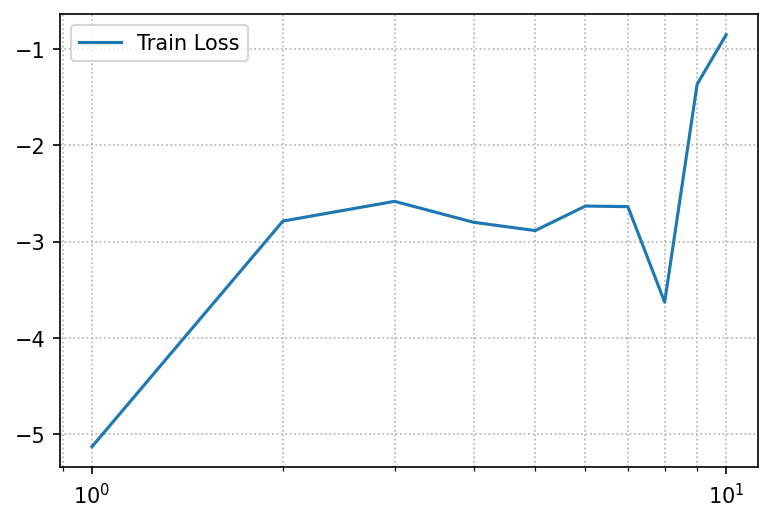

In [232]:
n_epochs_A = 50000
n_epochs_L = 2 

hist_A = pinn.fit(num_epochs=n_epochs_A,
                optimizer=optimizer_ADAM,
                verbose=True)
hist_L = pinn.fit(num_epochs=n_epochs_L,
                optimizer=optimizer_LBFGS,
                verbose=True)

hist= [*hist_A, *hist_L]

hist  = pinn.fit(num_epochs=n_epochs,
                optimizer=optimizer_ADAM,
                verbose=True)

plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
plt.xscale("log")
plt.legend()

################################  0  ################################
Total loss:  -3.9993 | PDE Loss:  -5.2418 | Function Loss:  -4.1456
Total loss:  -3.9993 | PDE Loss:  -5.242 | Function Loss:  -4.1455
Total loss:  -3.9992 | PDE Loss:  -5.2418 | Function Loss:  -4.1455
Total loss:  -3.9992 | PDE Loss:  -5.2417 | Function Loss:  -4.1456
Total loss:  -3.9992 | PDE Loss:  -5.2417 | Function Loss:  -4.1456
Total loss:  -3.9993 | PDE Loss:  -5.2418 | Function Loss:  -4.1456
################################  1  ################################
Total loss:  -3.9993 | PDE Loss:  -5.2418 | Function Loss:  -4.1456
Total loss:  -3.9993 | PDE Loss:  -5.242 | Function Loss:  -4.1455
Total loss:  -3.9992 | PDE Loss:  -5.2418 | Function Loss:  -4.1455
Total loss:  -3.9992 | PDE Loss:  -5.2417 | Function Loss:  -4.1456
Total loss:  -3.9992 | PDE Loss:  -5.2417 | Function Loss:  -4.1456
Total loss:  -3.9993 | PDE Loss:  -5.2418 | Function Loss:  -4.1456
################################  2  #########

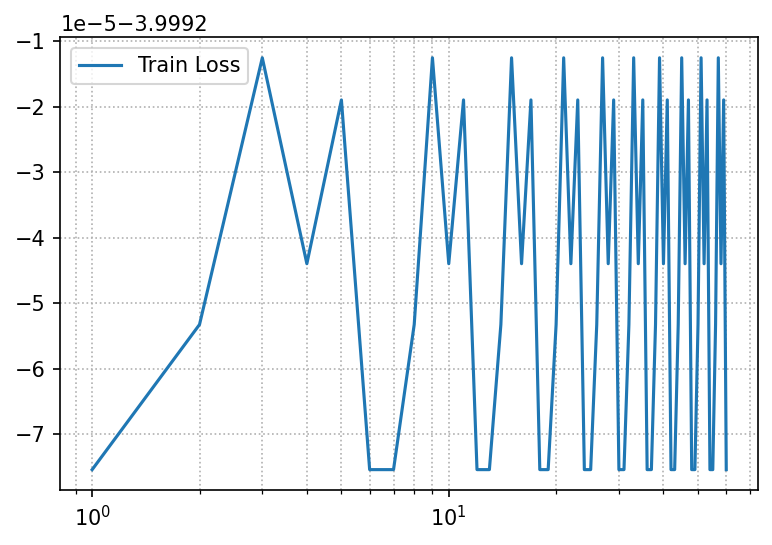

In [208]:
hist  = pinn.fit(num_epochs=10,
                optimizer=optimizer_LBFGS,
                verbose=True)
plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
plt.xscale("log")
plt.legend()

torch.Size([100000])


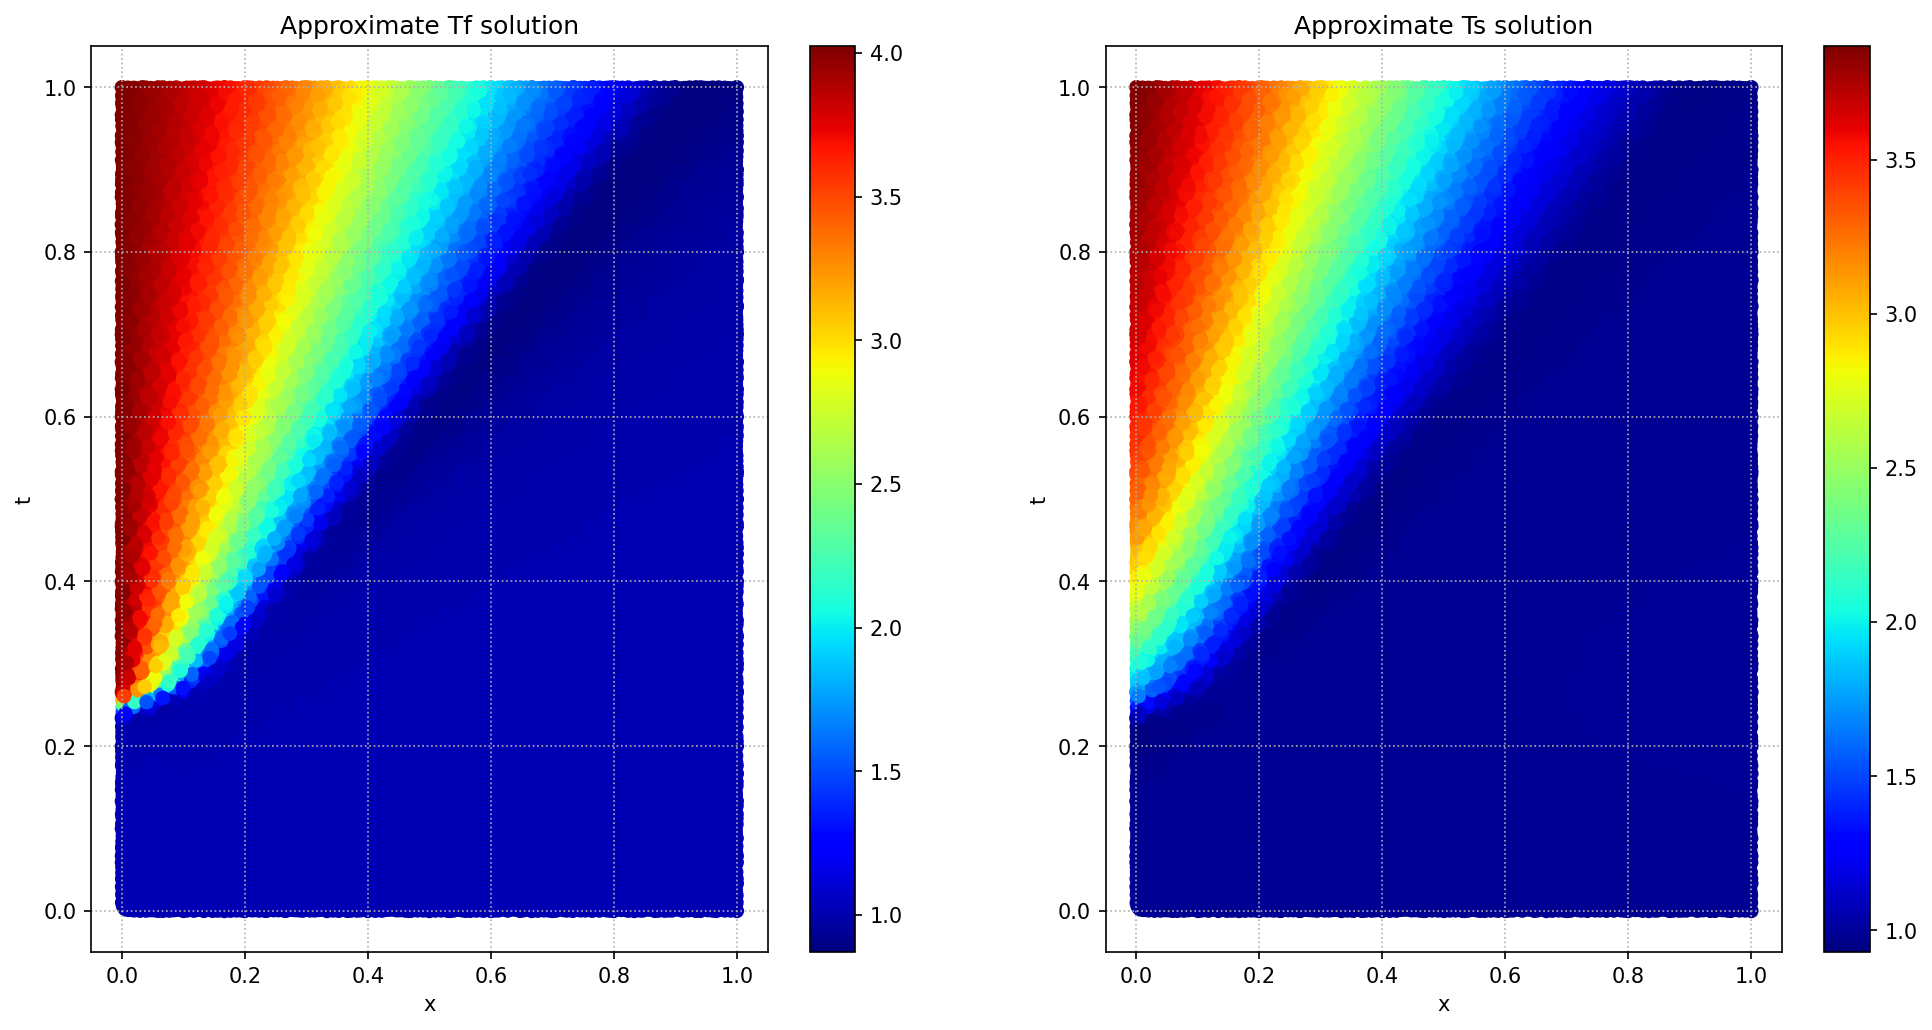

L2 Relative Error Norm:  16.336957931518555 %


In [233]:
pinn.plotting()

In [234]:
name = "was "

In [237]:
z =name + "los"
print(z)

was los
